In [1]:
import matplotlib.pyplot as plt
from itertools import combinations
from random import random,randint
import numpy as np
from numpy.linalg import matrix_rank
from functools import reduce
from scipy.optimize import minimize
from scipy.linalg import expm,sinm,cosm,lu
from numpy import binary_repr
import time
import heapq
import math
from   matplotlib import cm
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.quantum_info.analysis import average_data
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.utils import tensorproduct
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
import warnings
from docplex.mp.model import Model
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer
import scipy.linalg as la
from itertools import permutations, combinations
import pandas as pd
from time import sleep
from tqdm.notebook import trange, tqdm
from numba import njit, jit

In [2]:

np.set_printoptions(threshold=sys.maxsize)

X = np.array([[0,1],[1,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])






def StatetoVec(s):
    l = len(s)
    v = np.zeros(2**l)
    index = 0
    for i in range(l):
        index += s[i]*(2**(l-i-1))
    v[index] = 1
    return np.array(v)

def StatetoVecM(s):
    l = len(s)
    v = np.zeros(2**l)
    index = 0
    for i in range(l):
        index += s[i]*(2**(l-i-1))
    v[index] = -1
    return np.array(v)


def TensorProduct(l):
    temp = l[0]
    for i in range(len(l) - 1):
        temp = np.kron(temp,l[i+1])
    return temp

def Stabilizer_513():
    l = []
    stab = []
    l.append(X)
    l.append(Z)
    l.append(Z)
    l.append(X)
    l.append(I)
    stab.append(TensorProduct(l))
    for i in range(3):
        temp = l[4]
        l.pop(4)
        l.insert(0,temp)
        stab.append(TensorProduct(l))
    return stab
        
    
def Lambda(n):
    li = []
    for i in range(n):
        l = []
        for j in range(2*n):
            l.append(0)
        l[i+n] = 1
        li.append(l)
    for i in range(n):
        l = []
        for j in range(2*n):
            l.append(0)
        l[i] = 1
        li.append(l)
    return np.array(li)
        
        
    
def num_1_pos(d):
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    num_1 = get_indexes(1,d)
    return num_1,len(num_1)

def num_0_pos(d):
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    num_0 = get_indexes(0,d)
    return num_0,len(num_0)

def column(matrix, i):
    return [row[i] for row in matrix]

#Construct initial state 

def init_s(n):
    x = pow(2,n)
    s = 1/np.sqrt(x) * np.ones(x)
    s = s.reshape(x, 1)
    return s

def bin2dec(string_num):
    return str(int(string_num, 2))

def row_binary(v):
    for i in range(len(v)):
        if v[i]%2 == 0:
            v[i] = 0
        else:
            v[i] = 1 
    return v

def converter(d):
    P = 0
    for i in range(len(d)):
        P+=d[i]*(2**(len(d)-i-1))
    return int(P)
                 
#Define some pauli operators
PauliX = [[0,1],[1,0]]   
PauliZ = [[1,0],[0,-1]]
PauliI = np.eye(2)

#Define Cjk and B
def Cjk_generator(d):
    n = len(d)
    l = list(range(0,n))    
    for i in range(n):
        l[i] = PauliI
    s = num_1_pos(d)[0]
    for j in range(len(s)):
        l[s[j]] = PauliZ
    Cjk = l[0]
    for i in range(n-1):
        Cjk = np.kron(Cjk,l[i+1])
    return Cjk

def B_generator(n):
    l = list(range(0,n))
    b = list(range(0,n))
    
    for a in range(n):
        for i in range(n):
            l[i] = PauliI
        l[a]=PauliX
        temp = l[0]
        for i in range(n-1):
            temp = np.kron(temp,l[i+1])
        b[a] = temp
    B = sum(b[a] for a in range(n))
    return B

def basis(n):
    nums = np.array([a for a in range(2**(n))]) 
    bin_nums = (((nums.reshape(-1,1) & (2**np.arange(n)))) != 0).astype(int)
    a = bin_nums[:,::-1]
    return a


def matrix_binary(A):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i][j]%2 == 0:
                A[i][j] = 0
            else:
                A[i][j] = 1
    return A

def error(n,err):
    e = np.zeros(n)
    a = np.random.randint(n,size=err)
    for i in range(len(a)):
        e[a[i]] = 1 
    return e
    
def tensorI(n):
    l = list(range(0,n))
    for i in range(n):
            l[i] = PauliI
    temp = l[0]
    for i in range(n-1):
        temp = np.kron(temp,l[i+1])
    return temp 

def PauliZ_idx(n,a):
    l = list(range(0,n))
    for i in range(n):
            l[i] = PauliI
    l[a] = PauliZ
    temp = l[0]
    for i in range(n-1):
        temp = np.kron(temp,l[i+1])
    return temp

def PauliZ_idx2(n,a,b):
    l = list(range(0,n))
    for i in range(n):
            l[i] = PauliI
    l[a] = PauliZ
    l[b] = PauliZ
    temp = l[0]
    for i in range(n-1):
        temp = np.kron(temp,l[i+1])
    return temp

def min_weight(n):
    
    m = int(n/2)
    min_w = []
    for a in range(m):
        first_term = -0.5*(tensorI(n) - PauliZ_idx(n,a))
        second_term = -0.5*(tensorI(n) - PauliZ_idx(n,a+m))
        third_term = 0.25*(tensorI(n) - PauliZ_idx(n,a) - PauliZ_idx(n,a+m) + PauliZ_idx2(n,a,a+m))
        min_w.append(first_term + second_term + third_term)
    min_weight = sum(min_w[b] for b in range(m))
    return min_weight
        
        
        


def degenerate_error(e,H):
    err = []
    for i in range(2**H.shape[0]):
        err.append(e)
    return matrix_binary(np.array(err) + basis(H.shape[0]).dot(H))
        

def prob_sort(d,N):
    return np.argsort(d)[::-1][:N]
    

def QAOA_finegrid(C,B,n, width):   
    s = init_s(n)
    s_d = (s).T
    
    #print("the number of basis",k+1)

    #run the program
    
    step_size   = width
    result_array = np.zeros(shape=((int(3.14/step_size)+1), int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)
    f_p_max = -1e15
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0
    for i in trange((int(3.14/step_size))):           # i for a_gamma
        for j in range(int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)
        

            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p

            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
        time.sleep(0.2)
    return f_p_max_gamma ,f_p_max_beta ,f_p_max

    
    

In [8]:

H_oringin = np.array([[1,0,0,1,0,0,1,1,0,0],[0,1,0,0,1,0,0,1,1,0],[0,0,1,1,0,0,1,1,1,1],[0,1,0,1,0,1,0,0,0,1]])

H = np.array([[1,0,0,1,0,0,1,1,0,0],[0,1,0,0,1,0,0,1,1,0],[0,0,1,1,0,0,1,1,1,1],[0,1,0,1,0,1,0,0,0,1],[0,0,1,0,1,1,1,0,0,0]])
H_T = H.T

L = Lambda(5)

G = np.array([[1,0,0,0,1,1,1,0,1,1],[0,1,0,0,1,0,0,1,1,0],[0,0,1,0,1,1,1,0,0,0],[0,0,0,1,1,1,0,1,1,1],
              [0,0,0,0,1,1,0,0,1,0],[0,0,0,0,0,1,1,1,1,1]])


M = H_oringin.dot(L)

print(matrix_binary(M.dot(G.T)))
# P = np.array([[1,1,1,0],[0,1,1,0],[0,0,0,1],[1,0,1,0]])
# print(matrix_rank(P))
# x = np.array([1,0,0,0,1,1,1,0,1,1])

# M_sw = matrix_binary(P.dot(M))

# print(M_sw)
# print(sum(num_1_pos(M.T[i])[1] for i in range(M.shape[1]))/M.shape[1])


err = []
err.append(np.zeros(10))
for i in range(10):
    l = np.zeros(10)
    l[i] = 1
    err.append(l)
for i in range(5):
    l = np.zeros(10)
    l[i] = 1
    l[i+5] = 1
    err.append(l)
err = np.array(err)

error_syndrome = []
for i in range(len(err)):
    sy = row_binary(M.dot((err[i]).T))
    print('\nerror: ',err[i])
    print('syndrome: ',sy)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 0. 0.]

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 0. 1.]

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [1. 0. 1. 0.]

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [1. 1. 1. 0.]

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 1. 1. 0.]

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 1. 1.]

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
syndrome:  [1. 0. 0. 0.]

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
syndrome:  [0. 1. 0. 1.]

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
syndrome:  [0. 0. 1. 0.]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
syndrome:  [1. 0. 1. 1.]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
syndrome:  [0. 1. 0. 0.]

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
syndrome:  [1. 0. 0. 1.]

error:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
syndrome:  [1. 1. 1. 1.]

error:  [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
syndrome:  [1. 1. 0. 0.]

error:  [0. 0.

In [ ]:
coset = []
logical_stb = []
error_stack = []
logical_x_stack = []
logical_z_stack = []
logical_y_stack = []



logical_x = [1,1,1,1,1,0,0,0,0,0]
logical_z = [0,0,0,0,0,1,1,1,1,1]
logical_y = [1,1,1,1,1,1,1,1,1,1]




for i in range(16):
    logical_x_stack.append(logical_x)
logical_x_error  = matrix_binary(err + np.array(logical_x_stack))

for i in range(16):
    logical_z_stack.append(logical_z)
logical_z_error  = matrix_binary(err + np.array(logical_z_stack))

for i in range(16):
    logical_y_stack.append(logical_y)
logical_y_error  = matrix_binary(err + np.array(logical_y_stack))

stabilizer = matrix_binary(basis(H_oringin.shape[0]).dot(H_oringin))


logical_x_stack = []
logical_z_stack = []
logical_y_stack = []


for i in range(2**H_oringin.shape[0]):
    logical_x_stack.append(logical_x)
    logical_y_stack.append(logical_y)
    logical_z_stack.append(logical_z)


logical_x_stb = matrix_binary(stabilizer + np.array(logical_x_stack))
logical_y_stb = matrix_binary(stabilizer + np.array(logical_y_stack))
logical_z_stb = matrix_binary(stabilizer + np.array(logical_z_stack))

logical_stb.append(stabilizer)
logical_stb.append(logical_x_stb)
logical_stb.append(logical_y_stb)
logical_stb.append(logical_z_stb)





error_0_stack = []
error_1_stack = []
error_2_stack = []
error_3_stack = []
error_4_stack = []
error_5_stack = []
error_6_stack = []
error_7_stack = []
error_8_stack = []
error_9_stack = []
error_10_stack = []
error_11_stack = []
error_12_stack = []
error_13_stack = []
error_14_stack = []
error_15_stack = []




for i in range(16):
    error_0_stack.append([0,0,0,0,0,0,0,0,0,0])
    error_1_stack.append([1,0,0,0,0,0,0,0,0,0])
    error_2_stack.append([0,1,0,0,0,0,0,0,0,0])
    error_3_stack.append([0,0,1,0,0,0,0,0,0,0])
    error_4_stack.append([0,0,0,1,0,0,0,0,0,0])
    error_5_stack.append([0,0,0,0,1,0,0,0,0,0])
    error_6_stack.append([0,0,0,0,0,1,0,0,0,0])
    error_7_stack.append([0,0,0,0,0,0,1,0,0,0])
    error_8_stack.append([0,0,0,0,0,0,0,1,0,0])
    error_9_stack.append([0,0,0,0,0,0,0,0,1,0])
    error_10_stack.append([0,0,0,0,0,0,0,0,0,1])
    error_11_stack.append([1,0,0,0,0,1,0,0,0,0])
    error_12_stack.append([0,1,0,0,0,0,1,0,0,0])
    error_13_stack.append([0,0,1,0,0,0,0,1,0,0])
    error_14_stack.append([0,0,0,1,0,0,0,0,1,0])
    error_15_stack.append([0,0,0,0,1,0,0,0,0,1])


error_stack.append(error_0_stack)
error_stack.append(error_1_stack)
error_stack.append(error_2_stack)
error_stack.append(error_3_stack)
error_stack.append(error_4_stack)
error_stack.append(error_5_stack)
error_stack.append(error_6_stack)
error_stack.append(error_7_stack)
error_stack.append(error_8_stack)
error_stack.append(error_9_stack)
error_stack.append(error_10_stack)
error_stack.append(error_11_stack)
error_stack.append(error_12_stack)
error_stack.append(error_13_stack)
error_stack.append(error_14_stack)
error_stack.append(error_15_stack)

print(len(error_stack))


for i in range(4):
    for j in range(16):
        coset.append(matrix_binary(np.array(logical_stb[i]) + np.array(error_stack)[j]))
        
print(len(coset[0]))


## QAOA pen = 0.1

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 0.]




 Runningtime :  1263.7477068901062 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 1 0]
 [0 1 0 1 1 0 0 0 1 1]
 [0 0 1 0 1 0 0 1 1 1]
 [0 1 0 0 0 0 1 0 1 1]
 [0 1 1 1 0 0 0 1 0 0]
 [1 1 0 1 0 1 1 0 0 0]
 [0 1 0 1 0 0 1 1 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.03709992326391637

total probability logical X:  0.03678842413714548

total probability logical Z:  0.03709379894965707

total probability logical Y:  0.036786995163931205

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776914151465012

rate: 0.251066784875638

correct!


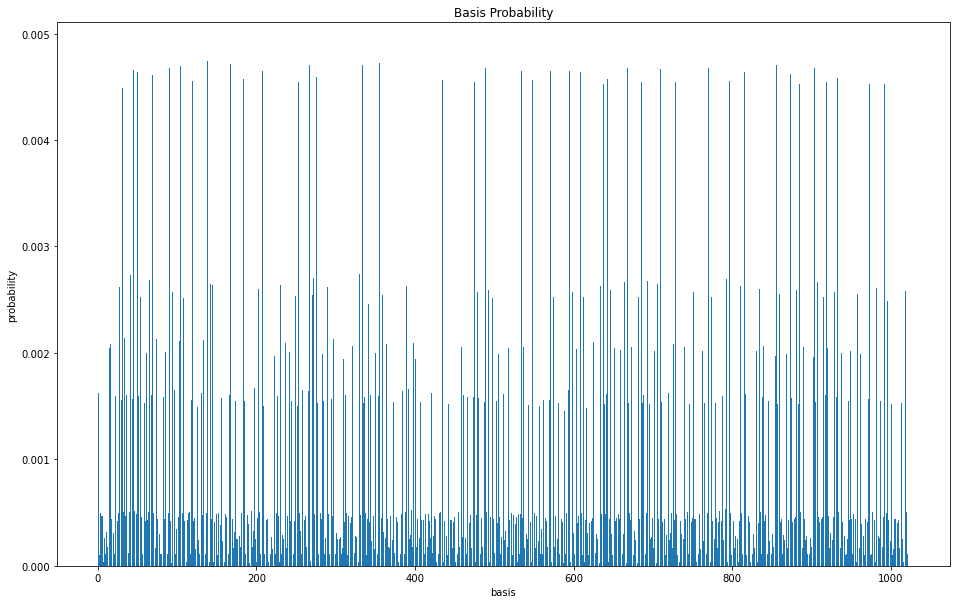

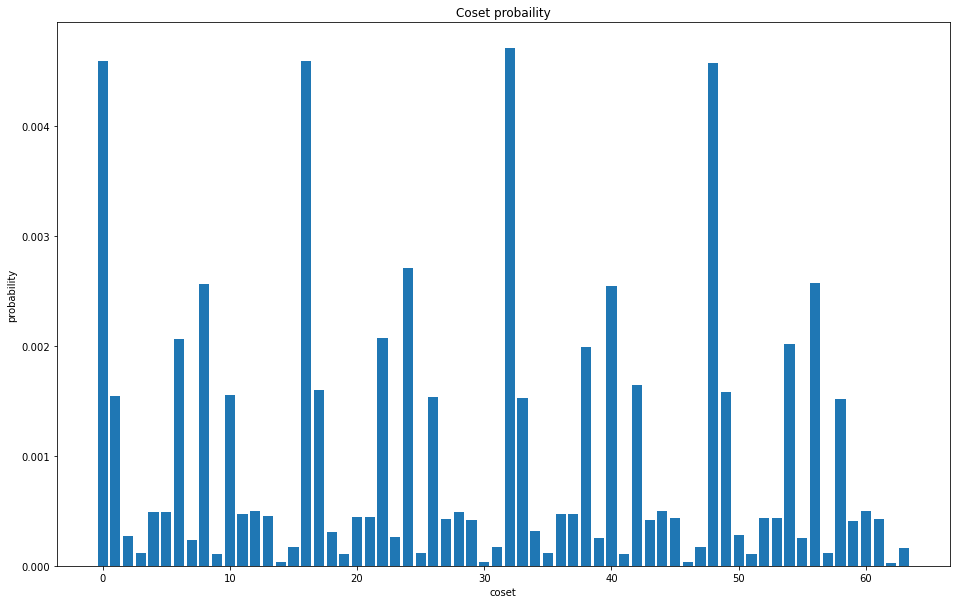

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 1.]




 Runningtime :  1263.9800531864166 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 1 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [0 0 1 1 0 0 0 1 1 0]
 [0 0 0 1 1 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 1 0 0 1]
 [1 0 0 1 0 1 1 0 1 0]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.036790640769952726

total probability logical X:  0.037097467731810656

total probability logical Z:  0.03678495637774955

total probability logical Y:  0.037095991569604594

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776905644911753

rate: 0.24897391682690437

cannot correct


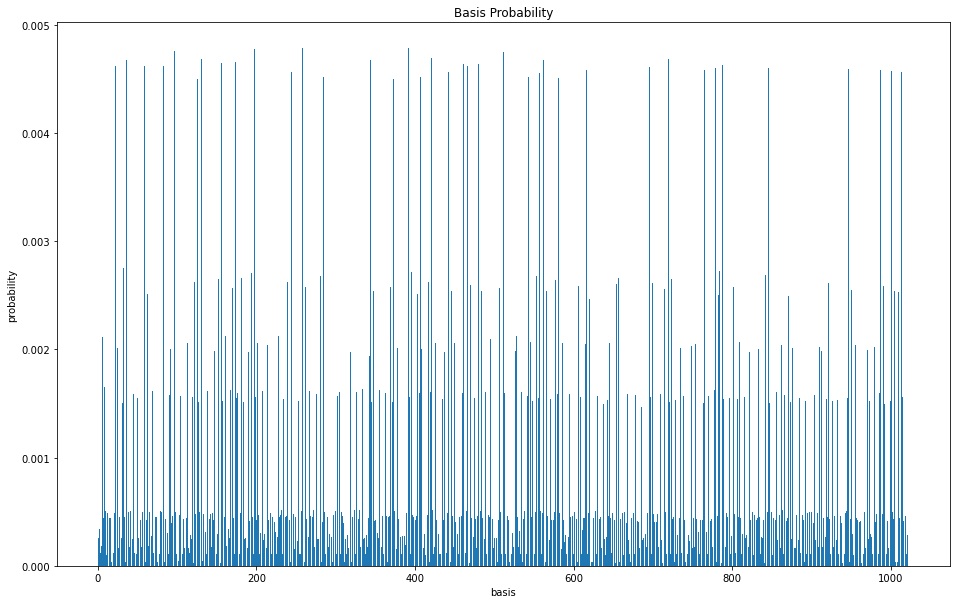

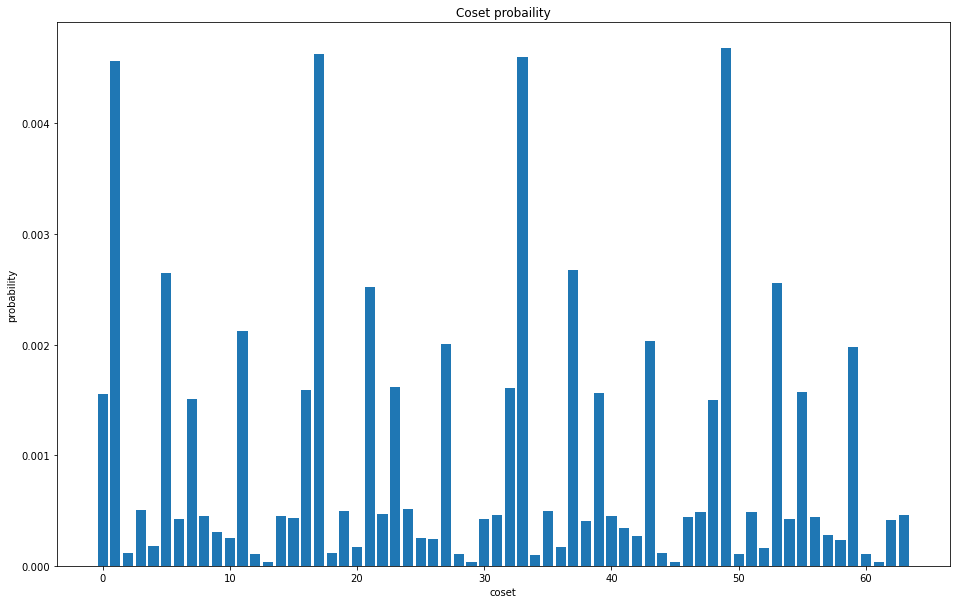

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 0. 1. 0.]




 Runningtime :  1265.5324020385742 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 1 1]
 [0 0 1 1 0 0 0 1 0 0]
 [0 1 1 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 1]
 [0 1 0 1 1 0 1 0 0 0]
 [1 0 1 1 0 1 0 0 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.03709515404734754

total probability logical X:  0.036784022160189334

total probability logical Z:  0.037092936790879445

total probability logical Y:  0.03678617664099054

 coset without doing anything : 0.005859375

matching syndrome probability 0.14775828963940685

rate: 0.2510529469302569

correct!


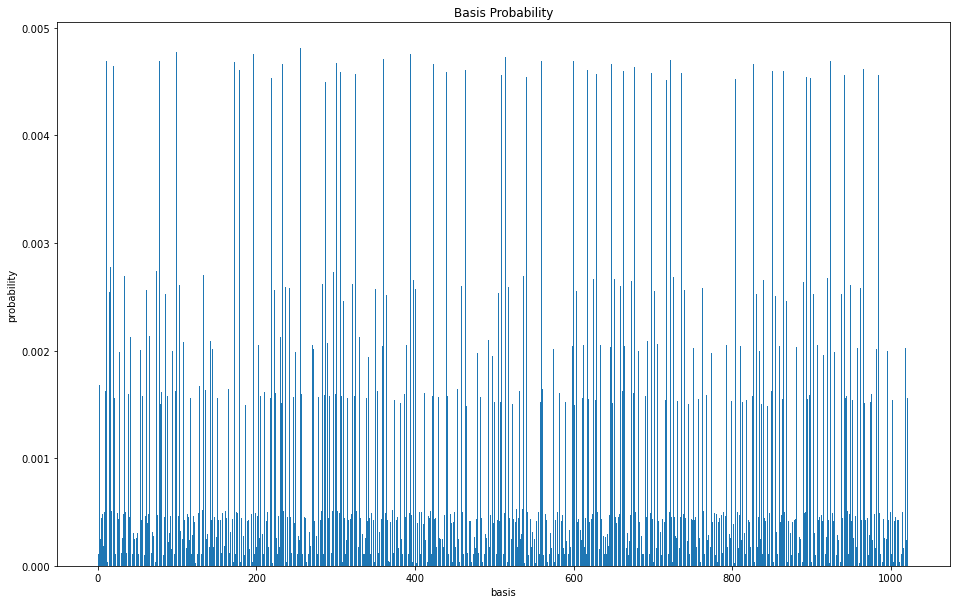

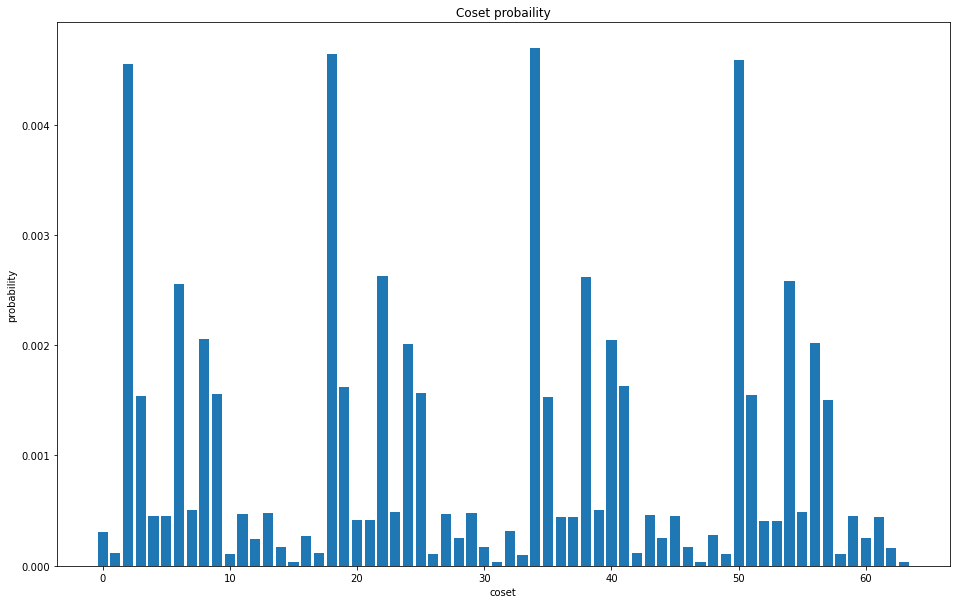

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 1. 1. 0.]




 Runningtime :  1263.5835189819336 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 1 1 0 0 0 1 0]
 [0 1 1 1 0 0 1 1 1 0]
 [0 1 0 1 1 0 1 0 0 1]
 [1 1 0 0 0 0 1 0 0 0]
 [1 0 0 0 1 1 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.03709777108329944

total probability logical X:  0.03678680606567984

total probability logical Z:  0.037095651531257476

total probability logical Y:  0.03678878170419153

 coset without doing anything : 0.005859375

matching syndrome probability 0.1477690103844283

rate: 0.25105244317998593

correct!


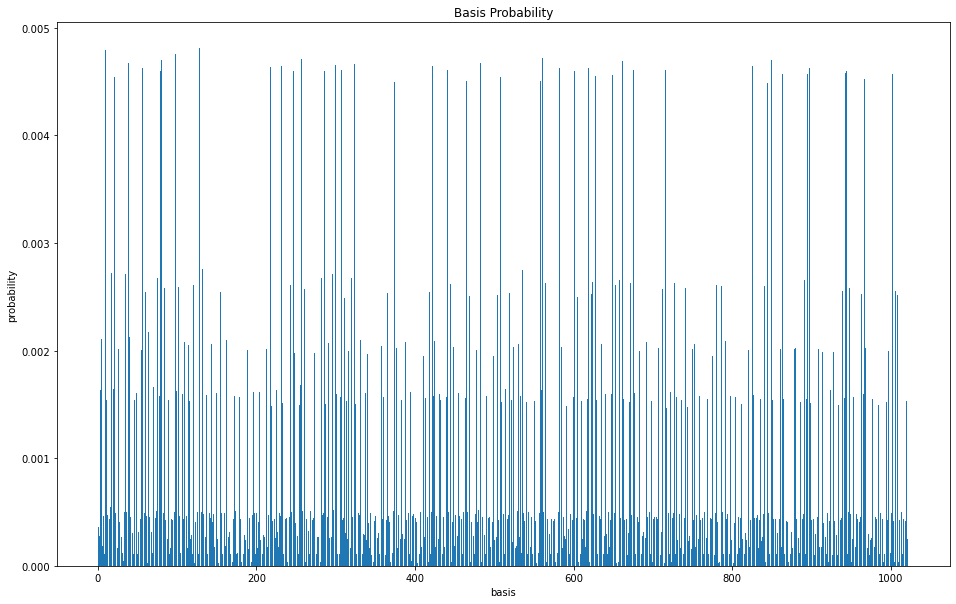

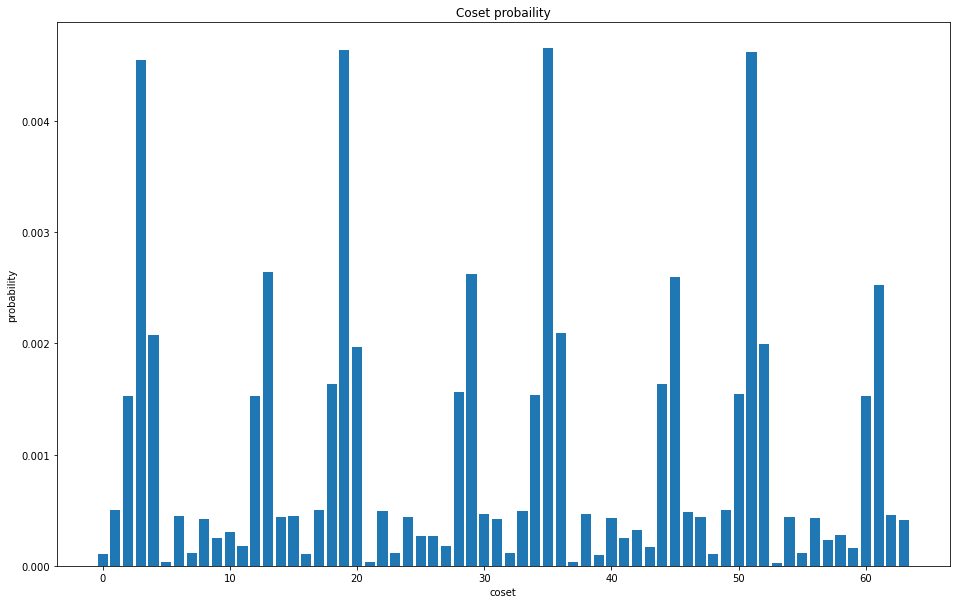

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 1. 1. 0.]




 Runningtime :  1264.4708445072174 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 1 0 0 0 0 0 0]
 [1 1 0 0 0 1 1 0 0 0]
 [0 1 1 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 1 0 1 0]
 [0 0 0 0 1 0 1 0 0 0]
 [0 1 0 0 1 0 0 0 1 1]
 [0 1 1 0 1 0 1 0 0 1]
 [0 0 1 1 1 0 0 1 1 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.03709576135713778

total probability logical X:  0.03678881576443406

total probability logical Z:  0.037097699466536085

total probability logical Y:  0.03678676456073761

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776904114884554

rate: 0.25103879045795374

correct!


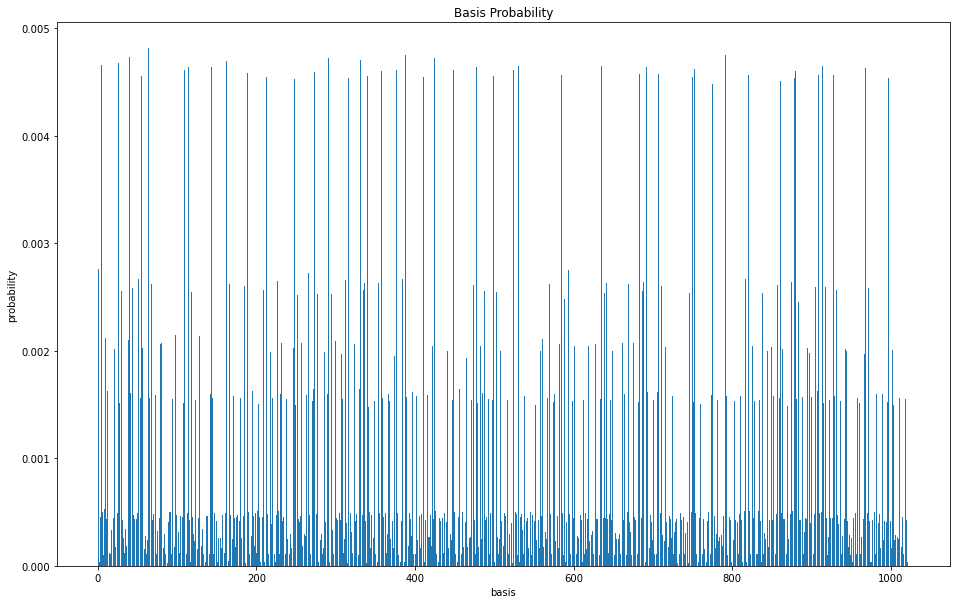

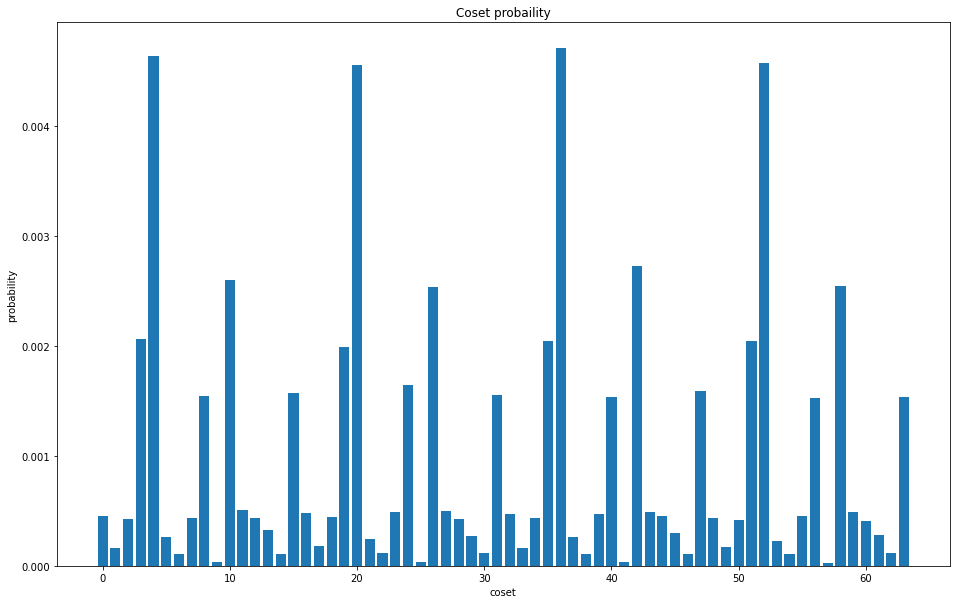

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 1. 1.]




 Runningtime :  1267.2971663475037 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 1 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 1 0 0 0 1 1 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 1 0 0 1 0 1 0 1 1]
 [1 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [1 1 0 1 0 0 1 0 1 0]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.03709517569343776

total probability logical X:  0.036784045537346856

total probability logical Z:  0.037092939114465824

total probability logical Y:  0.03678616349454688

 coset without doing anything : 0.005859375

matching syndrome probability 0.1477583238397973

rate: 0.25105303531770656

cannot correct


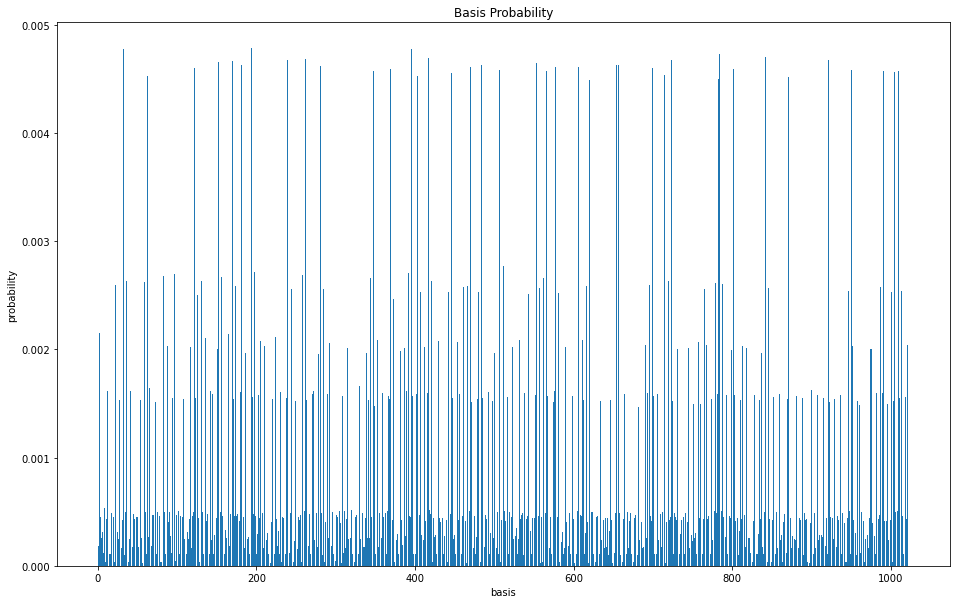

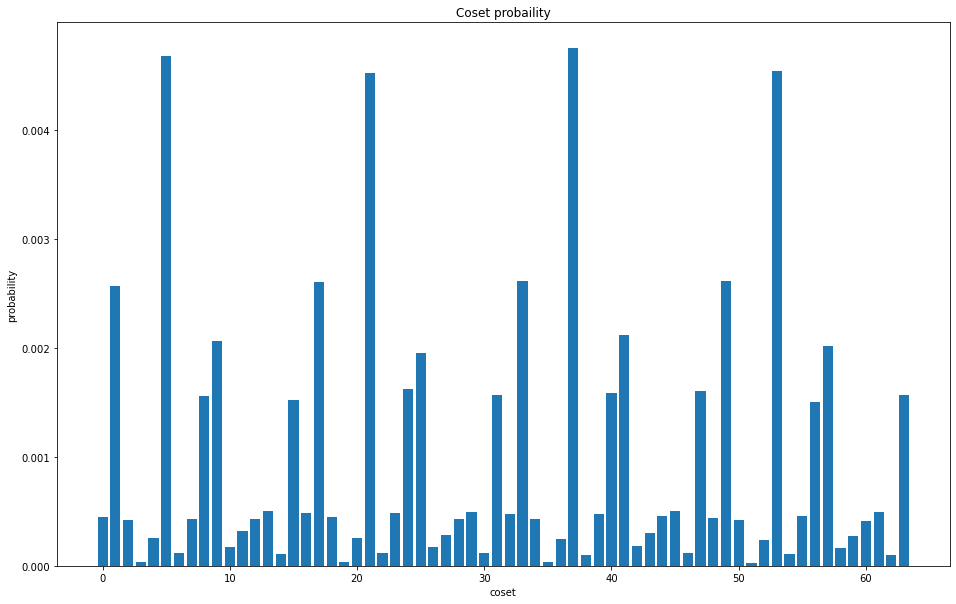

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 0.]




 Runningtime :  1262.3747763633728 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 1 0 0 1 0 1 0]
 [0 1 0 0 1 0 1 0 0 1]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0]
 [0 1 1 0 0 0 1 1 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 1 0 1]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.037099521082009916

total probability logical X:  0.036788428642328286

total probability logical Z:  0.03709396240116644

total probability logical Y:  0.036787004413930735

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776891653943539

rate: 0.2510644454248881

cannot correct


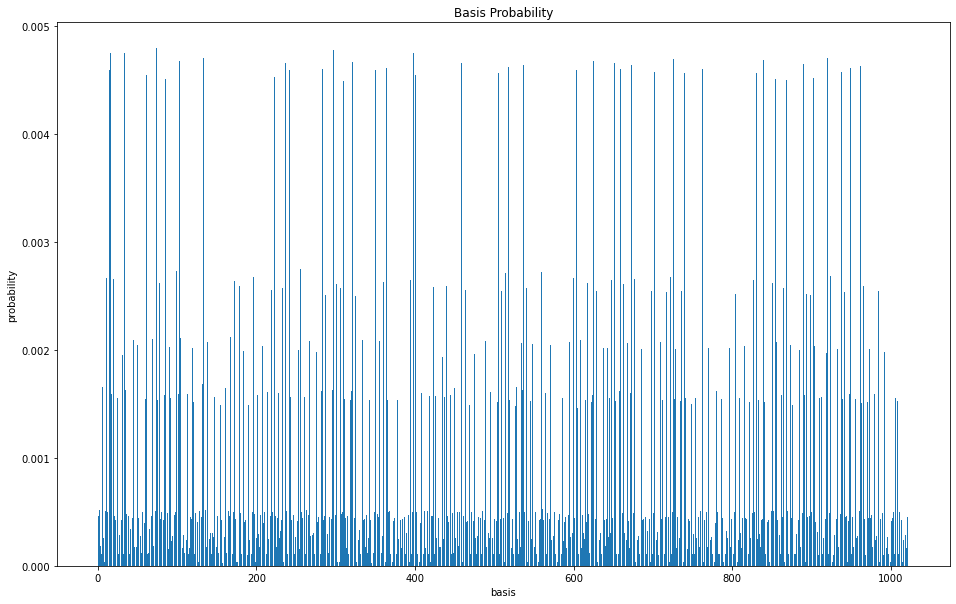

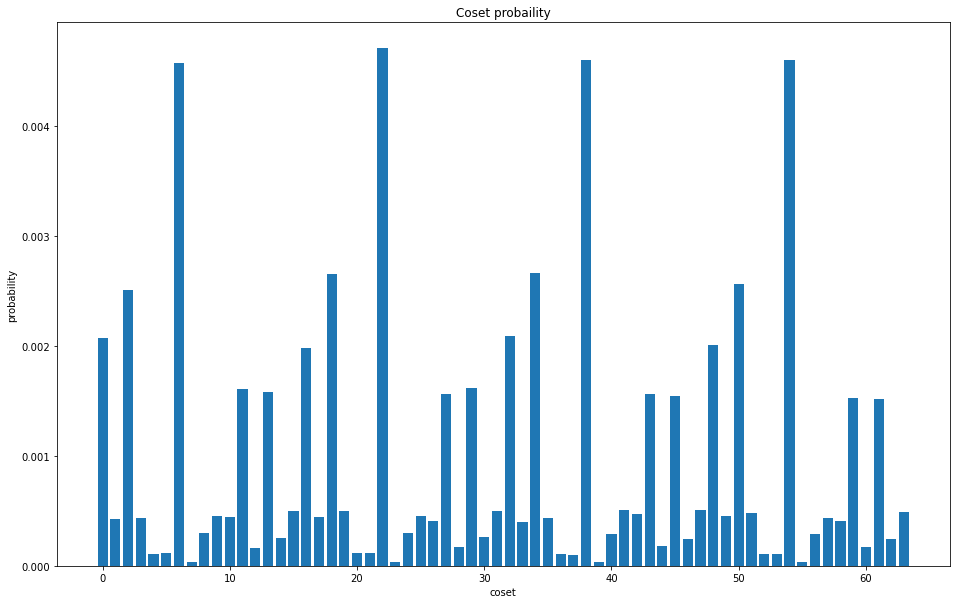

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [0. 1. 0. 1.]




 Runningtime :  1260.47860121727 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [0 1 0 1 1 0 1 0 1 1]
 [0 0 0 1 1 0 0 0 0 0]
 [0 1 1 1 0 0 1 1 0 0]
 [0 0 0 1 0 1 0 0 1 0]
 [1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 0 1 0 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.037096941749515465

total probability logical X:  0.03678582890336947

total probability logical Z:  0.037091225767577625

total probability logical Y:  0.036784338700001716

 coset without doing anything : 0.005859375

matching syndrome probability 0.14775833512046427

rate: 0.2510649684789092

correct!


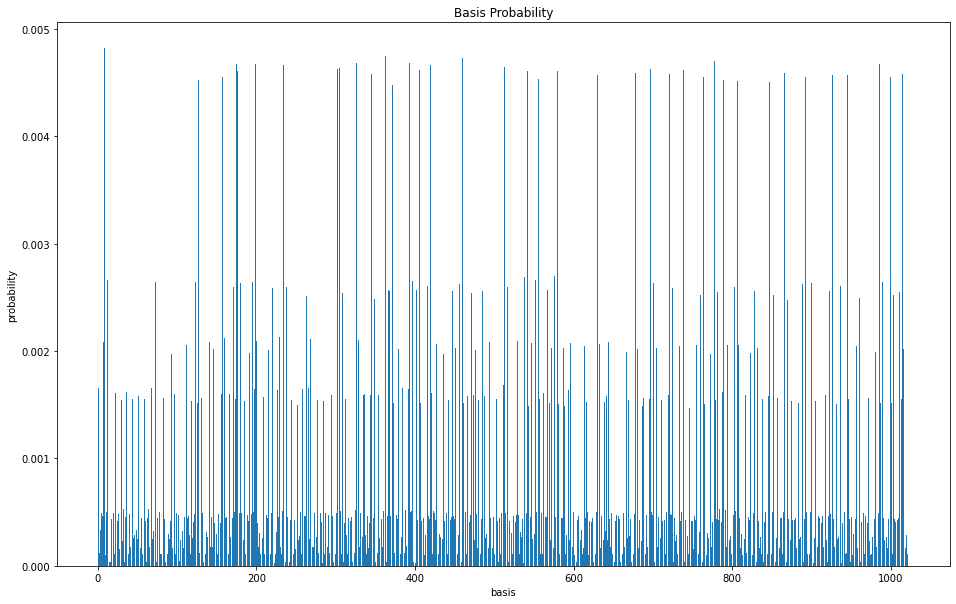

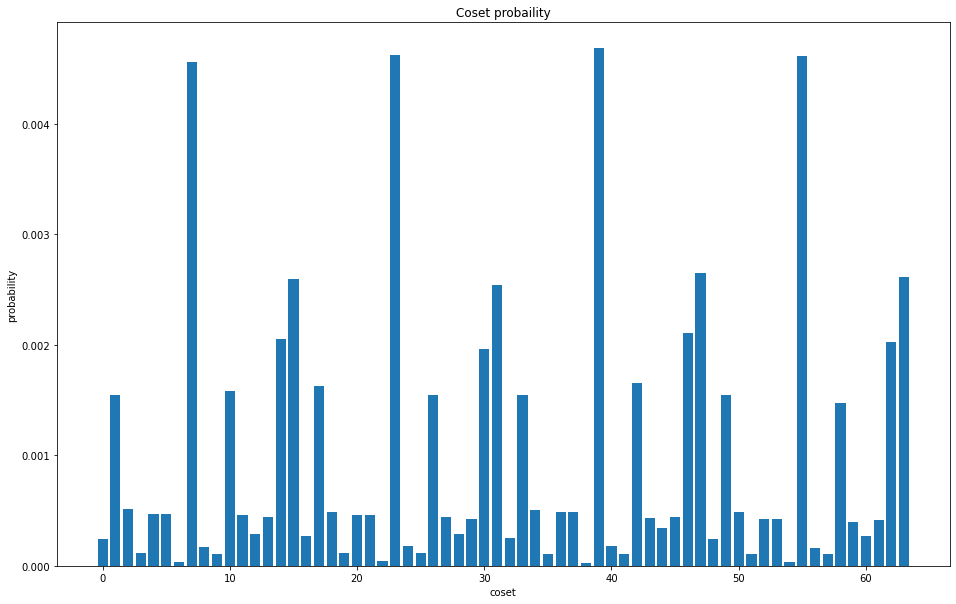

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [0. 0. 1. 0.]




 Runningtime :  1259.5320129394531 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 0 1 0 0 1 0 1 0]
 [0 0 0 0 1 0 1 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 1 0]
 [0 0 1 0 0 0 1 1 1 0]
 [0 0 1 0 1 0 0 0 1 1]
 [0 0 0 1 0 0 0 0 0 1]
 [0 1 1 1 0 0 0 0 0 0]]

check
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.037097317688673345

total probability logical X:  0.036786247962600736

total probability logical Z:  0.037095211555456246

total probability logical Y:  0.036788370034798214

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776714724152853

rate: 0.2510525403054374

cannot correct


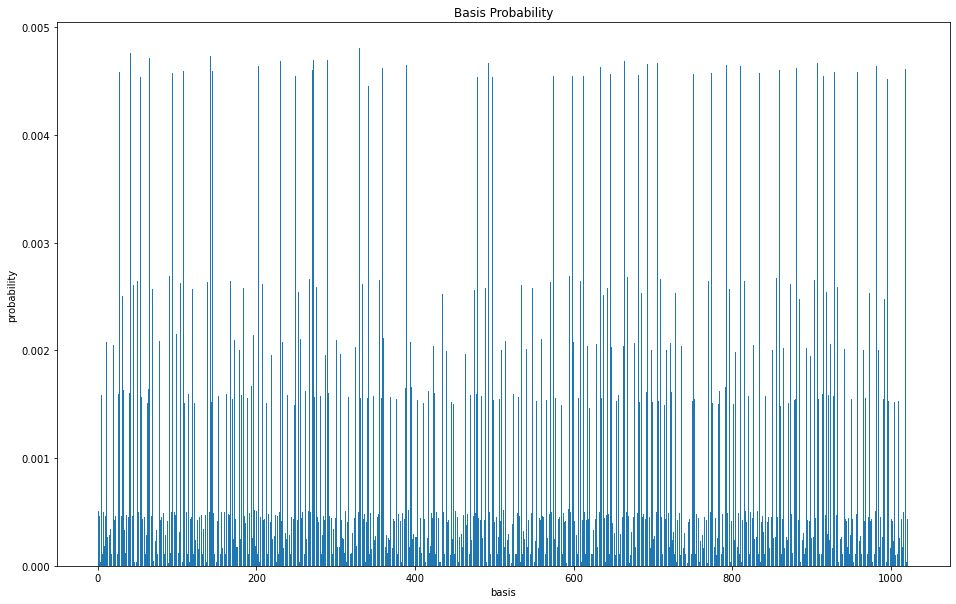

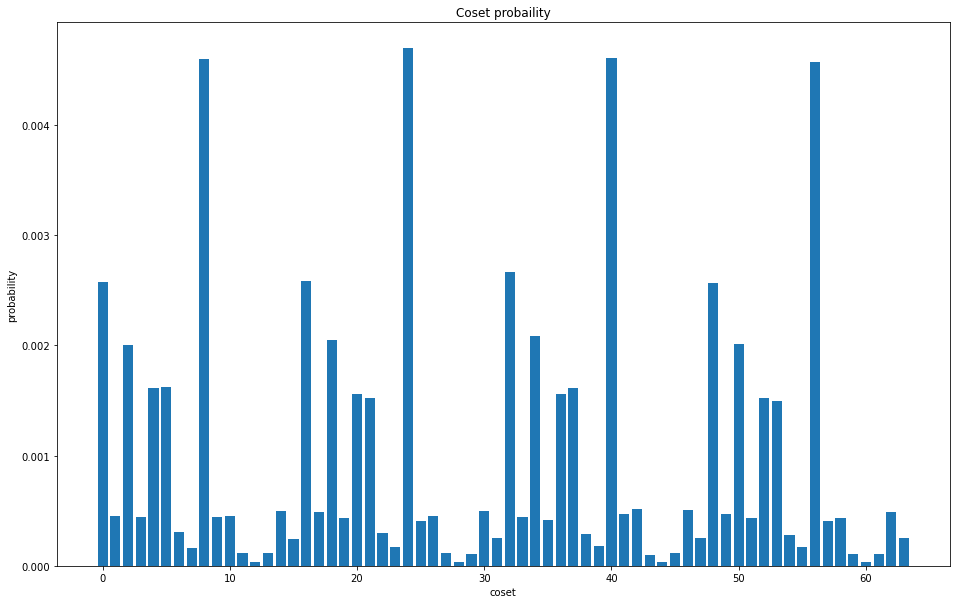

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 0. 1. 1.]




 Runningtime :  1260.446105003357 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 1 0 0 0]
 [0 0 1 0 1 0 0 1 0 1]
 [0 1 0 0 0 0 1 0 0 1]
 [1 1 0 1 0 1 1 0 1 0]
 [0 1 1 1 0 0 0 1 1 0]
 [0 0 0 1 1 0 1 0 1 0]
 [0 1 0 1 1 0 0 0 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.037097386111668865

total probability logical X:  0.036786234485223904

total probability logical Z:  0.03709521805160628

total probability logical Y:  0.03678834285478526

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776718150328433

rate: 0.2510529451415728

correct!


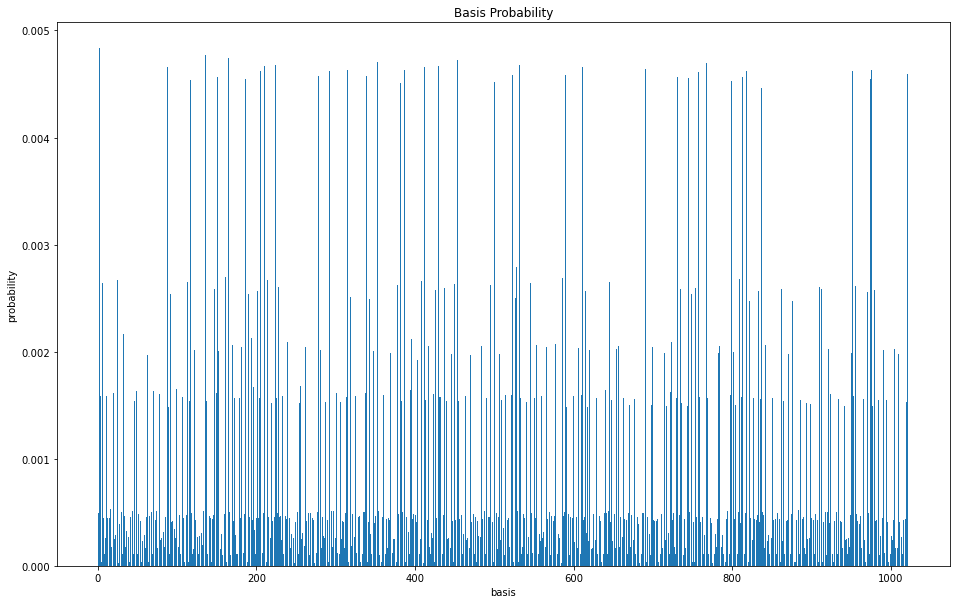

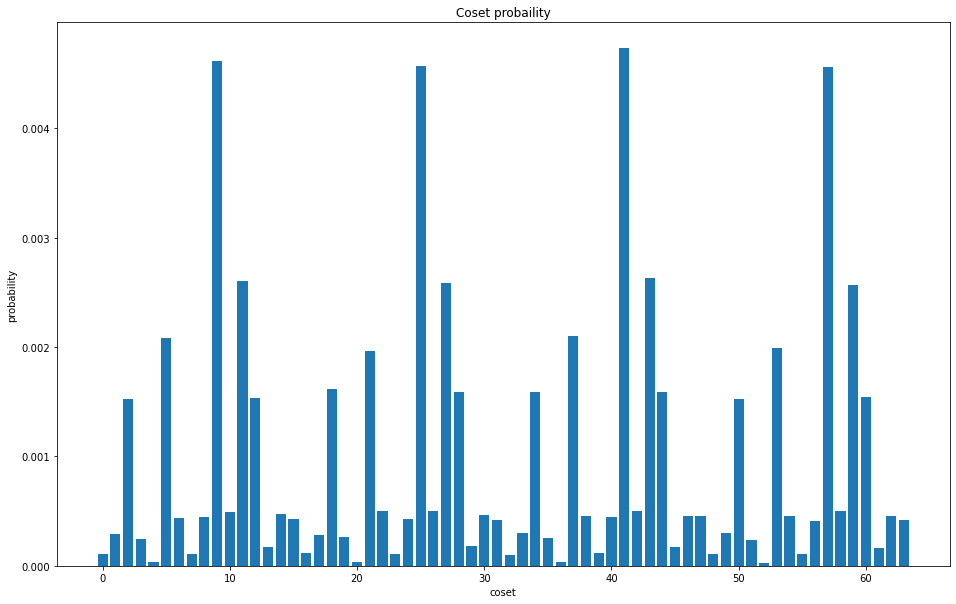

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 0. 0.]




 Runningtime :  1259.2397446632385 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 1 0 0 0 0 0 0 0]
 [1 0 0 1 0 1 0 0 1 0]
 [0 0 1 1 0 0 1 1 1 0]
 [0 0 1 1 1 0 0 0 1 1]
 [0 1 1 0 1 0 1 1 0 1]
 [0 0 0 1 1 0 1 0 0 1]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.03709489752480202

total probability logical X:  0.03678786053378898

total probability logical Z:  0.03709325023598358

total probability logical Y:  0.036782329941741014

 coset without doing anything : 0.005859375

matching syndrome probability 0.1477583382363156

rate: 0.2510511282650914

cannot correct


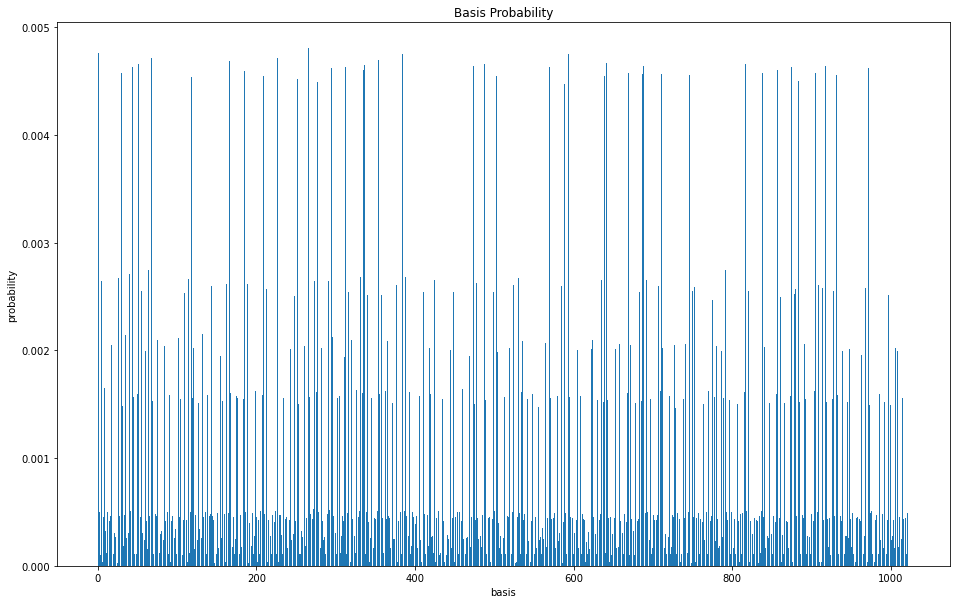

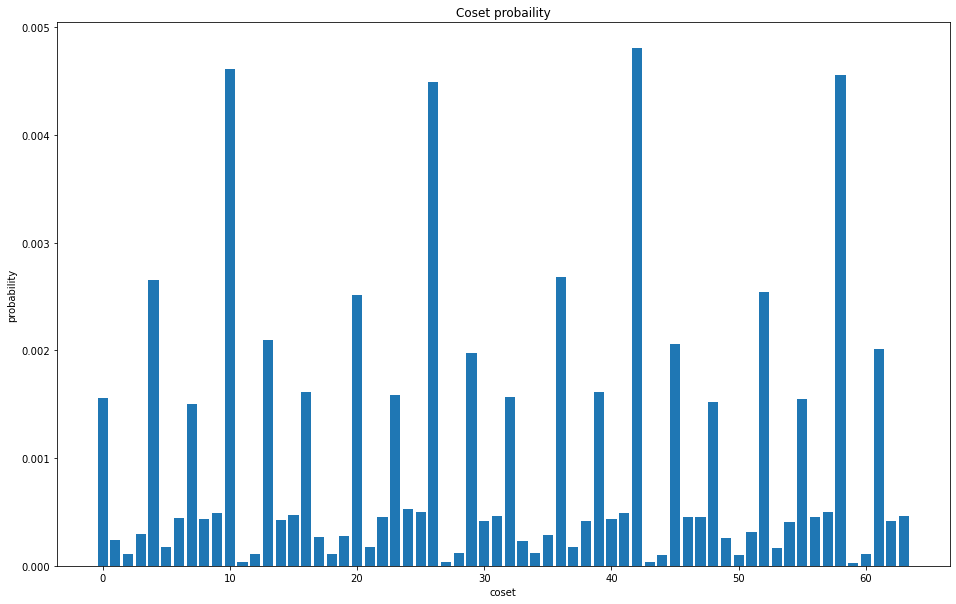

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 1.]




 Runningtime :  1259.7710688114166 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 0 1 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 1 1 0 0]
 [0 0 1 0 1 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 1]
 [0 0 0 0 1 0 1 0 1 1]
 [0 1 1 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.036790741945769756

total probability logical X:  0.03709740802181722

total probability logical Z:  0.03678490603395391

total probability logical Y:  0.03709594074929994

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776899675084082

rate: 0.2489747021007667

cannot correct


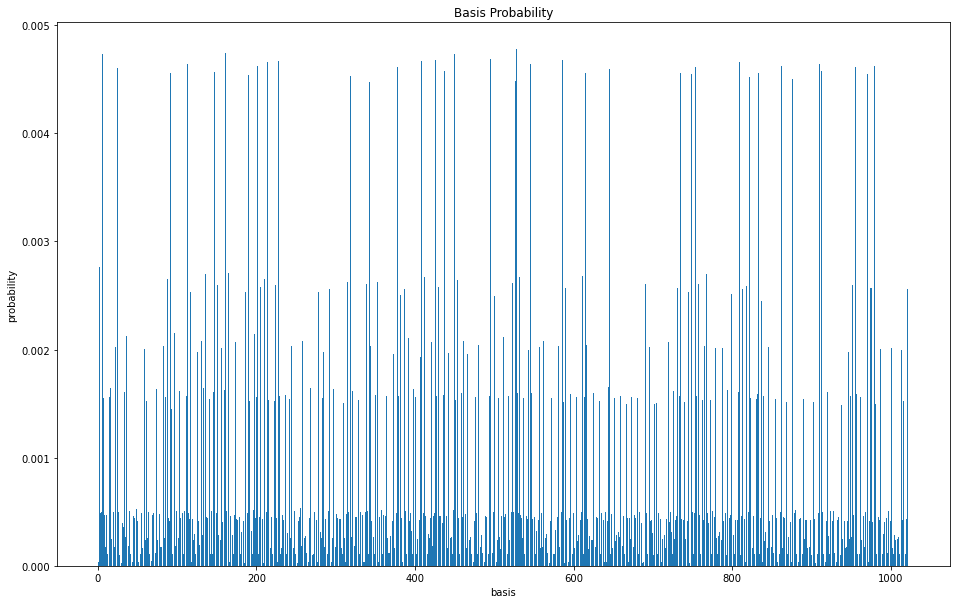

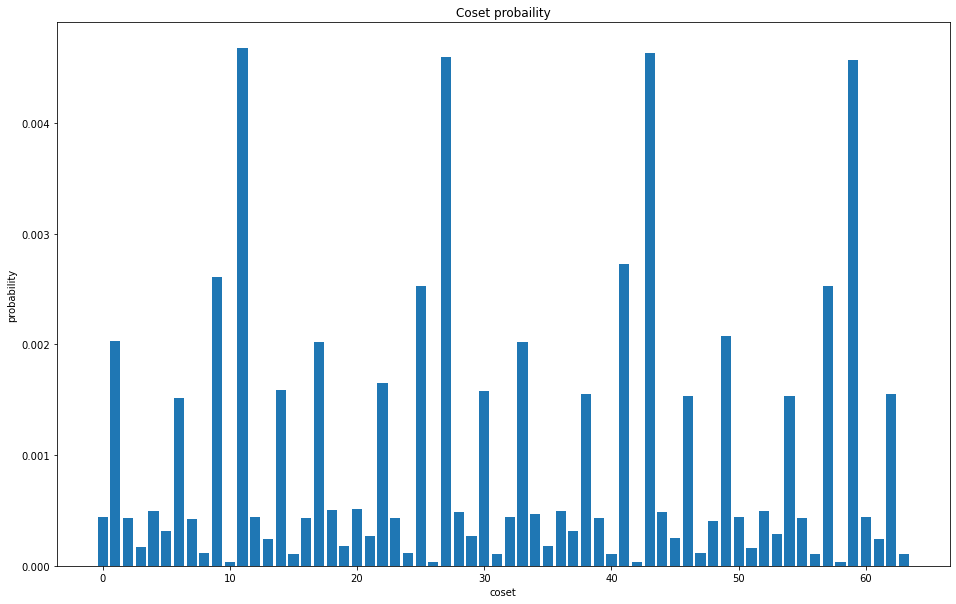

error:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [1. 1. 1. 1.]




 Runningtime :  1259.216584444046 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1]
 [0 1 1 0 0 0 0 0 1 0]
 [1 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 1 0 1 0 1 1]
 [0 0 0 1 0 0 0 1 1 0]
 [0 0 1 0 1 0 0 1 0 0]
 [0 0 1 1 0 0 1 1 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.03709789046926468

total probability logical X:  0.03678673101482739

total probability logical Z:  0.03709566679440959

total probability logical Y:  0.03678872010861376

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776900838711543

rate: 0.2510532544962208

correct!


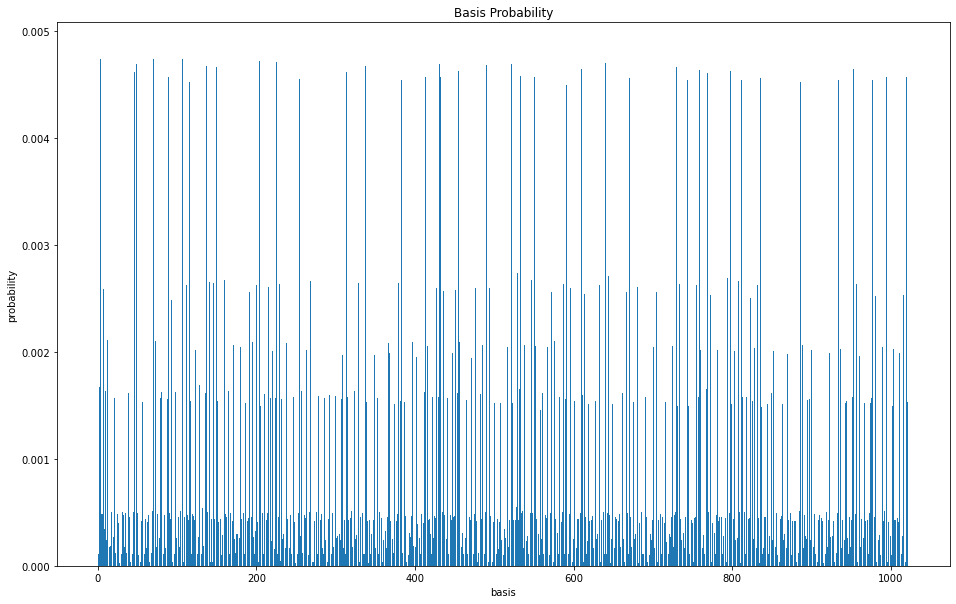

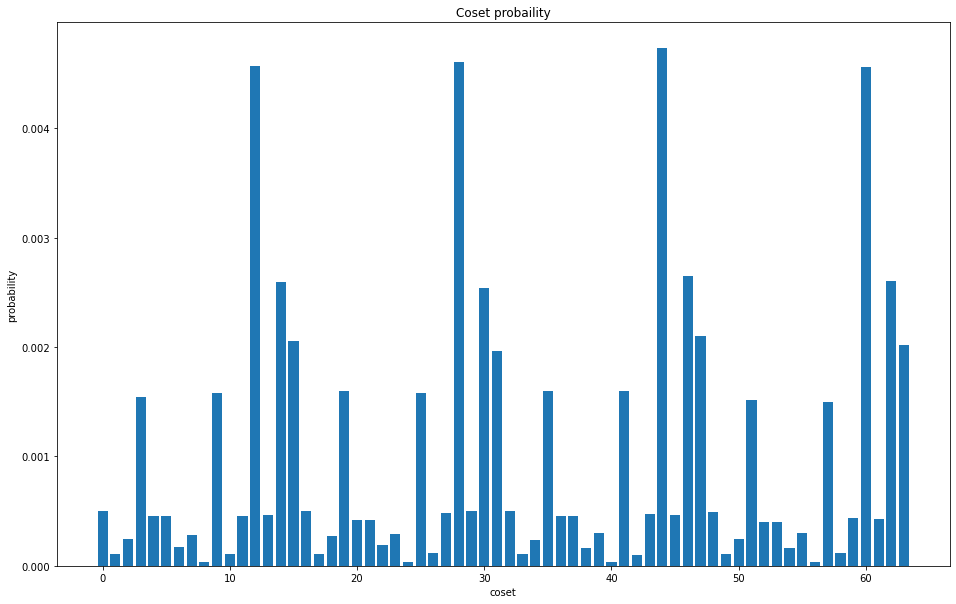

error:  [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [1. 1. 0. 0.]




 Runningtime :  1260.9523043632507 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 1 1]
 [0 1 0 1 0 0 0 0 0 0]
 [0 1 1 1 0 0 1 0 1 0]
 [0 1 0 0 1 0 1 0 0 0]
 [1 0 0 0 0 1 1 0 0 0]
 [1 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 1 0 1 0 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.0370991713324936

total probability logical X:  0.036788051748797714

total probability logical Z:  0.03709345311555089

total probability logical Y:  0.036786521527826556

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776719772466876

rate: 0.2510649988884518

correct!


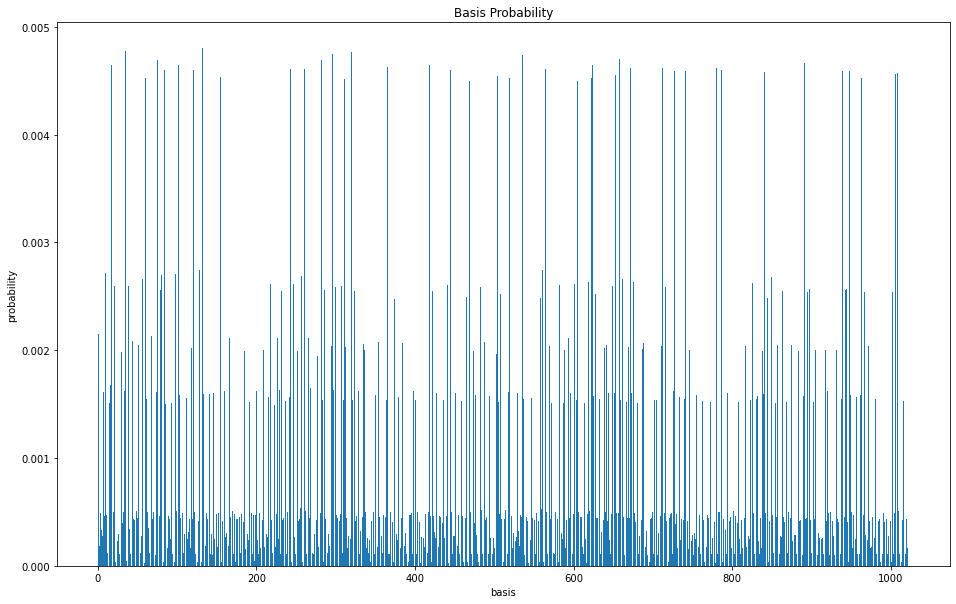

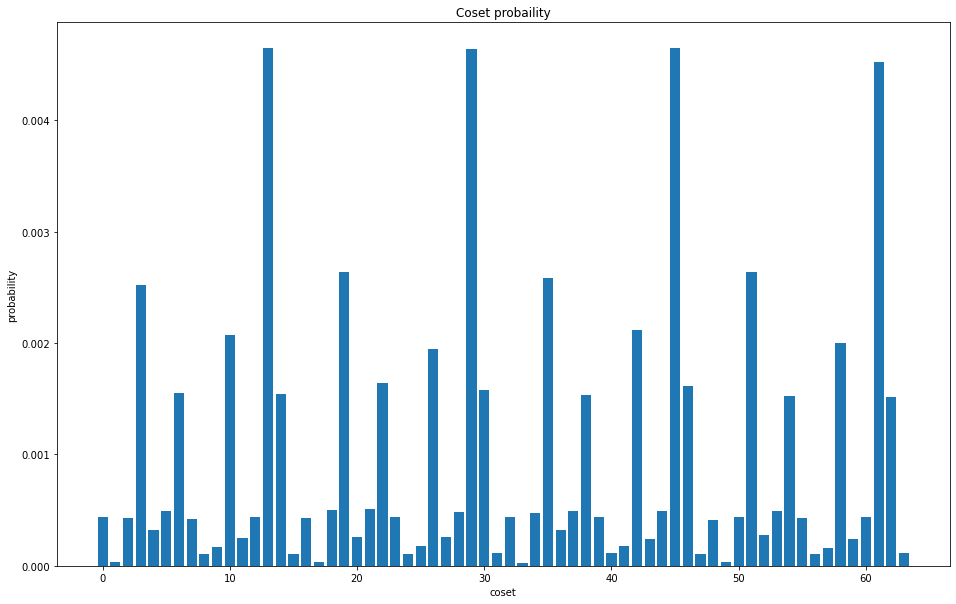

error:  [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 1. 0. 1.]




 Runningtime :  1256.7856919765472 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 1 1 0 0]
 [1 1 0 0 0 1 1 0 1 0]
 [0 1 1 0 0 0 0 1 1 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 1 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 1 0 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.03709717575649238

total probability logical X:  0.0367900689806235

total probability logical Z:  0.03709544558031092

total probability logical Y:  0.03678450392239193

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776719423981874

rate: 0.25105149994447024

correct!


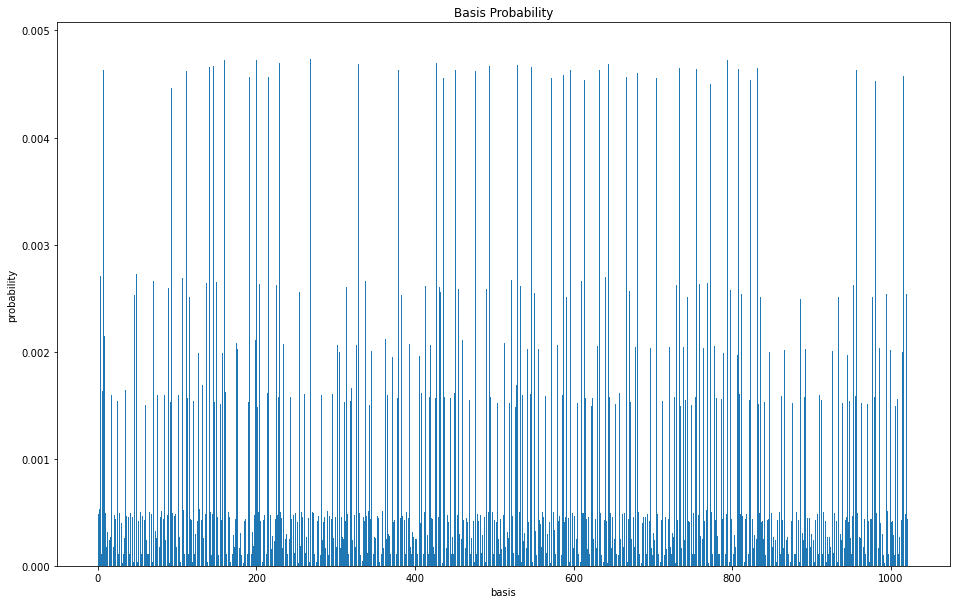

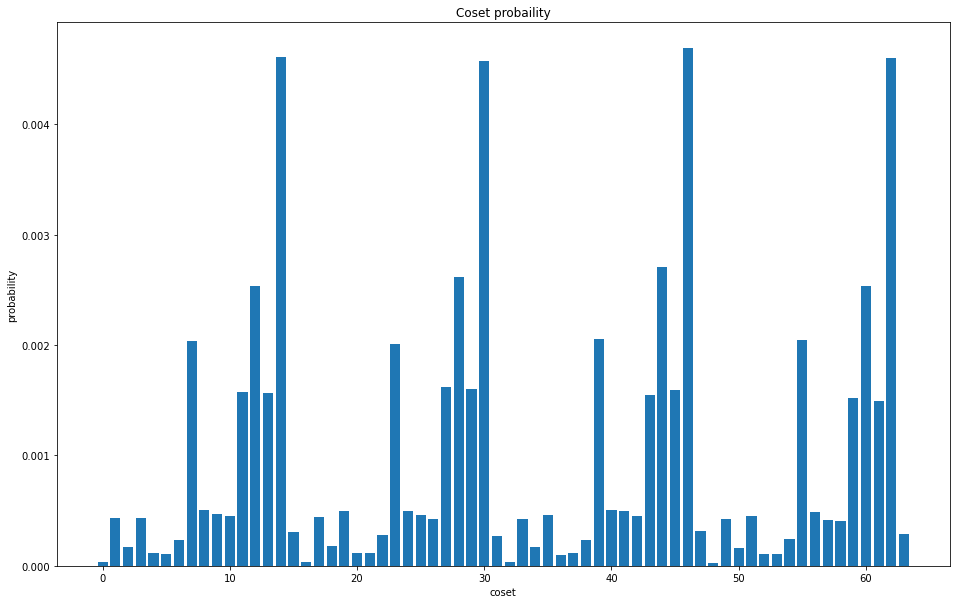

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 1. 1.]




 Runningtime :  1258.2661821842194 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 1 0 0 0 0 1]
 [0 1 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 1 0]
 [0 1 1 1 0 0 1 0 0 0]
 [1 0 1 0 0 1 0 0 0 0]
 [0 1 0 0 1 0 1 0 1 0]
 [0 1 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.03709586093426757

total probability logical X:  0.03678877265573565

total probability logical Z:  0.037097709347301736

total probability logical Y:  0.03678670287214637

 coset without doing anything : 0.005859375

matching syndrome probability 0.14776904580945133

rate: 0.25103945641026065

correct!


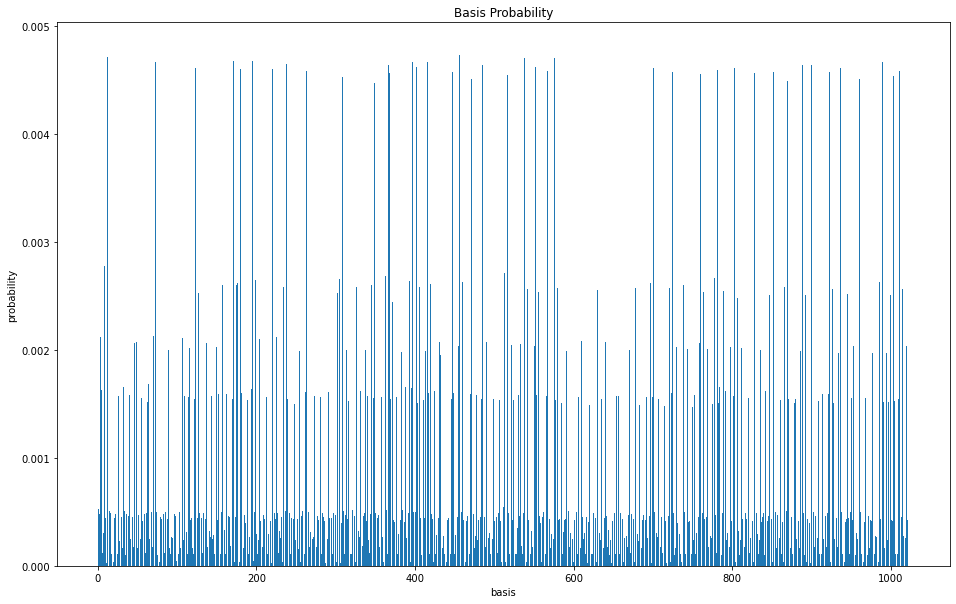

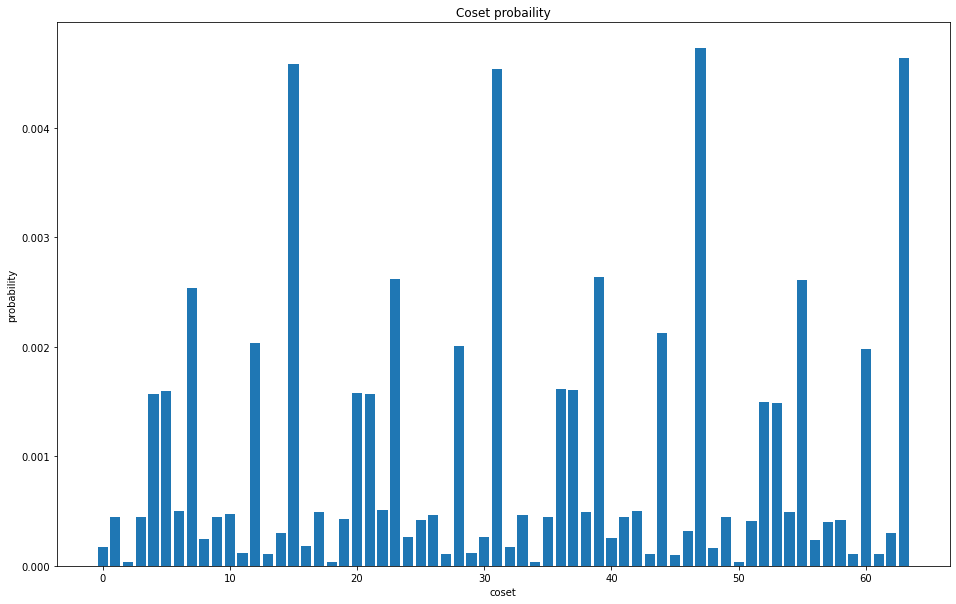

In [9]:
probability = []
gamma = []
beta = []
syndrome = []
cor_rate = []


num = int(M.shape[1]/2)

min_weight_term = min_weight(M.shape[1])
pen = 0.1

good = 0
    

for d in trange(len(err)):
    coset_prob = []
    probability = []
    n = M.shape[1]
    print('error: ', err[d])
    syndr = row_binary(M.dot(err[d]))
    C = (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + pen * min_weight_term
    
    B = B_generator(M.shape[1])
    print('\nsyndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    res = QAOA_finegrid(C,B,n,0.1)
    
    f_p_max_gamma = res[0]
    f_p_max_beta = res[1]
#     print(res[2])
    
    
    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")

    r = np.ones(2**M.shape[1])/np.sqrt(2**M.shape[1])
    #Construct U_C
    
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    
    print('\ngamma:', f_p_max_gamma,'beta:',f_p_max_beta )
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))      

    probability.append(prob)
    max_index = prob_sort(prob,8)


    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print('\nestimate error :\n',(np.array(word)))


    err_8 = []
    for q in range(8):
          err_8.append(err[d])


    check  = matrix_binary(((np.array(word) - np.array(err_8)).dot(L)).dot(G.T))

    print('\ncheck\n' ,check)


    degen_index = []
    degen_x_index = []
    degen_z_index = []
    degen_y_index = []


    for b in range(2**(H_oringin.shape[0]-1)):
        degen_index.append(converter((degenerate_error(err[d], H_oringin)[b])))
        degen_x_index.append(converter((degenerate_error(logical_x_error[d], H_oringin)[b])))
        degen_z_index.append(converter((degenerate_error(logical_z_error[d], H_oringin)[b])))
        degen_y_index.append(converter((degenerate_error(logical_y_error[d], H_oringin)[b])))

    total_prob_I = 0
    total_prob_X = 0
    total_prob_Z = 0
    total_prob_Y = 0



    for c in range(len(degen_index)):
        total_prob_I += (probability[0][degen_index[c]])
        total_prob_X += (probability[0][degen_x_index[c]])
        total_prob_Z += (probability[0][degen_z_index[c]])
        total_prob_Y += (probability[0][degen_y_index[c]])


    print('\ntotal probability logical I: ', total_prob_I)
    print('\ntotal probability logical X: ', total_prob_X)
    print('\ntotal probability logical Z: ', total_prob_Z)
    print('\ntotal probability logical Y: ', total_prob_Y)
    print('\n coset without doing anything :', (H_oringin.shape[0]-1)/2**(M.shape[1]-1 ))
    print('\nmatching syndrome probability', total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y)
    print('\nrate:',  total_prob_I/( total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y))

    if sum(check[0][c] for c in range(len(check[0]))) == 0:
        print("\ncorrect!")
        good +=1
    else:
        print('\ncannot correct')


    
    for q in range(len(coset)):
        for f in range(len(coset[q])):
            c_prob = 0
            c_prob += probability[0][converter(coset[q][f])]
        coset_prob.append(c_prob)
    
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.title('Basis Probability')
    plt.ylabel('probability')
    plt.xlabel('basis')
    plt.show()
    plt.bar(range(0, len(coset_prob)),coset_prob)
    plt.title('Coset probaility')
    plt.ylabel('probability')
    plt.xlabel('coset')
    plt.show()
    time.sleep(0.5)


## QAOA pen is large

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 0.]




 Runningtime :  1886.2481167316437 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 1 0 1 0 0 1]
 [0 0 1 0 1 0 0 1 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1.]
 [0. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1.]
 [1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0.]]

total probability logical I:  0.08796140416101932

total probability logical X:  0.0003016695197273252

total probability logical Z:  0.00033985009489684965

total probability logical Y:  0.008279077041220703

 coset without doing anything : 0.005859375

matching syndrome probability 0.09688200081686418

rate: 0.9079230756938284

correct!


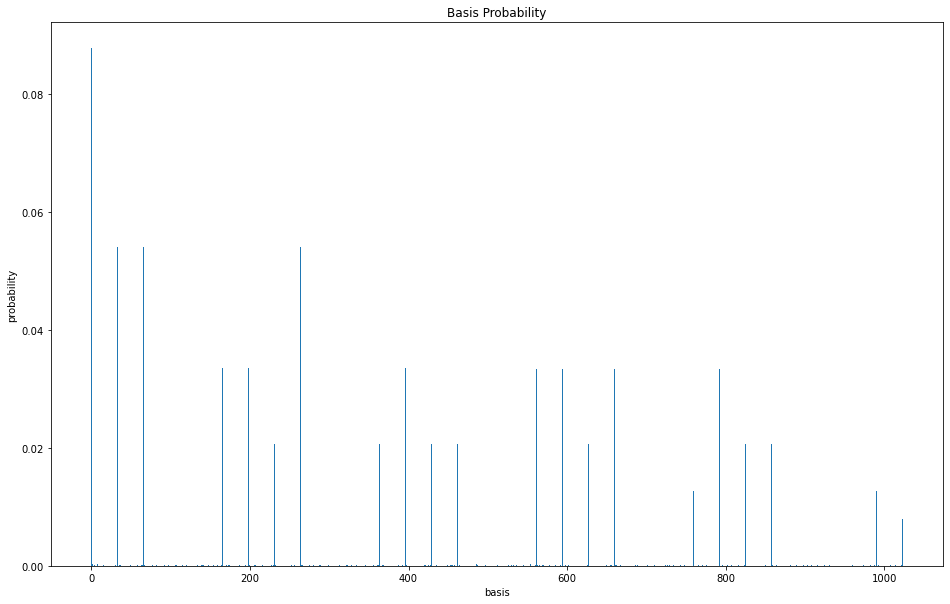

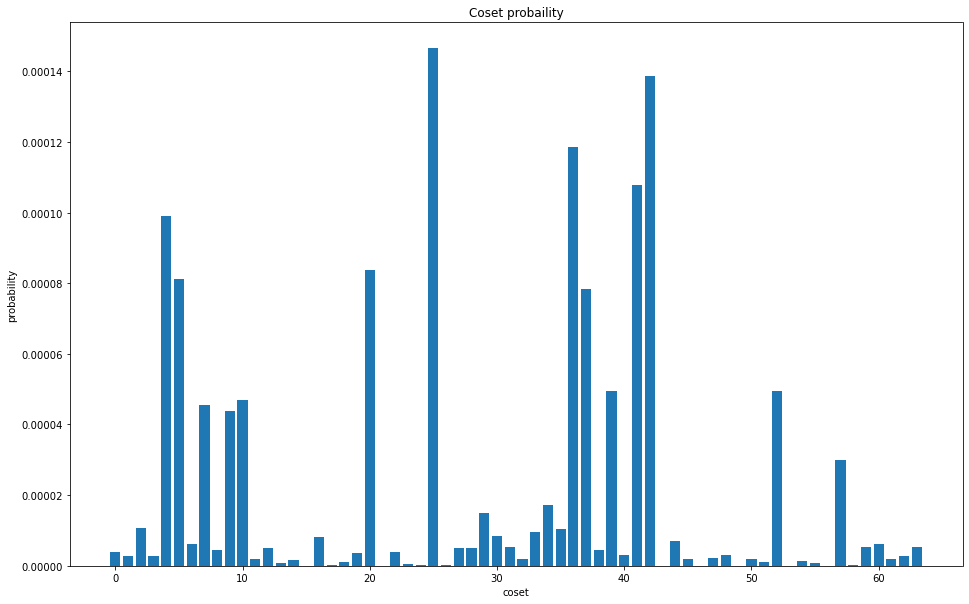

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 1.]




 Runningtime :  1880.3408341407776 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 1 0 1 0 0 1]
 [0 1 0 1 0 0 1 0 1 0]]

check
 [[1. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0.]
 [0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 1. 0. 1.]]

total probability logical I:  0.00033604848836972945

total probability logical X:  0.03359565129586198

total probability logical Z:  0.021038744143393864

total probability logical Y:  0.0003553523850011424

 coset without doing anything : 0.005859375

matching syndrome probability 0.05532579631262672

rate: 0.006073992798419692

cannot correct


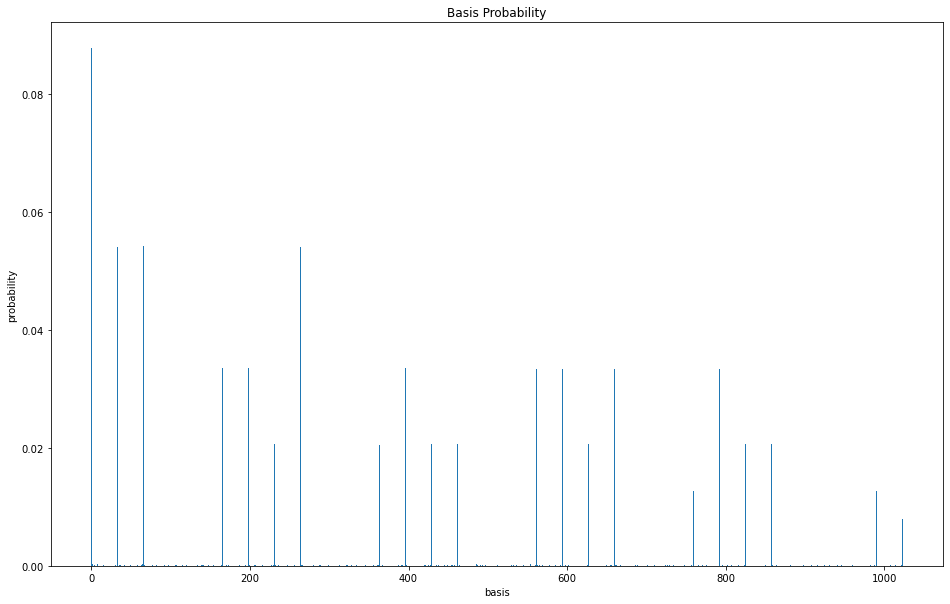

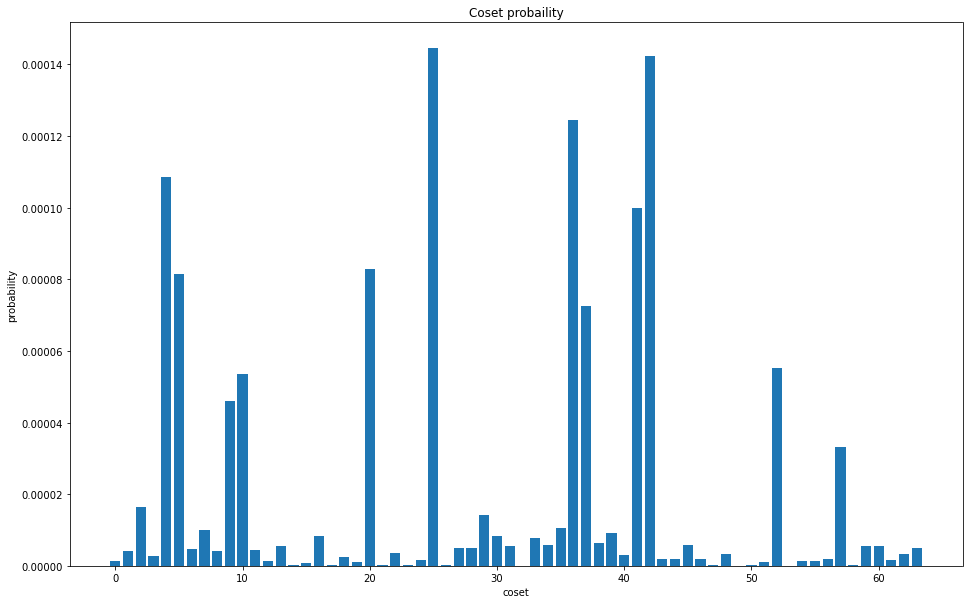

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 0. 1. 0.]




 Runningtime :  1881.2026252746582 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 0 1 0 0 1 0 1 0 0]
 [1 0 0 0 1 1 0 0 0 1]]

check
 [[1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]]

total probability logical I:  0.00036522340497502814

total probability logical X:  3.7450465772765025e-05

total probability logical Z:  0.00015280191186809475

total probability logical Y:  0.000234758931028061

 coset without doing anything : 0.005859375

matching syndrome probability 0.000790234713643949

rate: 0.46217079390362564

cannot correct


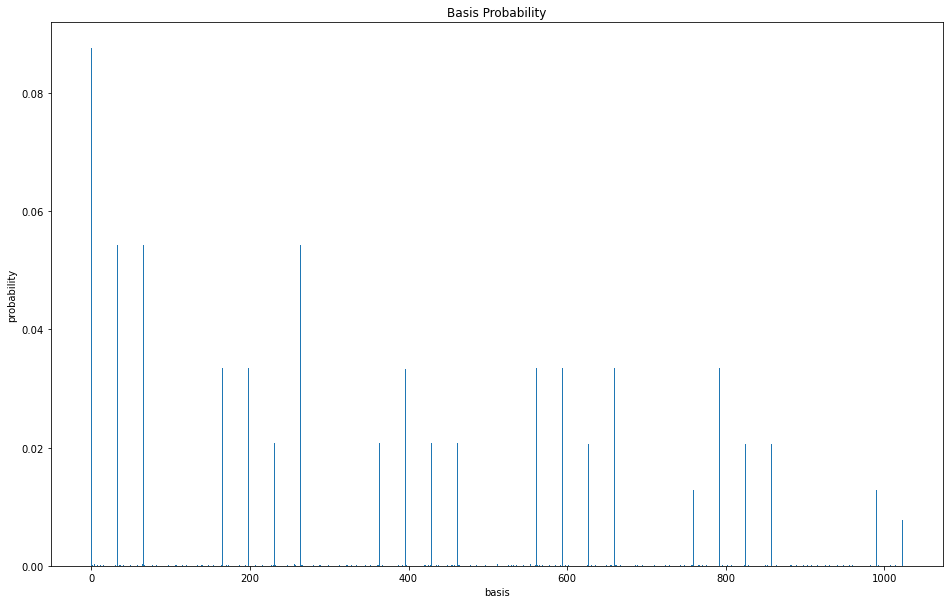

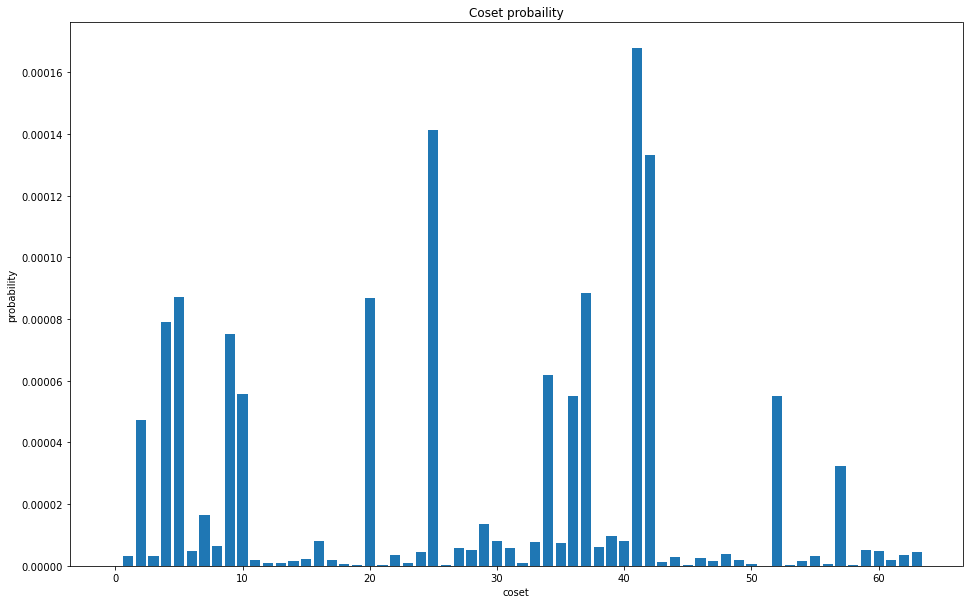

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 1. 1. 0.]




 Runningtime :  1881.9826064109802 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [1 1 0 0 0 1 1 0 0 0]
 [1 0 0 1 0 1 0 0 1 0]]

check
 [[0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 1. 0.]
 [1. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 0. 1.]]

total probability logical I:  0.00039255906458973775

total probability logical X:  0.03364312540084243

total probability logical Z:  0.020938815309290593

total probability logical Y:  0.00025077514006975913

 coset without doing anything : 0.005859375

matching syndrome probability 0.05522527491479252

rate: 0.007108322506233242

cannot correct


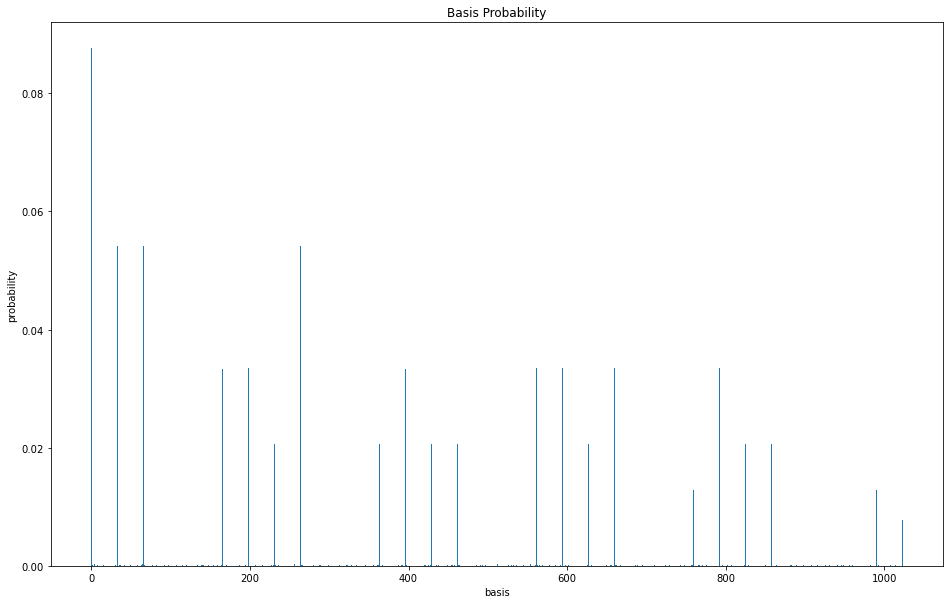

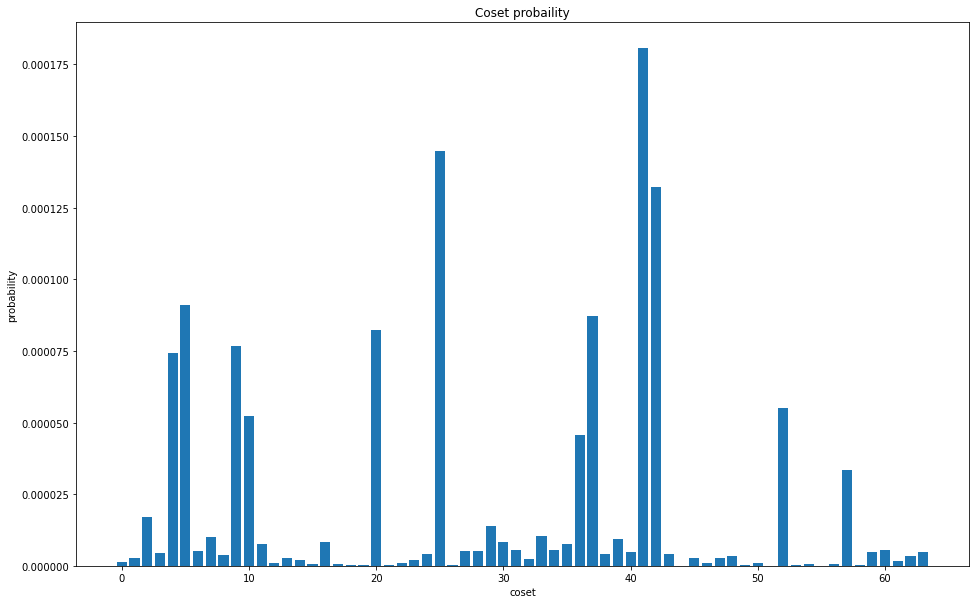

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 1. 1. 0.]




 Runningtime :  1880.1893663406372 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 1 1 0 0 0 1]
 [1 0 1 0 0 1 0 1 0 0]]

check
 [[1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 1. 0. 1.]]

total probability logical I:  0.0003720799733344113

total probability logical X:  0.03365264978000815

total probability logical Z:  0.02093279236704813

total probability logical Y:  0.0002643006872770518

 coset without doing anything : 0.005859375

matching syndrome probability 0.05522182280766774

rate: 0.006737915454734803

cannot correct


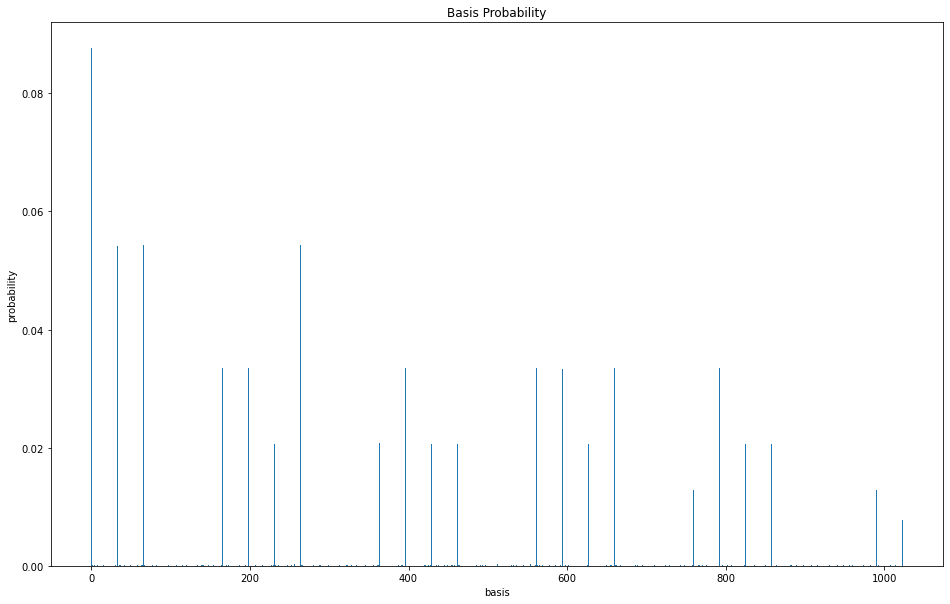

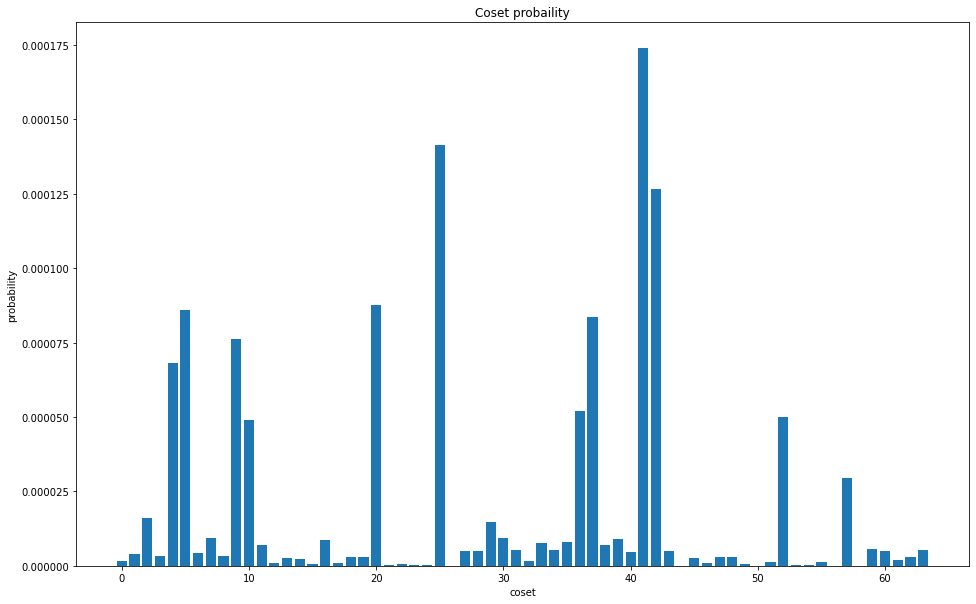

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 1. 1.]




 Runningtime :  1883.9868025779724 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 1 0 0 0 1 1 0 0 0]
 [1 0 0 1 0 1 0 0 1 0]]

check
 [[1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 1.]
 [0. 1. 1. 0. 0. 1.]]

total probability logical I:  0.0003551916553302402

total probability logical X:  9.322401810348296e-05

total probability logical Z:  6.37607475970561e-05

total probability logical Y:  0.00021051973778269265

 coset without doing anything : 0.005859375

matching syndrome probability 0.0007226961588134719

rate: 0.4914813106429078

cannot correct


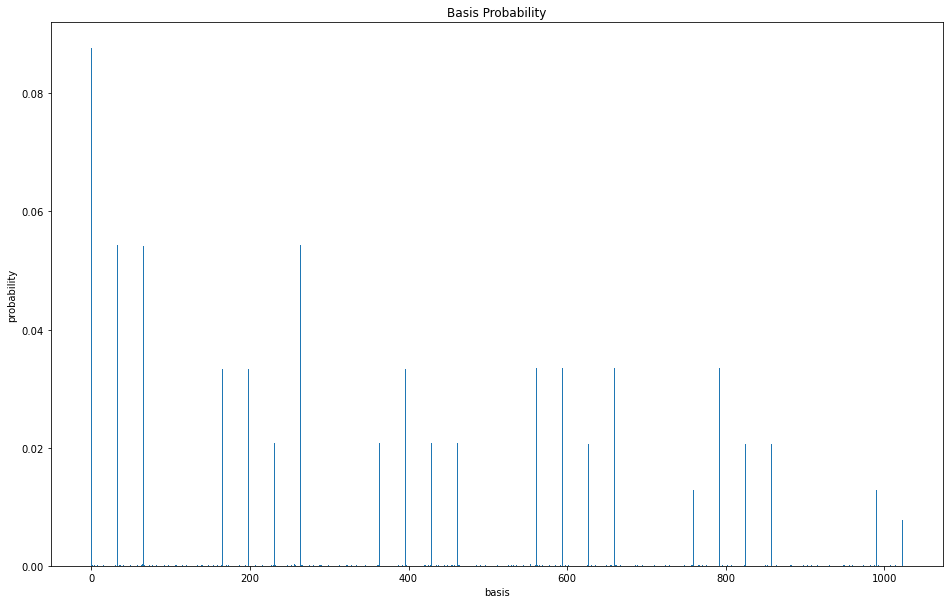

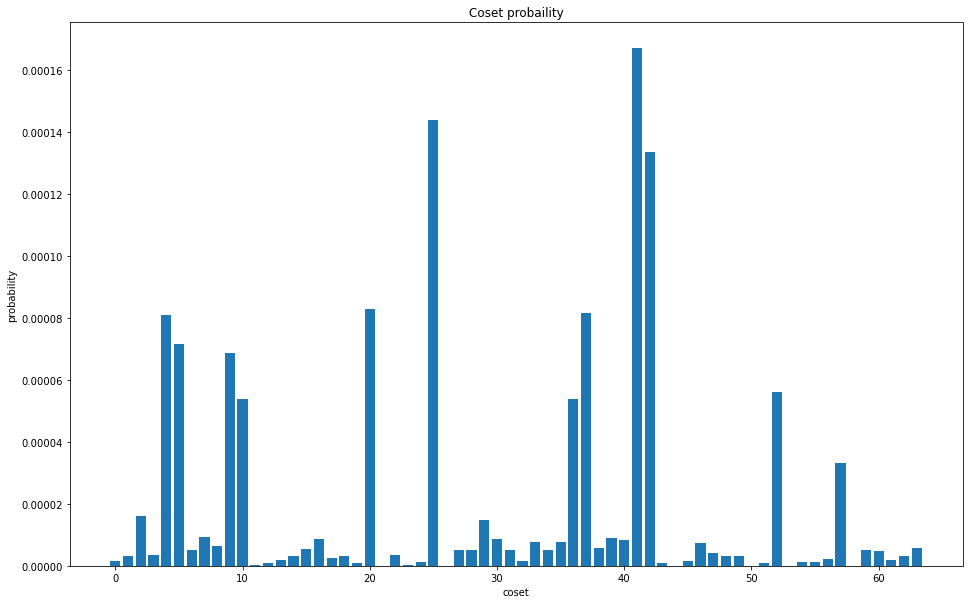

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 0.]




 Runningtime :  1882.84747838974 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 1 1 0]
 [0 1 1 0 0 0 1 1 0 0]]

check
 [[1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]

total probability logical I:  0.0004087367259665782

total probability logical X:  0.020760531819219084

total probability logical Z:  0.03388700608752687

total probability logical Y:  0.0002382740823863114

 coset without doing anything : 0.005859375

matching syndrome probability 0.05529454871509885

rate: 0.00739198954444071

cannot correct


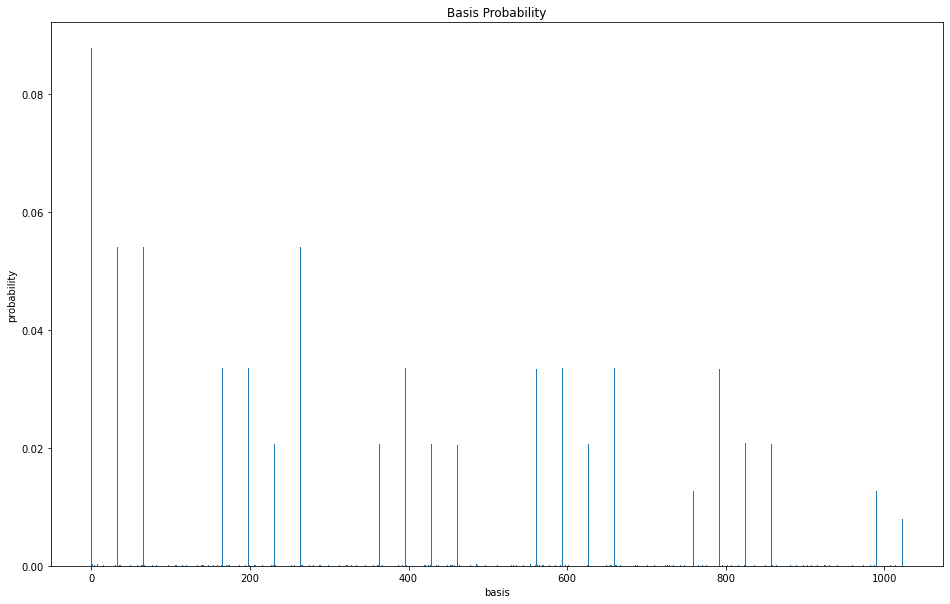

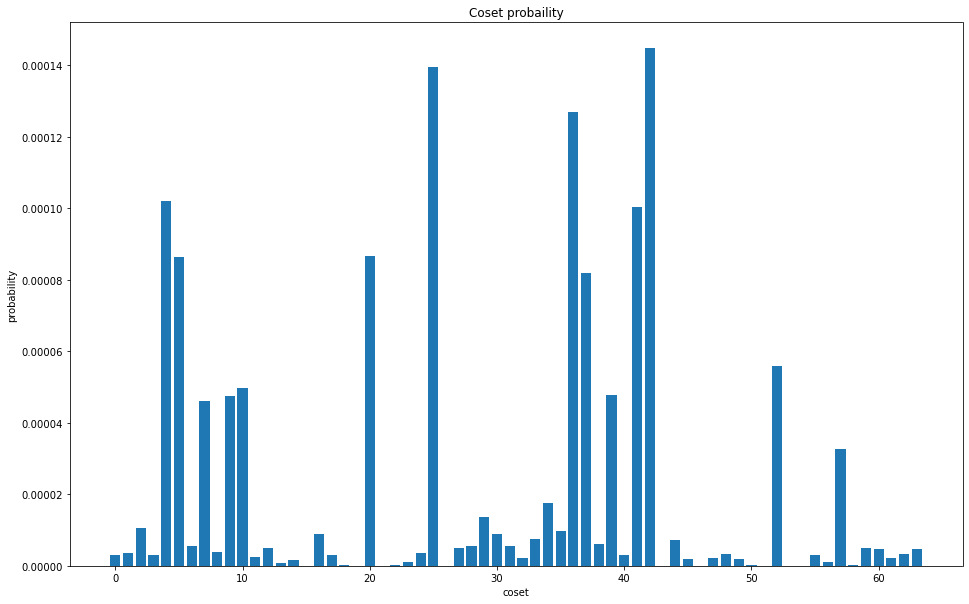

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [0. 1. 0. 1.]




 Runningtime :  1882.7277145385742 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 0 1 1 0 0 0 1 1]
 [0 0 1 0 1 0 0 1 0 1]]

check
 [[0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0.]]

total probability logical I:  0.00043049589087191116

total probability logical X:  5.884406638447229e-05

total probability logical Z:  9.045191802829378e-05

total probability logical Y:  0.00019193967050884603

 coset without doing anything : 0.005859375

matching syndrome probability 0.0007717315457935232

rate: 0.5578311437680822

cannot correct


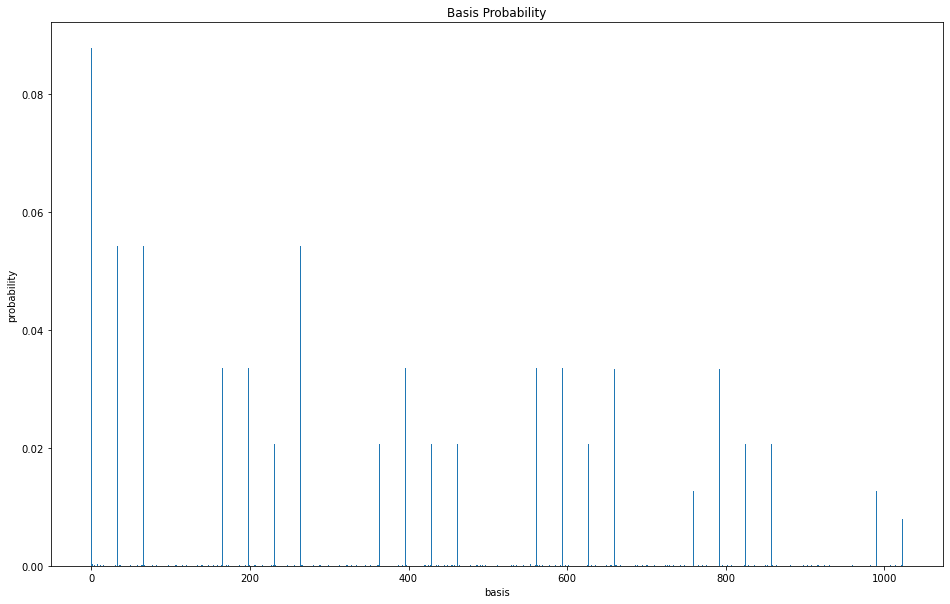

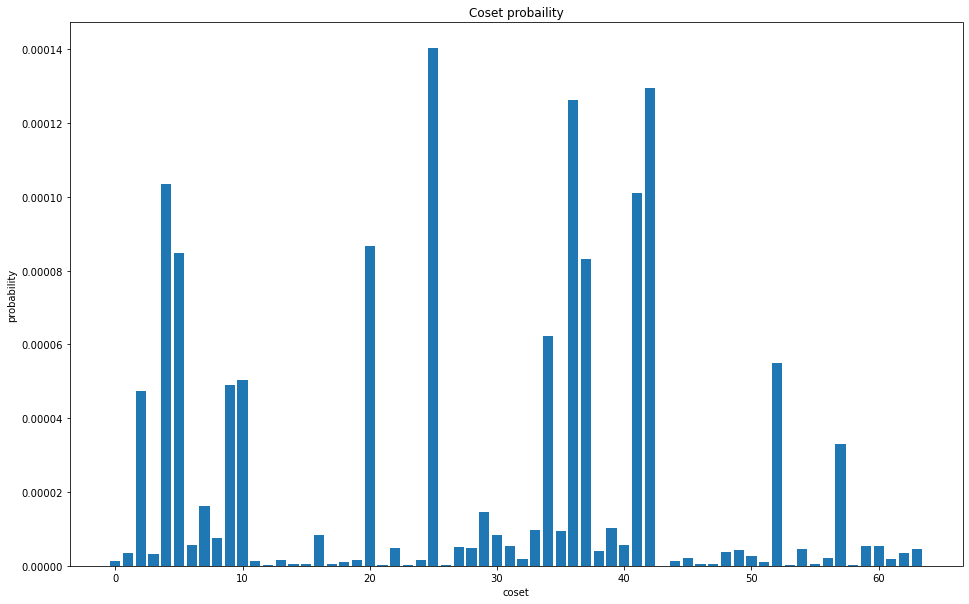

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [0. 0. 1. 0.]




 Runningtime :  1880.8338060379028 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 1 1 0 0 0 1]
 [1 1 0 0 0 1 1 0 0 0]]

check
 [[0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1.]
 [1. 1. 1. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0.]]

total probability logical I:  0.00039734400988550035

total probability logical X:  0.020754054788802847

total probability logical Z:  0.033613227195374976

total probability logical Y:  0.00027666483072933307

 coset without doing anything : 0.005859375

matching syndrome probability 0.05504129082479266

rate: 0.007219016922228897

cannot correct


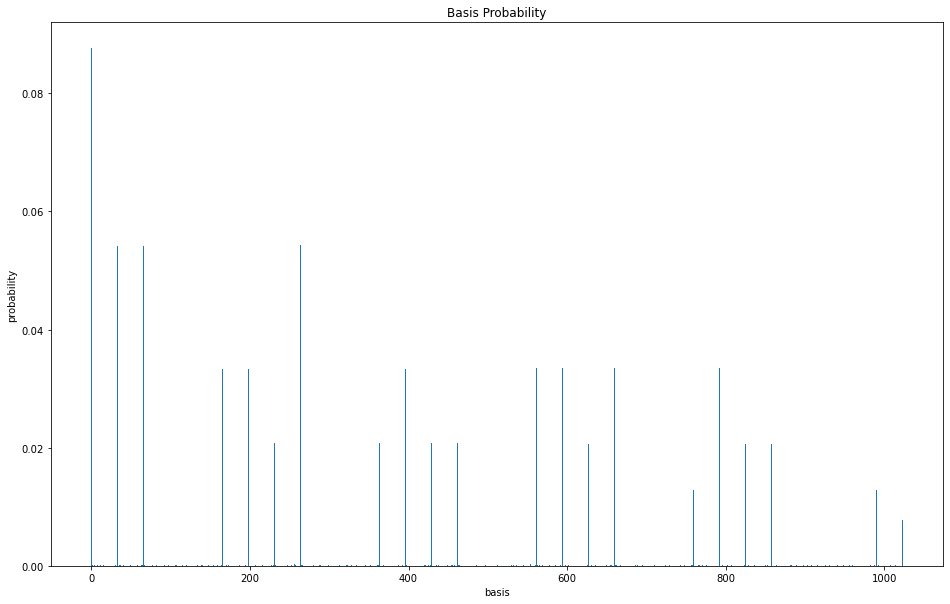

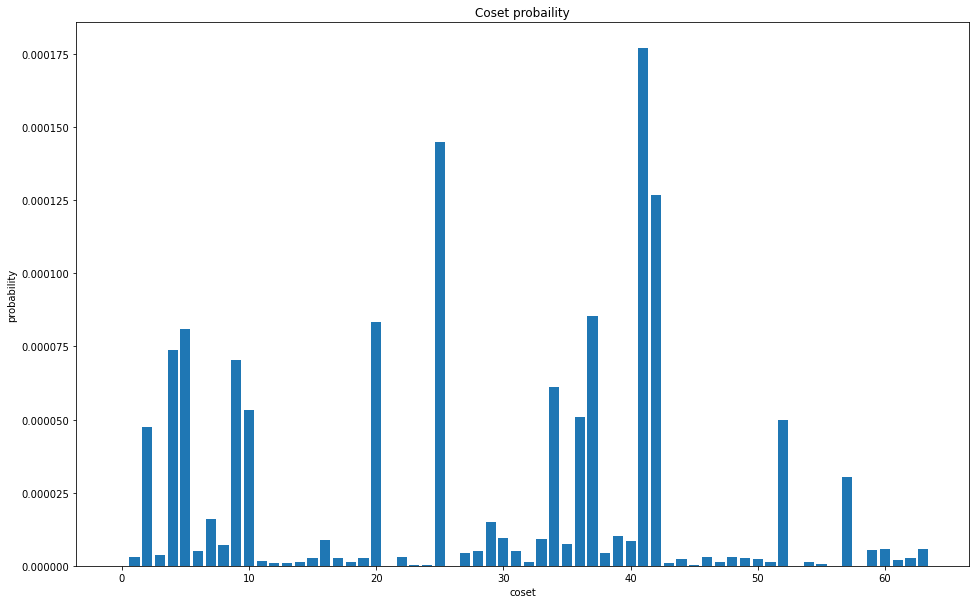

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 0. 1. 1.]




 Runningtime :  1883.1085419654846 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 1 0 0 0 1 1 0 0 0]
 [1 0 1 0 0 1 0 1 0 0]]

check
 [[0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 1.]
 [1. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 1. 0.]]

total probability logical I:  0.000382008430620746

total probability logical X:  0.020863481291125544

total probability logical Z:  0.033574929944459694

total probability logical Y:  0.00028692138611713863

 coset without doing anything : 0.005859375

matching syndrome probability 0.05510734105232313

rate: 0.006932078799774389

cannot correct


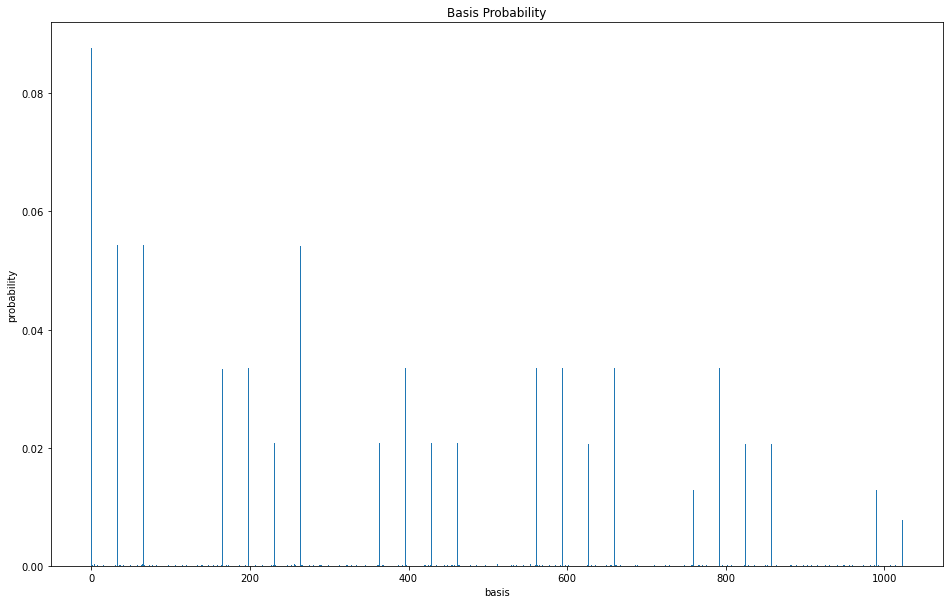

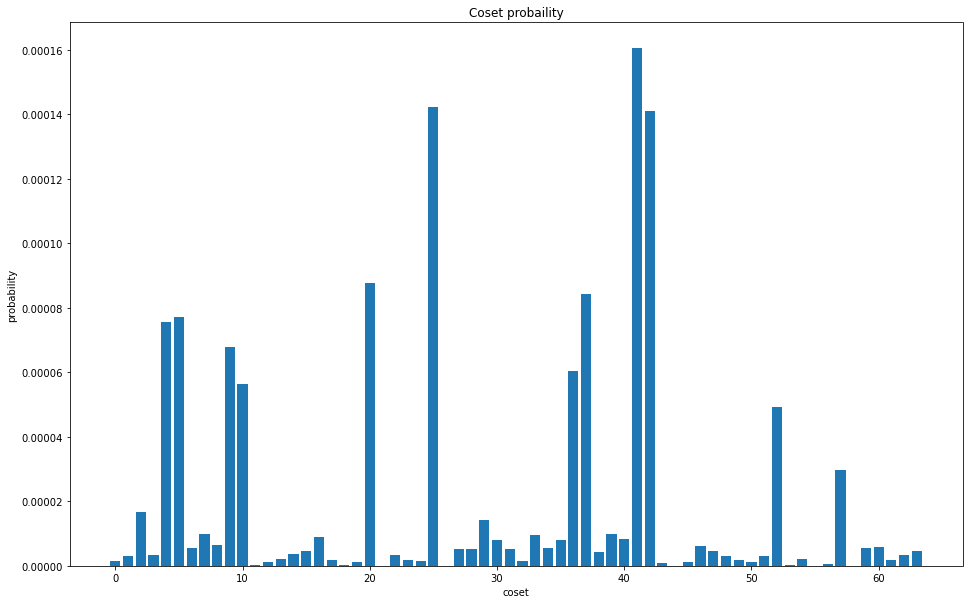

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 0. 0.]




 Runningtime :  1885.420398235321 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 1 1 0 0 0 1 1 0 0]
 [0 1 0 0 1 0 1 0 0 1]]

check
 [[1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 0.]]

total probability logical I:  0.000415385699738423

total probability logical X:  6.044060941553499e-05

total probability logical Z:  9.41123142544649e-05

total probability logical Y:  0.0001636961576885446

 coset without doing anything : 0.005859375

matching syndrome probability 0.0007336347810969675

rate: 0.5662022990749123

cannot correct


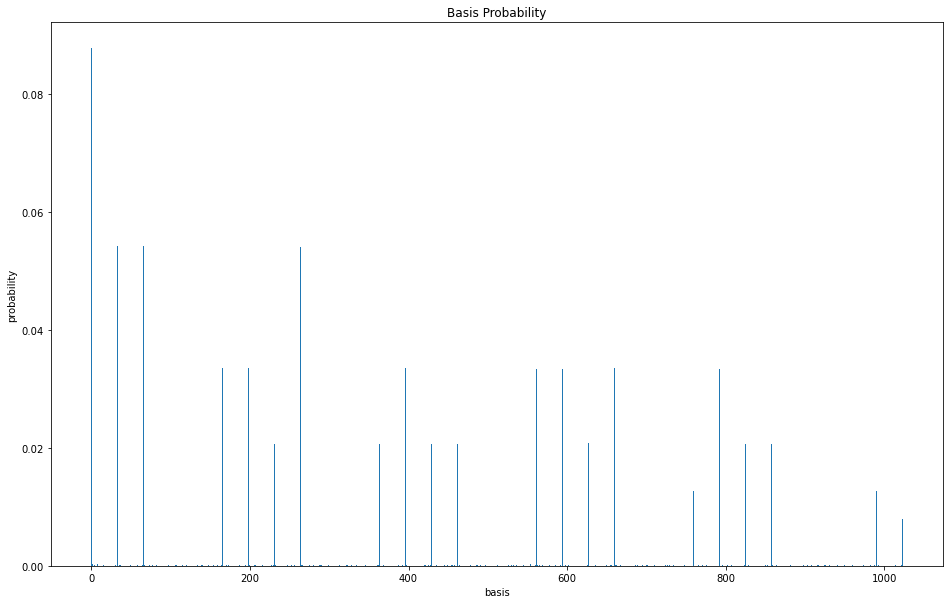

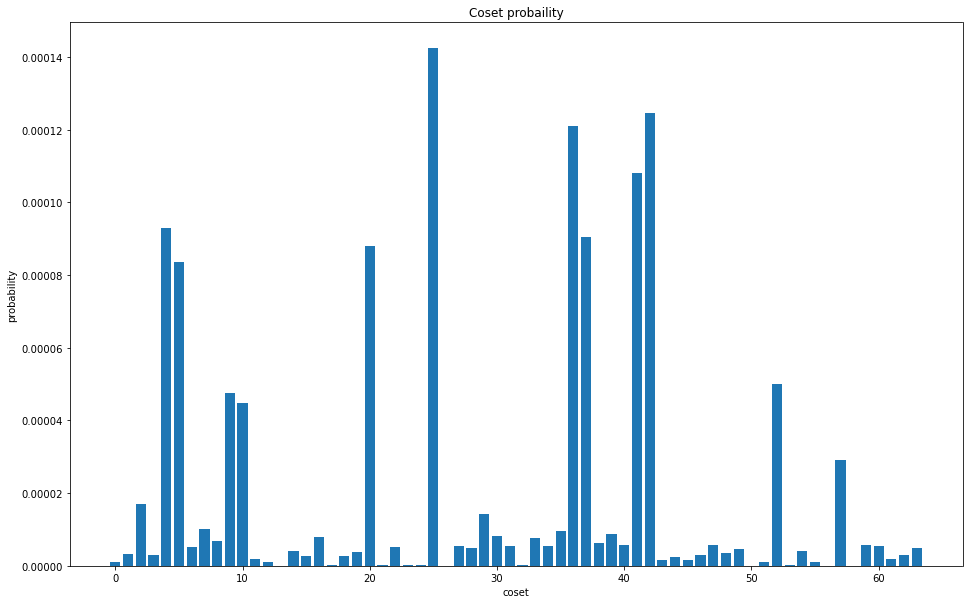

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 1.]




 Runningtime :  1886.5948419570923 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 1 0 0 0]
 [0 1 0 0 1 0 1 0 0 1]
 [0 1 1 0 0 0 1 1 0 0]]

check
 [[0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1.]]

total probability logical I:  0.0543215044431762

total probability logical X:  0.0004362832286808791

total probability logical Z:  0.0002415940961115678

total probability logical Y:  0.013247745151516142

 coset without doing anything : 0.005859375

matching syndrome probability 0.06824712691948479

rate: 0.7959529857903399

cannot correct


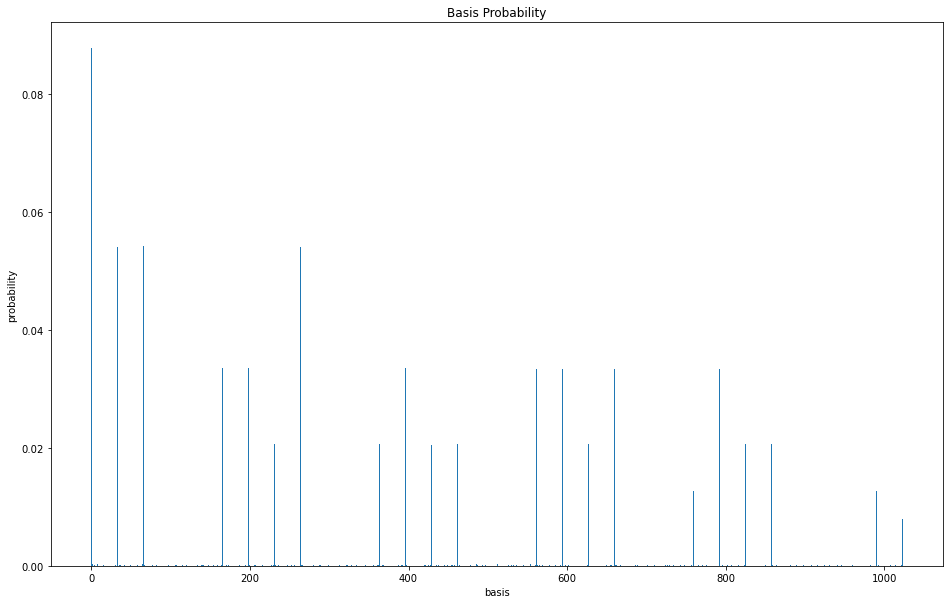

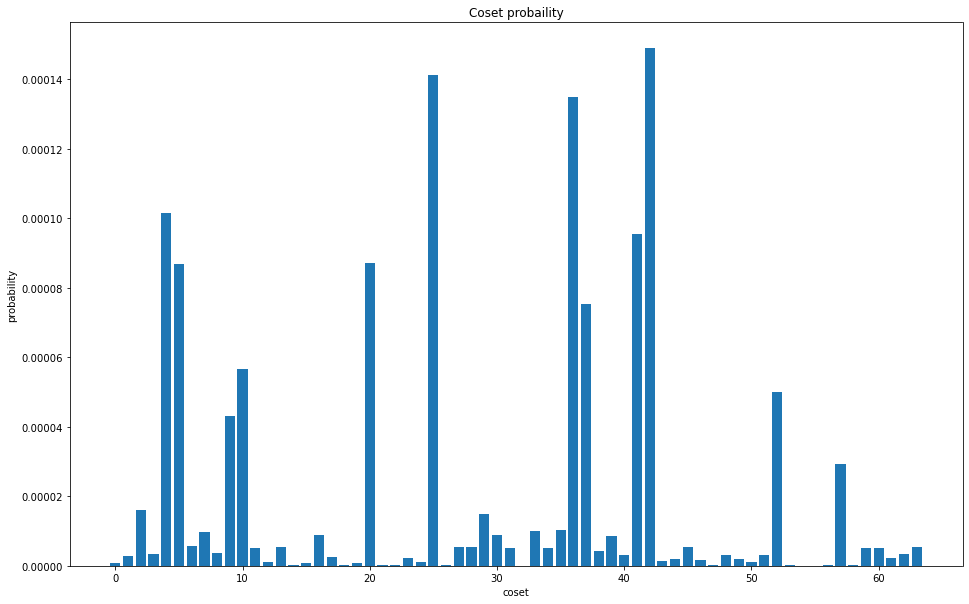

error:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [1. 1. 1. 1.]




 Runningtime :  1888.1654028892517 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 1 0 0 0 1 1 0 0 0]
 [1 0 0 0 1 1 0 0 0 1]]

check
 [[1. 1. 1. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1.]]

total probability logical I:  0.05437308804313589

total probability logical X:  0.0002541433373313083

total probability logical Z:  0.0003383146884089477

total probability logical Y:  0.012972631744087677

 coset without doing anything : 0.005859375

matching syndrome probability 0.06793817781296382

rate: 0.8003318574841218

cannot correct


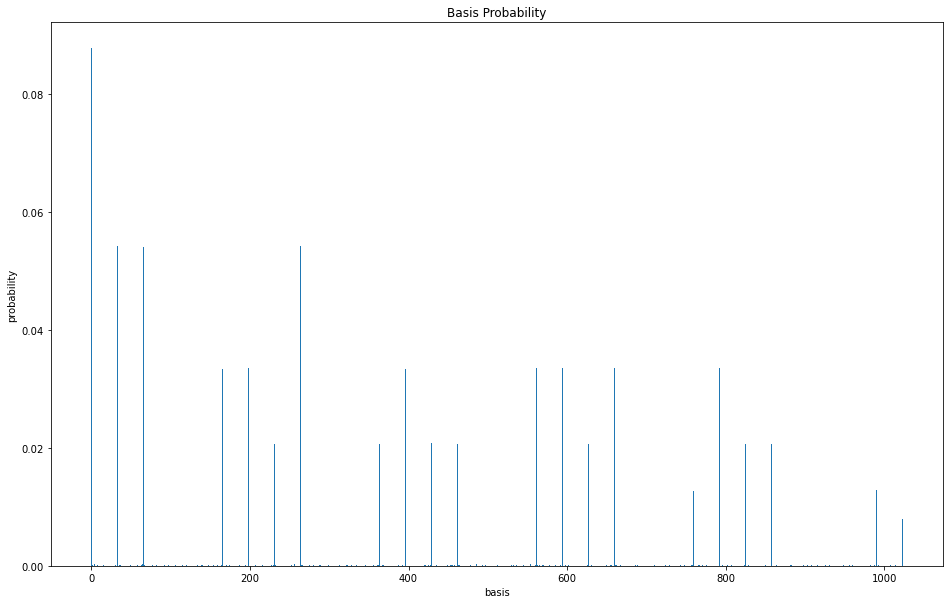

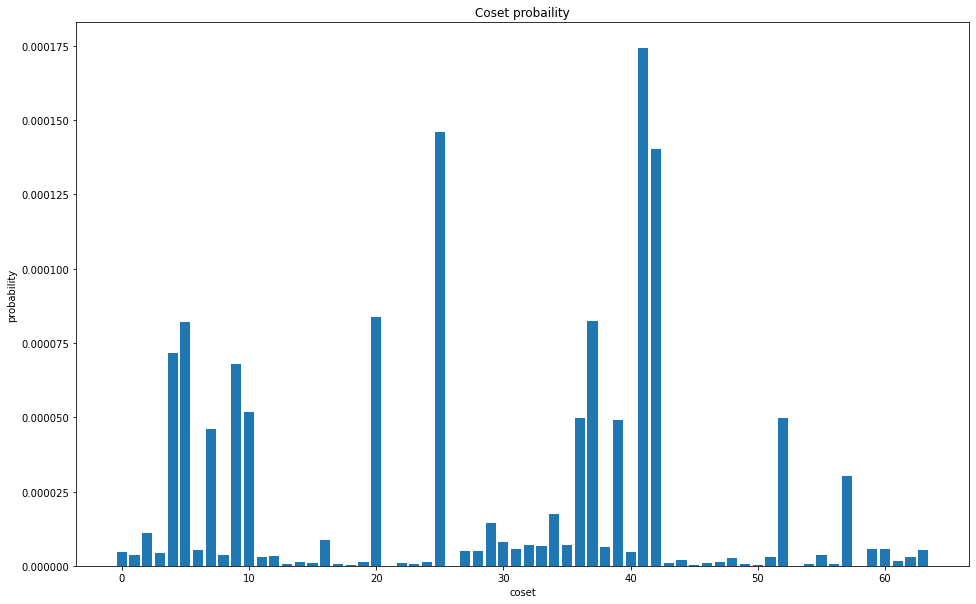

error:  [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [1. 1. 0. 0.]




 Runningtime :  1891.9263043403625 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 1 0 1 0 0 1 0 1 0]
 [0 1 1 0 0 0 1 1 0 0]]

check
 [[0. 1. 1. 1. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1.]]

total probability logical I:  0.05422832335106742

total probability logical X:  0.00028264836011651585

total probability logical Z:  0.0002799573567774054

total probability logical Y:  0.01309912676321057

 coset without doing anything : 0.005859375

matching syndrome probability 0.06789005583117191

rate: 0.798766810354696

cannot correct


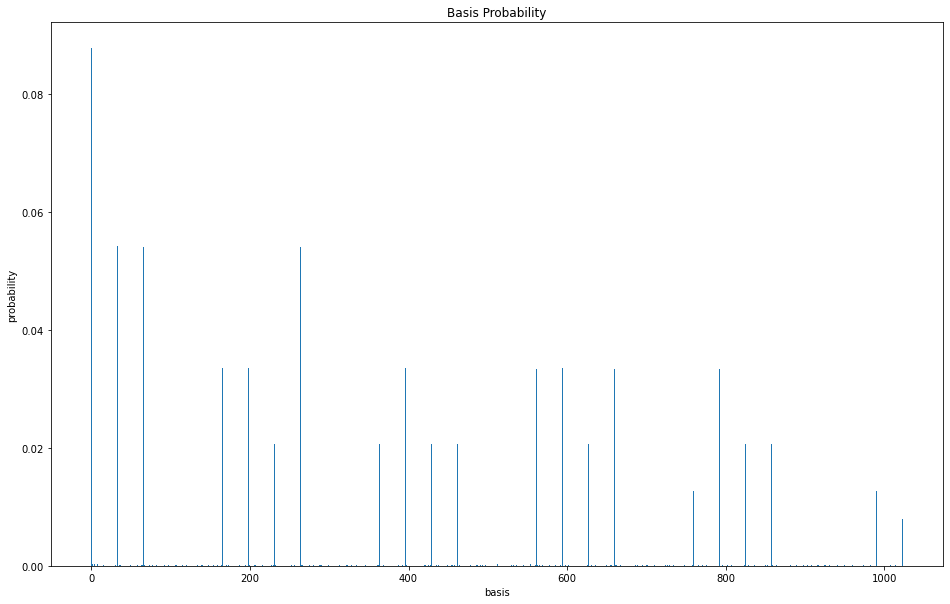

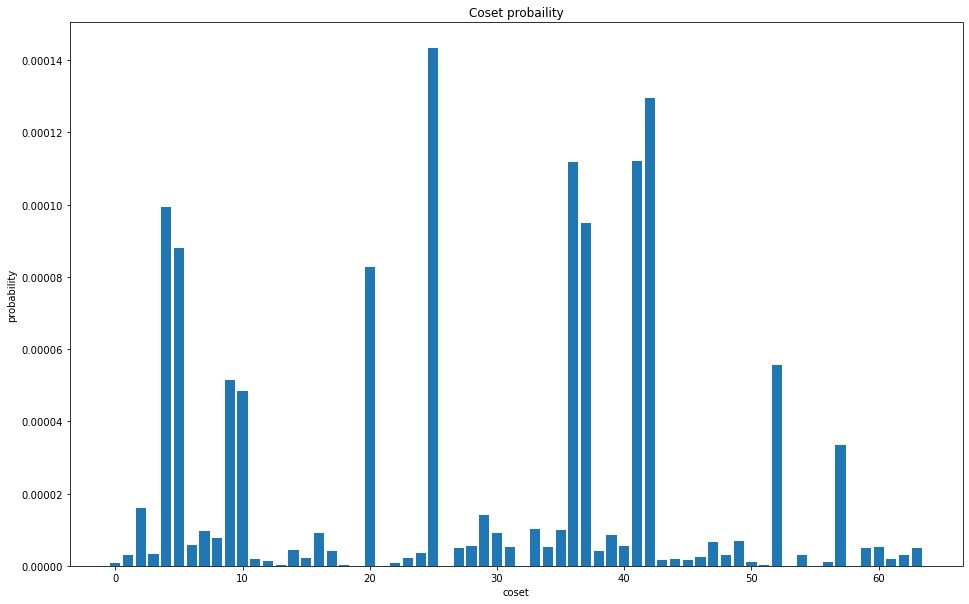

error:  [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 1. 0. 1.]




 Runningtime :  1883.2562563419342 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 1 0 1 0 0 1]
 [0 0 0 1 1 0 0 0 1 1]]

check
 [[1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1.]]

total probability logical I:  0.054224644629672684

total probability logical X:  0.00027526515969602785

total probability logical Z:  0.00029846440531915906

total probability logical Y:  0.012938965368639381

 coset without doing anything : 0.005859375

matching syndrome probability 0.06773733956332725

rate: 0.8005133502324574

cannot correct


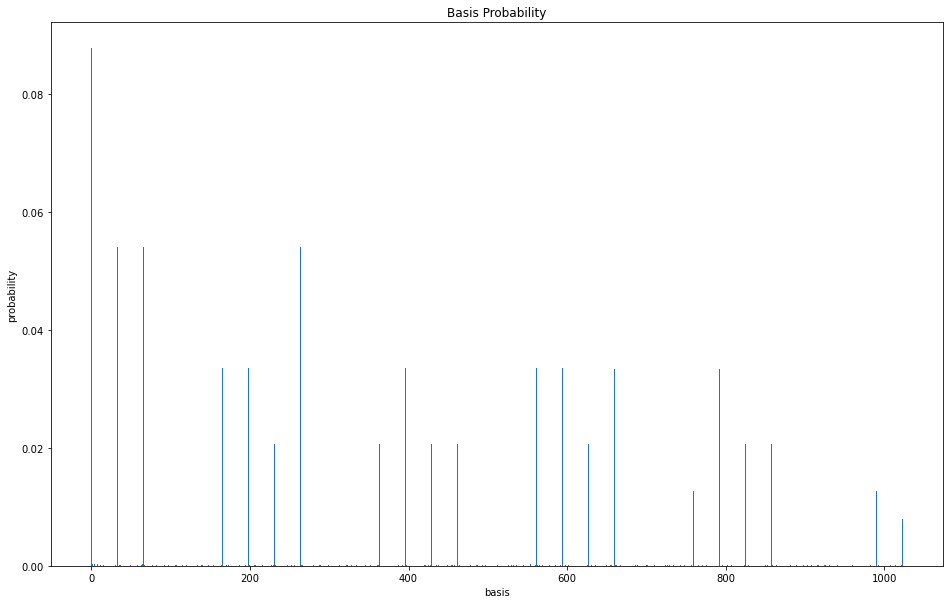

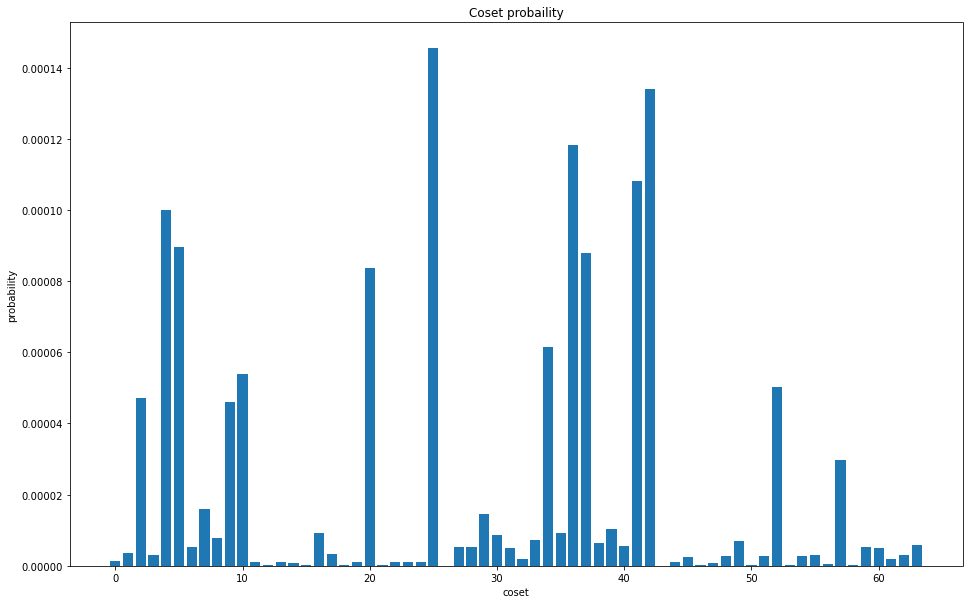

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 1. 1.]




 Runningtime :  1886.306044101715 sec

gamma: 1.6 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [1 0 0 1 0 1 0 0 1 0]
 [0 0 1 1 0 0 0 1 1 0]]

check
 [[0. 1. 1. 0. 1. 1.]
 [1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [1. 1. 0. 1. 0. 1.]]

total probability logical I:  0.05443270666596627

total probability logical X:  0.00026888105509945826

total probability logical Z:  0.0003236810439604925

total probability logical Y:  0.013000647267089452

 coset without doing anything : 0.005859375

matching syndrome probability 0.06802591603211568

rate: 0.8001760188024234

cannot correct


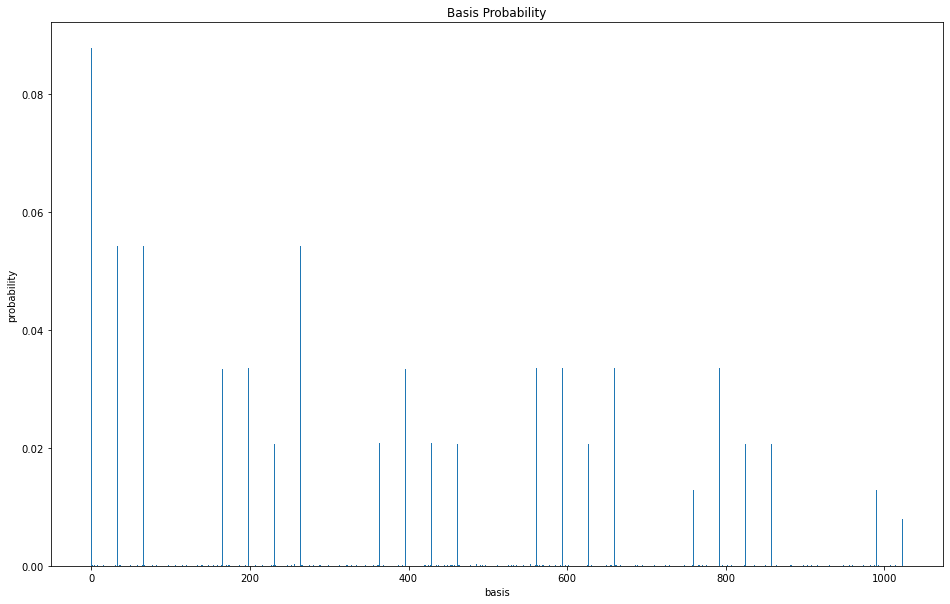

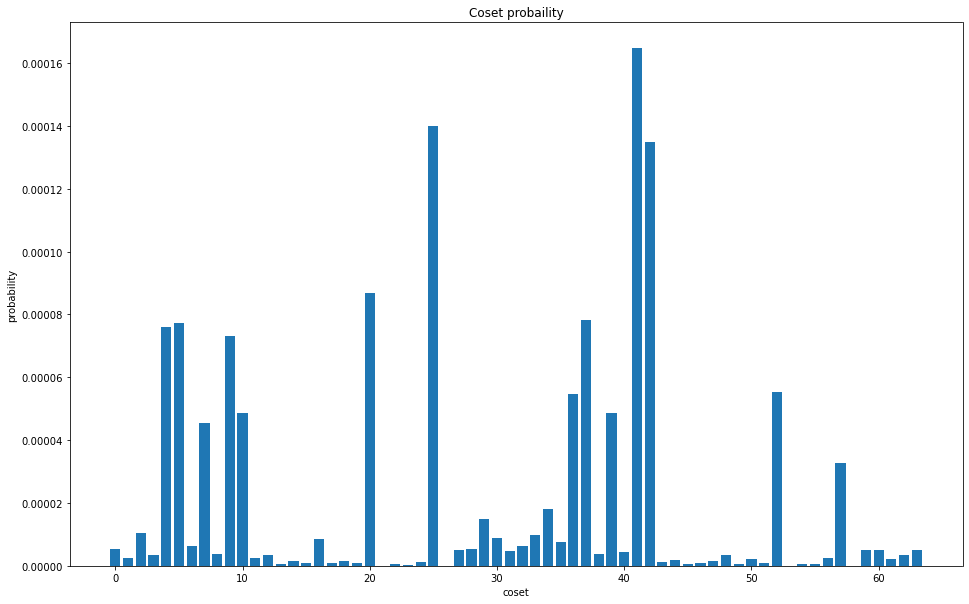

In [10]:
probability = []
gamma = []
beta = []
syndrome = []
cor_rate = []


num = int(M.shape[1]/2)

min_weight_term = min_weight(M.shape[1])
pen = 100000

good = 0
    

for d in trange(len(err)):
    coset_prob = []
    probability = []
    n = M.shape[1]
    print('error: ', err[d])
    syndr = row_binary(M.dot(err[d]))
    C = (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + pen * min_weight_term
    
    B = B_generator(M.shape[1])
    print('\nsyndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    res = QAOA_finegrid(C,B,n,0.1)
    
    f_p_max_gamma = res[0]
    f_p_max_beta = res[1]
#     print(res[2])
    
    
    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")

    r = np.ones(2**M.shape[1])/np.sqrt(2**M.shape[1])
    #Construct U_C
    
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    
    print('\ngamma:', f_p_max_gamma,'beta:',f_p_max_beta )
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))      

    probability.append(prob)
    max_index = prob_sort(prob,8)


    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print('\nestimate error :\n',(np.array(word)))


    err_8 = []
    for q in range(8):
          err_8.append(err[d])


    check  = matrix_binary(((np.array(word) - np.array(err_8)).dot(L)).dot(G.T))

    print('\ncheck\n' ,check)


    degen_index = []
    degen_x_index = []
    degen_z_index = []
    degen_y_index = []


    for b in range(2**(H_oringin.shape[0]-1)):
        degen_index.append(converter((degenerate_error(err[d], H_oringin)[b])))
        degen_x_index.append(converter((degenerate_error(logical_x_error[d], H_oringin)[b])))
        degen_z_index.append(converter((degenerate_error(logical_z_error[d], H_oringin)[b])))
        degen_y_index.append(converter((degenerate_error(logical_y_error[d], H_oringin)[b])))

    total_prob_I = 0
    total_prob_X = 0
    total_prob_Z = 0
    total_prob_Y = 0



    for c in range(len(degen_index)):
        total_prob_I += (probability[0][degen_index[c]])
        total_prob_X += (probability[0][degen_x_index[c]])
        total_prob_Z += (probability[0][degen_z_index[c]])
        total_prob_Y += (probability[0][degen_y_index[c]])


    print('\ntotal probability logical I: ', total_prob_I)
    print('\ntotal probability logical X: ', total_prob_X)
    print('\ntotal probability logical Z: ', total_prob_Z)
    print('\ntotal probability logical Y: ', total_prob_Y)
    print('\n coset without doing anything :', (H_oringin.shape[0]-1)/2**(M.shape[1]-1 ))
    print('\nmatching syndrome probability', total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y)
    print('\nrate:',  total_prob_I/( total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y))

    if sum(check[0][c] for c in range(len(check[0]))) == 0:
        print("\ncorrect!")
        good +=1
    else:
        print('\ncannot correct')


    
    for q in range(len(coset)):
        for f in range(len(coset[q])):
            c_prob = 0
            c_prob += probability[0][converter(coset[q][f])]
        coset_prob.append(c_prob)
    
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.title('Basis Probability')
    plt.ylabel('probability')
    plt.xlabel('basis')
    plt.show()
    plt.bar(range(0, len(coset_prob)),coset_prob)
    plt.title('Coset probaility')
    plt.ylabel('probability')
    plt.xlabel('coset')
    plt.show()
    time.sleep(0.5)


## QAOA pen = 0

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 0.]




 Runningtime :  1263.8689522743225 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 1 0 0 0 1 1 1 0 1]
 [1 0 0 1 1 0 0 0 0 1]
 [1 0 1 1 0 0 0 1 1 0]
 [1 1 0 1 0 1 1 0 0 0]
 [1 0 1 0 0 1 1 1 0 0]
 [1 0 0 1 0 1 0 0 1 1]
 [1 0 1 1 0 1 1 0 0 1]
 [1 0 0 0 1 1 1 0 1 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.03838818051957026

total probability logical X:  0.038388180519570325

total probability logical Z:  0.03838818051957028

total probability logical Y:  0.03838818051957033

 coset without doing anything : 0.005859375

matching syndrome probability 0.1535527220782812

rate: 0.24999999999999978

correct!


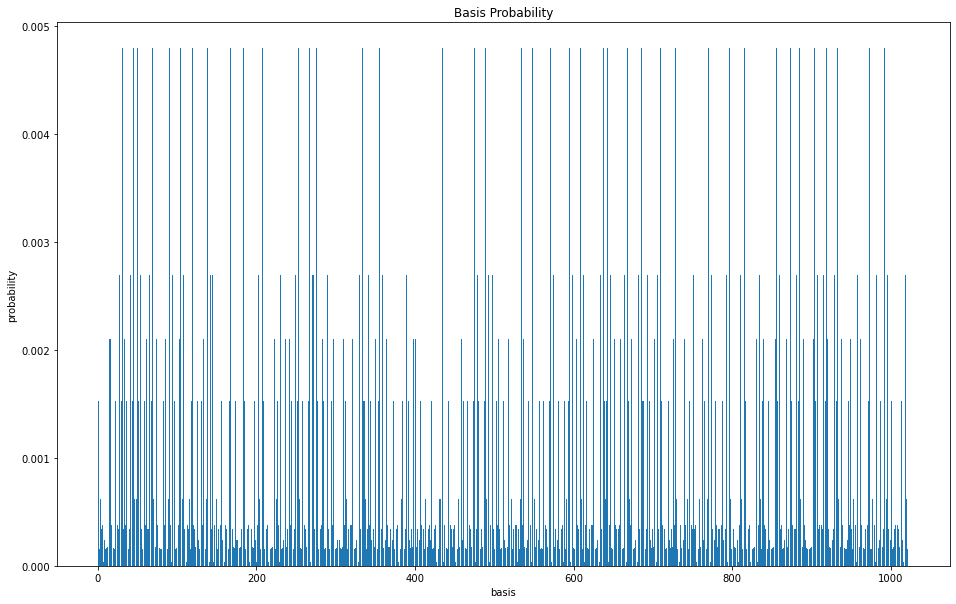

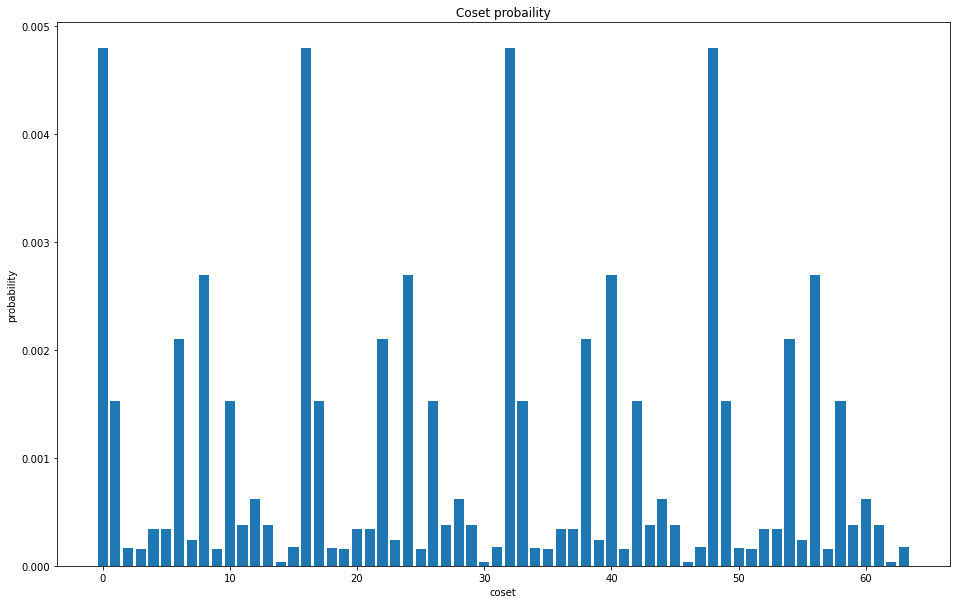

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 1.]




 Runningtime :  1268.5227000713348 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 0 1 1 1 0 0 0 1 0]
 [1 1 0 0 0 0 1 0 1 1]
 [0 1 0 0 0 1 1 1 0 1]
 [1 0 1 1 0 1 0 0 0 0]
 [1 0 0 1 0 0 0 1 0 1]
 [1 1 0 0 0 1 0 1 0 0]
 [1 0 1 0 1 0 0 1 1 1]
 [1 0 0 0 1 1 0 0 1 0]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.03838818051957032

total probability logical X:  0.03838818051957026

total probability logical Z:  0.038388180519570325

total probability logical Y:  0.03838818051957028

 coset without doing anything : 0.005859375

matching syndrome probability 0.1535527220782812

rate: 0.2500000000000001

cannot correct


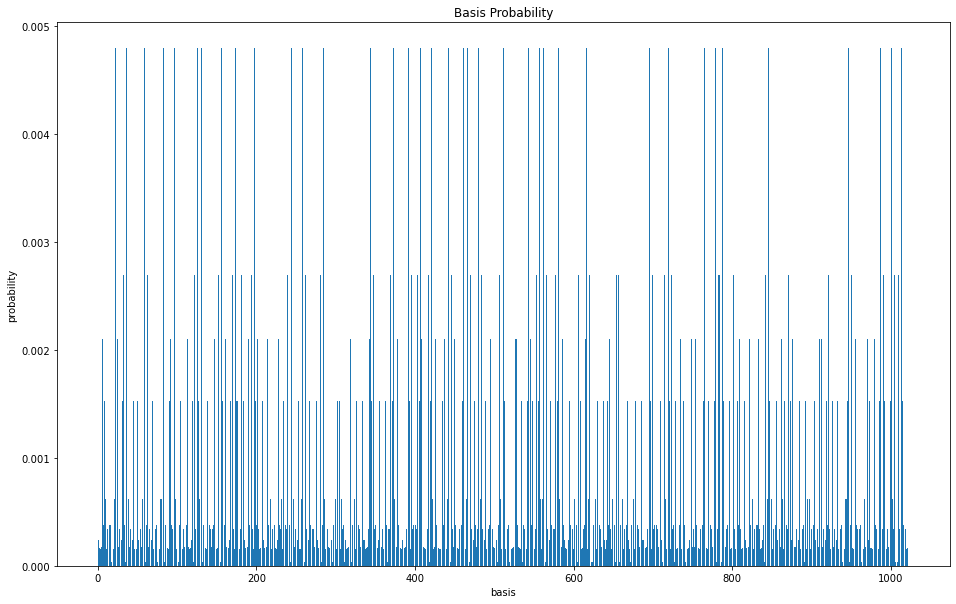

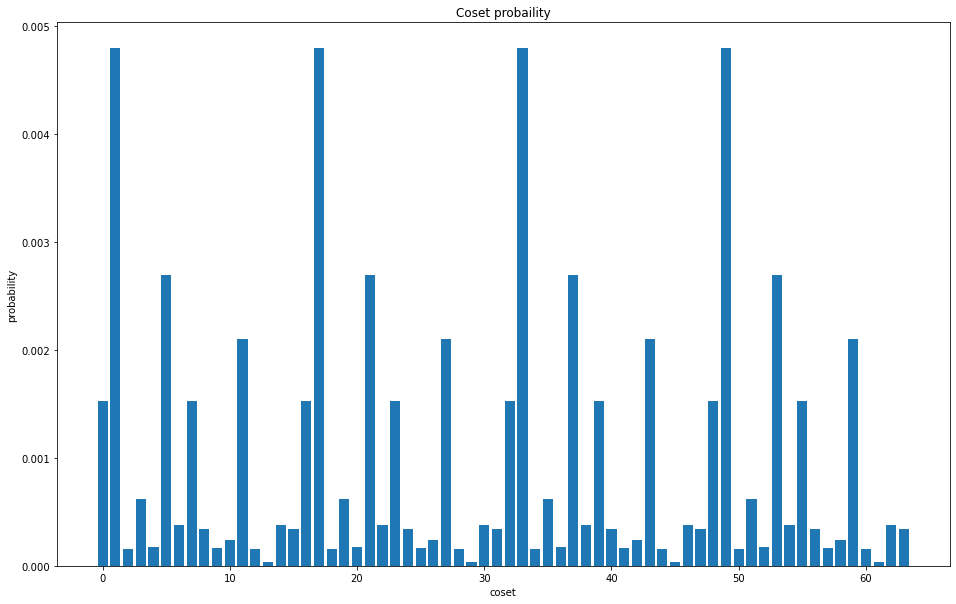

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 0. 1. 0.]




 Runningtime :  1266.2035455703735 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 1 0 1 0 0 1 1 0 0]
 [1 1 1 0 0 1 1 1 0 0]
 [1 0 0 0 1 0 1 1 1 1]
 [1 0 0 1 1 0 1 0 1 0]
 [1 0 1 1 0 0 1 1 0 1]
 [1 1 1 0 1 0 1 1 1 0]
 [1 0 0 0 1 1 0 0 0 0]
 [1 1 0 0 0 0 1 0 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.038388180519570284

total probability logical X:  0.03838818051957033

total probability logical Z:  0.03838818051957029

total probability logical Y:  0.038388180519570325

 coset without doing anything : 0.005859375

matching syndrome probability 0.15355272207828125

rate: 0.2499999999999998

correct!


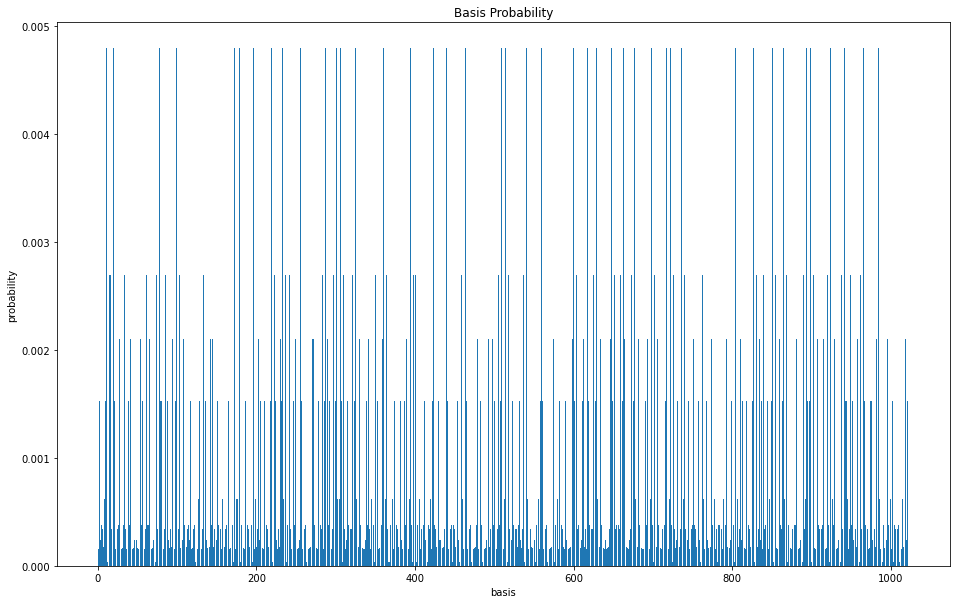

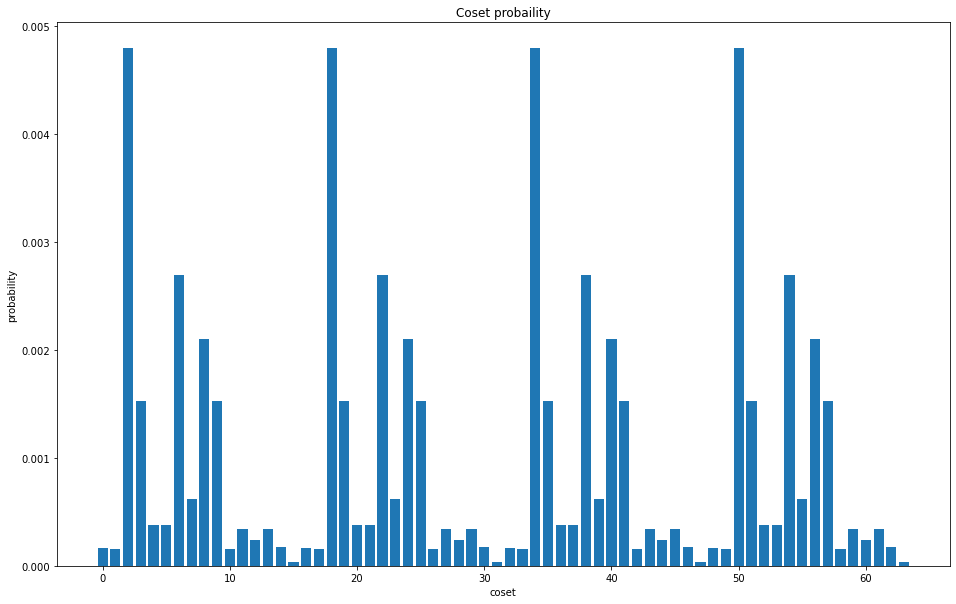

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 1. 1. 0.]




 Runningtime :  1265.1380548477173 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 0 1 1 0 0 1 1 0 0]
 [1 0 0 0 0 1 1 1 0 0]
 [1 0 0 1 0 1 1 0 0 1]
 [1 0 0 1 1 0 1 0 1 1]
 [1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 0 1 0]
 [1 1 0 0 1 0 0 1 0 1]
 [1 0 0 1 0 0 0 1 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.038388180519570284

total probability logical X:  0.038388180519570325

total probability logical Z:  0.03838818051957027

total probability logical Y:  0.038388180519570325

 coset without doing anything : 0.005859375

matching syndrome probability 0.1535527220782812

rate: 0.24999999999999992

correct!


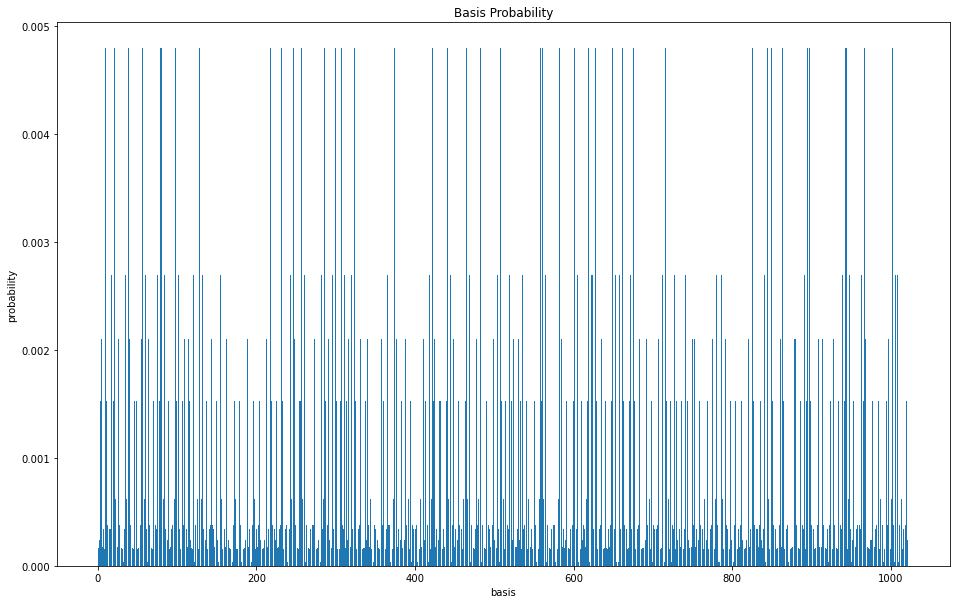

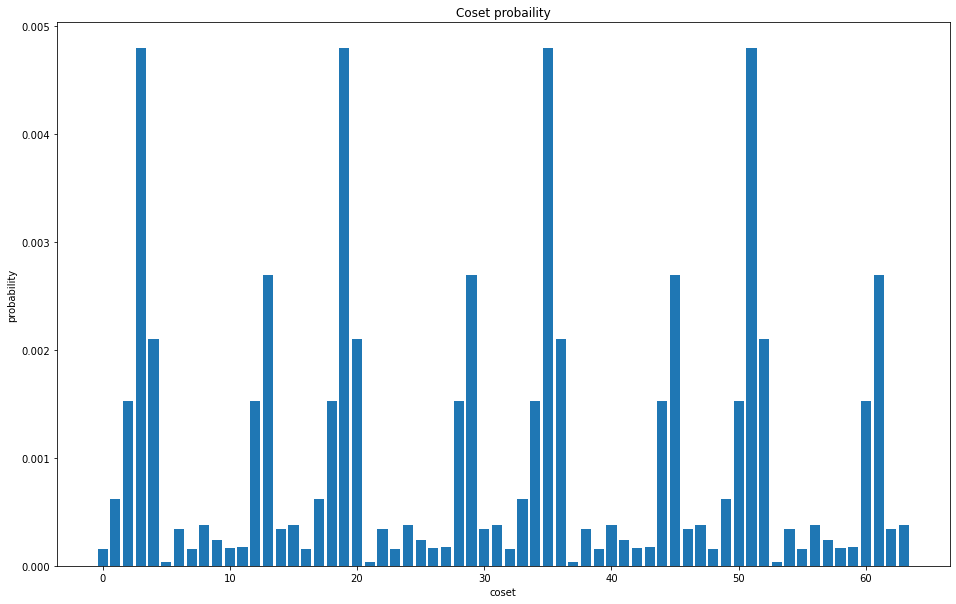

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 1. 1. 0.]




 Runningtime :  1265.549391746521 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 1 0 1 0 1 1 1 0 1]
 [1 0 0 0 1 1 1 1 1 0]
 [1 1 0 0 1 0 1 0 1 0]
 [1 1 0 1 0 0 0 0 1 0]
 [1 0 1 1 0 0 0 0 1 1]
 [1 0 1 1 0 1 1 1 0 0]
 [1 0 1 1 1 0 1 1 1 0]
 [1 1 1 0 0 1 0 0 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.038388180519570284

total probability logical X:  0.038388180519570325

total probability logical Z:  0.038388180519570284

total probability logical Y:  0.038388180519570325

 coset without doing anything : 0.005859375

matching syndrome probability 0.15355272207828122

rate: 0.24999999999999986

correct!


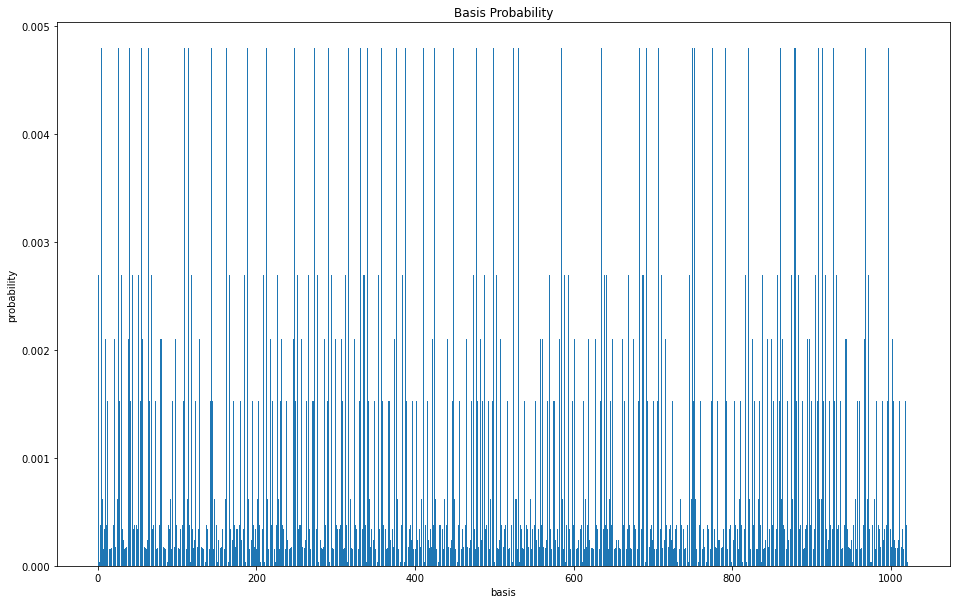

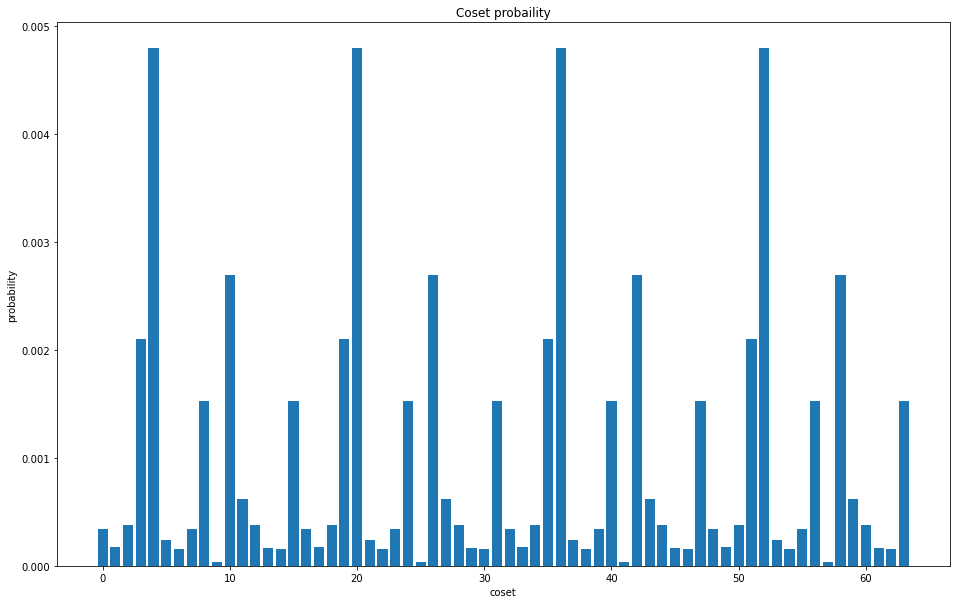

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 1. 1.]




 Runningtime :  1263.970944404602 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 0 0 0 1 1 0 1 1 0]
 [1 0 1 0 0 0 1 1 1 0]
 [1 0 0 1 1 0 1 1 0 0]
 [1 1 0 0 0 0 1 1 1 1]
 [1 1 0 0 0 1 0 0 0 0]
 [1 0 0 0 1 0 1 0 0 1]
 [1 0 1 1 0 0 1 0 1 1]
 [1 1 0 1 1 1 1 0 0 0]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.03838818051957027

total probability logical X:  0.03838818051957034

total probability logical Z:  0.03838818051957028

total probability logical Y:  0.03838818051957034

 coset without doing anything : 0.005859375

matching syndrome probability 0.15355272207828125

rate: 0.24999999999999972

cannot correct


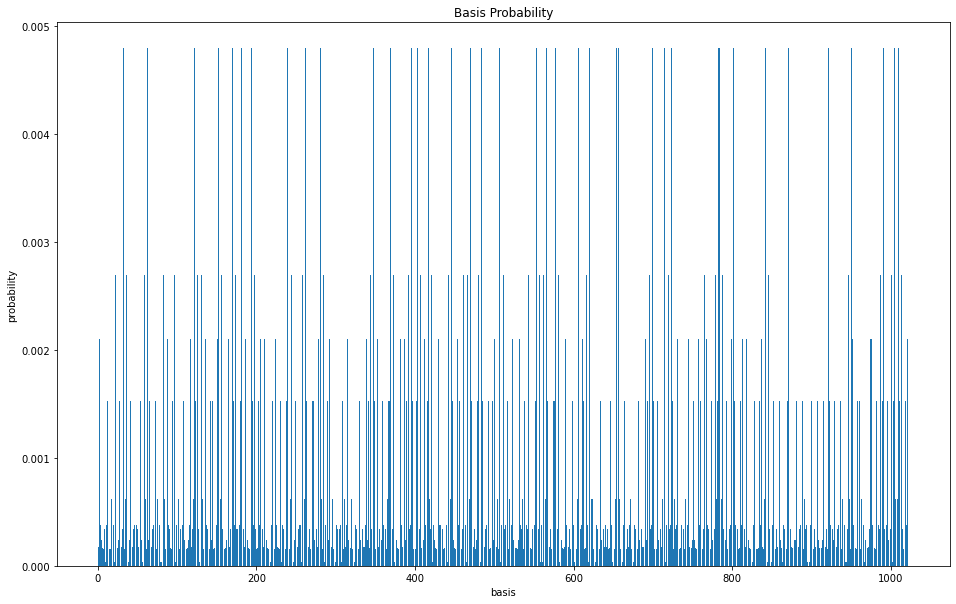

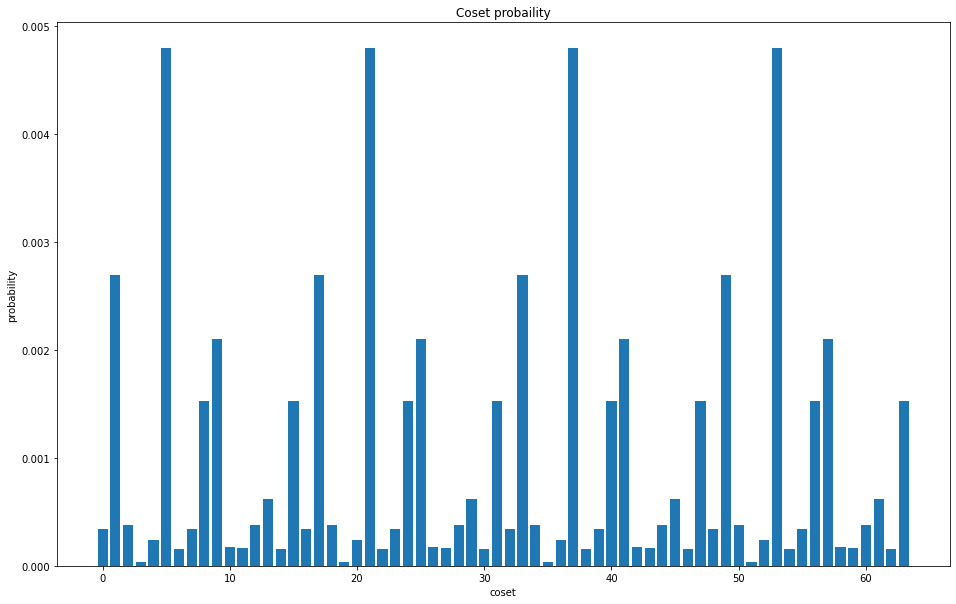

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 0.]




 Runningtime :  1264.1082701683044 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 0 1 1 0 0 1 0 0 1]
 [1 0 0 1 0 1 1 1 0 0]
 [1 1 0 0 0 1 0 0 1 0]
 [1 1 0 0 0 0 1 1 0 1]
 [1 1 0 0 1 0 0 0 0 0]
 [1 0 0 1 1 0 1 1 1 0]
 [1 0 1 0 1 0 0 0 0 1]
 [1 0 1 1 1 0 0 1 0 0]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.03838818051957026

total probability logical X:  0.03838818051957032

total probability logical Z:  0.03838818051957028

total probability logical Y:  0.03838818051957034

 coset without doing anything : 0.005859375

matching syndrome probability 0.1535527220782812

rate: 0.24999999999999978

cannot correct


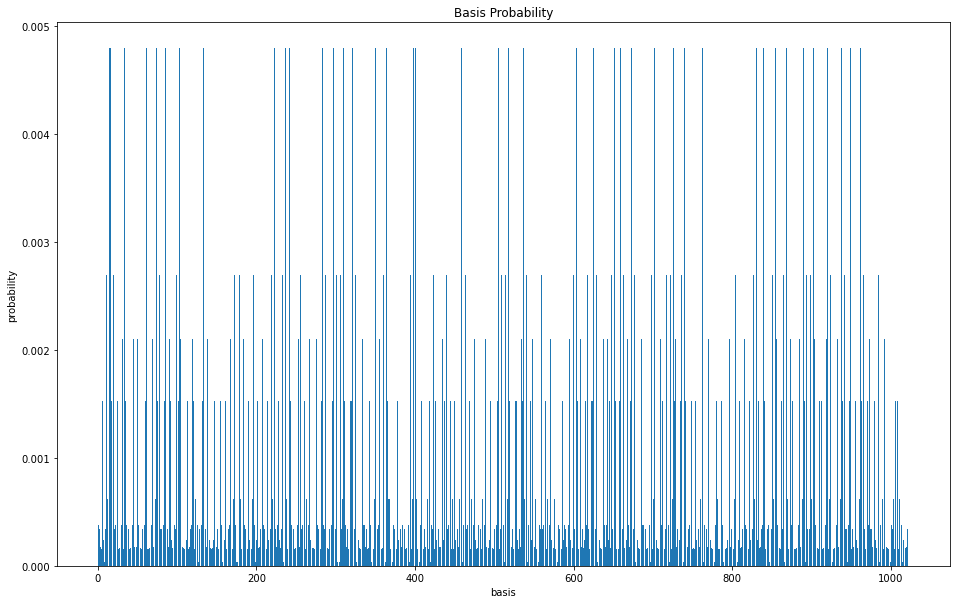

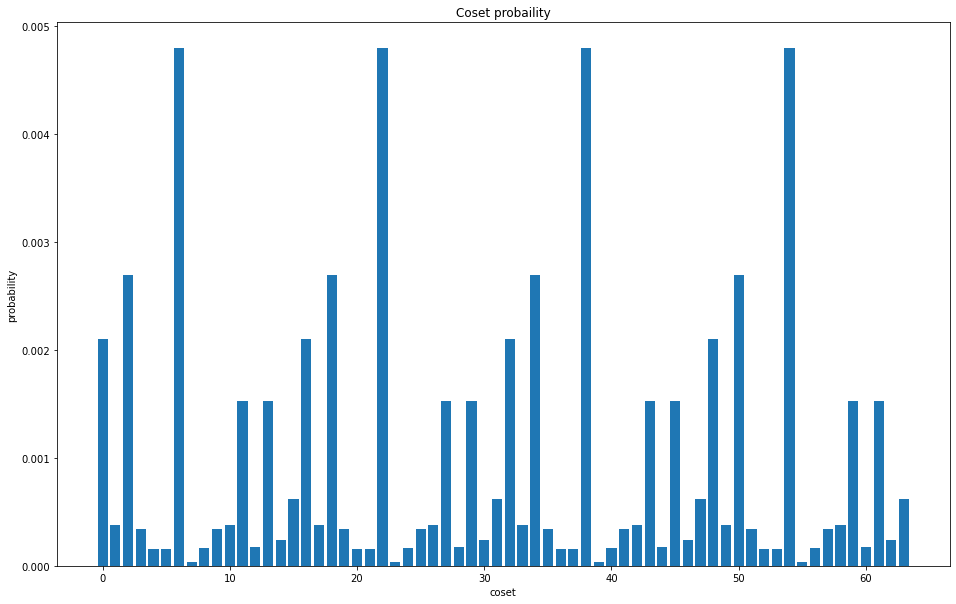

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [0. 1. 0. 1.]




 Runningtime :  1264.5730381011963 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 1 0 0 0 0 1 0 1 0]
 [0 1 1 0 0 0 1 0 0 1]
 [1 1 0 1 0 0 1 1 1 1]
 [1 1 0 0 1 1 1 0 0 0]
 [1 1 0 1 0 1 0 0 0 0]
 [0 1 1 1 0 0 1 1 0 0]
 [1 1 1 0 1 0 1 1 0 1]
 [1 0 0 0 1 0 1 1 0 0]]

check
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.03838818051957029

total probability logical X:  0.038388180519570325

total probability logical Z:  0.038388180519570284

total probability logical Y:  0.03838818051957033

 coset without doing anything : 0.005859375

matching syndrome probability 0.15355272207828125

rate: 0.24999999999999986

cannot correct


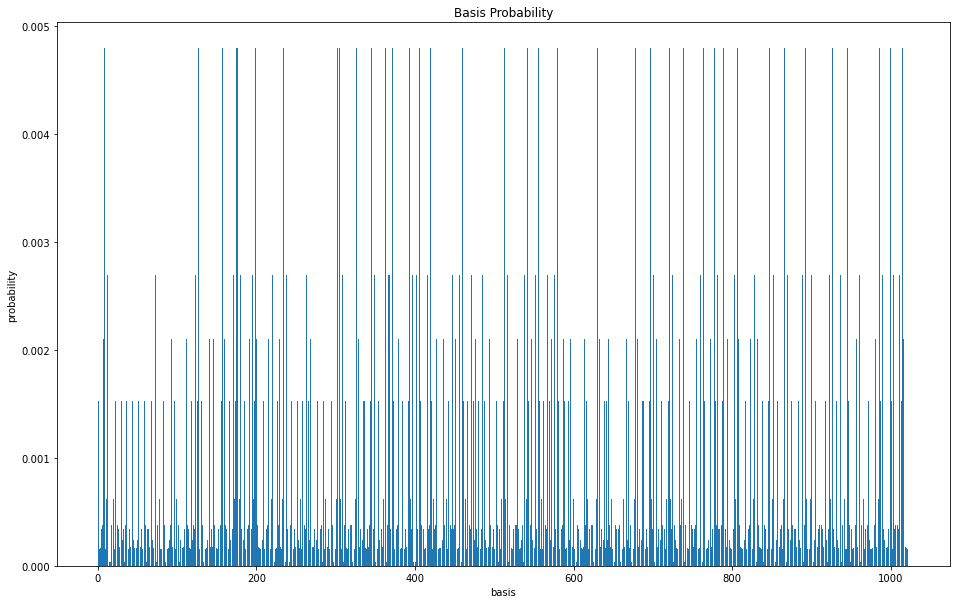

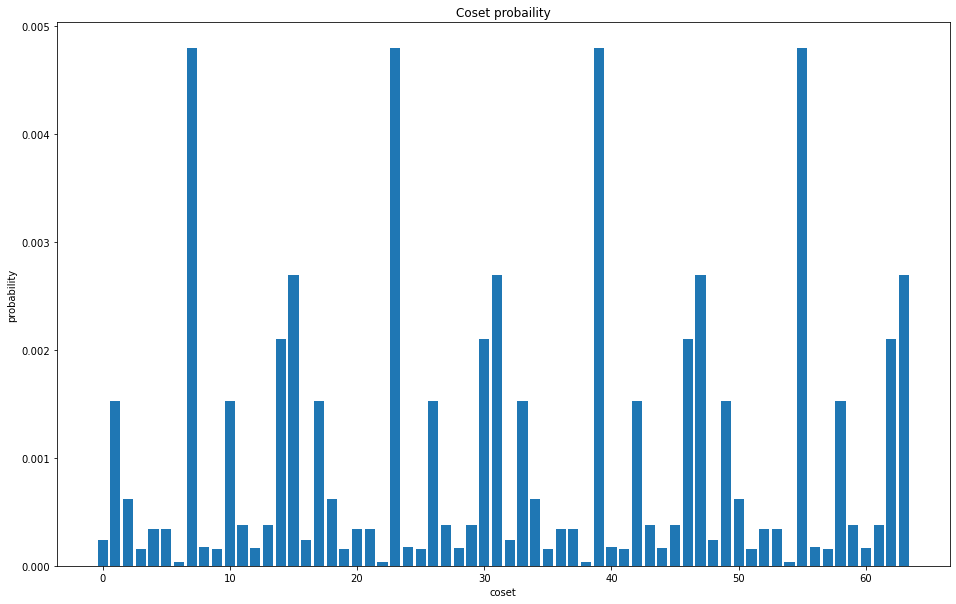

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [0. 0. 1. 0.]




 Runningtime :  1267.760820388794 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 1 0 0 0 1 1 0 0 1]
 [1 0 0 1 0 1 0 1 1 1]
 [1 1 0 1 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 1 1 0]
 [1 0 1 1 0 0 0 0 1 0]
 [1 0 0 0 1 1 1 1 1 1]
 [0 1 1 0 0 0 0 1 0 1]
 [1 0 0 0 1 0 0 0 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.03838818051957028

total probability logical X:  0.03838818051957033

total probability logical Z:  0.038388180519570284

total probability logical Y:  0.03838818051957033

 coset without doing anything : 0.005859375

matching syndrome probability 0.15355272207828122

rate: 0.2499999999999998

correct!


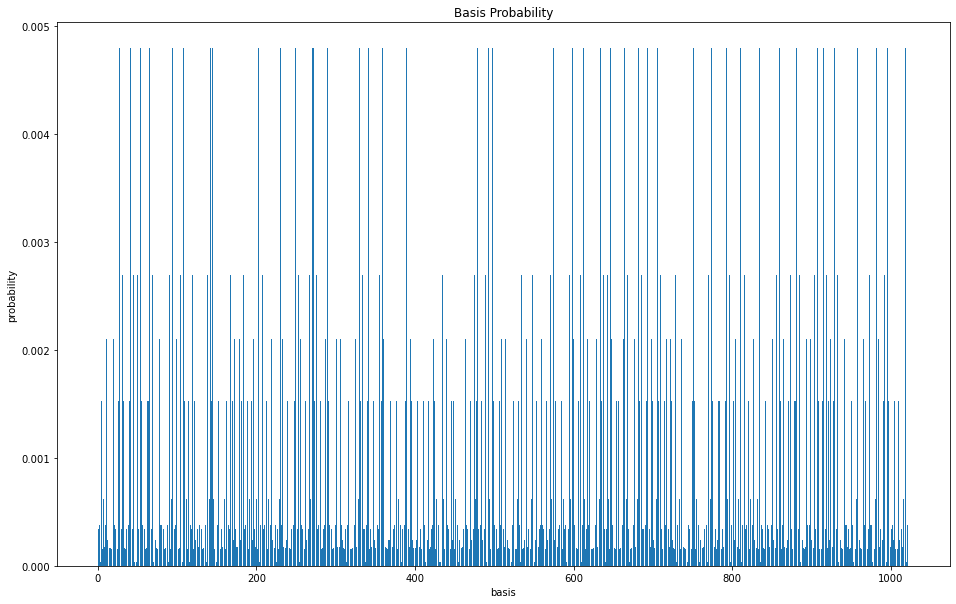

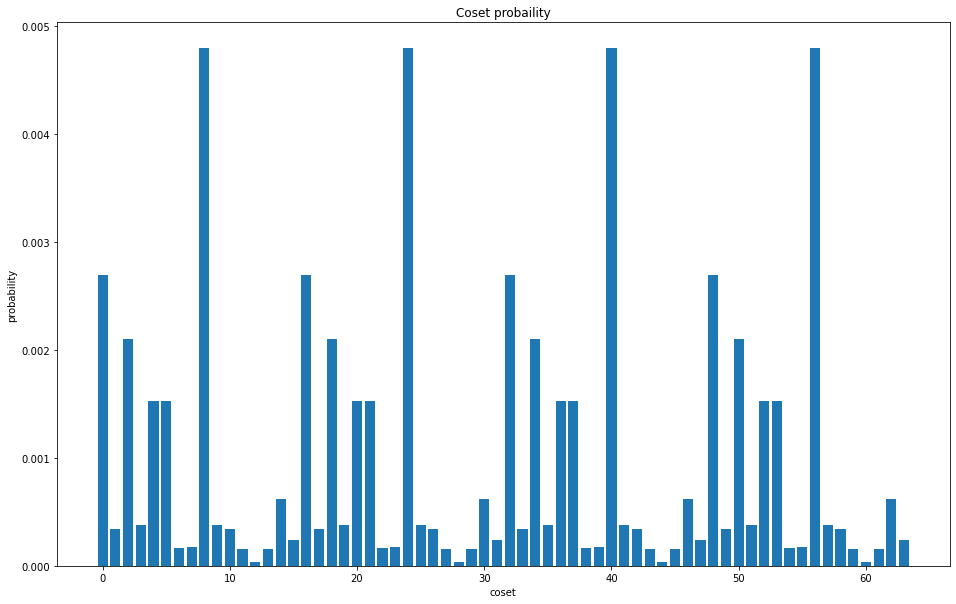

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 0. 1. 1.]




 Runningtime :  1265.5217280387878 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 1 0 0 1 0 1 1 0 1]
 [1 1 0 1 0 0 0 1 0 1]
 [1 0 0 0 1 1 1 0 0 1]
 [1 0 0 1 1 0 0 0 1 1]
 [1 0 0 0 1 0 0 1 1 0]
 [1 1 0 0 0 1 1 1 1 1]
 [1 0 1 1 1 0 1 0 0 1]
 [1 0 1 1 1 1 0 1 1 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.03838818051957027

total probability logical X:  0.03838818051957033

total probability logical Z:  0.03838818051957028

total probability logical Y:  0.03838818051957033

 coset without doing anything : 0.005859375

matching syndrome probability 0.1535527220782812

rate: 0.2499999999999998

cannot correct


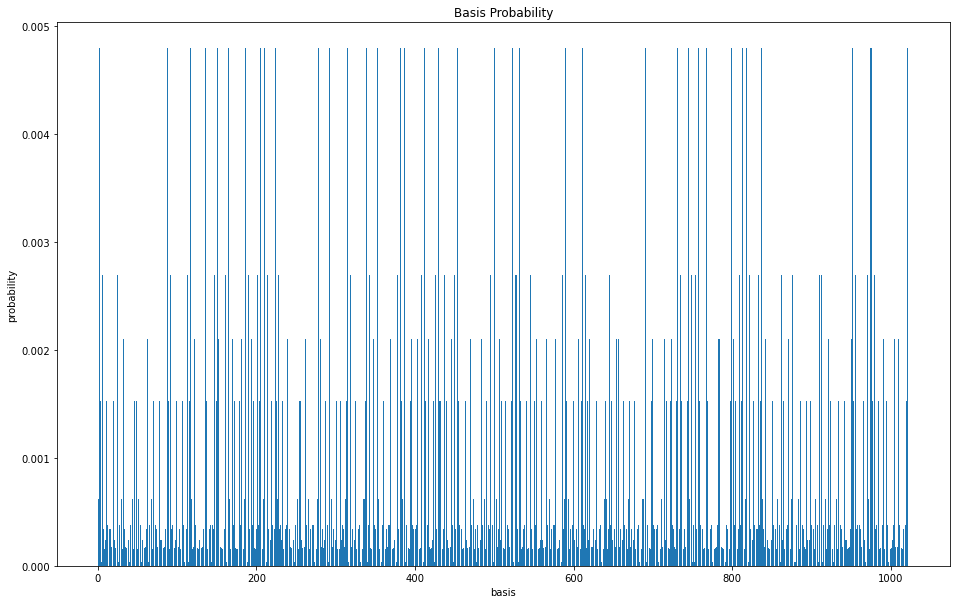

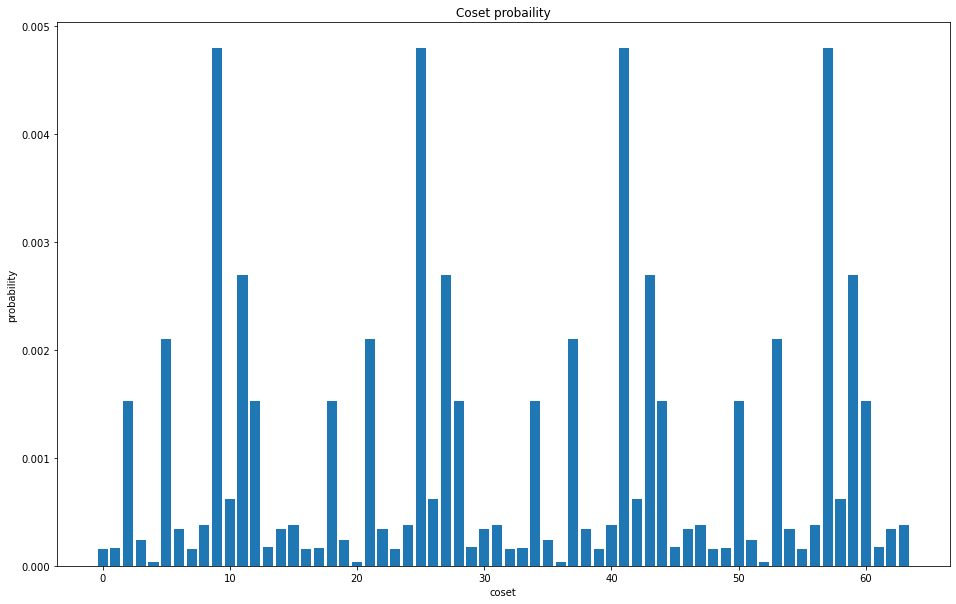

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 0. 0.]




 Runningtime :  1244.8768658638 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 0 0 0 1 1 1 0 1 0]
 [0 1 1 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 1 1 1]
 [1 1 0 0 0 1 1 1 0 0]
 [1 0 0 1 1 0 0 0 0 0]
 [1 0 1 1 0 1 1 0 0 0]
 [1 1 0 1 1 1 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.03838818051957026

total probability logical X:  0.038388180519570325

total probability logical Z:  0.03838818051957029

total probability logical Y:  0.038388180519570325

 coset without doing anything : 0.005859375

matching syndrome probability 0.15355272207828122

rate: 0.24999999999999972

correct!


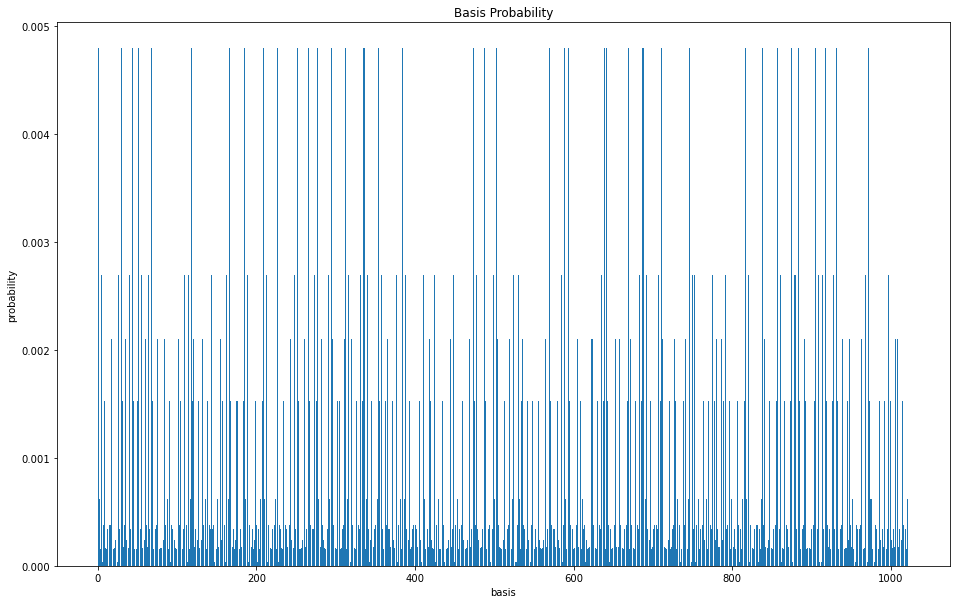

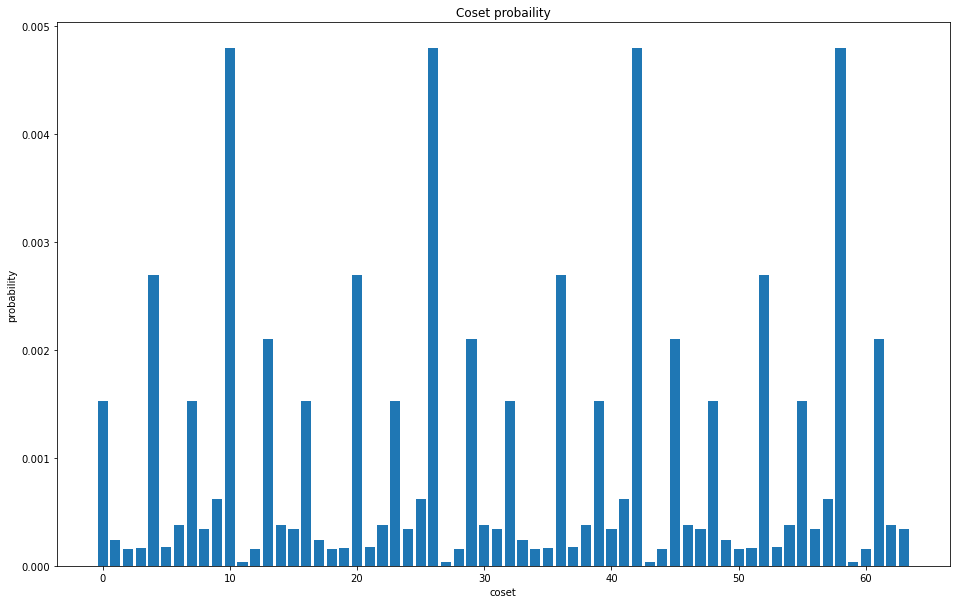

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 1.]




 Runningtime :  1245.0298504829407 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 1 0 0 0 1 1 0 1 1]
 [1 0 1 0 0 0 0 1 0 1]
 [1 1 0 0 0 0 0 1 0 0]
 [1 1 0 1 0 0 0 0 0 1]
 [1 1 0 0 1 0 1 0 0 1]
 [1 0 1 1 1 0 1 1 0 1]
 [1 0 1 1 0 0 0 0 0 0]
 [1 0 0 1 1 0 0 1 1 1]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.038388180519570325

total probability logical X:  0.03838818051957028

total probability logical Z:  0.03838818051957033

total probability logical Y:  0.03838818051957027

 coset without doing anything : 0.005859375

matching syndrome probability 0.1535527220782812

rate: 0.25000000000000017

cannot correct


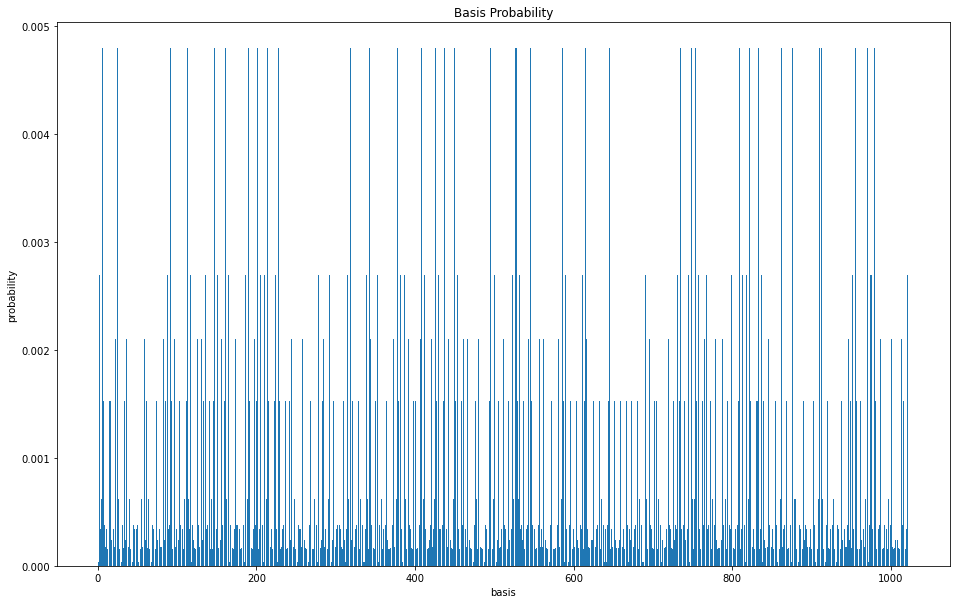

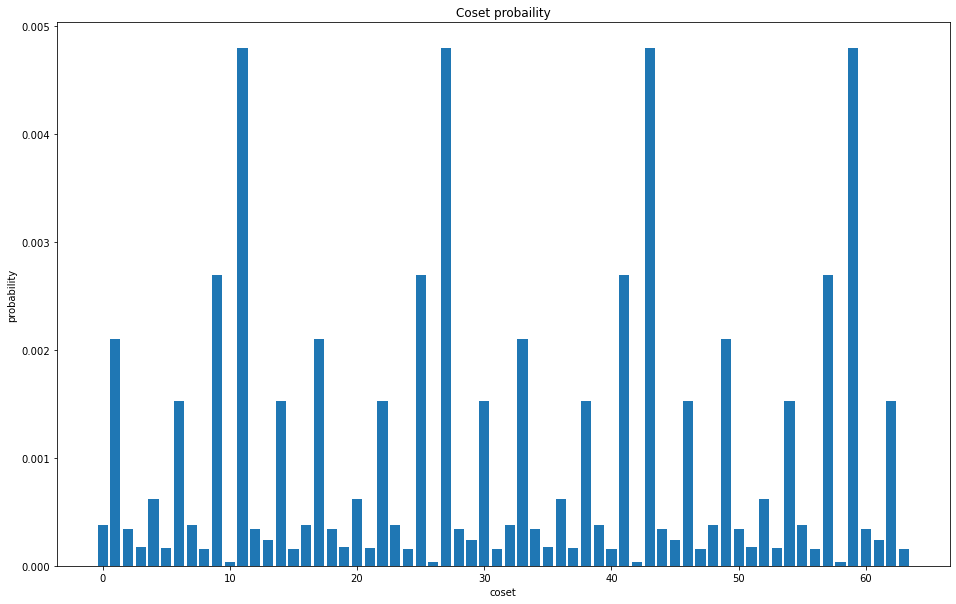

error:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [1. 1. 1. 1.]




 Runningtime :  1245.6587057113647 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 1 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 0 1 0 0 0]
 [1 0 1 1 0 0 0 1 0 1]
 [1 1 0 1 0 0 0 1 0 0]
 [1 1 0 0 1 1 0 0 1 1]
 [1 0 0 1 0 0 1 1 1 1]
 [0 1 1 0 0 0 0 0 1 0]
 [1 1 0 0 1 0 1 1 0 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.038388180519570284

total probability logical X:  0.038388180519570325

total probability logical Z:  0.03838818051957027

total probability logical Y:  0.03838818051957032

 coset without doing anything : 0.005859375

matching syndrome probability 0.1535527220782812

rate: 0.24999999999999992

cannot correct


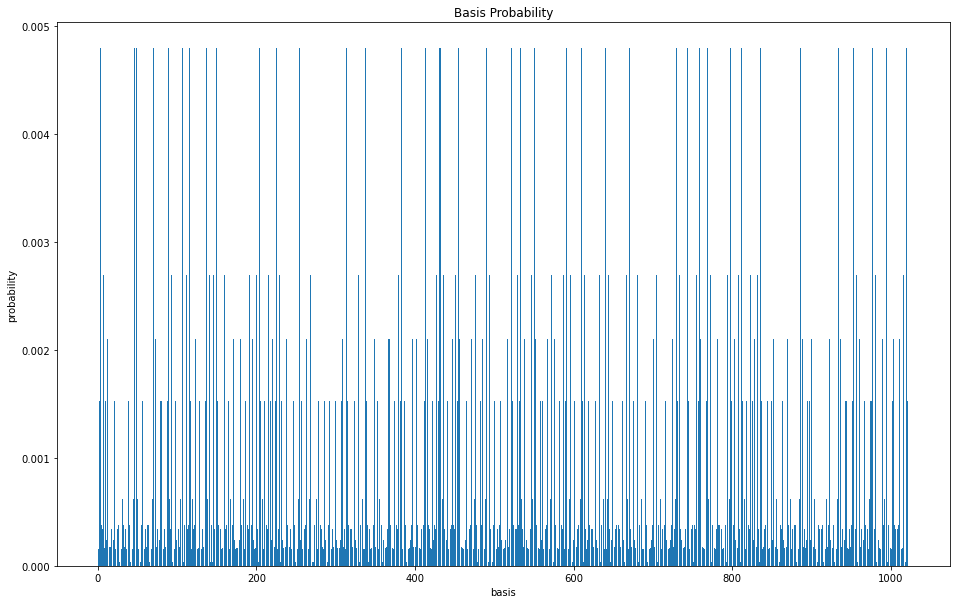

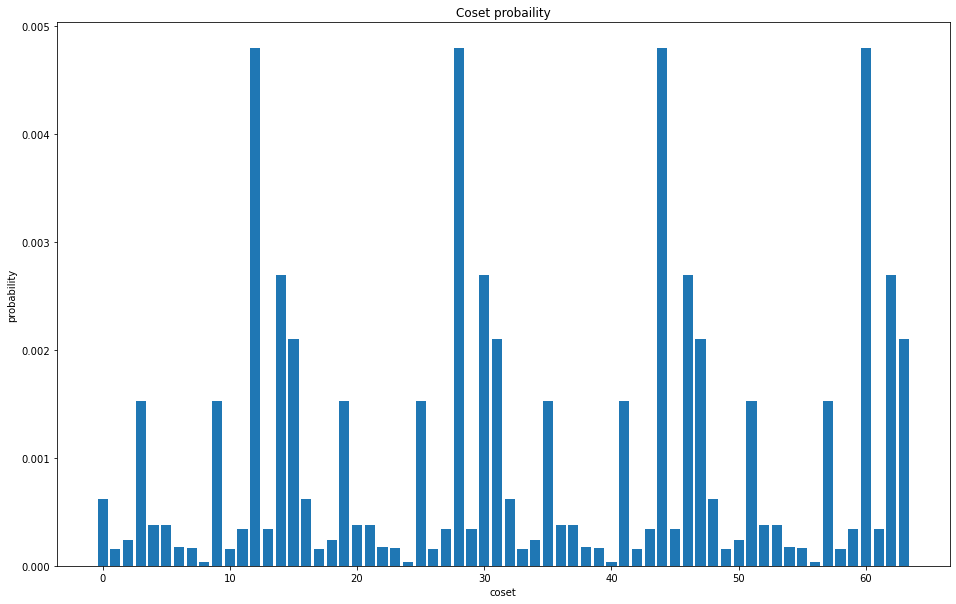

error:  [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [1. 1. 0. 0.]




 Runningtime :  1242.1651129722595 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 1 0 1 0 0 1 0 0 1]
 [1 0 0 0 1 0 1 0 1 0]
 [0 1 0 0 1 1 0 1 1 1]
 [1 0 0 1 0 0 0 0 1 0]
 [1 1 1 0 0 1 1 0 0 1]
 [1 1 0 0 0 0 1 1 0 0]
 [1 1 0 0 0 1 0 0 1 1]
 [1 1 0 1 1 0 0 1 0 0]]

check
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.03838818051957027

total probability logical X:  0.038388180519570325

total probability logical Z:  0.03838818051957028

total probability logical Y:  0.038388180519570325

 coset without doing anything : 0.005859375

matching syndrome probability 0.1535527220782812

rate: 0.2499999999999998

cannot correct


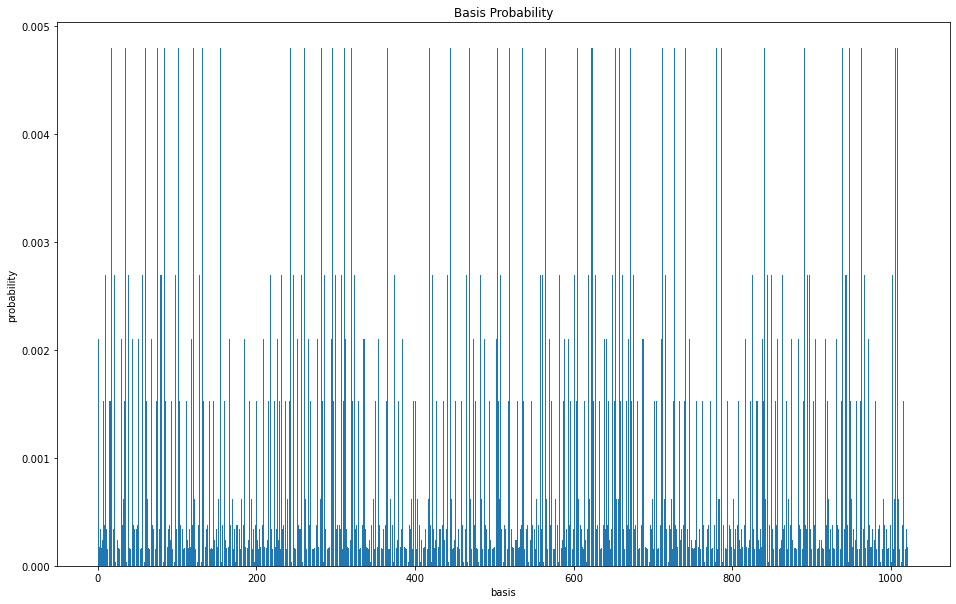

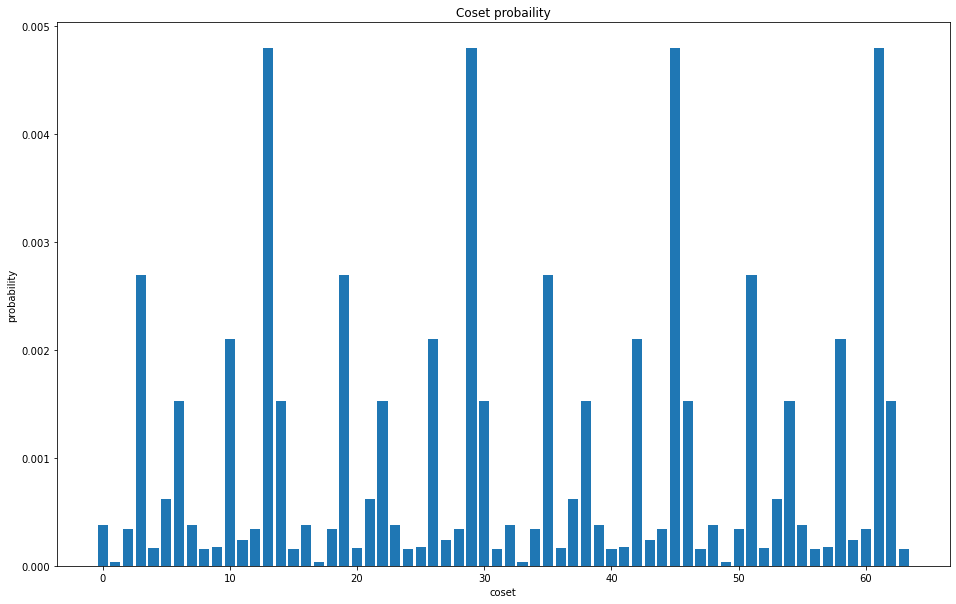

error:  [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 1. 0. 1.]




 Runningtime :  1244.3407537937164 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 0 0 0 1 1 1 1 0 0]
 [1 0 1 1 0 0 0 0 0 1]
 [1 1 0 0 0 1 1 0 1 0]
 [1 1 0 1 0 0 0 0 0 0]
 [1 0 1 0 1 1 0 1 1 0]
 [1 0 0 1 1 0 0 1 1 0]
 [1 1 0 0 0 0 0 1 0 1]
 [1 0 1 1 1 0 1 1 0 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.03838818051957028

total probability logical X:  0.038388180519570325

total probability logical Z:  0.03838818051957027

total probability logical Y:  0.038388180519570325

 coset without doing anything : 0.005859375

matching syndrome probability 0.1535527220782812

rate: 0.24999999999999986

cannot correct


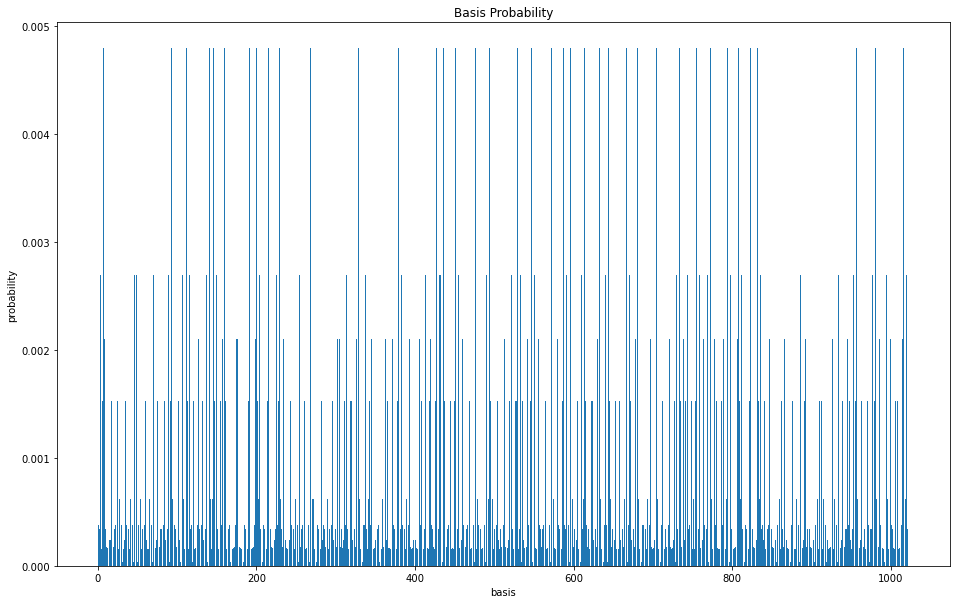

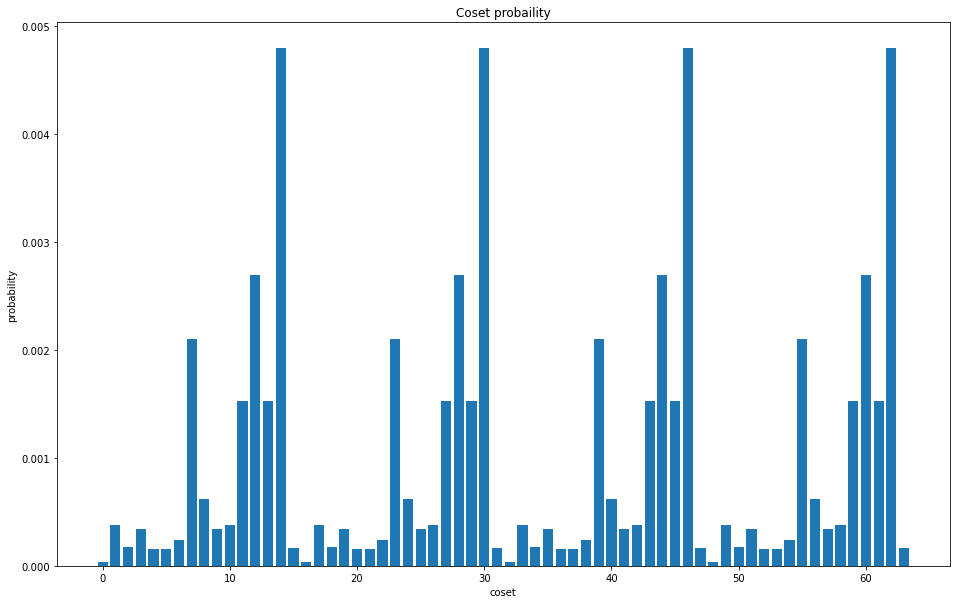

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 1. 1.]




 Runningtime :  1241.3423960208893 sec

gamma: 1.8 beta: 0.2

estimate error :
 [[1 1 0 0 0 0 1 1 1 0]
 [0 1 1 0 0 0 1 1 0 1]
 [1 0 0 1 0 0 0 0 0 0]
 [1 1 0 0 1 0 0 0 1 1]
 [1 1 0 1 0 1 0 1 0 0]
 [1 0 0 0 0 1 1 0 1 0]
 [1 0 1 1 0 0 1 0 1 0]
 [1 1 0 1 1 0 0 1 1 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.03838818051957028

total probability logical X:  0.03838818051957032

total probability logical Z:  0.03838818051957027

total probability logical Y:  0.03838818051957034

 coset without doing anything : 0.005859375

matching syndrome probability 0.1535527220782812

rate: 0.24999999999999986

cannot correct


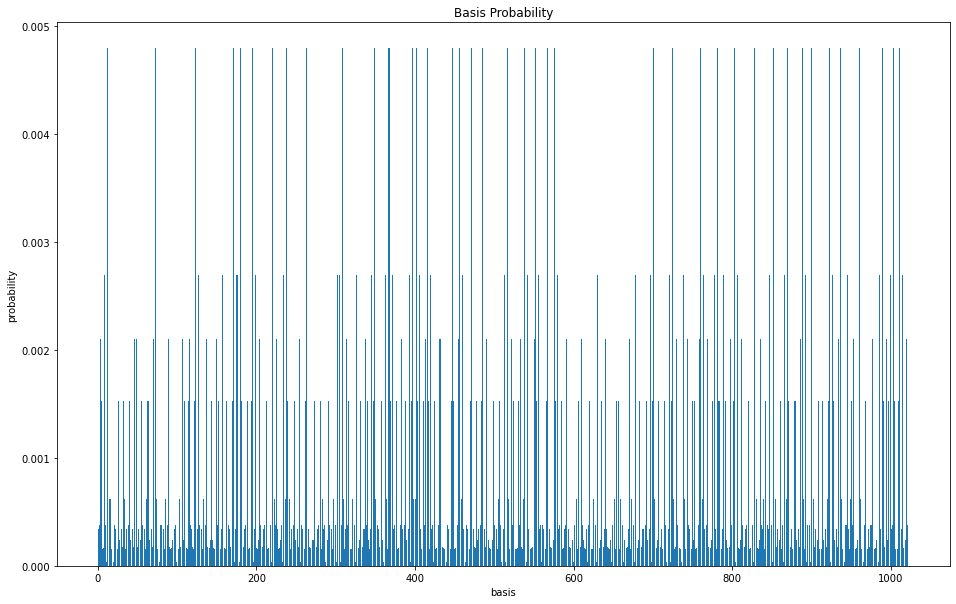

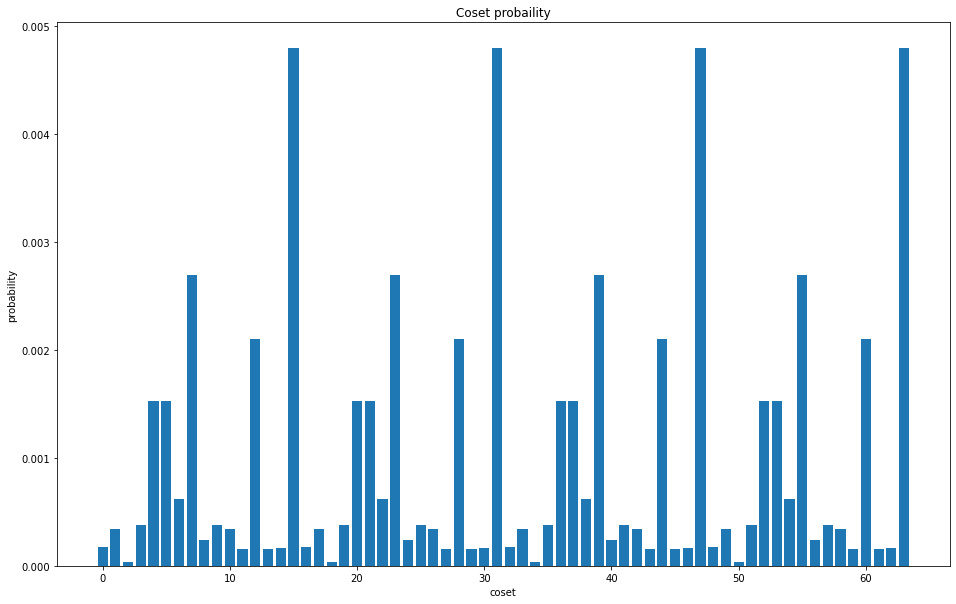

In [11]:
probability = []
gamma = []
beta = []
syndrome = []
cor_rate = []


num = int(M.shape[1]/2)

min_weight_term = min_weight(M.shape[1])
pen = 0
good = 0
    

for d in trange(len(err)):
    coset_prob = []
    probability = []
    n = M.shape[1]
    print('error: ', err[d])
    syndr = row_binary(M.dot(err[d]))
    C = (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + pen * min_weight_term
    
    B = B_generator(M.shape[1])
    print('\nsyndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    res = QAOA_finegrid(C,B,n,0.1)
    
    f_p_max_gamma = res[0]
    f_p_max_beta = res[1]
#     print(res[2])
    
    
    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")

    r = np.ones(2**M.shape[1])/np.sqrt(2**M.shape[1])
    #Construct U_C
    
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    
    print('\ngamma:', f_p_max_gamma,'beta:',f_p_max_beta )
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))      

    probability.append(prob)
    max_index = prob_sort(prob,8)


    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print('\nestimate error :\n',(np.array(word)))


    err_8 = []
    for q in range(8):
          err_8.append(err[d])


    check  = matrix_binary(((np.array(word) - np.array(err_8)).dot(L)).dot(G.T))

    print('\ncheck\n' ,check)


    degen_index = []
    degen_x_index = []
    degen_z_index = []
    degen_y_index = []


    for b in range(2**(H_oringin.shape[0]-1)):
        degen_index.append(converter((degenerate_error(err[d], H_oringin)[b])))
        degen_x_index.append(converter((degenerate_error(logical_x_error[d], H_oringin)[b])))
        degen_z_index.append(converter((degenerate_error(logical_z_error[d], H_oringin)[b])))
        degen_y_index.append(converter((degenerate_error(logical_y_error[d], H_oringin)[b])))

    total_prob_I = 0
    total_prob_X = 0
    total_prob_Z = 0
    total_prob_Y = 0



    for c in range(len(degen_index)):
        total_prob_I += (probability[0][degen_index[c]])
        total_prob_X += (probability[0][degen_x_index[c]])
        total_prob_Z += (probability[0][degen_z_index[c]])
        total_prob_Y += (probability[0][degen_y_index[c]])


    print('\ntotal probability logical I: ', total_prob_I)
    print('\ntotal probability logical X: ', total_prob_X)
    print('\ntotal probability logical Z: ', total_prob_Z)
    print('\ntotal probability logical Y: ', total_prob_Y)
    print('\n coset without doing anything :', (H_oringin.shape[0]-1)/2**(M.shape[1]-1 ))
    print('\nmatching syndrome probability', total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y)
    print('\nrate:',  total_prob_I/( total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y))

    if sum(check[0][c] for c in range(len(check[0]))) == 0:
        print("\ncorrect!")
        good +=1
    else:
        print('\ncannot correct')


    
    for q in range(len(coset)):
        for f in range(len(coset[q])):
            c_prob = 0
            c_prob += probability[0][converter(coset[q][f])]
        coset_prob.append(c_prob)
    
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.title('Basis Probability')
    plt.ylabel('probability')
    plt.xlabel('basis')
    plt.show()
    plt.bar(range(0, len(coset_prob)),coset_prob)
    plt.title('Coset probaility')
    plt.ylabel('probability')
    plt.xlabel('coset')
    plt.show()
    time.sleep(0.5)


## 513 Stabilizer Code add a redundant row on H_q

In [3]:

H_oringin = np.array([[1,0,0,1,0,0,1,1,0,0],[0,1,0,0,1,0,0,1,1,0],[0,0,1,1,0,0,1,1,1,1],[0,1,0,1,0,1,0,0,0,1]])

H = np.array([[1,0,0,1,0,0,1,1,0,0],[0,1,0,0,1,0,0,1,1,0],[0,0,1,1,0,0,1,1,1,1],[0,1,0,1,0,1,0,0,0,1],[0,0,1,0,1,1,1,0,0,0]])
H_T = H.T

L = Lambda(5)

G = np.array([[1,0,0,0,1,1,1,0,1,1],[0,1,0,0,1,0,0,1,1,0],[0,0,1,0,1,1,1,0,0,0],[0,0,0,1,1,1,0,1,1,1],
              [0,0,0,0,1,1,0,0,1,0],[0,0,0,0,0,1,1,1,1,1]])


M = H.dot(L)

print(matrix_binary(M.dot(G.T)))
# P = np.array([[1,1,1,0],[0,1,1,0],[0,0,0,1],[1,0,1,0]])
# print(matrix_rank(P))
# x = np.array([1,0,0,0,1,1,1,0,1,1])

# M_sw = matrix_binary(P.dot(M))

# print(M_sw)
# print(sum(num_1_pos(M.T[i])[1] for i in range(M.shape[1]))/M.shape[1])


err = []
err.append(np.zeros(10))
for i in range(10):
    l = np.zeros(10)
    l[i] = 1
    err.append(l)
for i in range(5):
    l = np.zeros(10)
    l[i] = 1
    l[i+5] = 1
    err.append(l)
err = np.array(err)

error_syndrome = []
for i in range(len(err)):
    sy = row_binary(M.dot((err[i]).T))
    print('\nerror: ',err[i])
    print('syndrome: ',sy)



[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 0. 0. 0.]

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 0. 1. 1.]

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [1. 0. 1. 0. 1.]

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [1. 1. 1. 0. 0.]

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 1. 1. 0. 0.]

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 1. 1. 0.]

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
syndrome:  [1. 0. 0. 0. 0.]

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
syndrome:  [0. 1. 0. 1. 0.]

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
syndrome:  [0. 0. 1. 0. 1.]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
syndrome:  [1. 0. 1. 1. 0.]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
syndrome:  [0. 1. 0. 0. 1.]

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
syndrome:  [1. 0. 0. 1. 1.]

error:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
syndrome:  [1. 1. 1. 1. 1.]

error:  [0. 0. 1. 0. 0. 0.

In [4]:
coset = []
logical_stb = []
error_stack = []
logical_x_stack = []
logical_z_stack = []
logical_y_stack = []



logical_x = [1,1,1,1,1,0,0,0,0,0]
logical_z = [0,0,0,0,0,1,1,1,1,1]
logical_y = [1,1,1,1,1,1,1,1,1,1]




for i in range(16):
    logical_x_stack.append(logical_x)
logical_x_error  = matrix_binary(err + np.array(logical_x_stack))

for i in range(16):
    logical_z_stack.append(logical_z)
logical_z_error  = matrix_binary(err + np.array(logical_z_stack))

for i in range(16):
    logical_y_stack.append(logical_y)
logical_y_error  = matrix_binary(err + np.array(logical_y_stack))

stabilizer = matrix_binary(basis(H_oringin.shape[0]).dot(H_oringin))


logical_x_stack = []
logical_z_stack = []
logical_y_stack = []


for i in range(2**H_oringin.shape[0]):
    logical_x_stack.append(logical_x)
    logical_y_stack.append(logical_y)
    logical_z_stack.append(logical_z)


logical_x_stb = matrix_binary(stabilizer + np.array(logical_x_stack))
logical_y_stb = matrix_binary(stabilizer + np.array(logical_y_stack))
logical_z_stb = matrix_binary(stabilizer + np.array(logical_z_stack))

logical_stb.append(stabilizer)
logical_stb.append(logical_x_stb)
logical_stb.append(logical_y_stb)
logical_stb.append(logical_z_stb)





error_0_stack = []
error_1_stack = []
error_2_stack = []
error_3_stack = []
error_4_stack = []
error_5_stack = []
error_6_stack = []
error_7_stack = []
error_8_stack = []
error_9_stack = []
error_10_stack = []
error_11_stack = []
error_12_stack = []
error_13_stack = []
error_14_stack = []
error_15_stack = []




for i in range(16):
    error_0_stack.append([0,0,0,0,0,0,0,0,0,0])
    error_1_stack.append([1,0,0,0,0,0,0,0,0,0])
    error_2_stack.append([0,1,0,0,0,0,0,0,0,0])
    error_3_stack.append([0,0,1,0,0,0,0,0,0,0])
    error_4_stack.append([0,0,0,1,0,0,0,0,0,0])
    error_5_stack.append([0,0,0,0,1,0,0,0,0,0])
    error_6_stack.append([0,0,0,0,0,1,0,0,0,0])
    error_7_stack.append([0,0,0,0,0,0,1,0,0,0])
    error_8_stack.append([0,0,0,0,0,0,0,1,0,0])
    error_9_stack.append([0,0,0,0,0,0,0,0,1,0])
    error_10_stack.append([0,0,0,0,0,0,0,0,0,1])
    error_11_stack.append([1,0,0,0,0,1,0,0,0,0])
    error_12_stack.append([0,1,0,0,0,0,1,0,0,0])
    error_13_stack.append([0,0,1,0,0,0,0,1,0,0])
    error_14_stack.append([0,0,0,1,0,0,0,0,1,0])
    error_15_stack.append([0,0,0,0,1,0,0,0,0,1])


error_stack.append(error_0_stack)
error_stack.append(error_1_stack)
error_stack.append(error_2_stack)
error_stack.append(error_3_stack)
error_stack.append(error_4_stack)
error_stack.append(error_5_stack)
error_stack.append(error_6_stack)
error_stack.append(error_7_stack)
error_stack.append(error_8_stack)
error_stack.append(error_9_stack)
error_stack.append(error_10_stack)
error_stack.append(error_11_stack)
error_stack.append(error_12_stack)
error_stack.append(error_13_stack)
error_stack.append(error_14_stack)
error_stack.append(error_15_stack)

print(len(error_stack))


for i in range(4):
    for j in range(16):
        coset.append(matrix_binary(np.array(logical_stb[i]) + np.array(error_stack)[j]))
        
print(len(coset[0]))






16
16


## QAOA  redundant row

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 0. 0.]




 Runningtime :  1253.9821193218231 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 1 1 1]
 [0 1 0 1 1 0 0 0 1 1]
 [0 1 0 1 0 0 1 1 1 0]
 [0 0 1 0 0 0 1 0 1 0]
 [0 1 0 0 0 0 1 0 1 1]
 [0 1 1 1 0 0 0 1 0 0]
 [1 1 1 0 0 0 1 0 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.048485826158462586

total probability logical X:  0.0483173000271905

total probability logical Z:  0.04848138592271878

total probability logical Y:  0.04831670856131393

 coset without doing anything : 0.005859375

matching syndrome probability 0.1936012206696858

rate: 0.25044173787099744

correct!


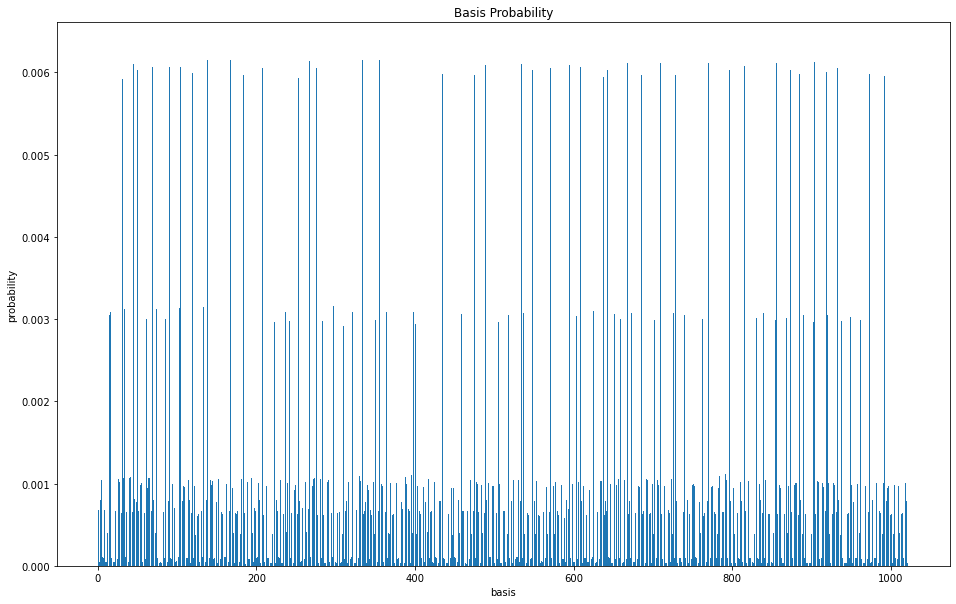

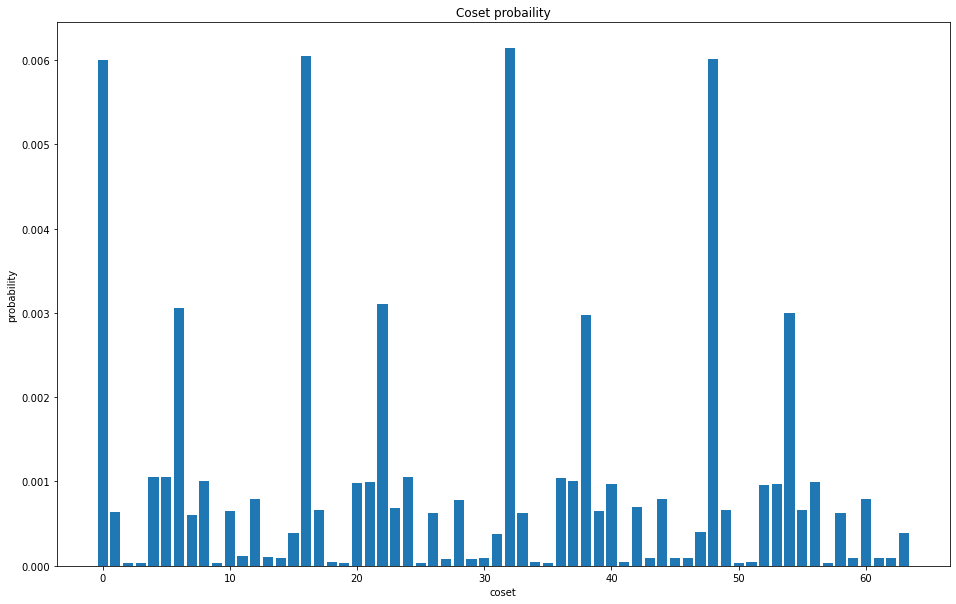

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 1. 1.]




 Runningtime :  1260.702677488327 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 1 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 1 1 0]
 [0 1 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 1]
 [0 1 1 0 1 0 0 1 0 1]
 [0 1 0 1 1 0 1 0 1 0]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.048319105137471466

total probability logical X:  0.04848378871459878

total probability logical Z:  0.04831509096779216

total probability logical Y:  0.048483164463035563

 coset without doing anything : 0.005859375

matching syndrome probability 0.19360114928289796

rate: 0.24958067303033207

cannot correct


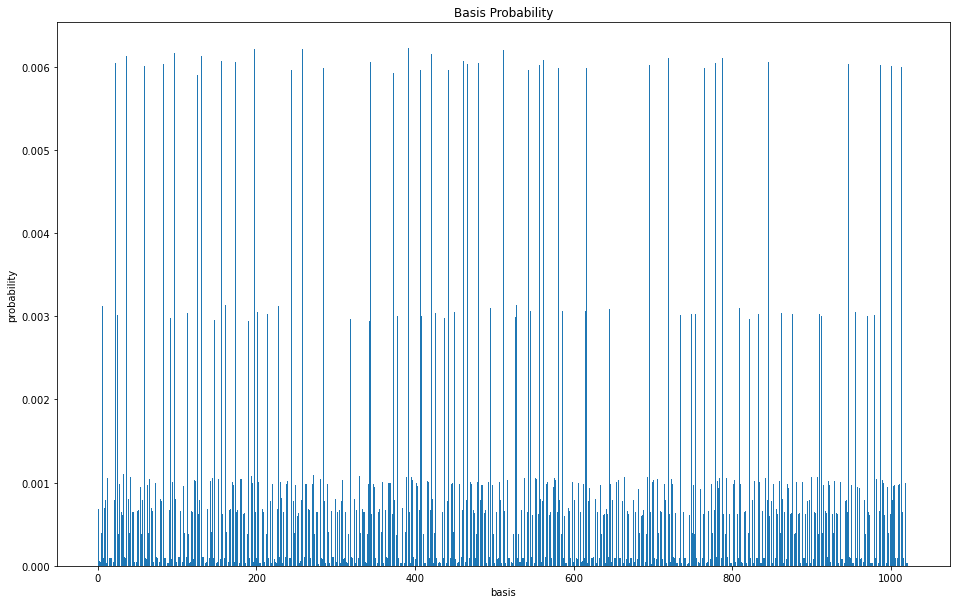

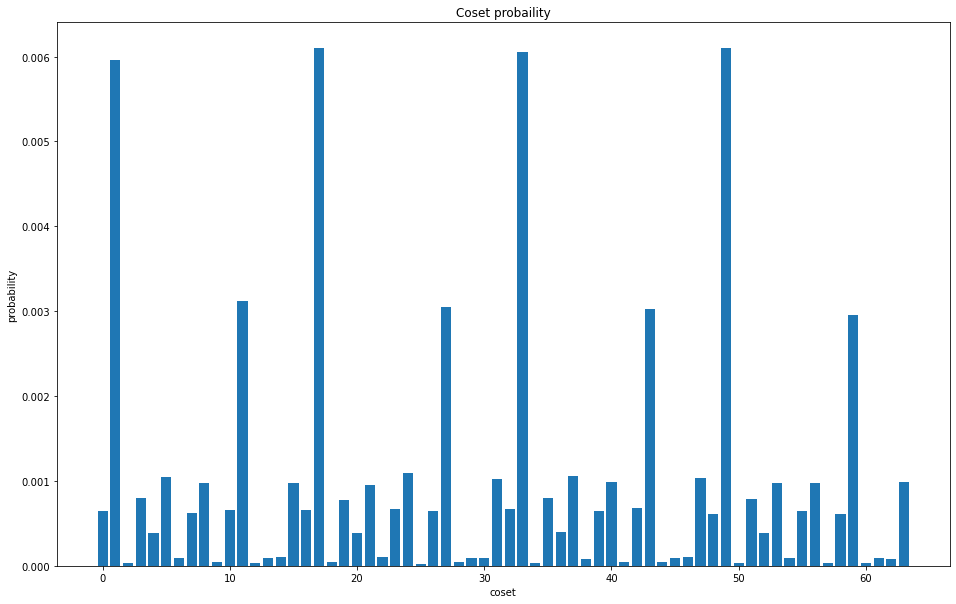

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 0. 1. 0. 1.]




 Runningtime :  1253.410166501999 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 1 1]
 [0 1 1 0 0 0 1 0 1 0]
 [0 0 1 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 1 0]
 [1 1 1 0 0 1 1 1 0 0]
 [0 1 0 0 1 0 1 1 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.04848250480534908

total probability logical X:  0.048314353828879476

total probability logical Z:  0.048480269575419156

total probability logical Y:  0.04831561928485652

 coset without doing anything : 0.005859375

matching syndrome probability 0.19359274749450422

rate: 0.25043554282282926

correct!


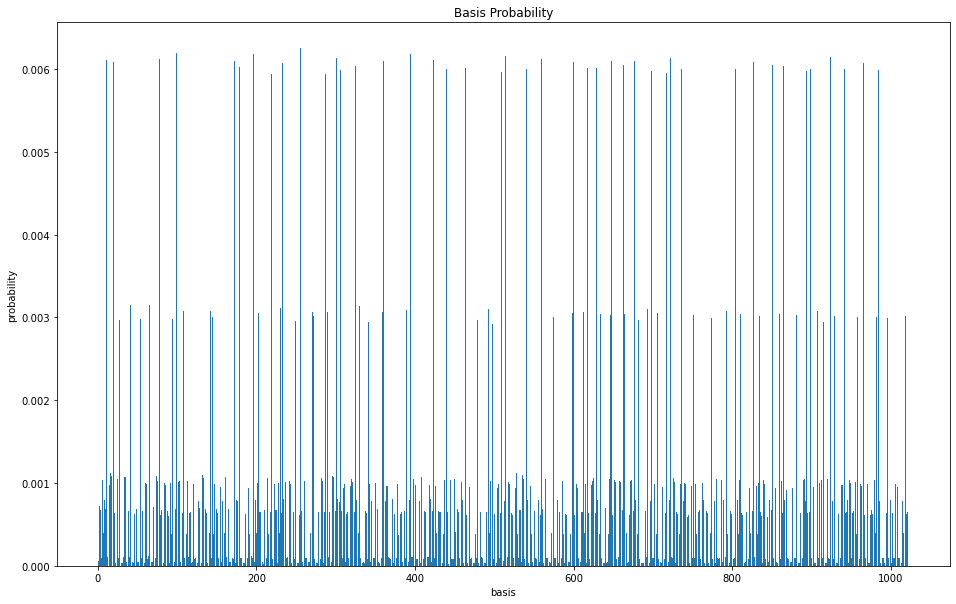

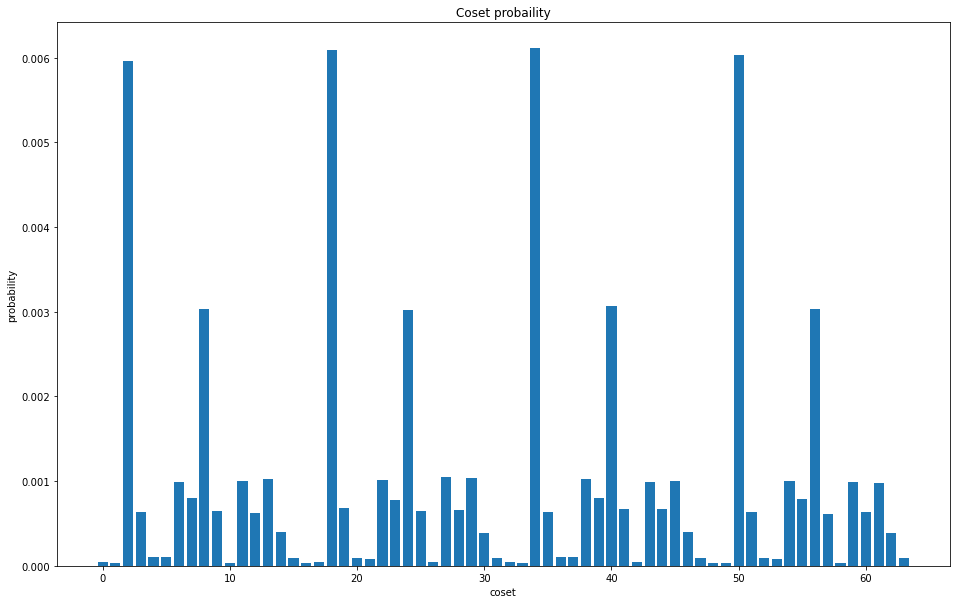

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 1. 1. 0. 0.]




 Runningtime :  1253.7339630126953 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 1 1 1 0 0 1 1 1 0]
 [1 1 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 0 1 0]
 [1 0 0 0 1 1 0 0 0 1]
 [0 1 0 1 1 0 1 0 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.04848389056585486

total probability logical X:  0.048316290500920345

total probability logical Z:  0.04848303683394646

total probability logical Y:  0.048317892496493695

 coset without doing anything : 0.005859375

matching syndrome probability 0.1936011103972154

rate: 0.25043188268073185

correct!


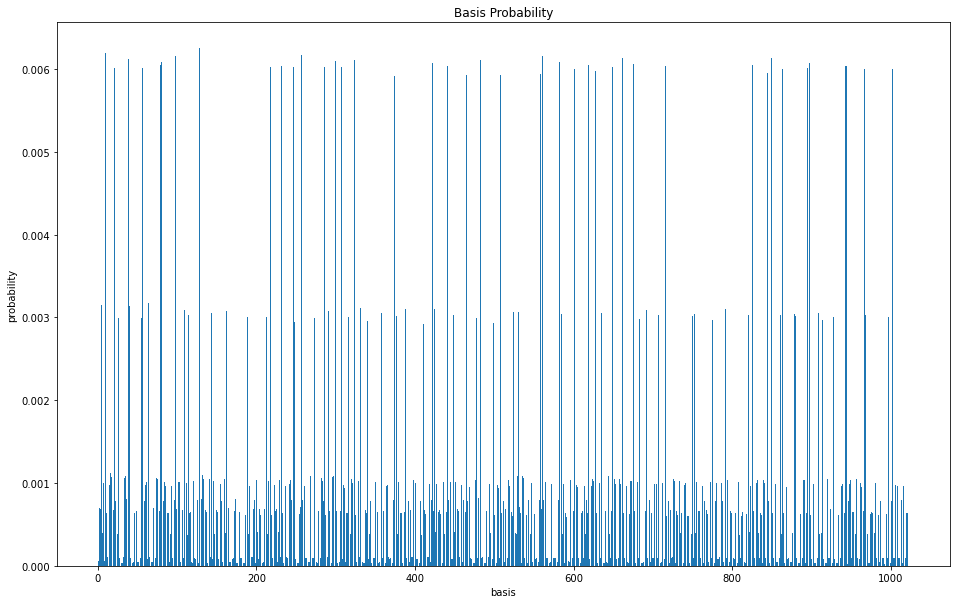

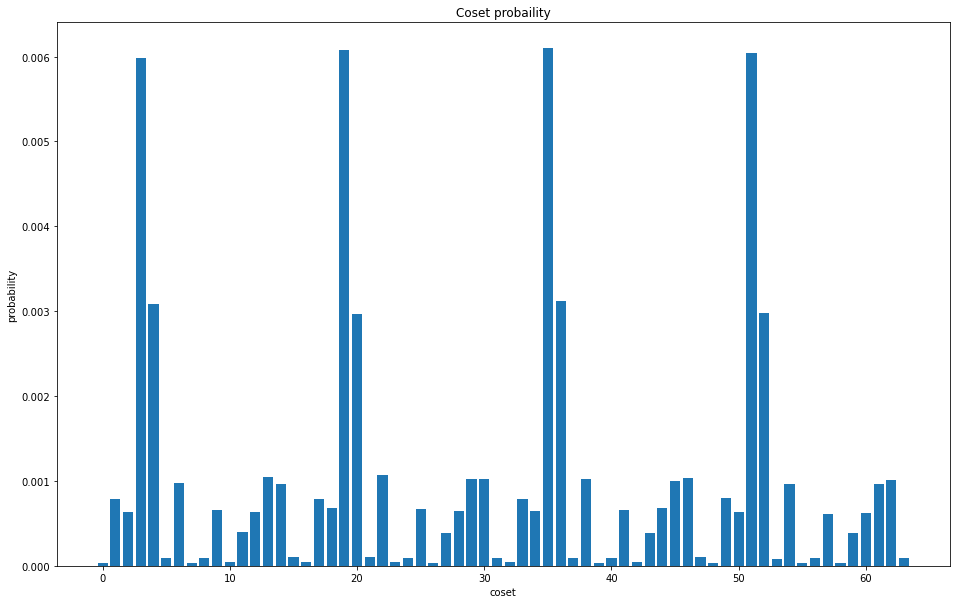

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 1. 1. 0. 0.]




 Runningtime :  1254.3958990573883 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 1 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 1 0 0]
 [1 1 0 0 0 1 1 0 0 0]
 [0 1 1 0 1 0 1 0 0 1]
 [0 1 0 0 1 0 0 0 1 1]
 [0 0 1 1 1 0 0 1 1 1]
 [0 1 0 0 0 0 1 1 1 0]
 [0 0 1 1 0 0 1 0 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.04848311177966331

total probability logical X:  0.04831791373201935

total probability logical Z:  0.04848380814642633

total probability logical Y:  0.04831626102559867

 coset without doing anything : 0.005859375

matching syndrome probability 0.19360109468370765

rate: 0.2504278803736711

correct!


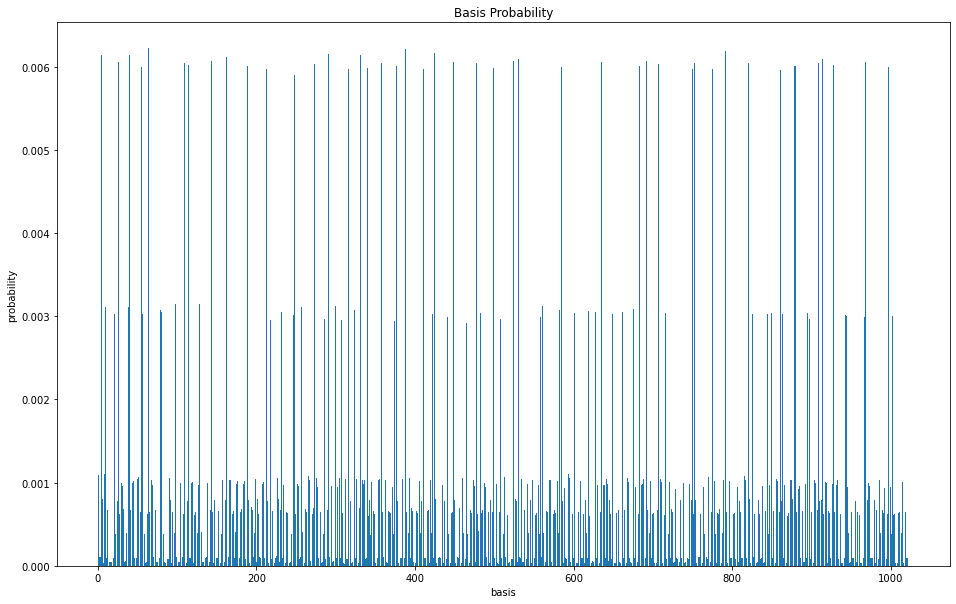

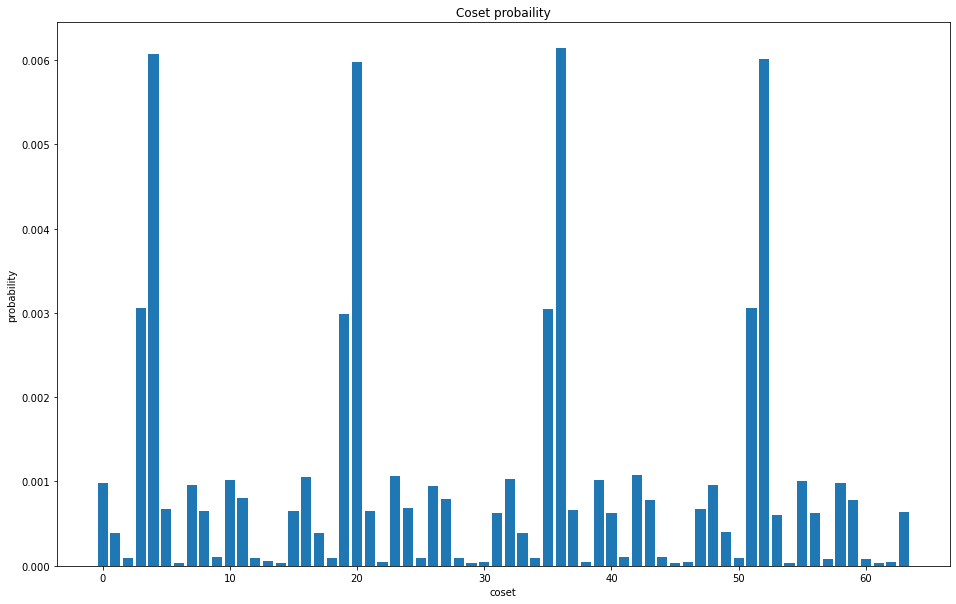

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 1. 1. 0.]




 Runningtime :  1255.832867860794 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 1 0 0 0 1 1 0 0]
 [0 0 1 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0 0]
 [0 1 0 0 1 0 1 0 1 1]
 [0 0 0 1 0 0 1 0 0 0]
 [0 1 1 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 0 1 1 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.048482064623919185

total probability logical X:  0.04831393144394683

total probability logical Z:  0.048480700278399395

total probability logical Y:  0.04831605369673709

 coset without doing anything : 0.005859375

matching syndrome probability 0.1935927500430025

rate: 0.25043326577648145

cannot correct


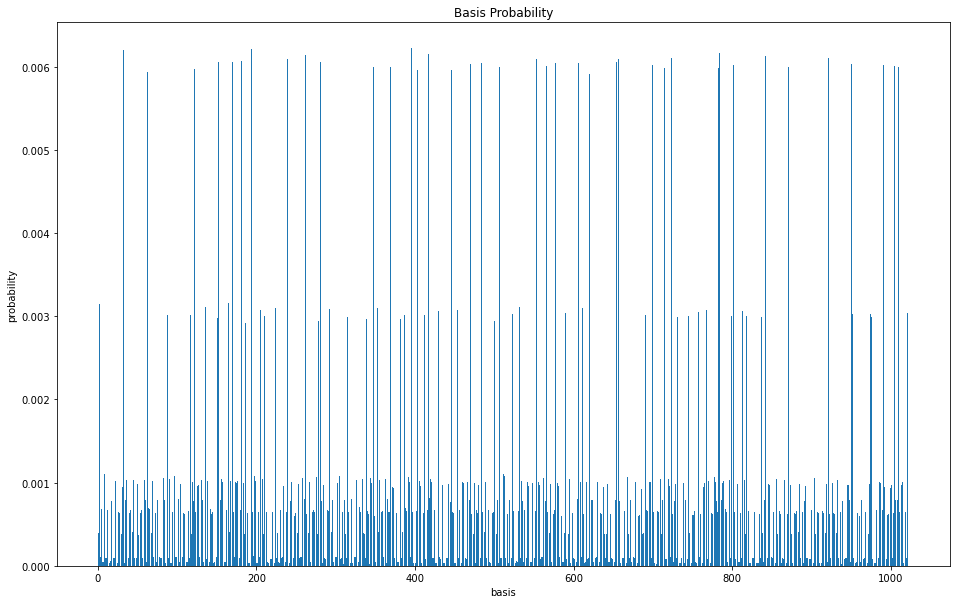

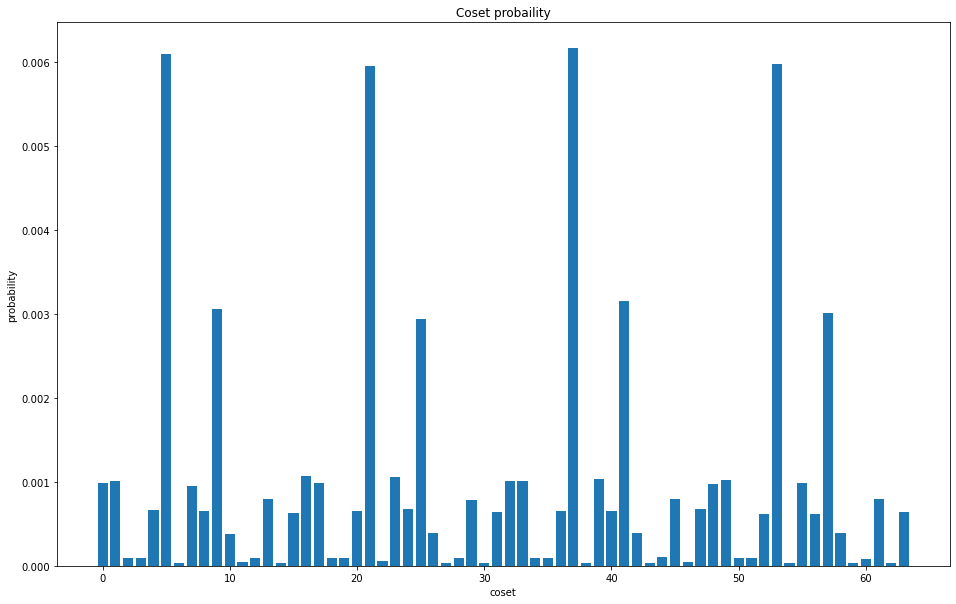

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 0. 0.]




 Runningtime :  1264.5229406356812 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 0 0 1 0 1 0 0 1]
 [0 0 0 1 0 0 1 0 1 0]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 1 1 0 0 0 1 1 1 0]
 [0 0 1 0 0 0 0 1 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0]]

check
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.04848542174787839

total probability logical X:  0.048317298638744295

total probability logical Z:  0.048481555225080214

total probability logical Y:  0.04831671446029317

 coset without doing anything : 0.005859375

matching syndrome probability 0.19360099007199608

rate: 0.25043994728460683

cannot correct


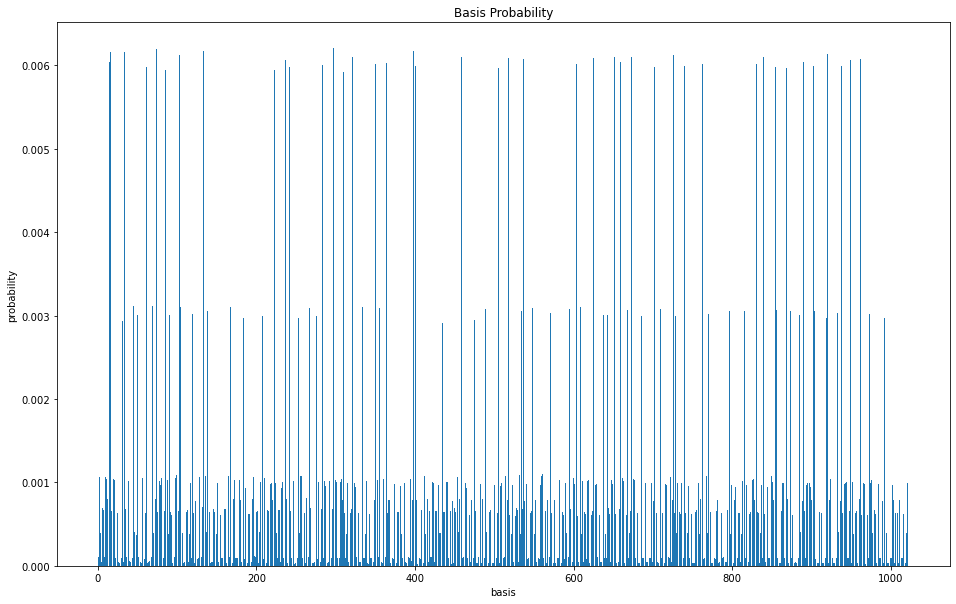

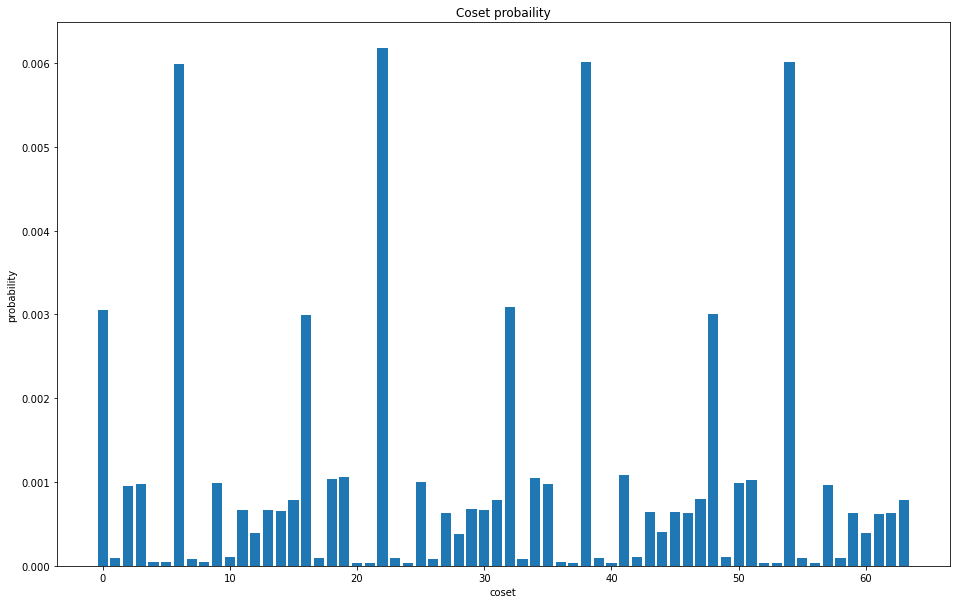

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [0. 1. 0. 1. 0.]




 Runningtime :  1263.8993060588837 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [1 0 1 0 0 1 0 1 0 0]
 [0 1 0 1 1 0 1 0 1 1]
 [0 0 0 0 1 0 0 1 0 1]
 [0 1 1 1 0 0 1 1 0 0]
 [0 1 1 0 0 0 1 0 0 1]
 [0 1 0 1 0 0 0 1 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.048483219517274266

total probability logical X:  0.048315505782497825

total probability logical Z:  0.04847960864109951

total probability logical Y:  0.04831445180259397

 coset without doing anything : 0.005859375

matching syndrome probability 0.19359278574346558

rate: 0.2504391851745991

correct!


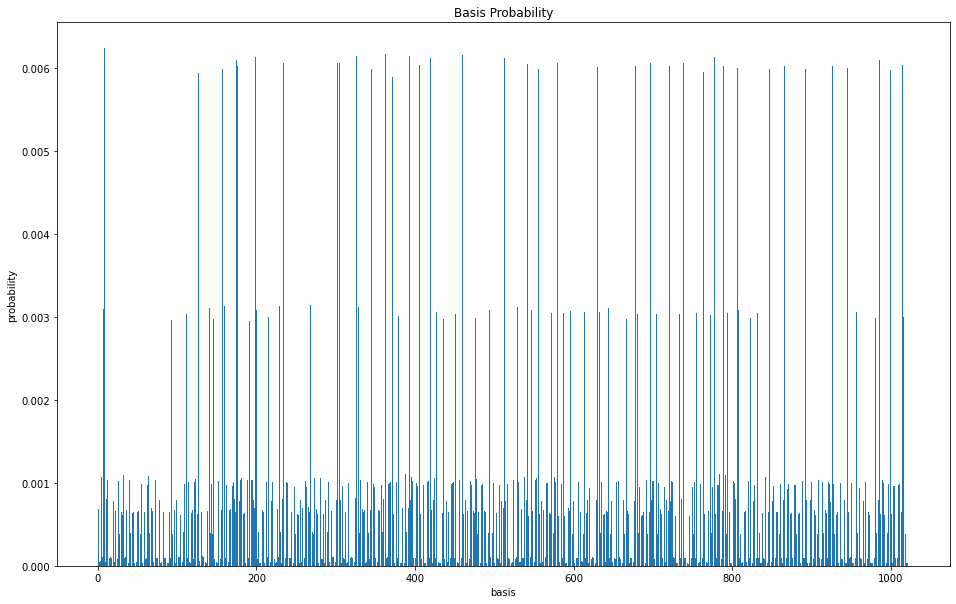

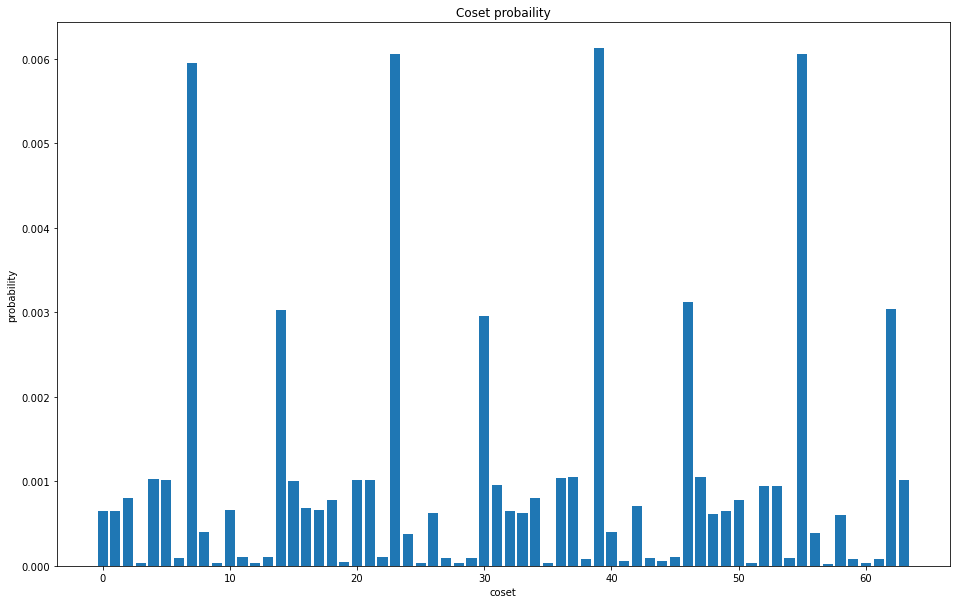

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [0. 0. 1. 0. 1.]




 Runningtime :  1261.7746732234955 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 0 1 0 0]
 [0 1 0 1 0 0 1 0 1 0]
 [0 0 0 0 1 0 1 0 0 1]
 [1 0 0 0 0 1 0 0 1 0]
 [0 0 1 0 1 0 0 0 1 1]
 [0 0 1 0 0 0 1 1 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [0 1 1 1 0 0 0 0 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.04848403531687452

total probability logical X:  0.04831590409605356

total probability logical Z:  0.04848276419388842

total probability logical Y:  0.04831803736345738

 coset without doing anything : 0.005859375

matching syndrome probability 0.19360074097027388

rate: 0.2504331082302982

correct!


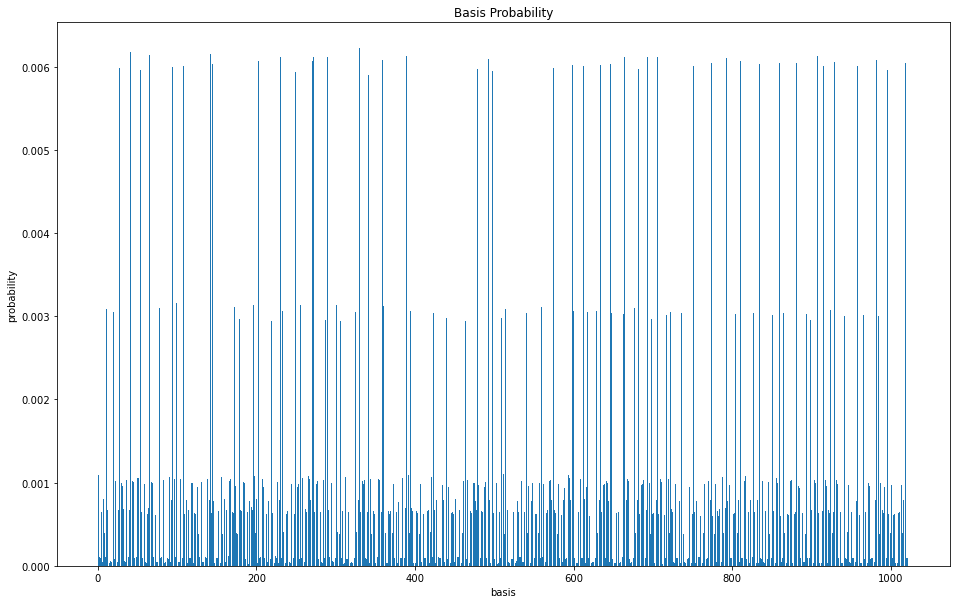

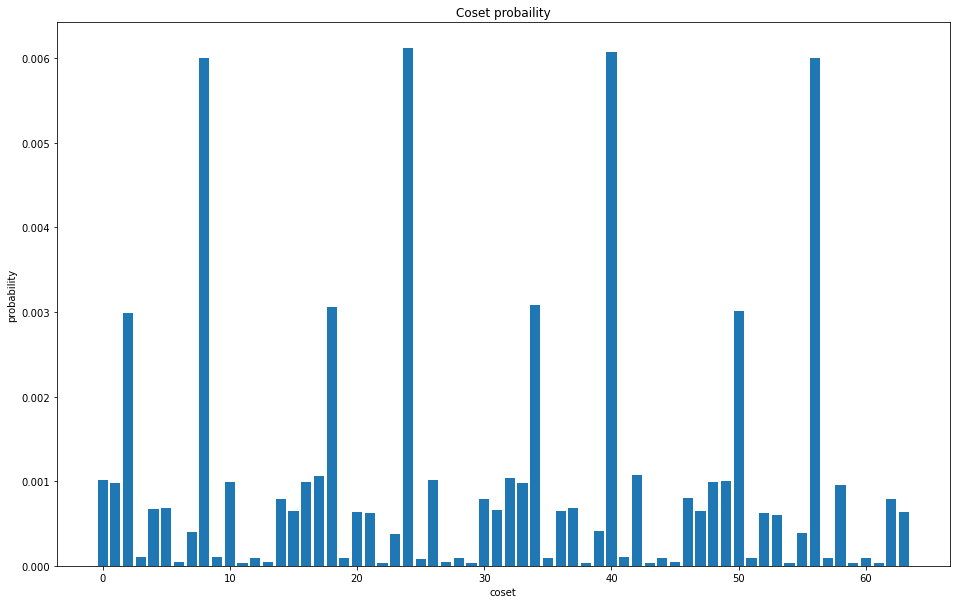

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 0. 1. 1. 0.]




 Runningtime :  1260.1272931098938 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 1 0 0 1 0 1]
 [0 0 1 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 1 0 0 1]
 [0 1 1 1 0 0 0 1 1 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 1 0 0]
 [1 1 0 1 0 1 1 0 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.04848448376431945

total probability logical X:  0.048316334631811425

total probability logical Z:  0.04848232953347252

total probability logical Y:  0.048317595946464176

 coset without doing anything : 0.005859375

matching syndrome probability 0.19360074387606757

rate: 0.2504354208233648

correct!


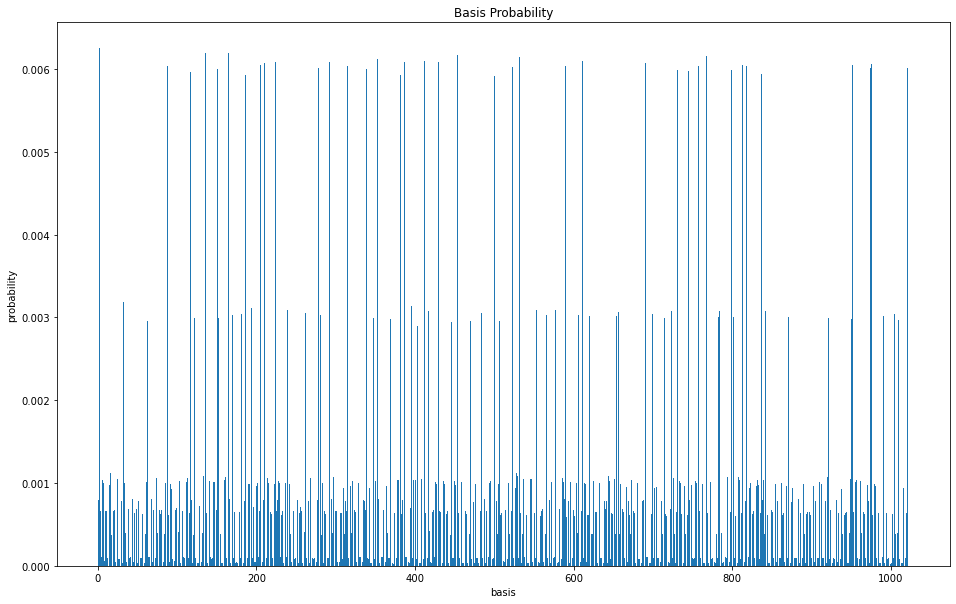

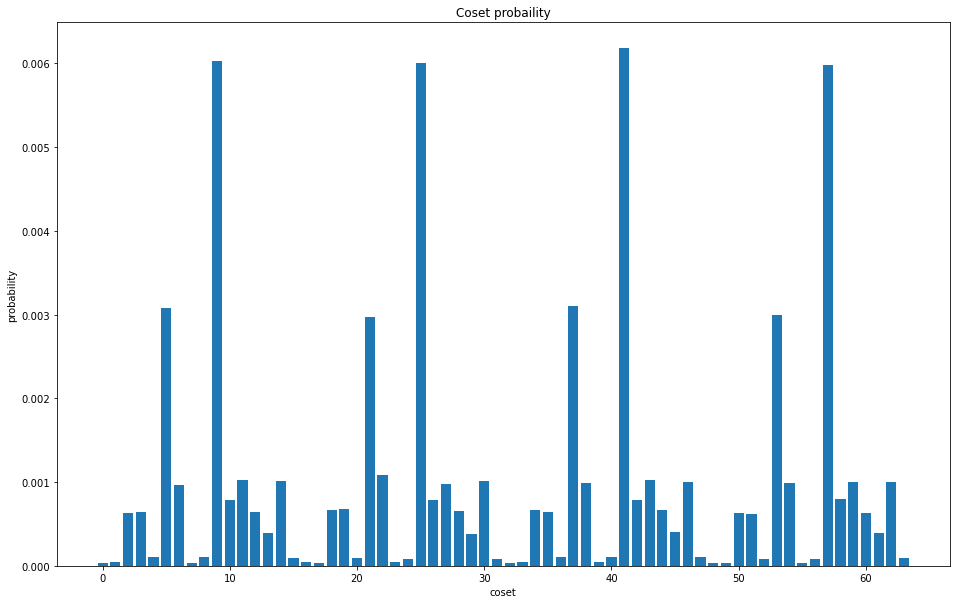

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 0. 0. 1.]




 Runningtime :  1259.8276326656342 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 1 0 0 0 0 0 0 0]
 [1 0 0 1 0 1 0 0 1 0]
 [0 1 1 0 1 0 1 1 0 1]
 [0 0 1 1 1 0 0 0 1 1]
 [0 0 0 1 0 0 0 1 0 0]
 [0 0 1 1 0 0 1 1 1 0]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.04848202257077826

total probability logical X:  0.04831670287372408

total probability logical Z:  0.04848081114168135

total probability logical Y:  0.04831326753433751

 coset without doing anything : 0.005859375

matching syndrome probability 0.1935928041205212

rate: 0.25043297859664126

cannot correct


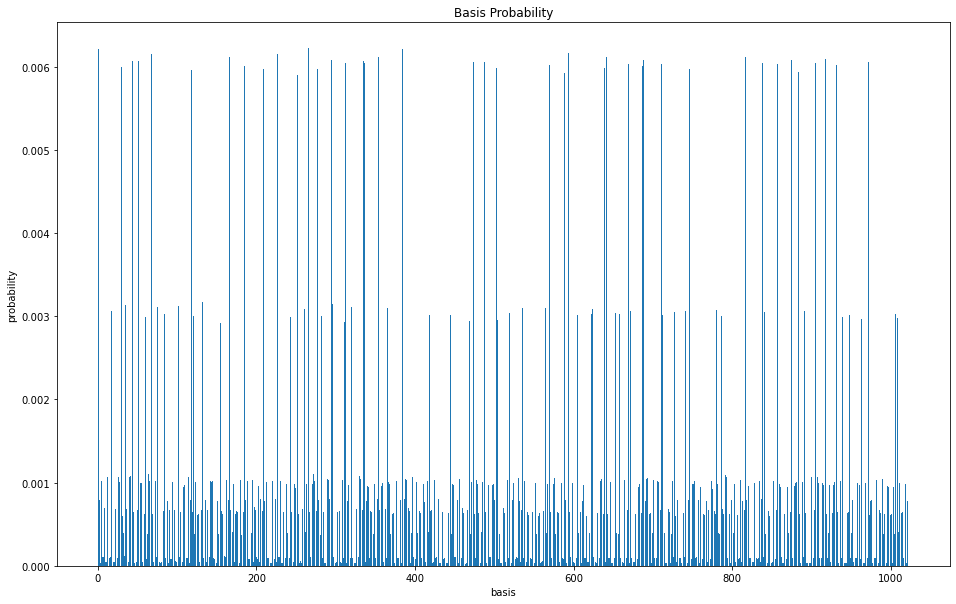

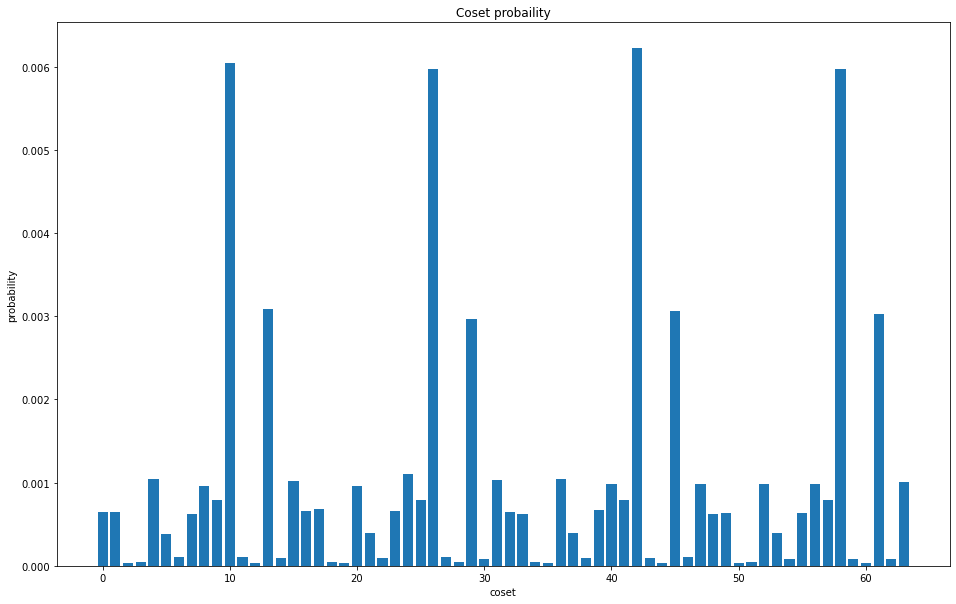

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 1. 1.]




 Runningtime :  1260.5019056797028 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[1 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 1]
 [0 1 0 1 0 0 1 0 0 0]
 [0 0 1 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 1 0 0 0 0 1 1]
 [0 1 1 1 0 0 0 0 1 0]
 [0 1 0 0 1 0 0 0 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.04831918493901214

total probability logical X:  0.048483733000527156

total probability logical Z:  0.048315042238595604

total probability logical Y:  0.04848309697329955

 coset without doing anything : 0.005859375

matching syndrome probability 0.19360105715143444

rate: 0.24958120399733638

correct!


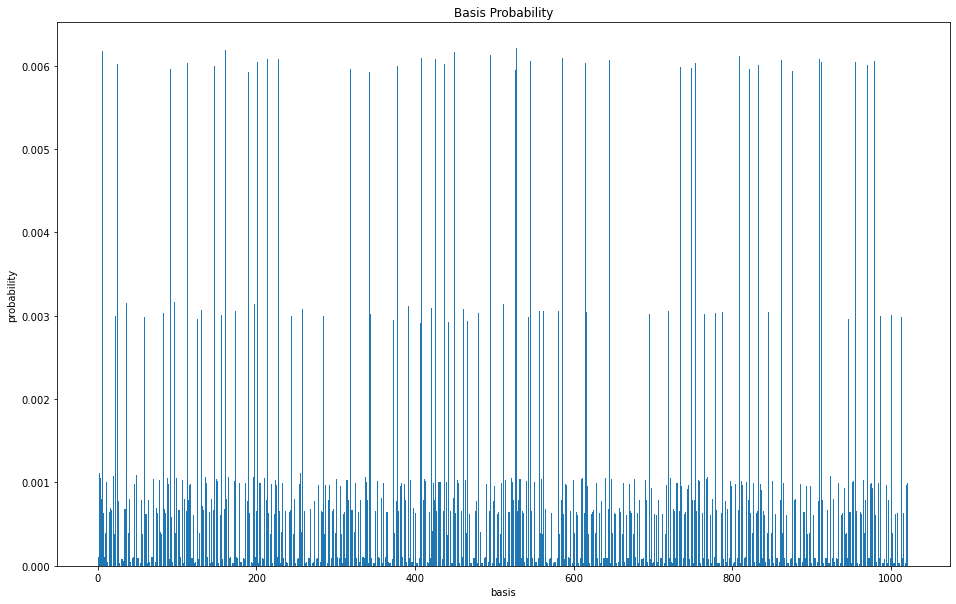

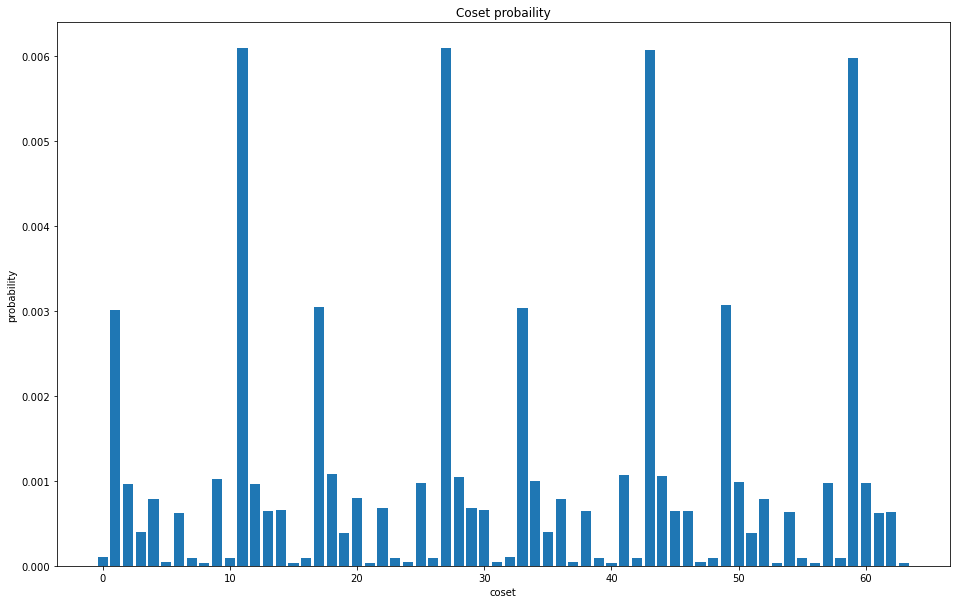

error:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [1. 1. 1. 1. 1.]




 Runningtime :  1260.475958108902 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 1 1]
 [0 1 1 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 1 0 1 0 1 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.048484460556364836

total probability logical X:  0.048316652036873776

total probability logical Z:  0.048482598443371425

total probability logical Y:  0.048317382186060034

 coset without doing anything : 0.005859375

matching syndrome probability 0.19360109322267005

rate: 0.25043484904602525

correct!


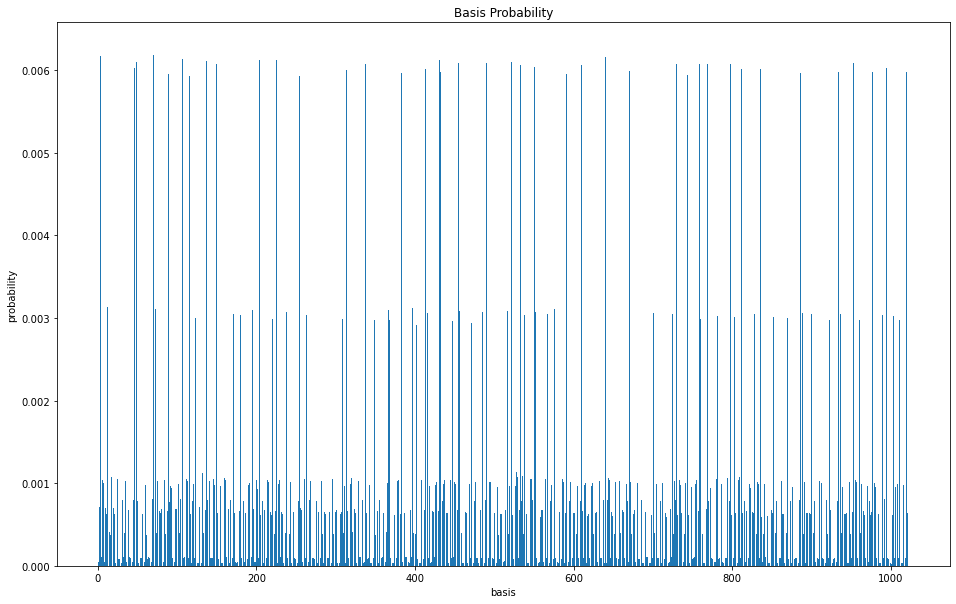

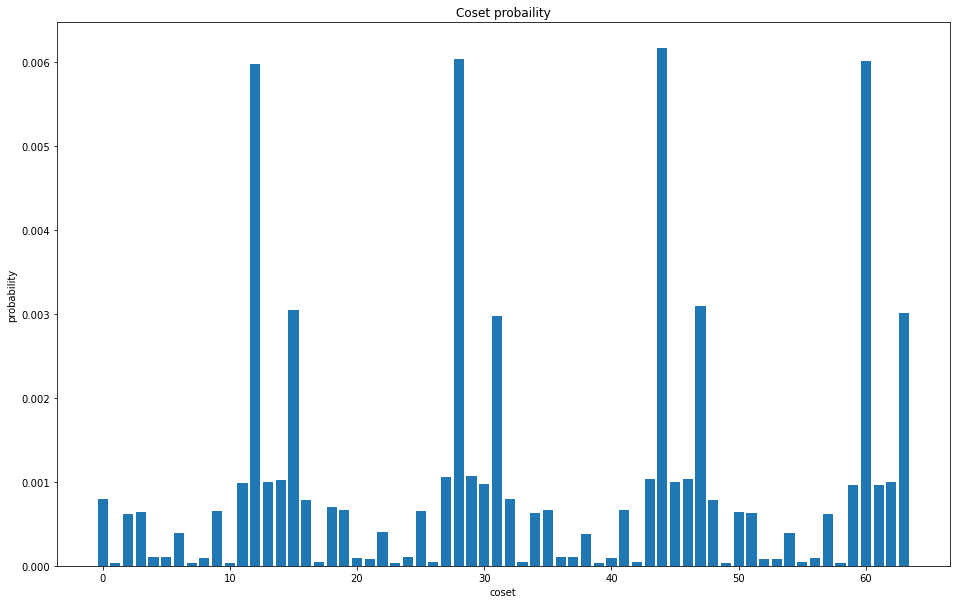

error:  [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [1. 1. 0. 0. 1.]




 Runningtime :  1258.6134791374207 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 1 1]
 [0 1 1 1 0 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 1 0 0 0]
 [1 0 0 1 0 0 0 0 1 0]
 [1 0 0 0 0 1 1 0 0 0]
 [0 0 1 0 1 0 1 0 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.048485251555418975

total probability logical X:  0.04831750238615495

total probability logical Z:  0.048481624170106444

total probability logical Y:  0.04831642109103598

 coset without doing anything : 0.005859375

matching syndrome probability 0.19360079920271636

rate: 0.25043931510143624

correct!


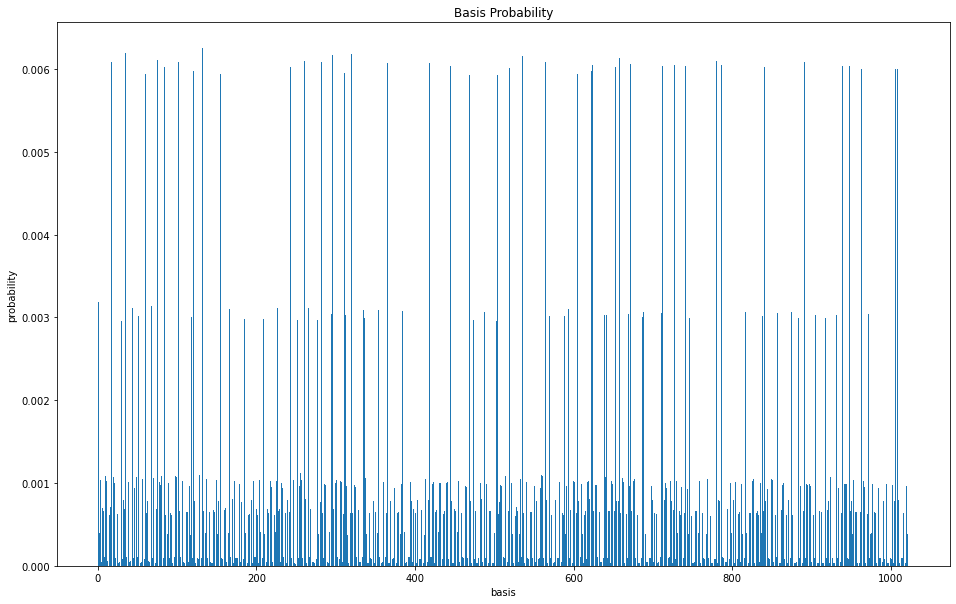

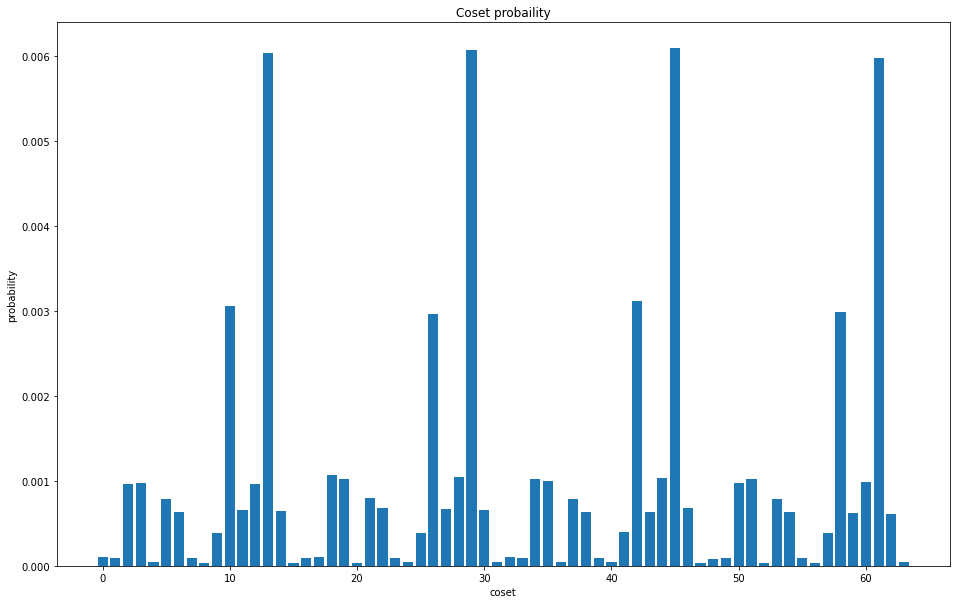

error:  [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 1. 0. 1. 0.]




 Runningtime :  1261.5267748832703 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 1 1 0 0]
 [0 1 1 0 0 0 0 1 1 0]
 [1 0 1 0 0 0 0 1 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [1 1 0 0 0 1 1 0 1 0]
 [1 0 0 0 0 1 0 0 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.048484050410638364

total probability logical X:  0.048318702544827244

total probability logical Z:  0.04848281130158884

total probability logical Y:  0.04831521648396516

 coset without doing anything : 0.005859375

matching syndrome probability 0.19360078074101963

rate: 0.2504331347480237

correct!


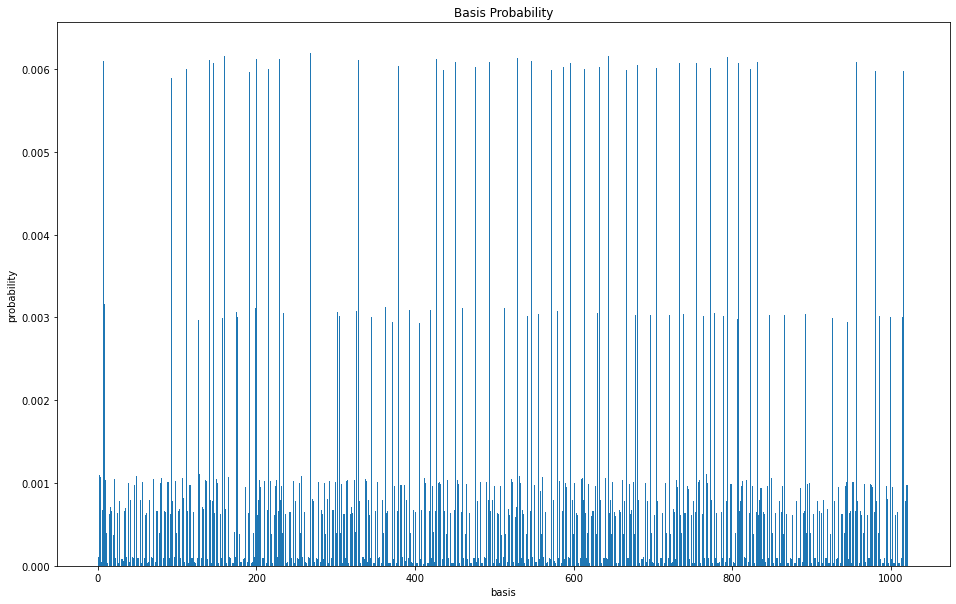

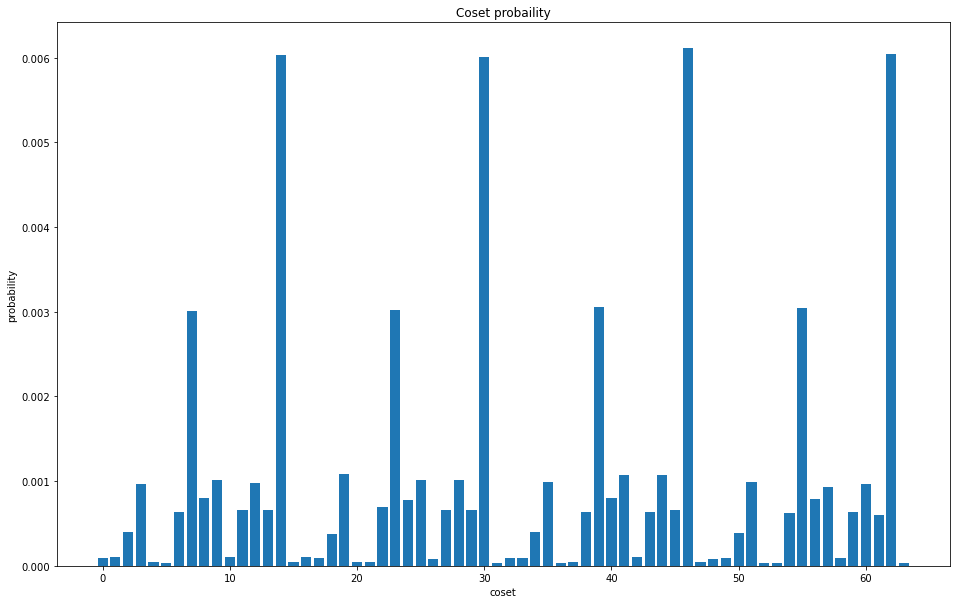

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 1. 1. 1.]




 Runningtime :  1258.9302039146423 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 1 0 0 0 0 1]
 [0 1 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 1 0]
 [1 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 1 1 1 0 0 1 0 0 0]
 [0 1 1 0 0 0 1 1 0 1]
 [0 1 0 0 0 1 1 0 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.048482814767853245

total probability logical X:  0.048317432984696575

total probability logical Z:  0.04848424880078976

total probability logical Y:  0.04831661773856282

 coset without doing anything : 0.005859375

matching syndrome probability 0.1936011142919024

rate: 0.25042632086689953

correct!


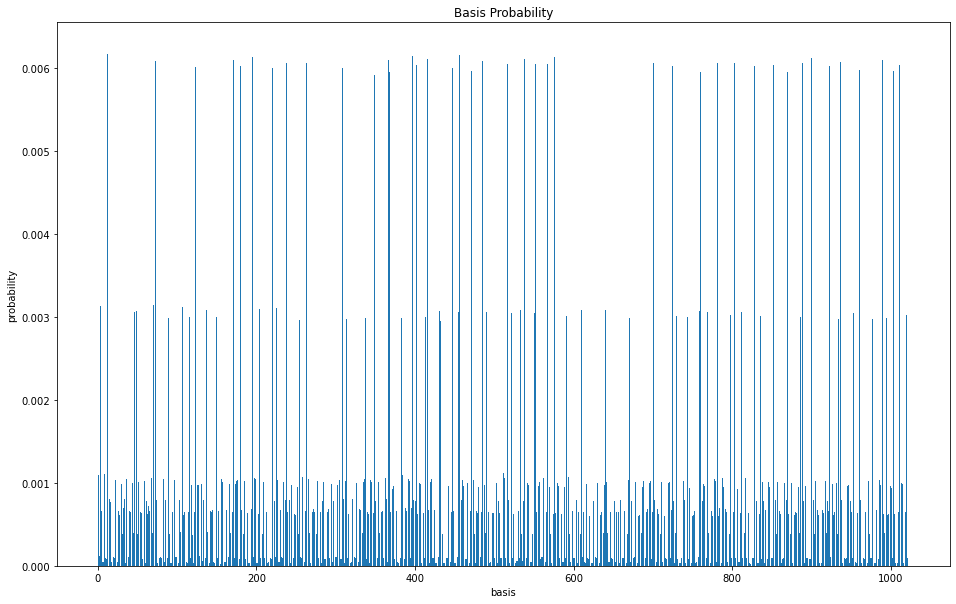

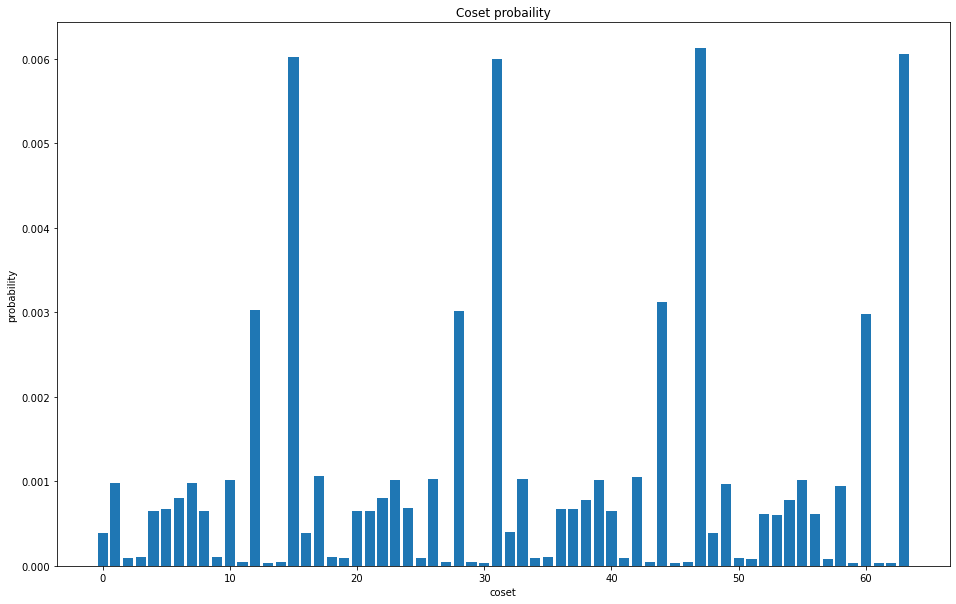

In [5]:
probability = []
gamma = []
beta = []
syndrome = []
cor_rate = []


num = int(M.shape[1]/2)

min_weight_term = min_weight(M.shape[1])
pen = 0.1

good = 0
    

for d in trange(len(err)):
    coset_prob = []
    probability = []
    n = M.shape[1]
    print('error: ', err[d])
    syndr = row_binary(M.dot(err[d]))
    C = (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + pen * min_weight_term
    
    B = B_generator(M.shape[1])
    print('\nsyndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    res = QAOA_finegrid(C,B,n,0.1)
    
    f_p_max_gamma = res[0]
    f_p_max_beta = res[1]
#     print(res[2])
    
    
    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")

    r = np.ones(2**M.shape[1])/np.sqrt(2**M.shape[1])
    #Construct U_C
    
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    
    print('\ngamma:', f_p_max_gamma,'beta:',f_p_max_beta )
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))      

    probability.append(prob)
    max_index = prob_sort(prob,8)


    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print('\nestimate error :\n',(np.array(word)))


    err_8 = []
    for q in range(8):
          err_8.append(err[d])


    check  = matrix_binary(((np.array(word) - np.array(err_8)).dot(L)).dot(G.T))

    print('\ncheck\n' ,check)


    degen_index = []
    degen_x_index = []
    degen_z_index = []
    degen_y_index = []


    for b in range(2**(H_oringin.shape[0]-1)):
        degen_index.append(converter((degenerate_error(err[d], H_oringin)[b])))
        degen_x_index.append(converter((degenerate_error(logical_x_error[d], H_oringin)[b])))
        degen_z_index.append(converter((degenerate_error(logical_z_error[d], H_oringin)[b])))
        degen_y_index.append(converter((degenerate_error(logical_y_error[d], H_oringin)[b])))

    total_prob_I = 0
    total_prob_X = 0
    total_prob_Z = 0
    total_prob_Y = 0



    for c in range(len(degen_index)):
        total_prob_I += (probability[0][degen_index[c]])
        total_prob_X += (probability[0][degen_x_index[c]])
        total_prob_Z += (probability[0][degen_z_index[c]])
        total_prob_Y += (probability[0][degen_y_index[c]])


    print('\ntotal probability logical I: ', total_prob_I)
    print('\ntotal probability logical X: ', total_prob_X)
    print('\ntotal probability logical Z: ', total_prob_Z)
    print('\ntotal probability logical Y: ', total_prob_Y)
    print('\n coset without doing anything :', (H_oringin.shape[0]-1)/2**(M.shape[1]-1 ))
    print('\nmatching syndrome probability', total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y)
    print('\nrate:',  total_prob_I/( total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y))

    if sum(check[0][c] for c in range(len(check[0]))) == 0:
        print("\ncorrect!")
        good +=1
    else:
        print('\ncannot correct')


    
    for q in range(len(coset)):
        for f in range(len(coset[q])):
            c_prob = 0
            c_prob += probability[0][converter(coset[q][f])]
        coset_prob.append(c_prob)
    
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.title('Basis Probability')
    plt.ylabel('probability')
    plt.xlabel('basis')
    plt.show()
    plt.bar(range(0, len(coset_prob)),coset_prob)
    plt.title('Coset probaility')
    plt.ylabel('probability')
    plt.xlabel('coset')
    plt.show()
    time.sleep(0.5)

    
    
    


print(cor_rate) [0.6, 0.6, 0.6, 0.6]

In [8]:
pr = {'probability':probability[0]}
dfpr = pd.DataFrame(data = pr)
dfpr.sort_values(by = ['probability'], ascending = False)
print(sum(probability[0]))

0.7994205574436415


In [ ]:
d = {'gamma': gamma,'beta ': beta}
df = pd.DataFrame(data = d)
df   #(0.2,0.2) when p = 0.1)

## QAOA pen = 0

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 0. 0.]




 Runningtime :  1248.1201136112213 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 1 0 1 1 0 1 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 0 0 1 0]
 [0 0 0 1 1 1 0 1 1 1]
 [0 0 1 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 1 0 1]
 [0 0 0 1 0 0 0 1 0 1]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.04842089819879788

total probability logical X:  0.04842089819879768

total probability logical Z:  0.0484208981987979

total probability logical Y:  0.04842089819879768

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519115

rate: 0.25000000000000044

cannot correct


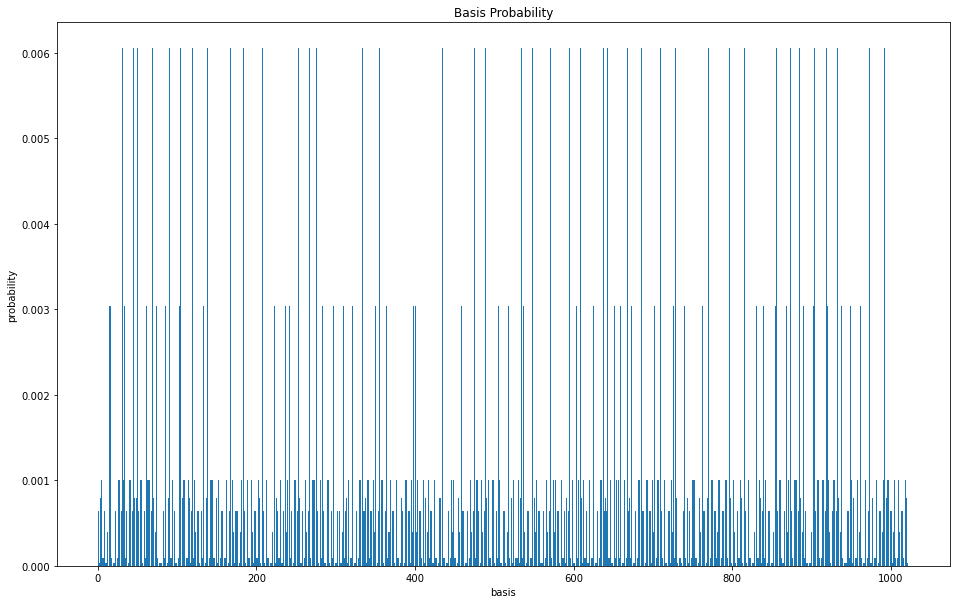

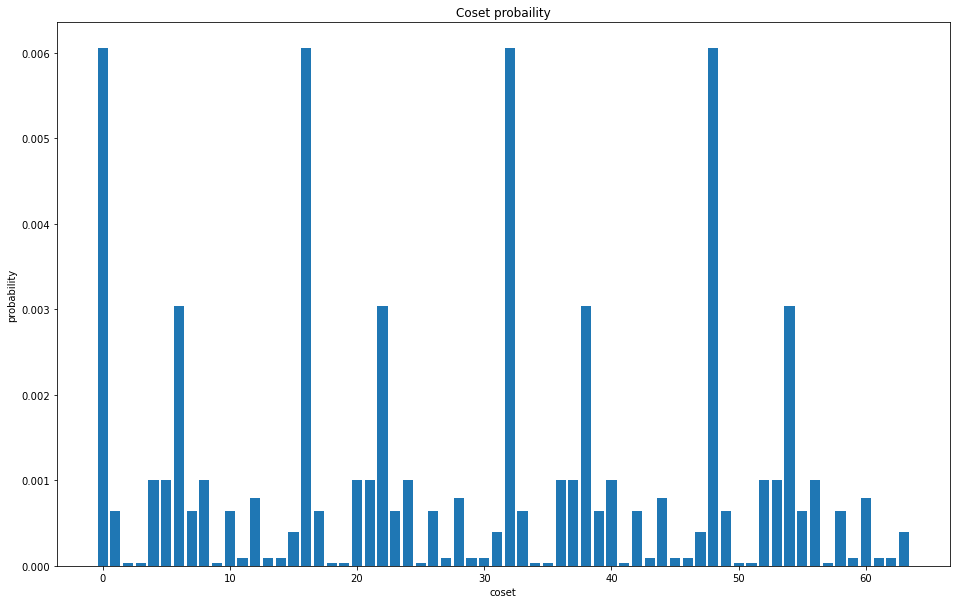

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 1. 1.]




 Runningtime :  1248.8577663898468 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 1 0 0 1]
 [0 0 0 1 1 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 1 0 1 1 0 0 0 1]
 [0 0 0 0 0 1 0 1 1 0]
 [0 0 0 0 1 1 1 0 1 1]
 [0 0 0 1 1 1 1 1 1 0]
 [0 0 0 1 0 1 0 0 1 1]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.04842089819879768

total probability logical X:  0.04842089819879789

total probability logical Z:  0.04842089819879767

total probability logical Y:  0.0484208981987979

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519115

rate: 0.24999999999999942

cannot correct


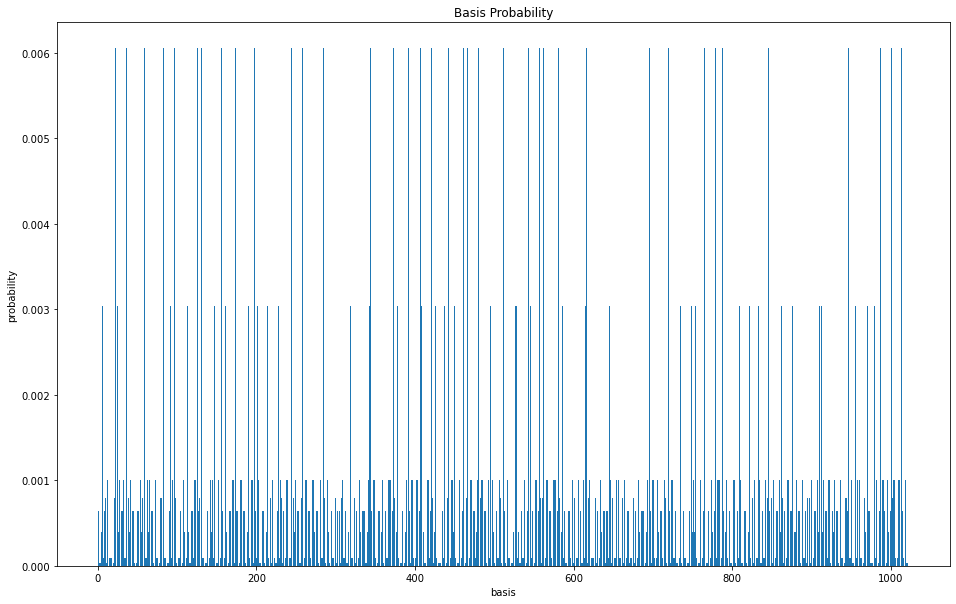

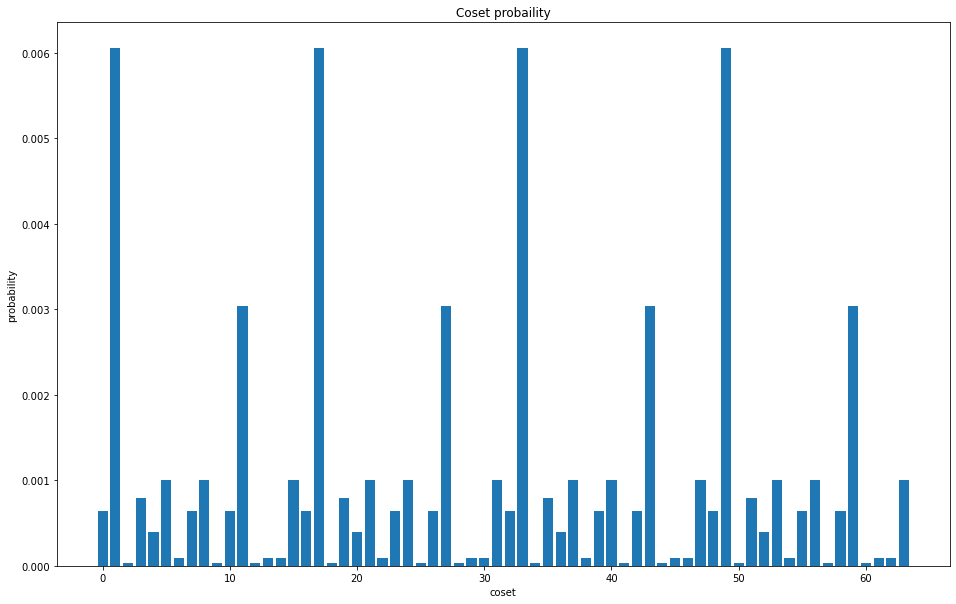

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 0. 1. 0. 1.]




 Runningtime :  1250.3641650676727 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 1 1 1 0 0 1]
 [0 0 1 0 1 1 0 0 1 1]
 [0 0 0 1 0 0 1 1 1 0]
 [0 0 0 1 0 1 0 0 0 1]
 [0 0 0 1 1 1 1 1 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 0 1 1 0]
 [0 0 1 0 0 0 0 0 0 1]]

check
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.0484208981987979

total probability logical X:  0.04842089819879767

total probability logical Z:  0.048420898198797906

total probability logical Y:  0.04842089819879767

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519115

rate: 0.25000000000000056

cannot correct


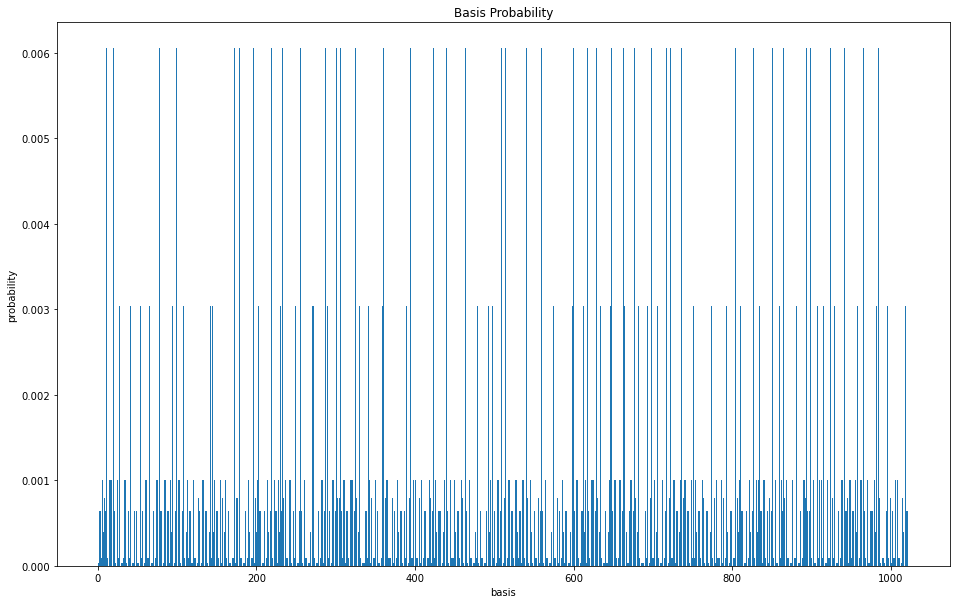

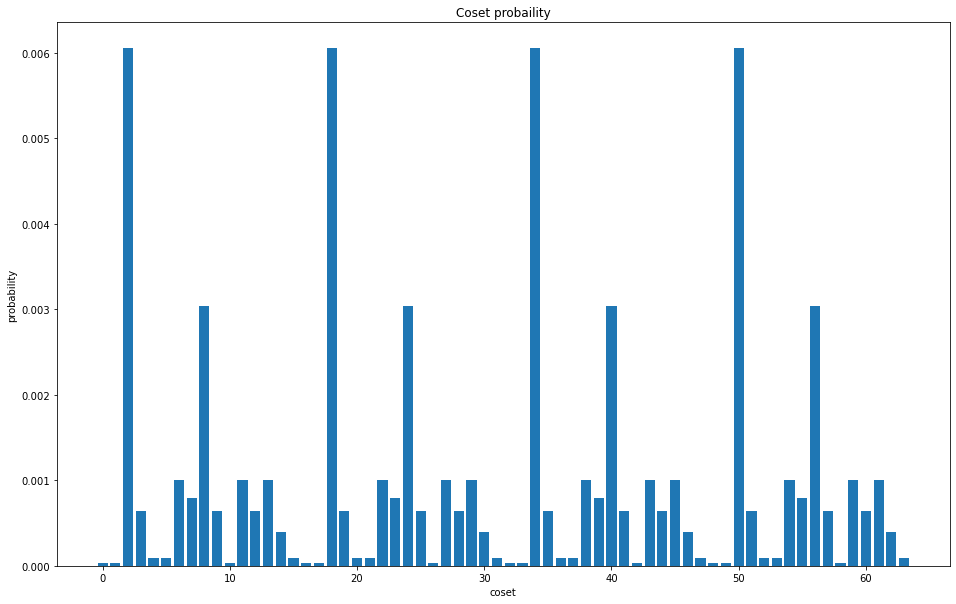

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 1. 1. 0. 0.]




 Runningtime :  1248.8166089057922 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 1 0 0 1 1 1]
 [0 0 0 1 1 0 0 0 1 0]
 [0 0 1 0 1 1 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 1 0 1]
 [0 0 0 1 0 0 1 1 1 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 0]]

check
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.0484208981987979

total probability logical X:  0.048420898198797684

total probability logical Z:  0.04842089819879789

total probability logical Y:  0.048420898198797656

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519112

rate: 0.2500000000000006

cannot correct


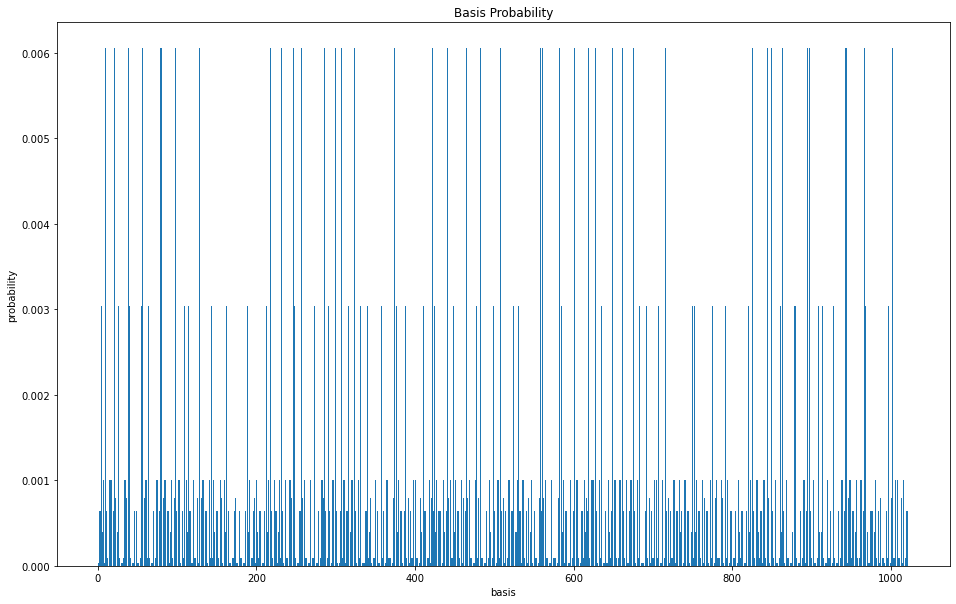

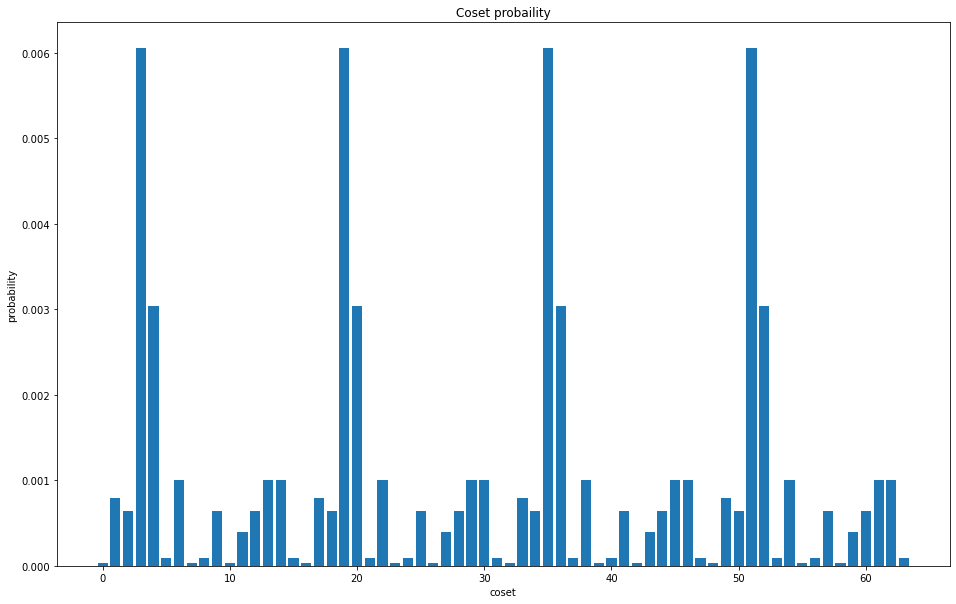

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 1. 1. 0. 0.]




 Runningtime :  1247.1490111351013 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 1 1 0 1 0]
 [0 0 0 0 1 1 0 1 1 1]
 [0 0 0 0 0 0 0 1 0 1]
 [0 0 0 1 1 0 1 1 0 1]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0]
 [0 0 1 1 1 0 0 1 1 1]
 [0 0 0 1 1 1 0 0 1 0]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.0484208981987979

total probability logical X:  0.04842089819879768

total probability logical Z:  0.048420898198797906

total probability logical Y:  0.04842089819879767

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519115

rate: 0.25000000000000056

cannot correct


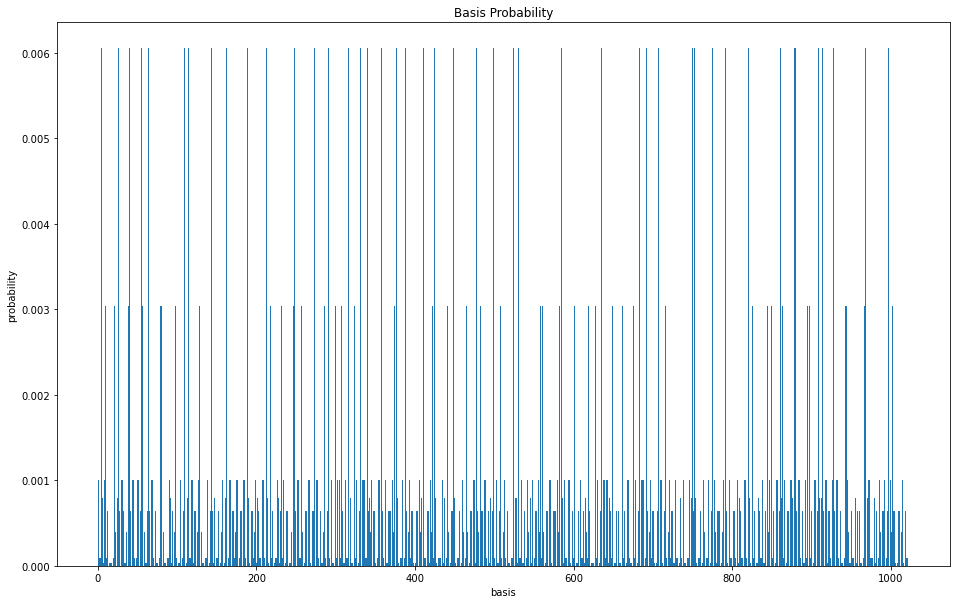

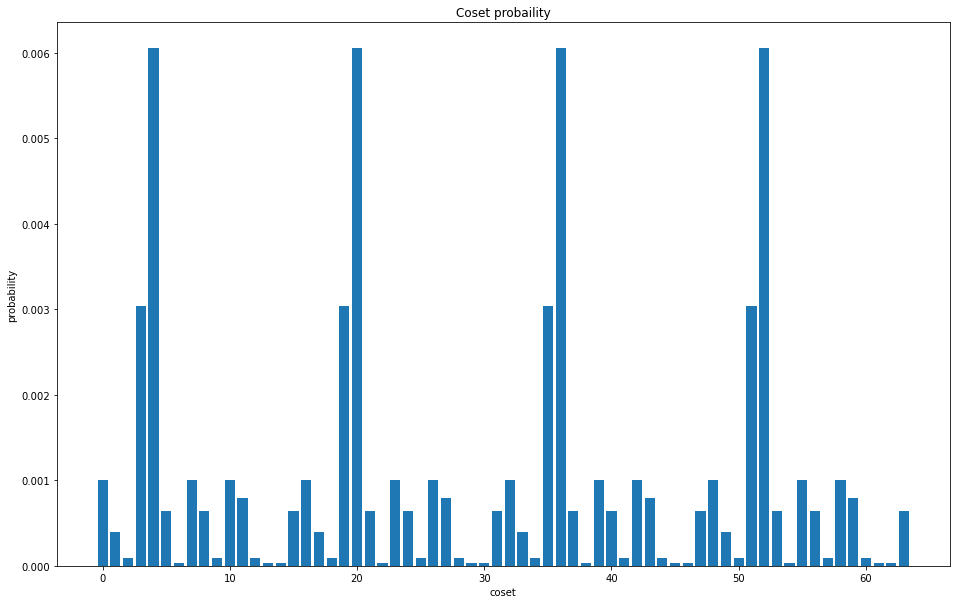

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 1. 1. 0.]




 Runningtime :  1247.3209216594696 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 1 1 1 1 1 1]
 [0 0 0 1 1 0 0 1 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 1 0 1 0 1]
 [0 0 0 1 0 1 0 1 1 1]
 [0 0 0 0 0 0 1 1 0 1]
 [0 0 1 1 0 0 0 0 1 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.04842089819879789

total probability logical X:  0.04842089819879769

total probability logical Z:  0.048420898198797885

total probability logical Y:  0.048420898198797684

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519115

rate: 0.25000000000000056

cannot correct


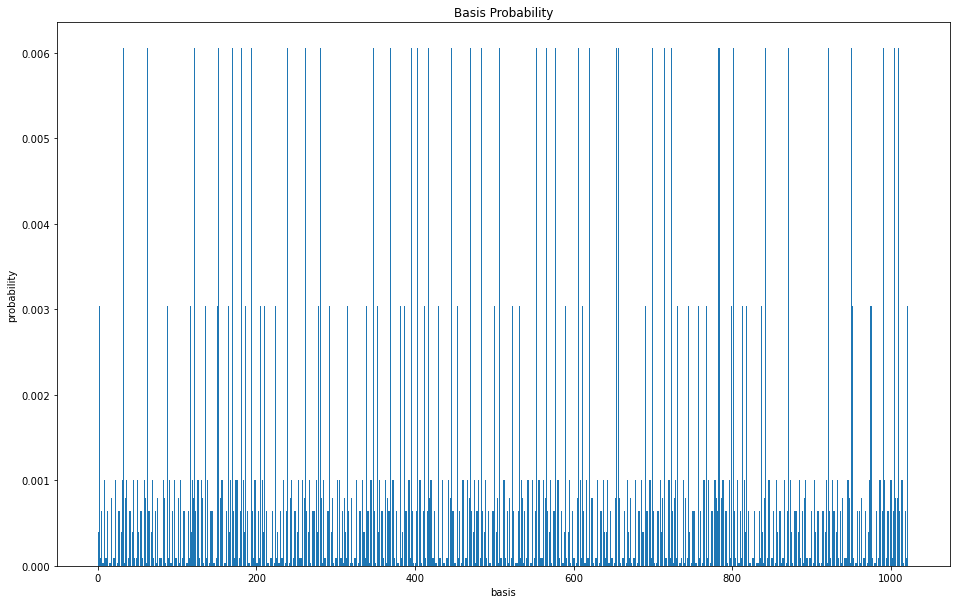

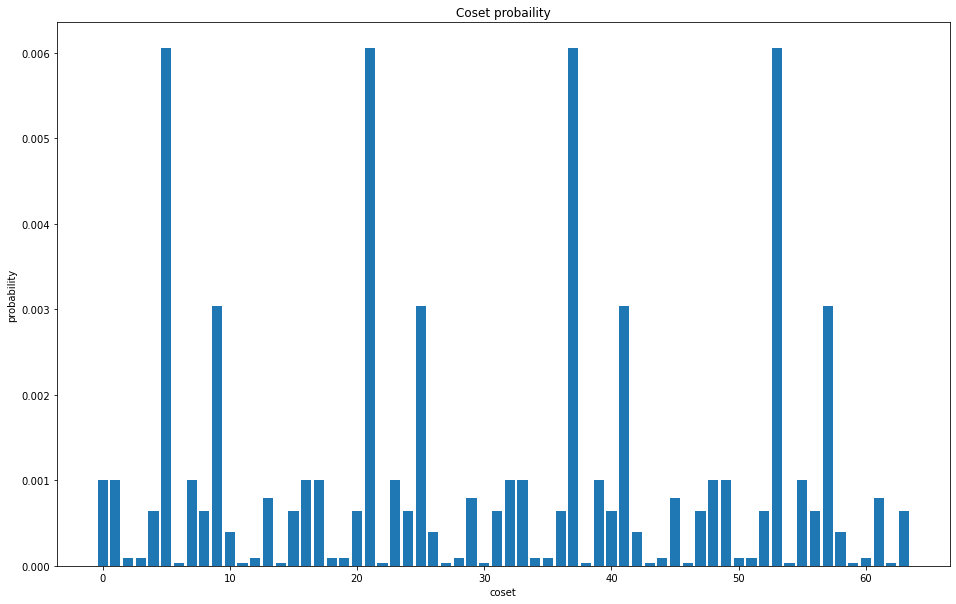

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 0. 0.]




 Runningtime :  1250.7016627788544 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 1 1 1 1]
 [0 0 0 1 0 1 0 1 0 1]
 [0 0 0 0 1 0 0 0 1 0]
 [0 0 1 1 0 1 1 1 1 1]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 1 0 0 1 1 0 1 0]
 [0 0 0 1 1 0 0 1 1 1]
 [0 0 0 0 1 1 1 1 0 1]]

check
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.048420898198797885

total probability logical X:  0.04842089819879767

total probability logical Z:  0.0484208981987979

total probability logical Y:  0.04842089819879768

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519115

rate: 0.2500000000000005

cannot correct


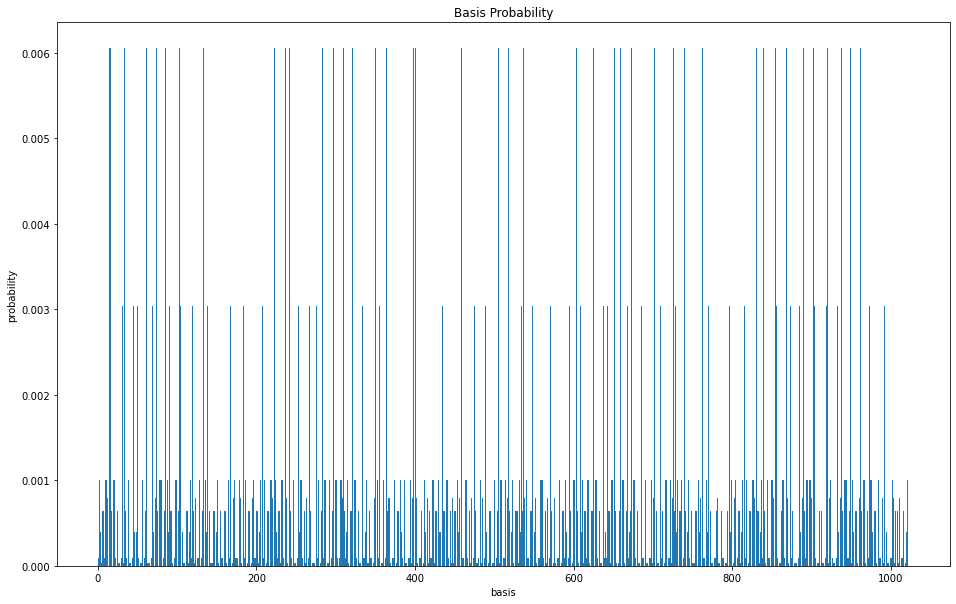

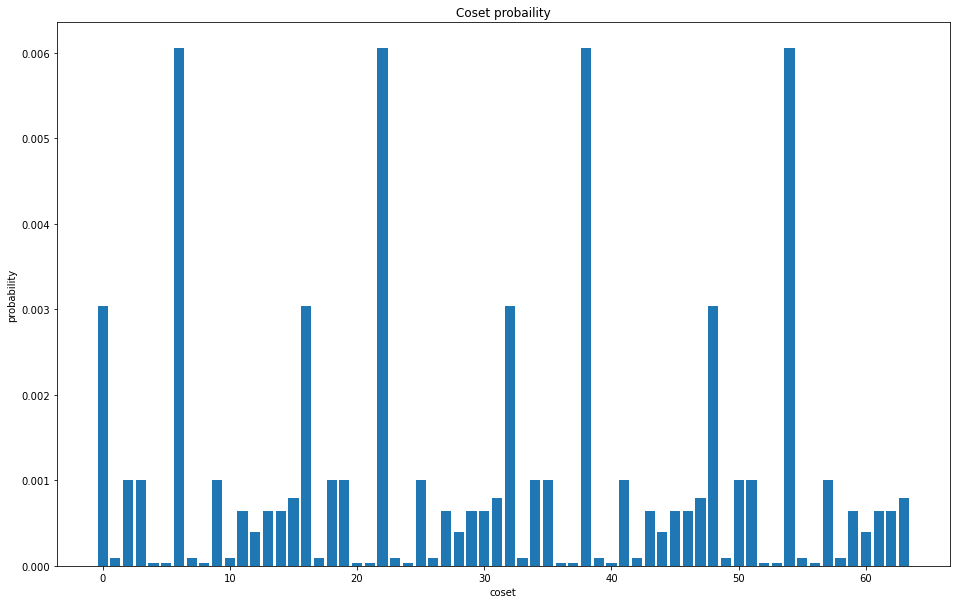

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [0. 1. 0. 1. 0.]




 Runningtime :  1249.5680356025696 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 1 1 1]
 [0 0 0 1 0 0 1 1 0 1]
 [0 0 0 0 1 1 1 0 1 0]
 [0 0 0 0 1 0 0 1 0 1]
 [0 0 1 0 1 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 1 0]
 [0 0 0 1 1 0 0 0 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.048420898198797906

total probability logical X:  0.04842089819879767

total probability logical Z:  0.0484208981987979

total probability logical Y:  0.04842089819879768

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519115

rate: 0.2500000000000006

correct!


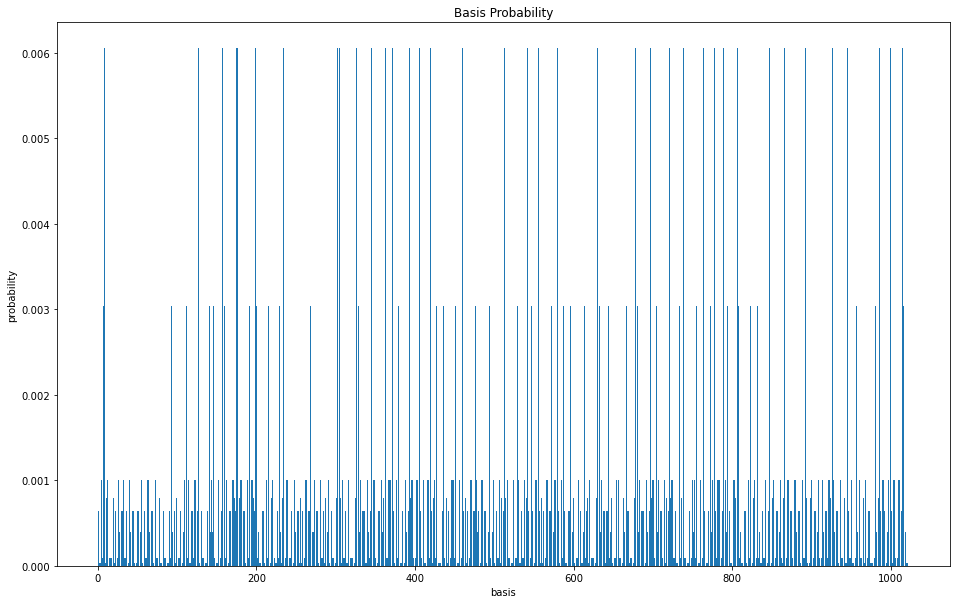

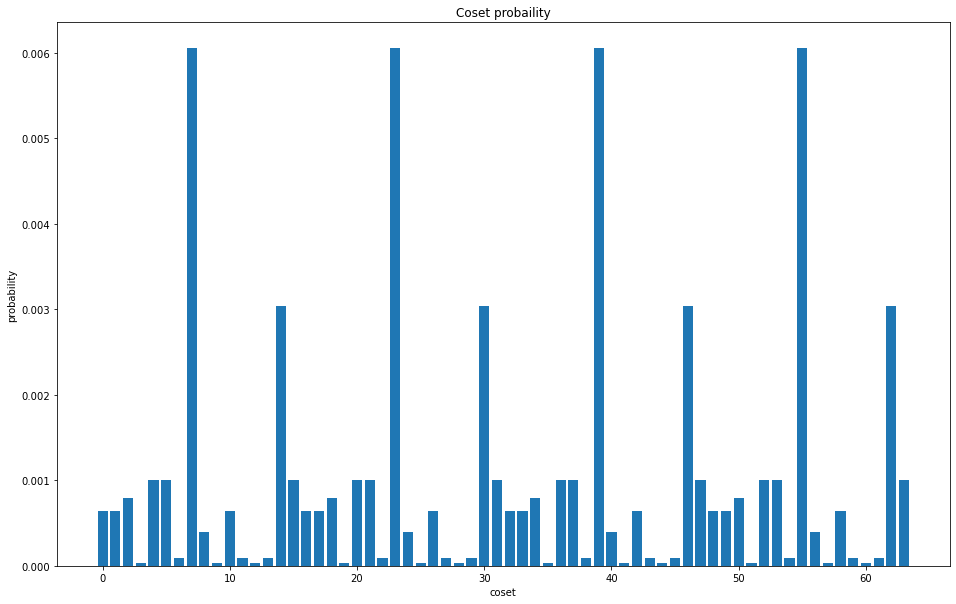

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [0. 0. 1. 0. 1.]




 Runningtime :  1250.5498676300049 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 1 0 0 1]
 [0 0 0 1 1 0 1 1 0 0]
 [0 0 0 0 0 1 1 0 1 1]
 [0 0 0 1 0 0 0 0 0 1]
 [0 0 1 1 0 0 1 0 1 1]
 [0 0 0 1 0 1 1 1 1 0]
 [0 0 1 0 1 1 1 1 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.048420898198797906

total probability logical X:  0.04842089819879767

total probability logical Z:  0.0484208981987979

total probability logical Y:  0.04842089819879767

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519112

rate: 0.25000000000000067

correct!


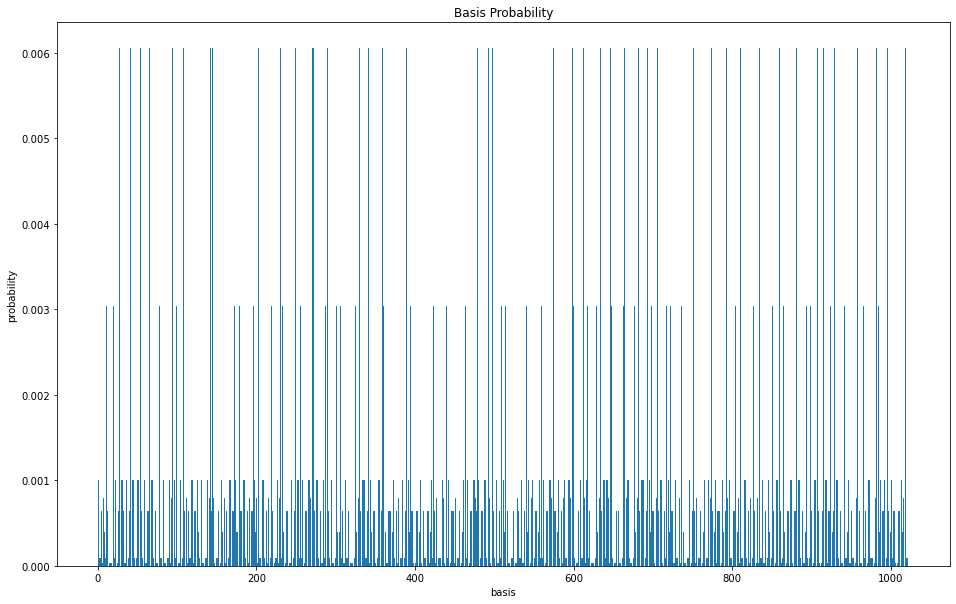

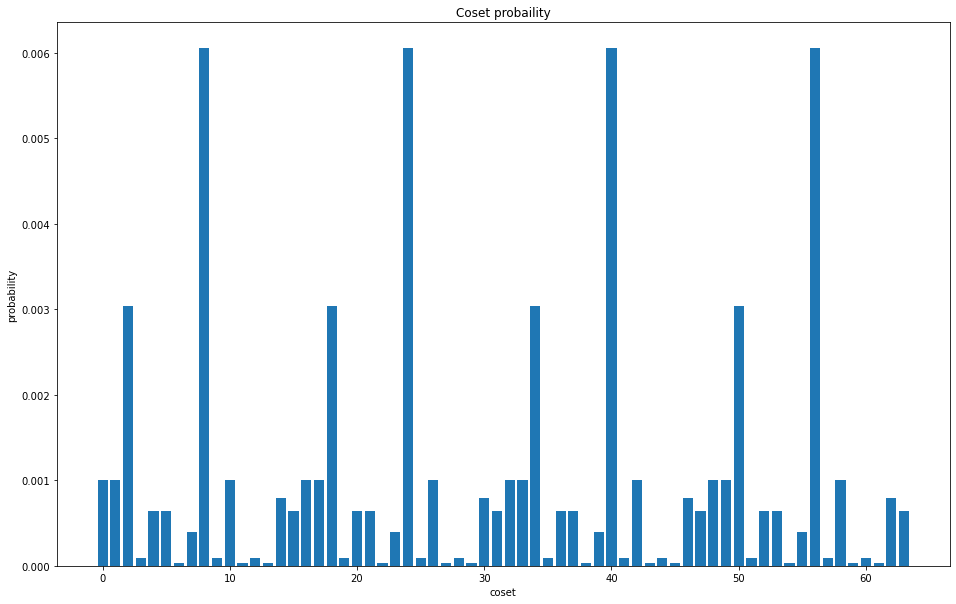

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 0. 1. 1. 0.]




 Runningtime :  1248.0430068969727 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 0 1]
 [0 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0]
 [0 0 1 0 0 1 0 1 1 1]
 [0 0 0 1 1 1 0 1 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]

total probability logical I:  0.04842089819879789

total probability logical X:  0.04842089819879766

total probability logical Z:  0.0484208981987979

total probability logical Y:  0.048420898198797684

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519115

rate: 0.25000000000000056

correct!


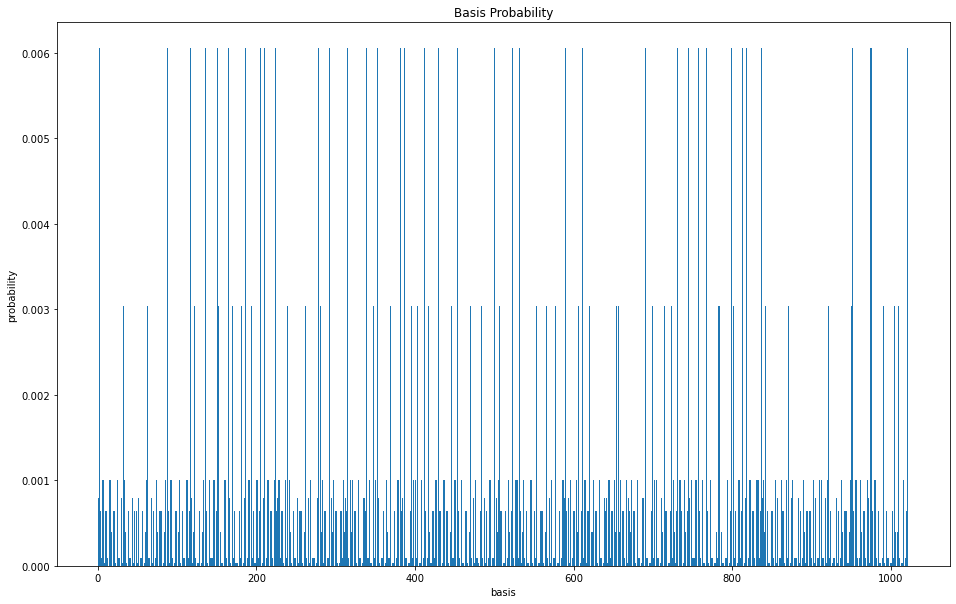

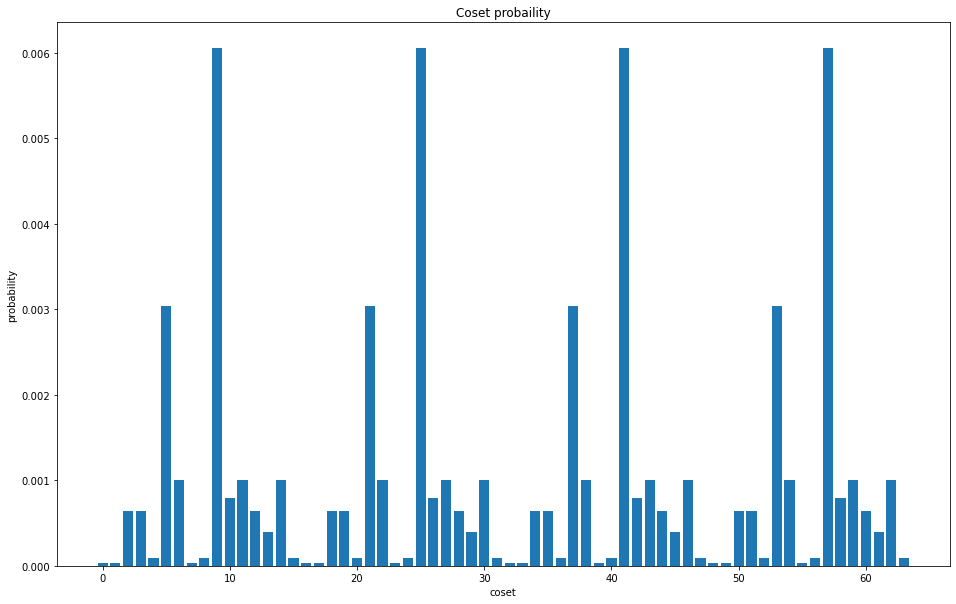

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 0. 0. 1.]




 Runningtime :  1249.8655223846436 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 1 1 0 1 1]
 [0 0 0 0 1 1 0 0 1 1]
 [0 0 0 0 1 0 1 1 0 0]
 [0 0 1 0 0 0 1 0 1 1]
 [0 0 0 1 0 0 0 1 0 0]
 [0 0 0 1 1 0 1 0 0 1]]

check
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.048420898198797885

total probability logical X:  0.04842089819879768

total probability logical Z:  0.04842089819879791

total probability logical Y:  0.04842089819879767

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519112

rate: 0.25000000000000056

cannot correct


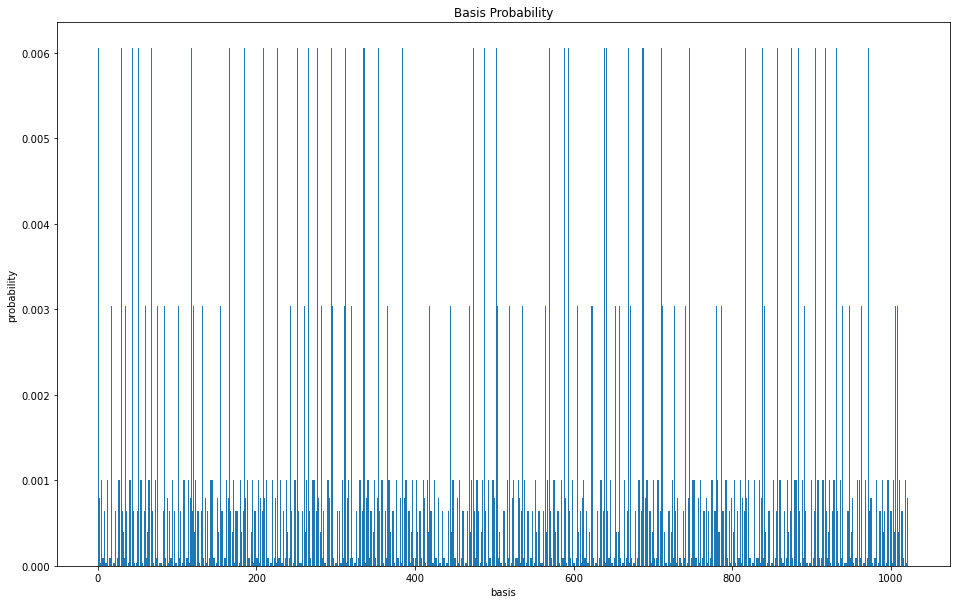

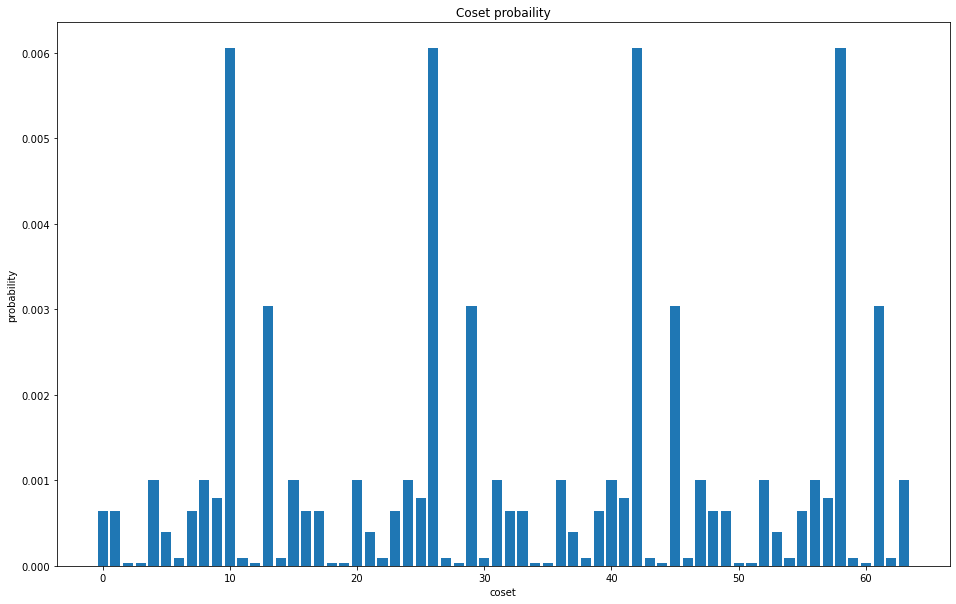

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 1. 1.]




 Runningtime :  1246.293353319168 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 1 1 0 0 1]
 [0 0 0 1 1 0 1 1 1 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 1 1 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 1]
 [0 0 0 0 1 0 1 0 1 1]
 [0 0 1 0 1 1 1 1 1 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.04842089819879767

total probability logical X:  0.0484208981987979

total probability logical Z:  0.04842089819879768

total probability logical Y:  0.0484208981987979

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519115

rate: 0.2499999999999994

cannot correct


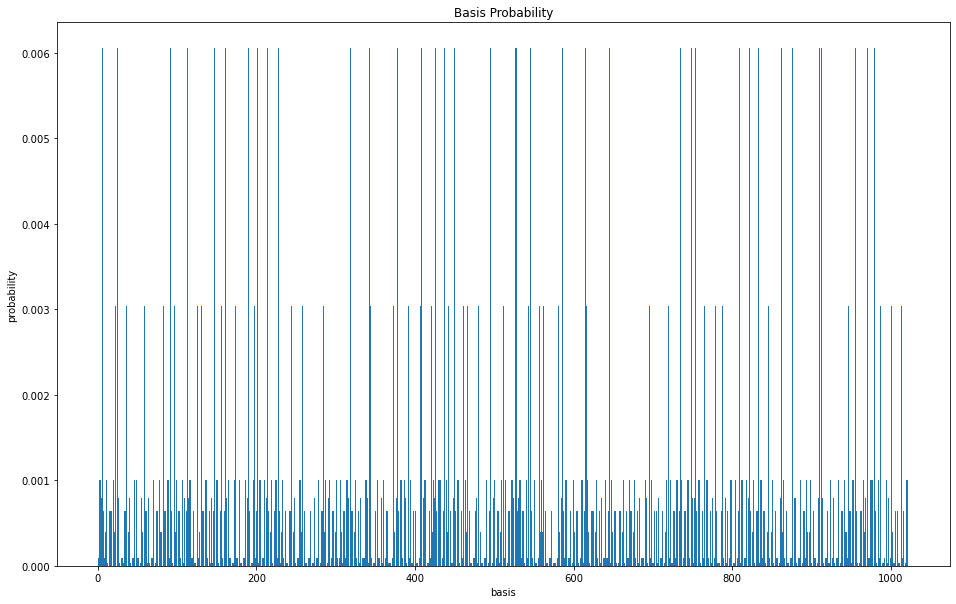

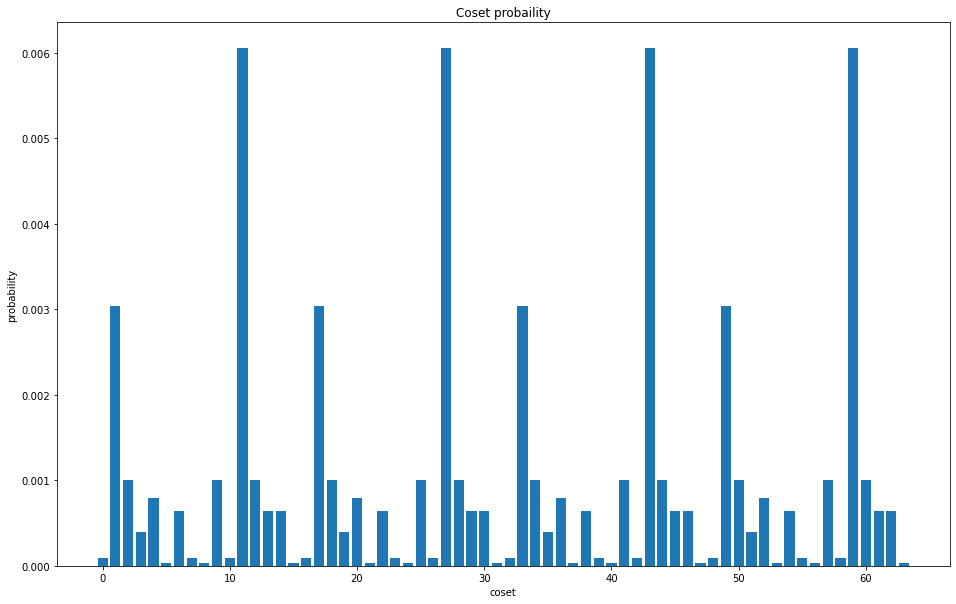

error:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [1. 1. 1. 1. 1.]




 Runningtime :  1246.249451160431 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 1 0 1 1 1 0]
 [0 0 0 1 0 1 1 0 0 1]
 [0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 1 1 0 0 0 1]
 [0 0 0 1 1 1 0 1 0 0]
 [0 0 0 1 1 0 1 0 1 1]
 [0 0 1 0 0 0 1 0 0 1]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.0484208981987979

total probability logical X:  0.04842089819879768

total probability logical Z:  0.0484208981987979

total probability logical Y:  0.04842089819879767

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519112

rate: 0.2500000000000006

cannot correct


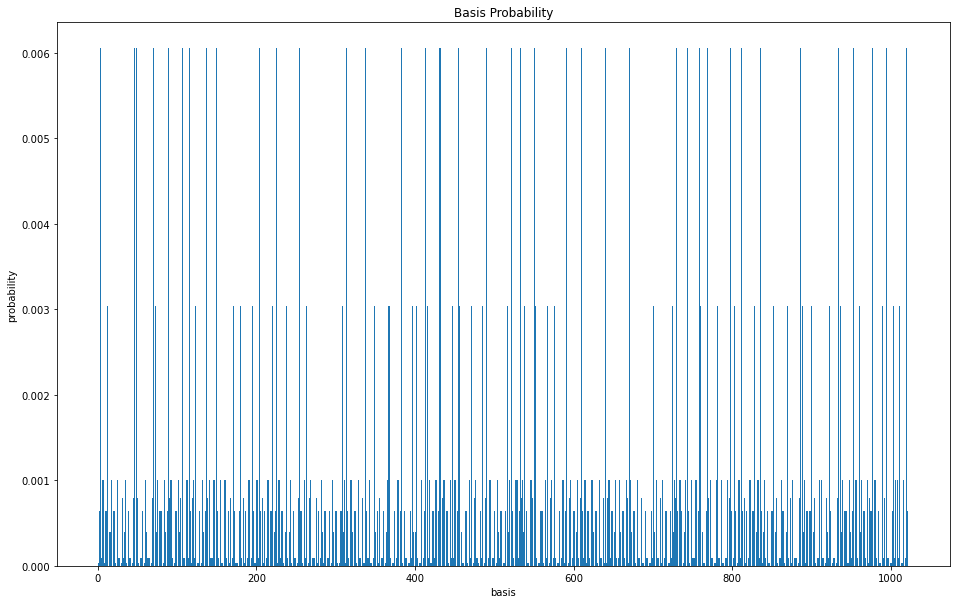

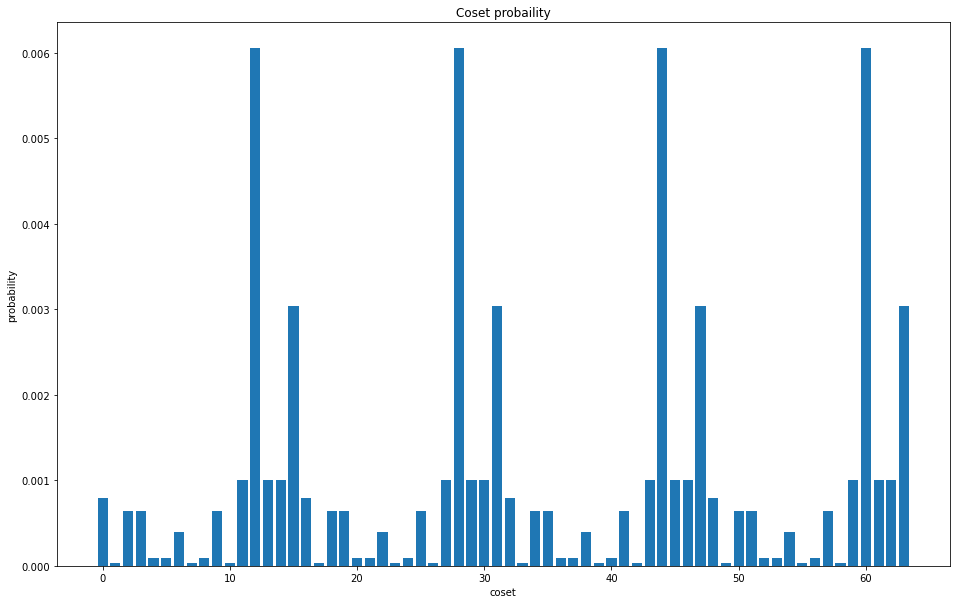

error:  [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [1. 1. 0. 0. 1.]




 Runningtime :  1245.0888748168945 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 1 1 1 1 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 1 0 1 1 0 1 1 0]
 [0 0 1 0 0 1 1 0 1 1]
 [0 0 1 1 1 0 1 1 0 0]
 [0 0 0 0 0 1 0 0 0 1]
 [0 0 0 1 0 1 0 1 0 0]
 [0 1 0 0 1 1 0 1 1 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.0484208981987979

total probability logical X:  0.04842089819879767

total probability logical Z:  0.0484208981987979

total probability logical Y:  0.04842089819879767

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519112

rate: 0.2500000000000006

correct!


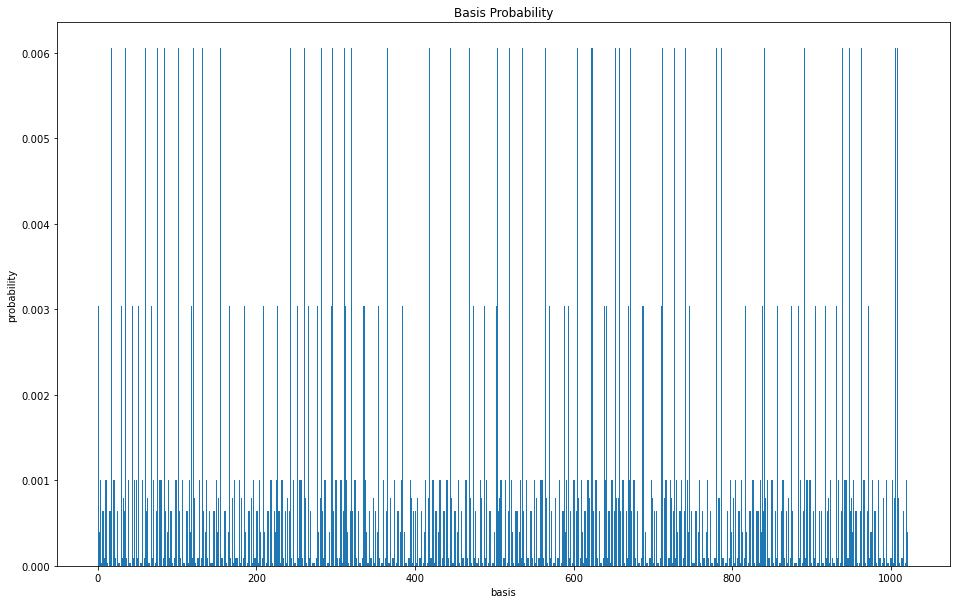

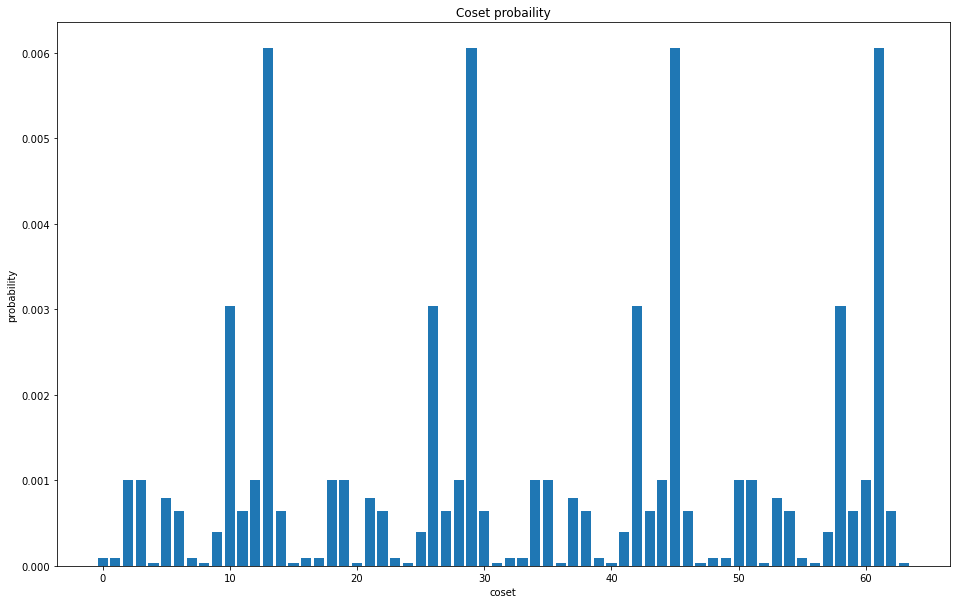

error:  [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 1. 0. 1. 0.]




 Runningtime :  1246.9698040485382 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 1 1 0 1 0 1]
 [0 0 1 0 0 0 1 1 0 1]
 [0 0 0 1 1 0 1 1 1 1]
 [0 0 0 0 1 0 1 0 1 0]
 [0 0 0 1 0 1 1 1 0 1]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 1 0 0 1 0 0 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.0484208981987979

total probability logical X:  0.04842089819879768

total probability logical Z:  0.048420898198797885

total probability logical Y:  0.04842089819879767

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519112

rate: 0.2500000000000006

correct!


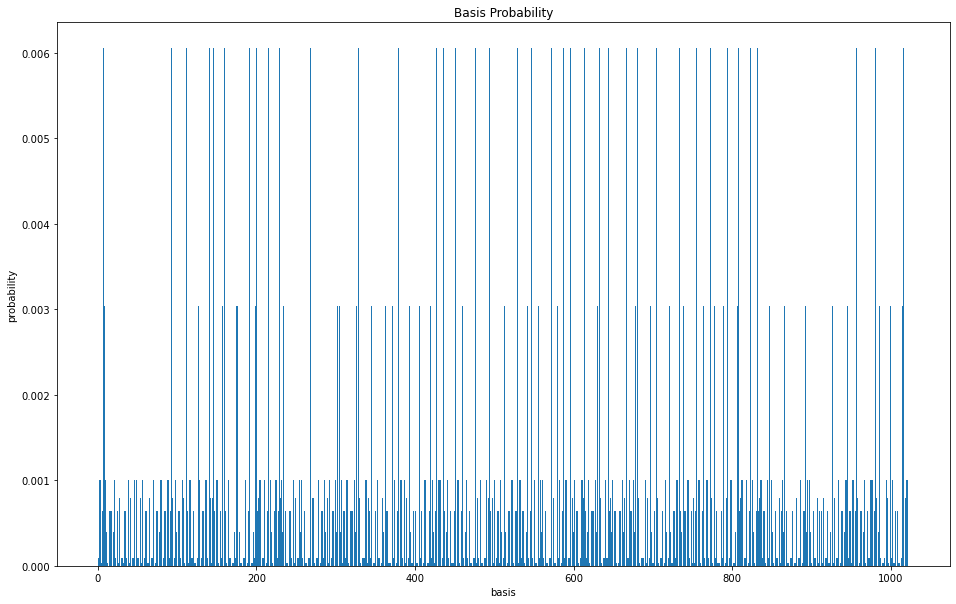

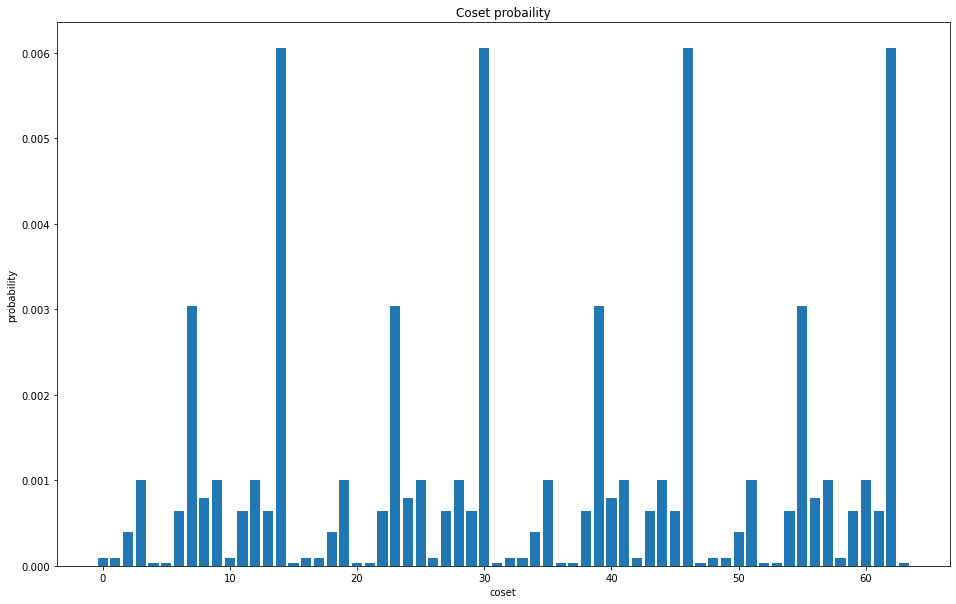

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 1. 1. 1.]




 Runningtime :  1248.1826527118683 sec

gamma: 0.2 beta: 0.2

estimate error :
 [[0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 1 1 1 1 1 0]
 [0 0 0 1 0 1 0 1 1 0]
 [0 0 0 0 0 1 0 0 1 1]
 [0 0 1 1 1 0 1 1 1 0]
 [0 0 0 1 0 0 1 0 0 1]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 1 0 1 1 0 1 0 0]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]]

total probability logical I:  0.0484208981987979

total probability logical X:  0.048420898198797656

total probability logical Z:  0.0484208981987979

total probability logical Y:  0.04842089819879768

 coset without doing anything : 0.005859375

matching syndrome probability 0.19368359279519115

rate: 0.25000000000000056

cannot correct


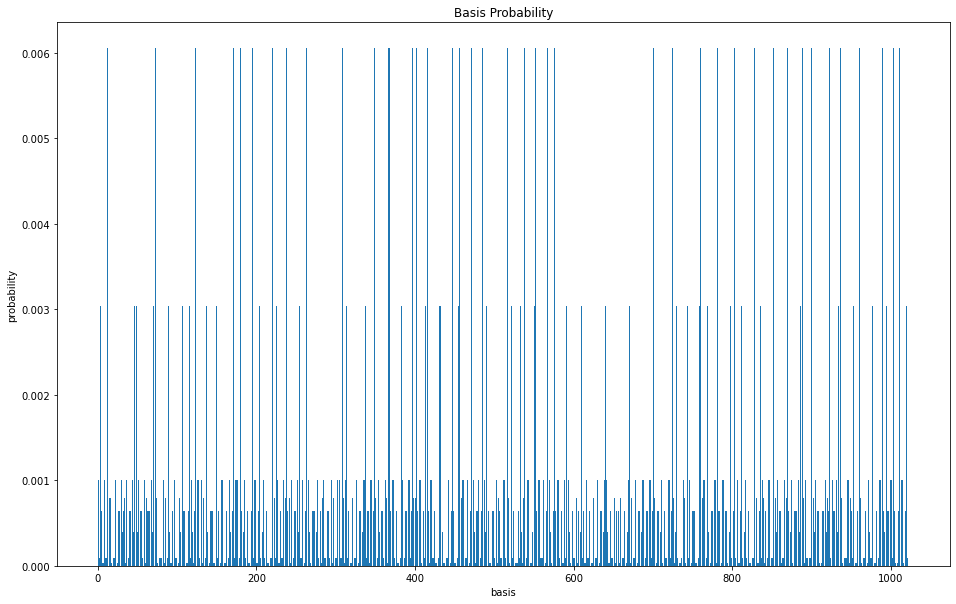

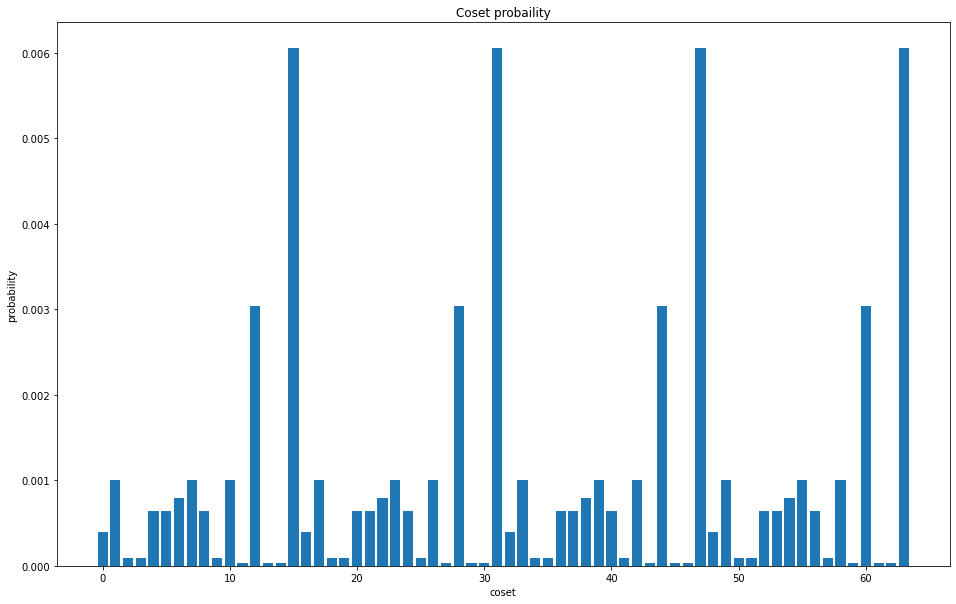

In [6]:
probability = []
gamma = []
beta = []
syndrome = []
cor_rate = []


num = int(M.shape[1]/2)

min_weight_term = min_weight(M.shape[1])
pen = 0.

good = 0
    

for d in trange(len(err)):
    coset_prob = []
    probability = []
    n = M.shape[1]
    print('error: ', err[d])
    syndr = row_binary(M.dot(err[d]))
    C = (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + pen * min_weight_term
    
    B = B_generator(M.shape[1])
    print('\nsyndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    res = QAOA_finegrid(C,B,n,0.1)
    
    f_p_max_gamma = res[0]
    f_p_max_beta = res[1]
#     print(res[2])
    
    
    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")

    r = np.ones(2**M.shape[1])/np.sqrt(2**M.shape[1])
    #Construct U_C
    
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    
    print('\ngamma:', f_p_max_gamma,'beta:',f_p_max_beta )
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))      

    probability.append(prob)
    max_index = prob_sort(prob,8)


    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print('\nestimate error :\n',(np.array(word)))


    err_8 = []
    for q in range(8):
          err_8.append(err[d])


    check  = matrix_binary(((np.array(word) - np.array(err_8)).dot(L)).dot(G.T))

    print('\ncheck\n' ,check)


    degen_index = []
    degen_x_index = []
    degen_z_index = []
    degen_y_index = []


    for b in range(2**(H_oringin.shape[0]-1)):
        degen_index.append(converter((degenerate_error(err[d], H_oringin)[b])))
        degen_x_index.append(converter((degenerate_error(logical_x_error[d], H_oringin)[b])))
        degen_z_index.append(converter((degenerate_error(logical_z_error[d], H_oringin)[b])))
        degen_y_index.append(converter((degenerate_error(logical_y_error[d], H_oringin)[b])))

    total_prob_I = 0
    total_prob_X = 0
    total_prob_Z = 0
    total_prob_Y = 0



    for c in range(len(degen_index)):
        total_prob_I += (probability[0][degen_index[c]])
        total_prob_X += (probability[0][degen_x_index[c]])
        total_prob_Z += (probability[0][degen_z_index[c]])
        total_prob_Y += (probability[0][degen_y_index[c]])


    print('\ntotal probability logical I: ', total_prob_I)
    print('\ntotal probability logical X: ', total_prob_X)
    print('\ntotal probability logical Z: ', total_prob_Z)
    print('\ntotal probability logical Y: ', total_prob_Y)
    print('\n coset without doing anything :', (H_oringin.shape[0]-1)/2**(M.shape[1]-1 ))
    print('\nmatching syndrome probability', total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y)
    print('\nrate:',  total_prob_I/( total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y))

    if sum(check[0][c] for c in range(len(check[0]))) == 0:
        print("\ncorrect!")
        good +=1
    else:
        print('\ncannot correct')


    
    for q in range(len(coset)):
        for f in range(len(coset[q])):
            c_prob = 0
            c_prob += probability[0][converter(coset[q][f])]
        coset_prob.append(c_prob)
    
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.title('Basis Probability')
    plt.ylabel('probability')
    plt.xlabel('basis')
    plt.show()
    plt.bar(range(0, len(coset_prob)),coset_prob)
    plt.title('Coset probaility')
    plt.ylabel('probability')
    plt.xlabel('coset')
    plt.show()
    time.sleep(0.5)


In [ ]:
d = {'gamma': gamma,'beta ': beta}
df = pd.DataFrame(data = d)
df

## QAOA pen is large

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 0. 0.]




 Runningtime :  1731.3203406333923 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 0 0 1 0 1 0 0 1 0]
 [1 0 1 0 0 1 0 1 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1.]
 [0. 1. 1. 1. 0. 1.]
 [0. 1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]]

total probability logical I:  0.13474286402400037

total probability logical X:  0.0022595158987148735

total probability logical Z:  0.002451241675910232

total probability logical Y:  0.004887491314846814

 coset without doing anything : 0.005859375

matching syndrome probability 0.1443411129134723

rate: 0.9335030145207087

correct!


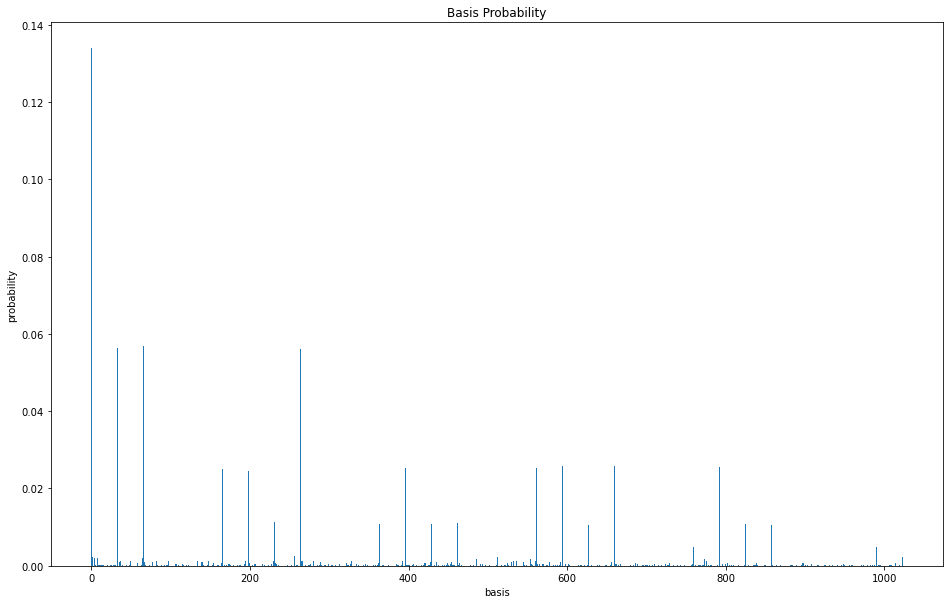

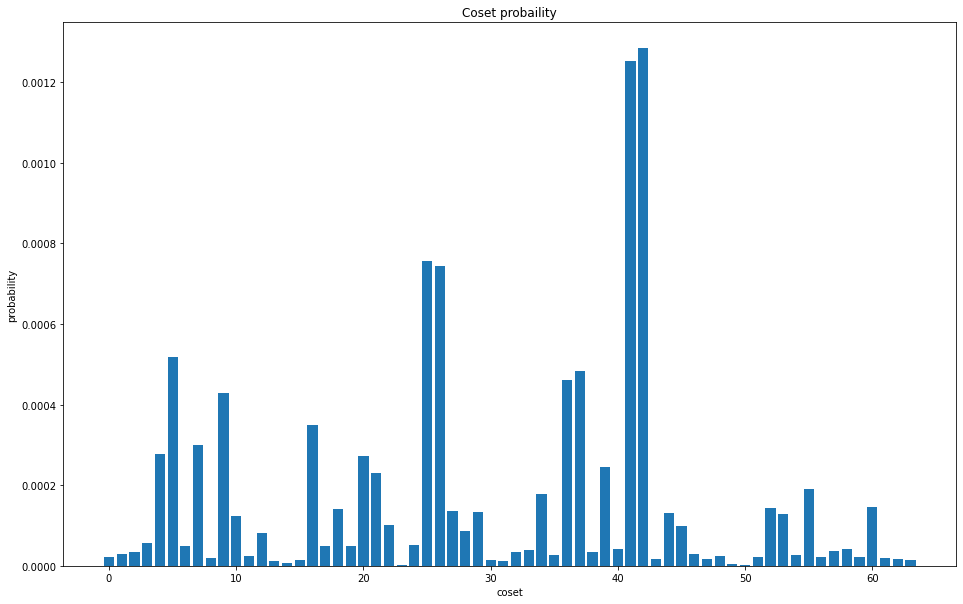

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 1. 1.]




 Runningtime :  1733.7269740104675 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 1 0 0 0]
 [0 1 0 0 1 0 1 0 0 1]
 [0 1 0 1 0 0 1 0 1 0]]

check
 [[1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 1. 0. 1.]]

total probability logical I:  0.0028300644490596334

total probability logical X:  0.024694013363663562

total probability logical Z:  0.013355708703768326

total probability logical Y:  0.002718287616439049

 coset without doing anything : 0.005859375

matching syndrome probability 0.04359807413293057

rate: 0.06491260234180905

cannot correct


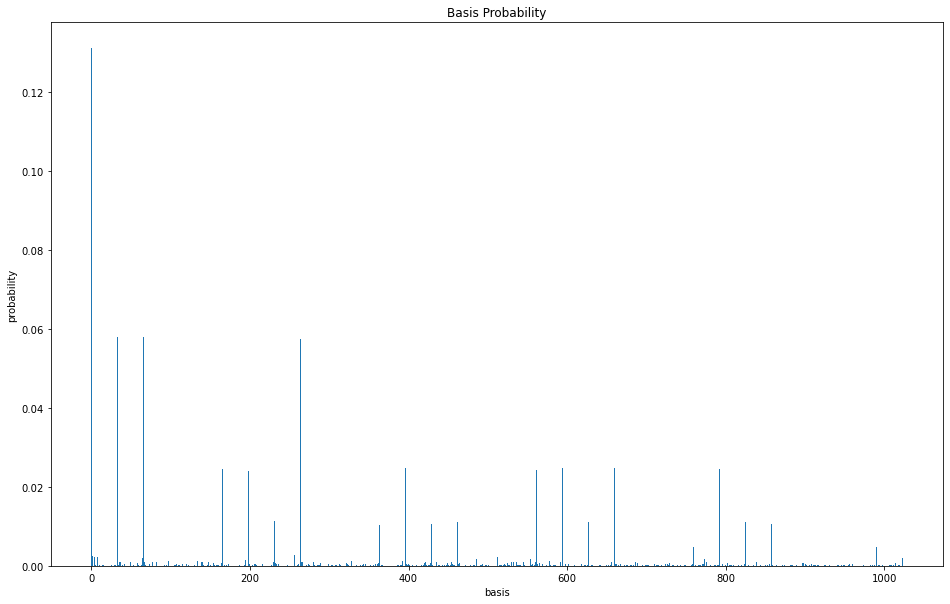

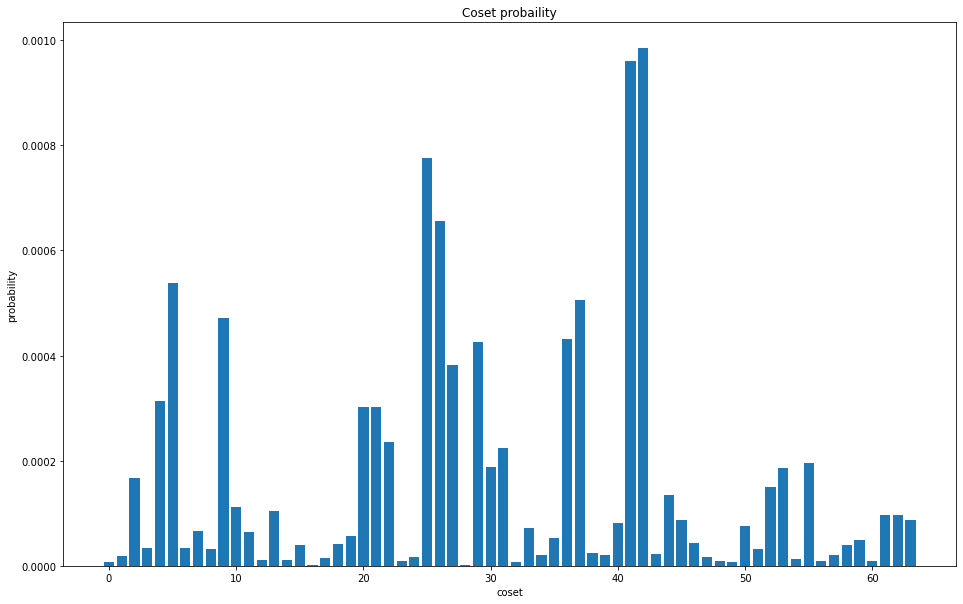

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 0. 1. 0. 1.]




 Runningtime :  1737.7684938907623 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 1 0 0 0 1 1 0]
 [0 0 0 1 1 0 0 0 1 1]]

check
 [[1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.002674948727622631

total probability logical X:  0.00024824979459293374

total probability logical Z:  0.0010498005518578318

total probability logical Y:  0.0015597779717609493

 coset without doing anything : 0.005859375

matching syndrome probability 0.005532777045834346

rate: 0.48347307427408676

cannot correct


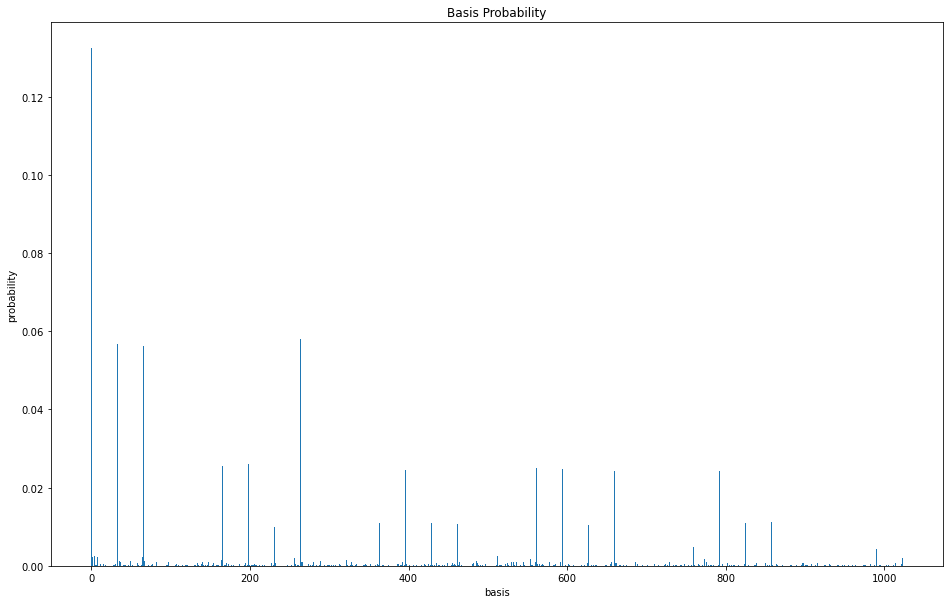

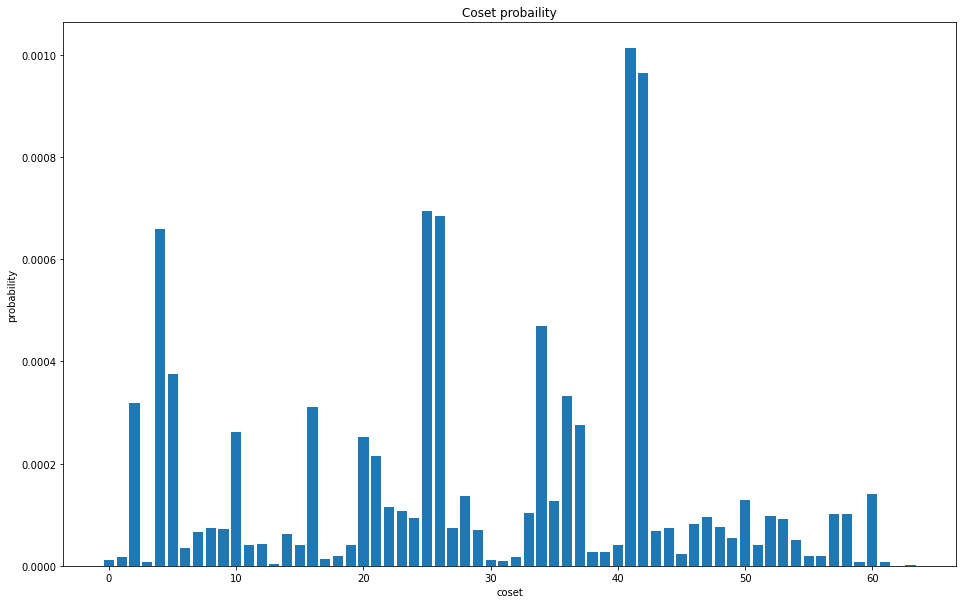

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 1. 1. 0. 0.]




 Runningtime :  1733.695852279663 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 1 0 1 0 0 1]
 [0 0 0 1 1 0 0 0 1 1]]

check
 [[0. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1.]]

total probability logical I:  0.003645348947783084

total probability logical X:  0.025821012195132744

total probability logical Z:  0.011734266426172259

total probability logical Y:  0.0018375899578286373

 coset without doing anything : 0.005859375

matching syndrome probability 0.04303821752691672

rate: 0.0847002770387326

cannot correct


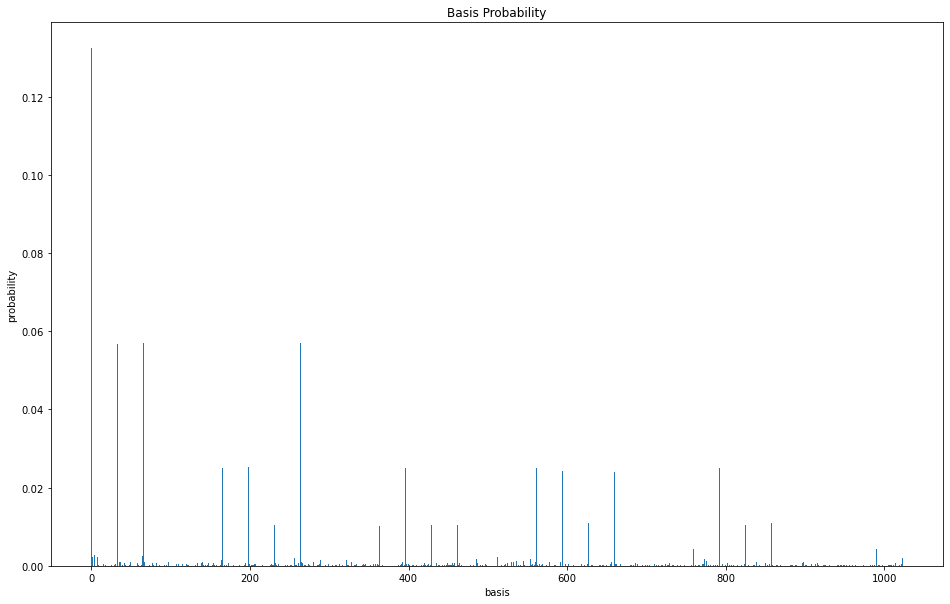

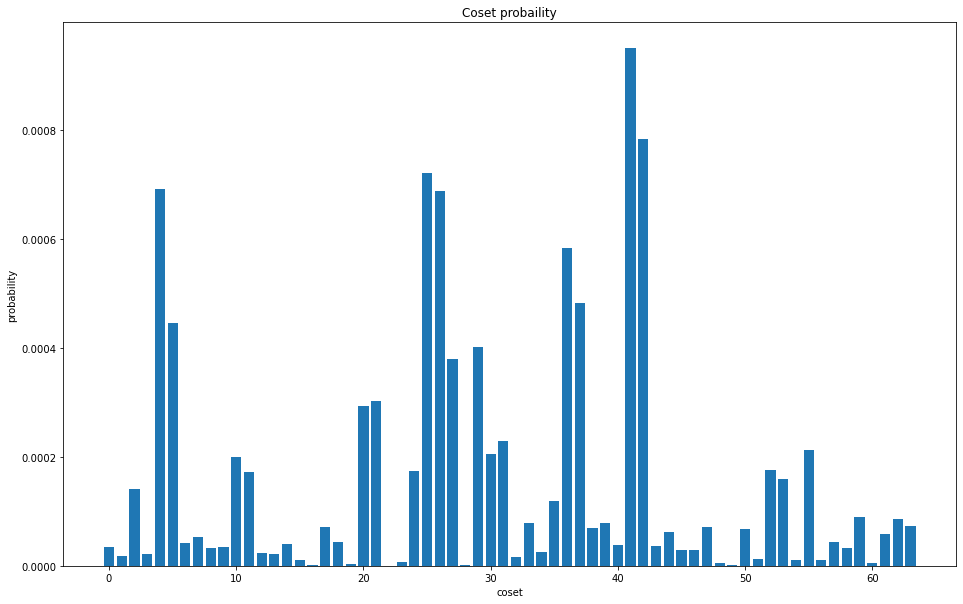

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 1. 1. 0. 0.]




 Runningtime :  1732.1935322284698 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 1 1 0]
 [0 1 1 0 0 0 1 1 0 0]]

check
 [[1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 1.]]

total probability logical I:  0.003483053949756534

total probability logical X:  0.025792344046112158

total probability logical Z:  0.01161364263031856

total probability logical Y:  0.0018469777275890555

 coset without doing anything : 0.005859375

matching syndrome probability 0.04273601835377631

rate: 0.08150160178524818

cannot correct


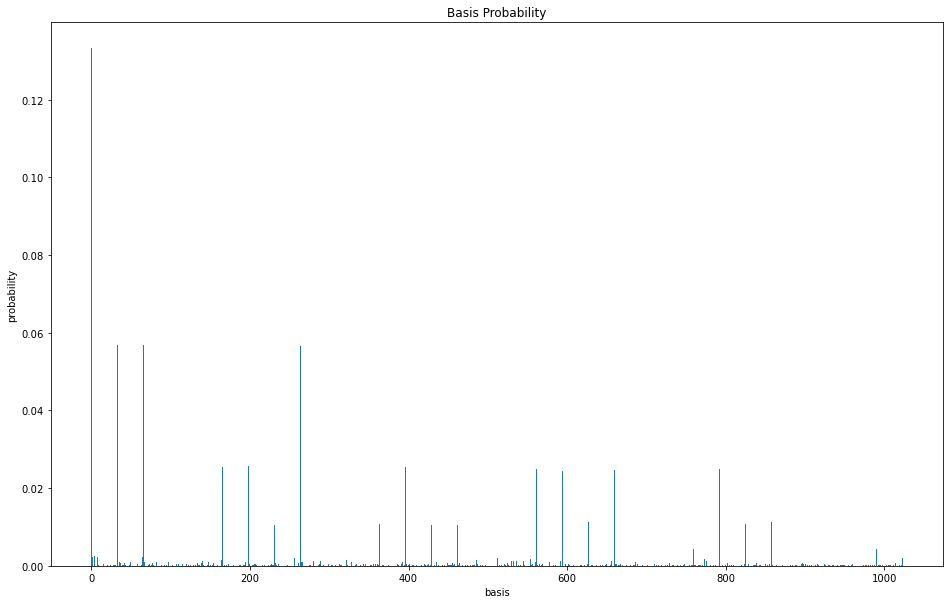

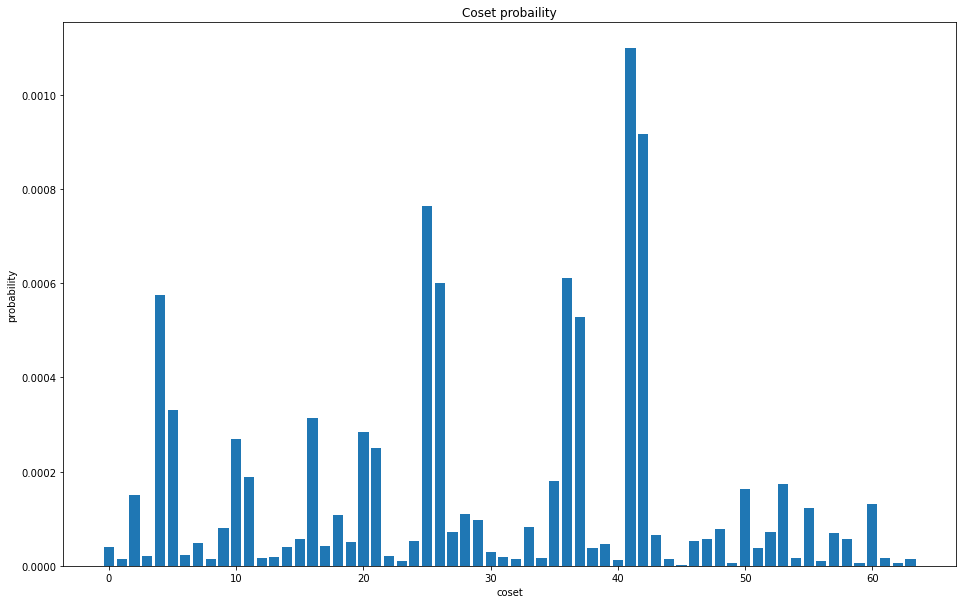

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 1. 1. 0.]




 Runningtime :  1734.5011713504791 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 1 1 0]
 [0 1 1 0 0 0 1 1 0 0]]

check
 [[1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]]

total probability logical I:  0.0024236985171051844

total probability logical X:  0.00027367428140794204

total probability logical Z:  0.00029393581429778073

total probability logical Y:  0.0011818796762437416

 coset without doing anything : 0.005859375

matching syndrome probability 0.004173188289054649

rate: 0.580778615587993

cannot correct


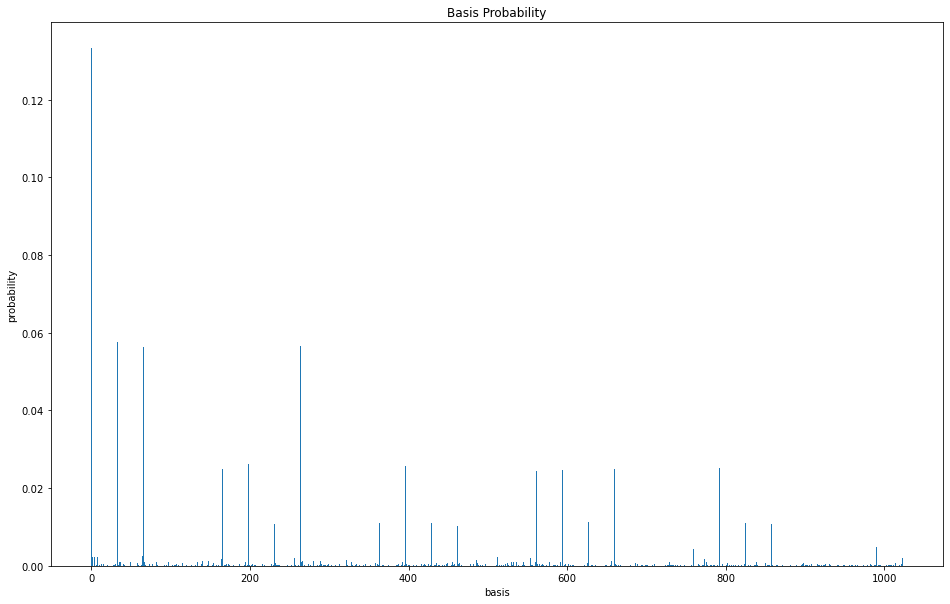

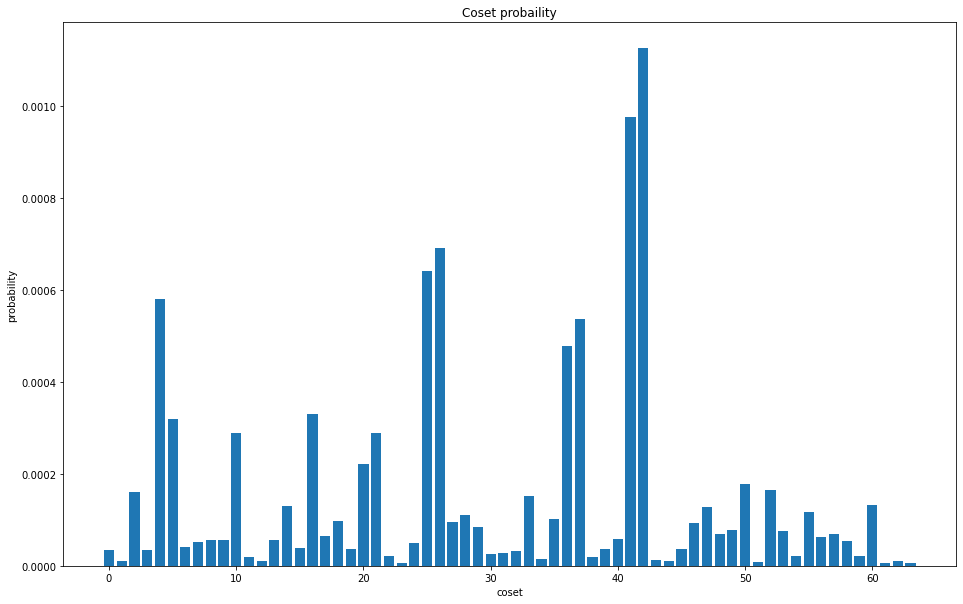

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 0. 0.]




 Runningtime :  1731.2093024253845 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 1 0 1 0 0 1]
 [1 0 1 0 0 1 0 1 0 0]]

check
 [[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0.]]

total probability logical I:  0.0030132763516620225

total probability logical X:  0.01104961449931217

total probability logical Z:  0.027670788472988227

total probability logical Y:  0.0016964119986189036

 coset without doing anything : 0.005859375

matching syndrome probability 0.04343009132258133

rate: 0.06938222462579258

cannot correct


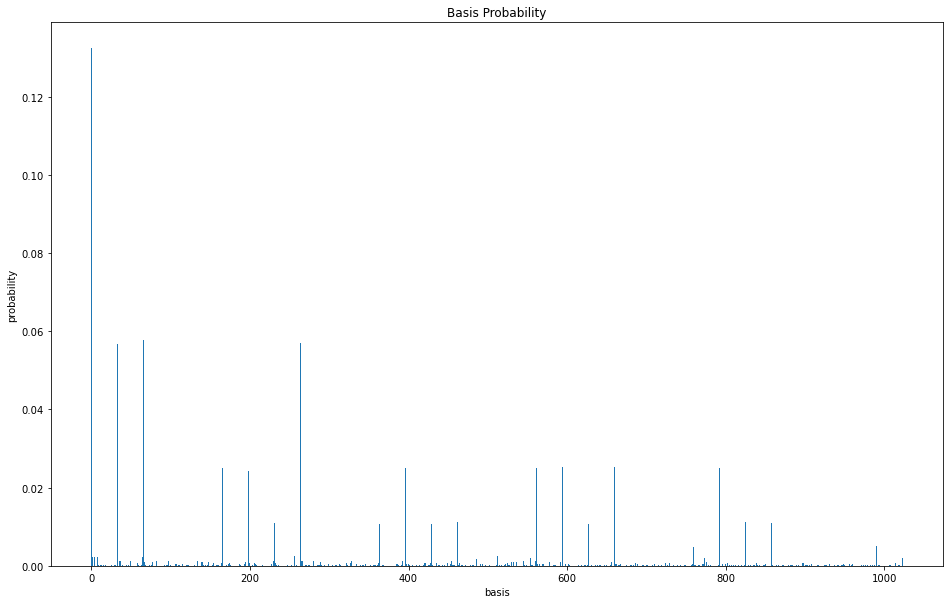

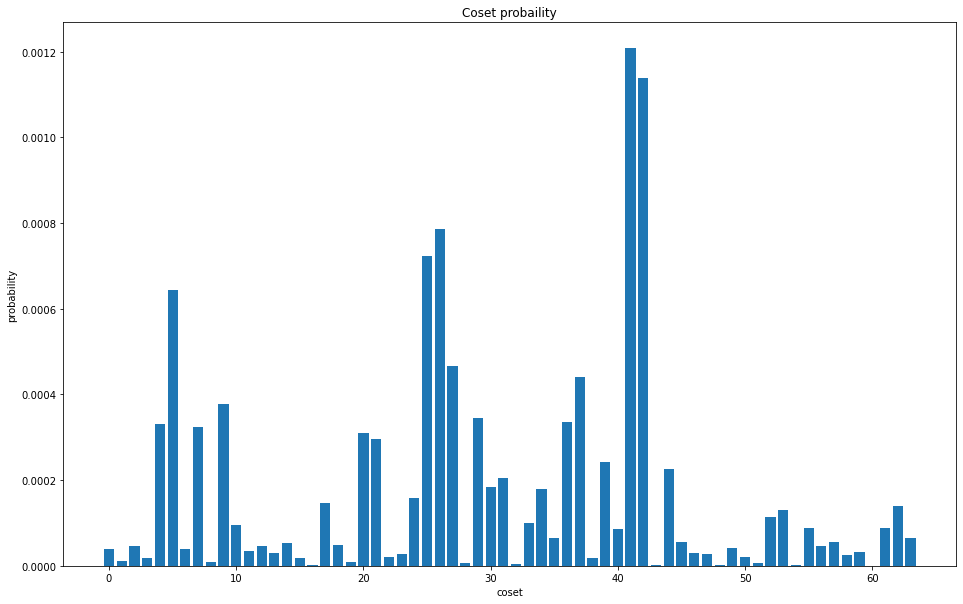

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [0. 1. 0. 1. 0.]




 Runningtime :  1740.7307925224304 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 0 1 0 0 0 0]
 [1 0 1 0 0 1 0 1 0 0]
 [1 0 0 1 0 1 0 0 1 0]]

check
 [[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 1. 0. 0.]]

total probability logical I:  0.0034524383351562447

total probability logical X:  0.00018502476390206676

total probability logical Z:  0.00042570979875991013

total probability logical Y:  0.001129394245299195

 coset without doing anything : 0.005859375

matching syndrome probability 0.005192567143117417

rate: 0.6648808267664564

cannot correct


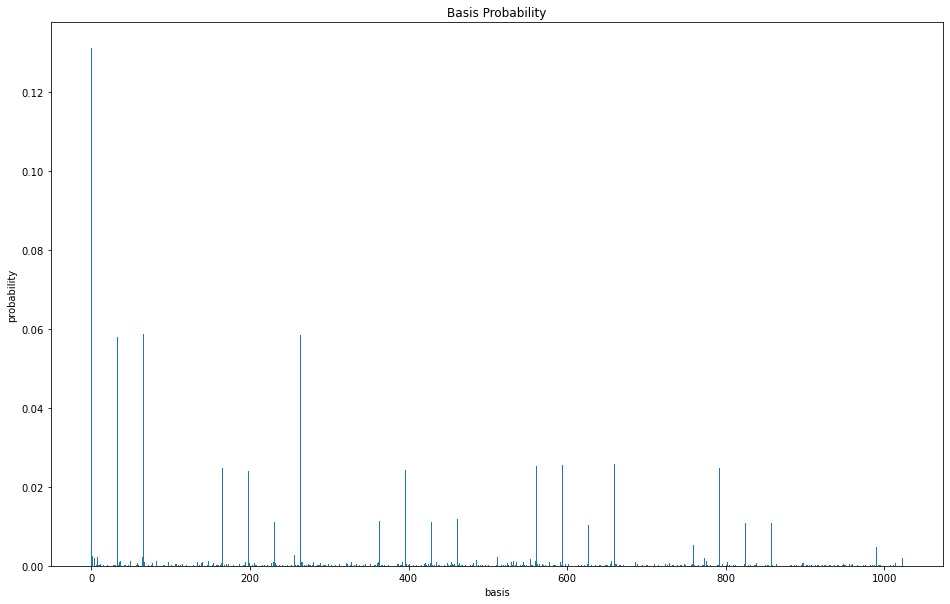

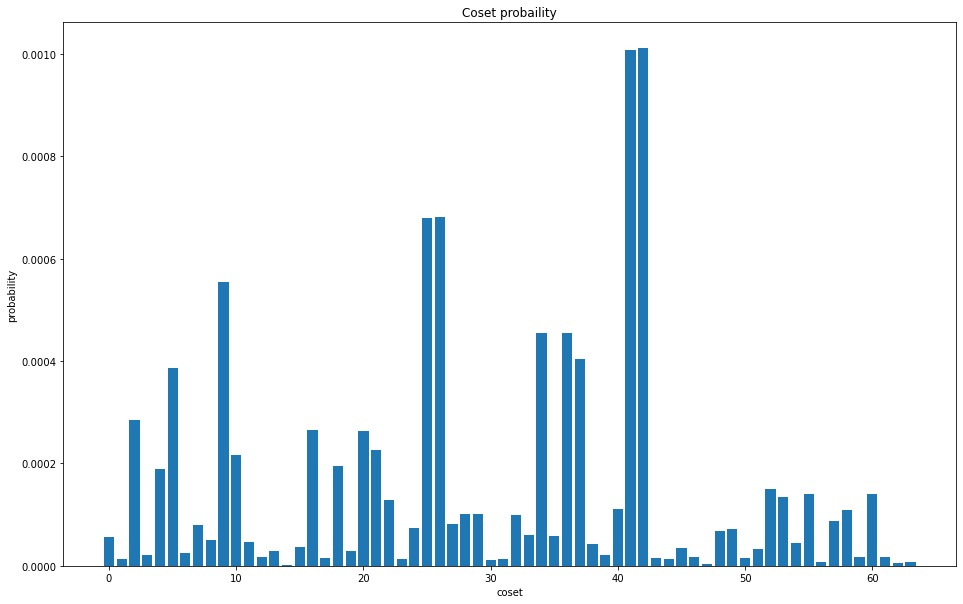

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [0. 0. 1. 0. 1.]




 Runningtime :  1774.693309545517 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 1 0 0 0 1 1 0]
 [0 0 0 1 1 0 0 0 1 1]]

check
 [[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]
 [1. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0.]]

total probability logical I:  0.003170522132641546

total probability logical X:  0.012206002990301645

total probability logical Z:  0.026331108633943414

total probability logical Y:  0.0018883518963491834

 coset without doing anything : 0.005859375

matching syndrome probability 0.04359598565323579

rate: 0.07272509349507557

cannot correct


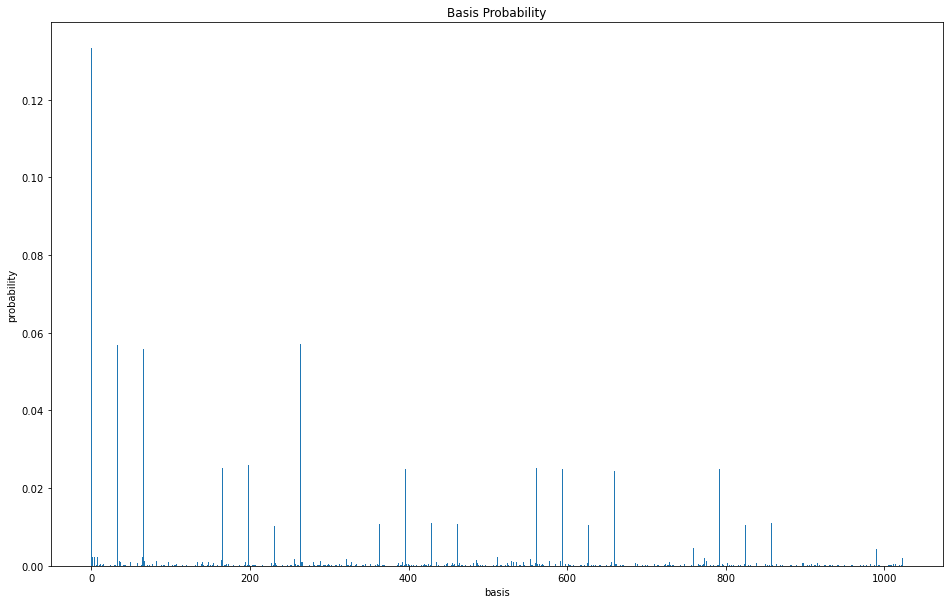

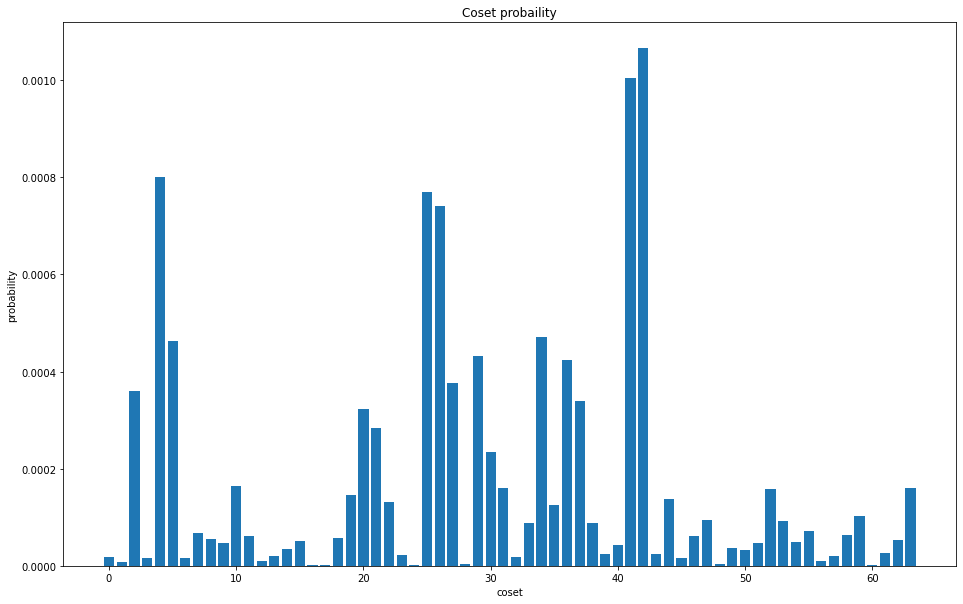

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 0. 1. 1. 0.]




 Runningtime :  1771.5294752120972 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 1 0 0 0 1 1 0 0]
 [0 0 1 1 0 0 0 1 1 0]]

check
 [[0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0.]]

total probability logical I:  0.0032239647124162234

total probability logical X:  0.012459216386843053

total probability logical Z:  0.02629251760800713

total probability logical Y:  0.0018560966358258672

 coset without doing anything : 0.005859375

matching syndrome probability 0.04383179534309227

rate: 0.07355310653329897

cannot correct


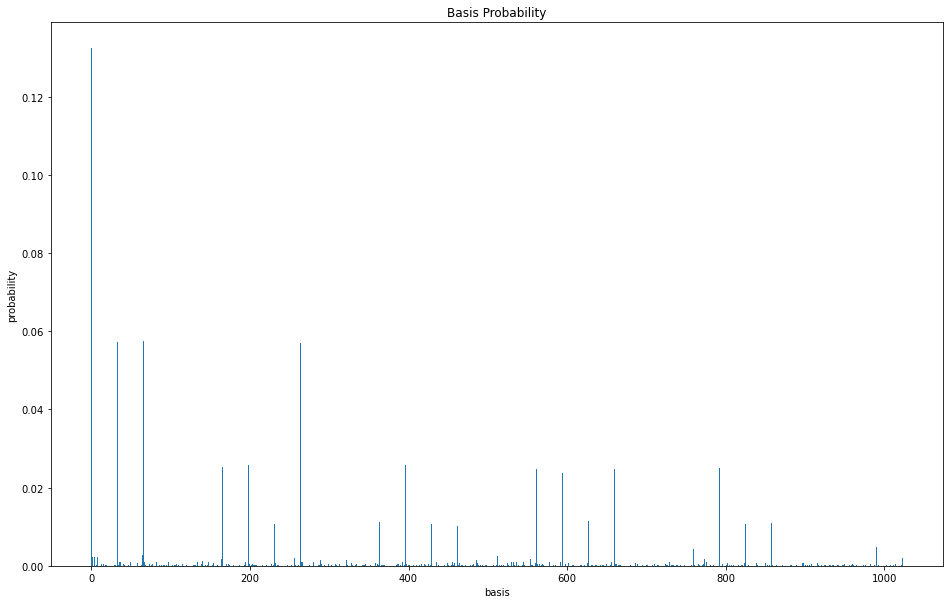

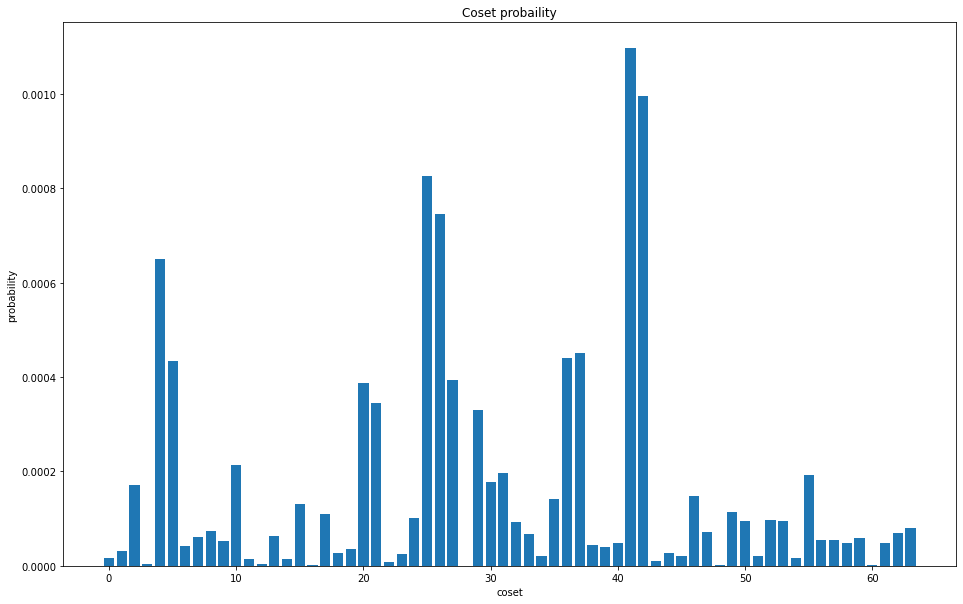

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 0. 0. 1.]




 Runningtime :  1768.9752433300018 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 1 0 0 0 1 1 0 0 0]
 [1 0 0 1 0 1 0 0 1 0]]

check
 [[1. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1.]
 [1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]

total probability logical I:  0.003174628393331012

total probability logical X:  0.00017221659090388807

total probability logical Z:  0.0003920959064738321

total probability logical Y:  0.0007060122839658198

 coset without doing anything : 0.005859375

matching syndrome probability 0.004444953174674552

rate: 0.714209636992059

cannot correct


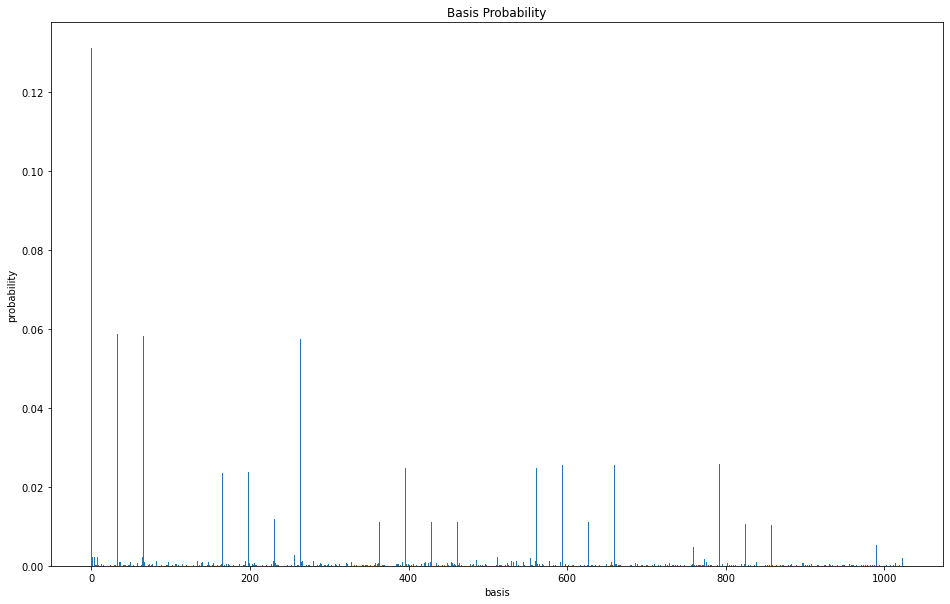

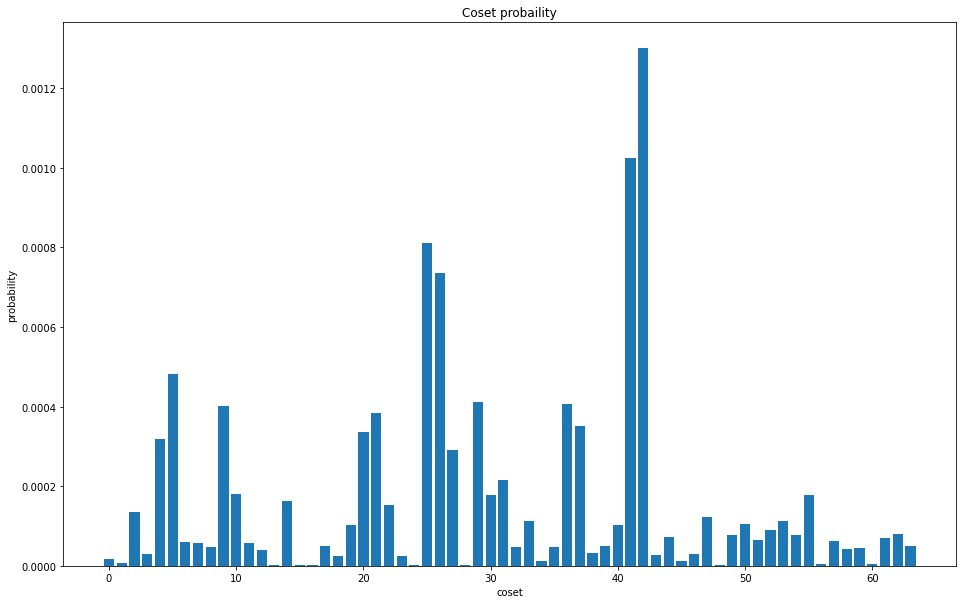

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 1. 1.]




 Runningtime :  1771.76500415802 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 1 0 1 0 0 1]
 [0 0 1 0 1 0 0 1 0 1]]

check
 [[0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1.]]

total probability logical I:  0.05875592589189225

total probability logical X:  0.003896681561090123

total probability logical Z:  0.002111704737001818

total probability logical Y:  0.007761802399012398

 coset without doing anything : 0.005859375

matching syndrome probability 0.07252611458899658

rate: 0.8101347524937798

cannot correct


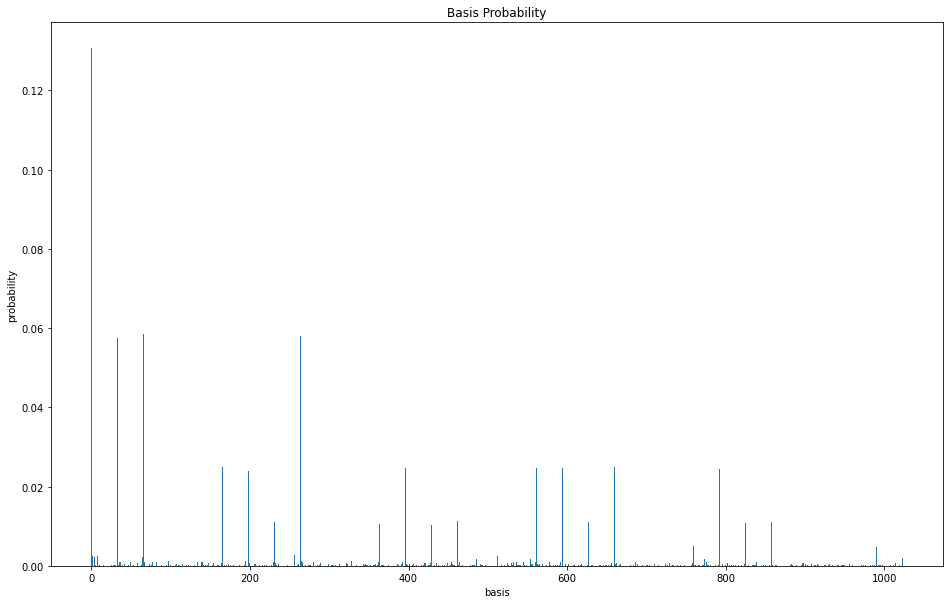

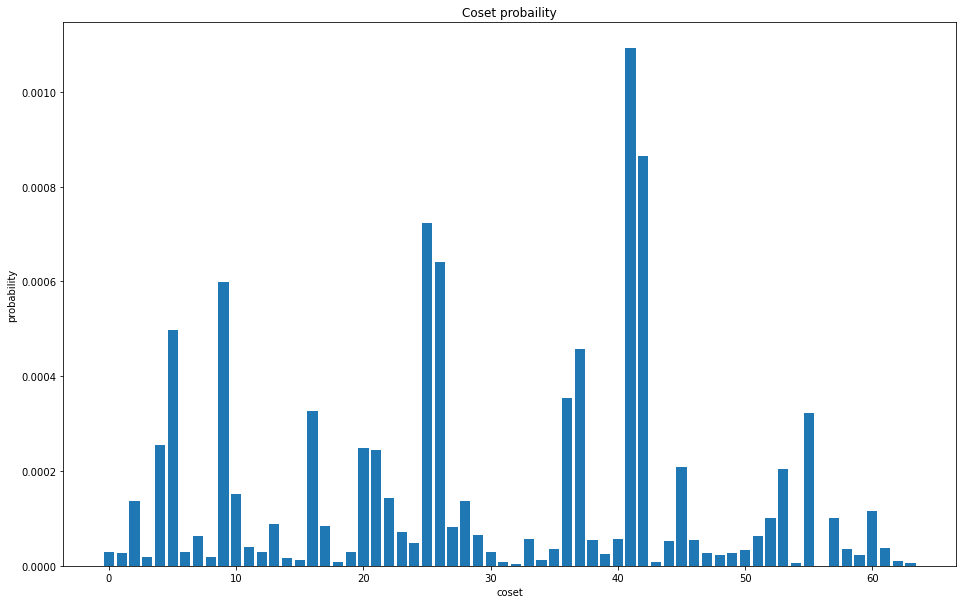

error:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [1. 1. 1. 1. 1.]




 Runningtime :  1769.1307821273804 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 1 1 0]
 [0 0 0 1 1 0 0 0 1 1]]

check
 [[1. 1. 1. 0. 0. 1.]
 [1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 1. 1.]
 [0. 1. 0. 0. 0. 1.]]

total probability logical I:  0.05848989674171446

total probability logical X:  0.0018816048424283708

total probability logical Z:  0.0024272128282733403

total probability logical Y:  0.005786066231684594

 coset without doing anything : 0.005859375

matching syndrome probability 0.06858478064410077

rate: 0.8528116032801716

cannot correct


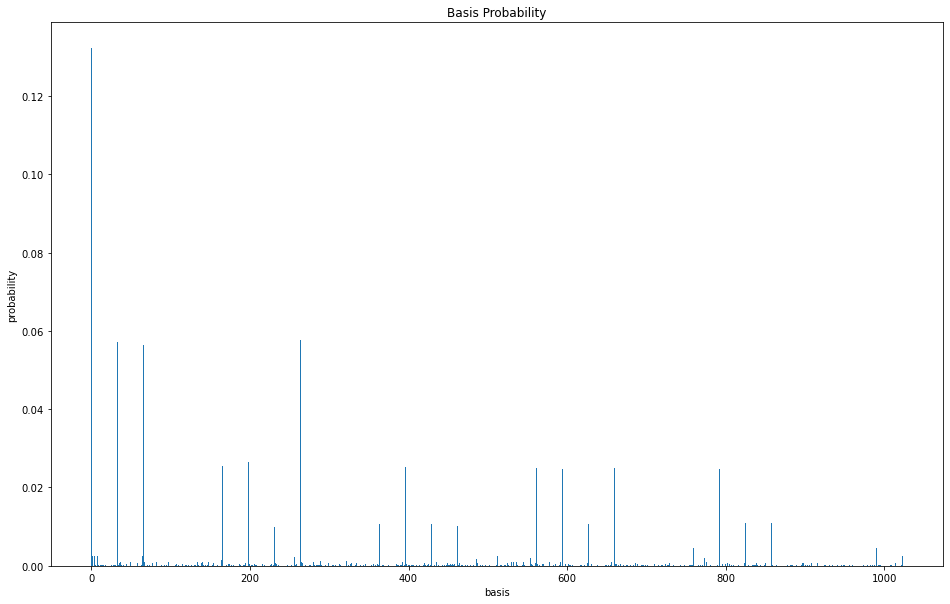

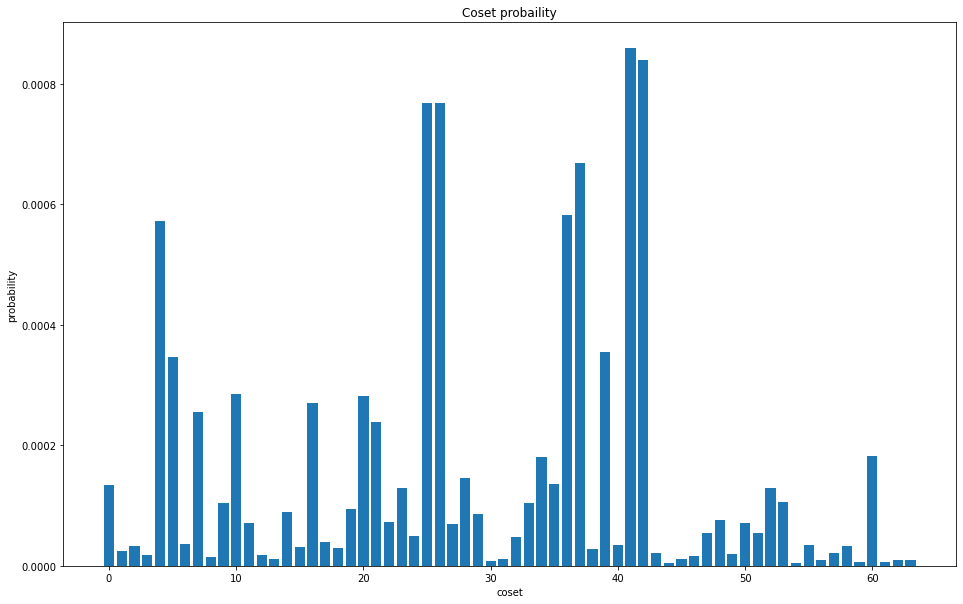

error:  [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [1. 1. 0. 0. 1.]




 Runningtime :  1770.1934683322906 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 0 0 1 0 1 0 0 1 0]
 [1 1 0 0 0 1 1 0 0 0]]

check
 [[0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1.]]

total probability logical I:  0.059533762635673906

total probability logical X:  0.0023742587893727804

total probability logical Z:  0.002513348463224422

total probability logical Y:  0.007807761127567822

 coset without doing anything : 0.005859375

matching syndrome probability 0.07222913101583893

rate: 0.8242347900131722

cannot correct


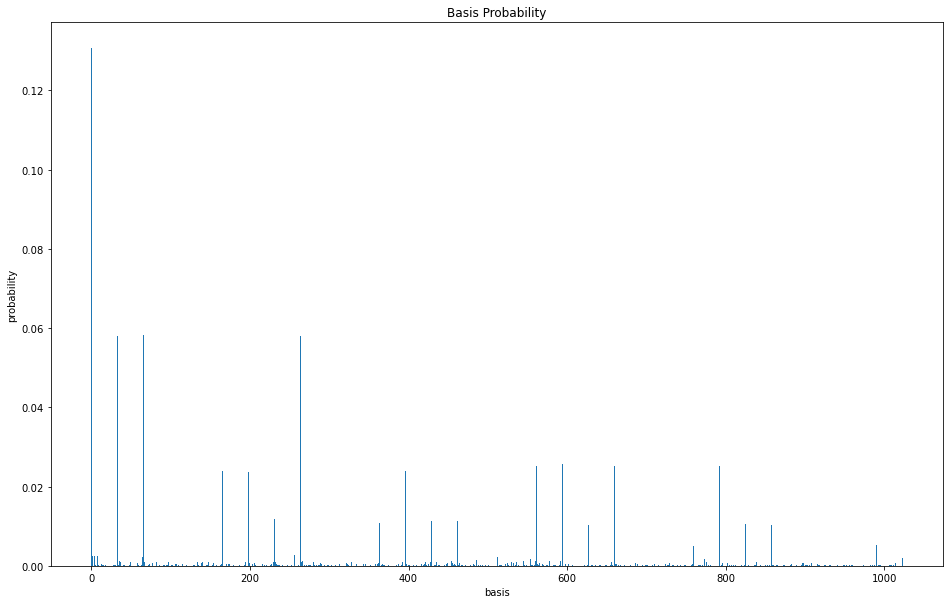

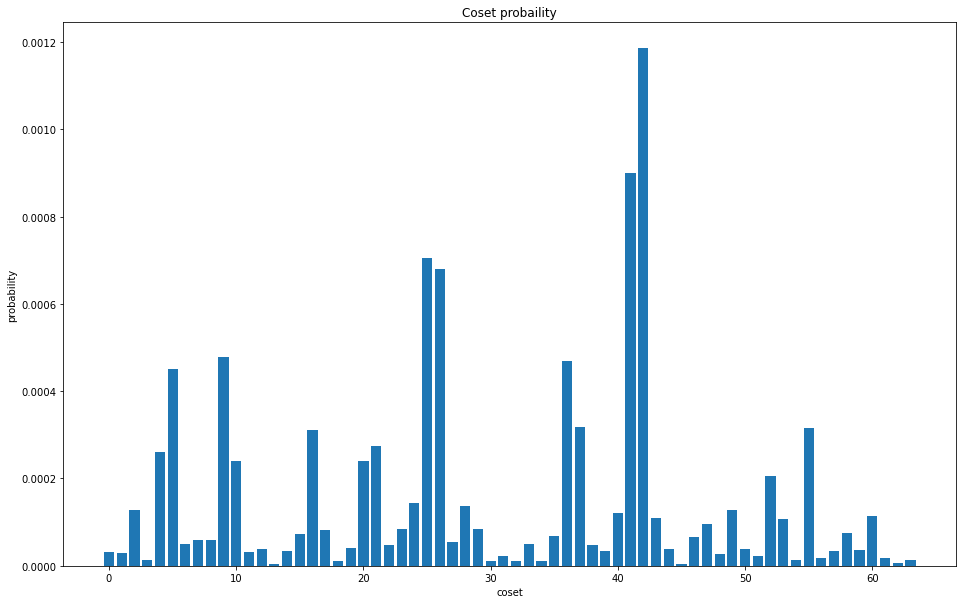

error:  [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 1. 0. 1. 0.]




 Runningtime :  1769.638239622116 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 1 1 0 0 0 1]
 [1 0 1 0 0 1 0 1 0 0]]

check
 [[1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [1. 0. 0. 0. 0. 1.]]

total probability logical I:  0.05953901178940702

total probability logical X:  0.002454143037257514

total probability logical Z:  0.002542415130113485

total probability logical Y:  0.007777047842611065

 coset without doing anything : 0.005859375

matching syndrome probability 0.07231261779938908

rate: 0.8233557794101879

cannot correct


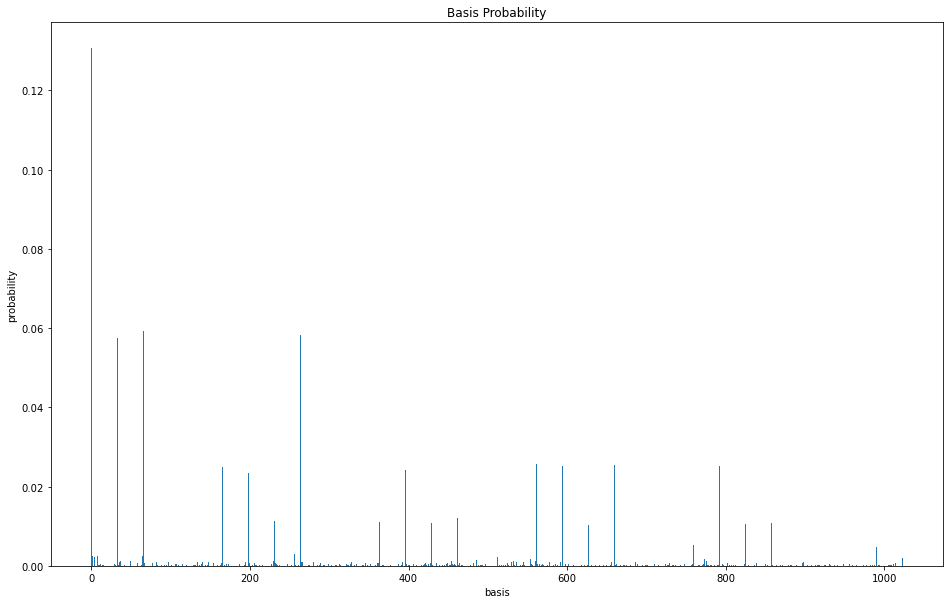

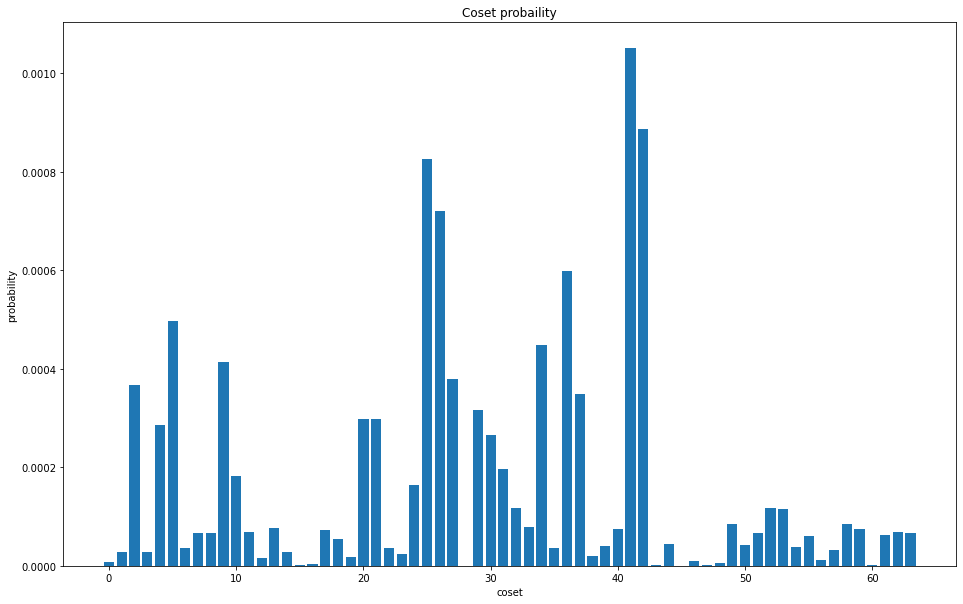

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 1. 1. 1.]




 Runningtime :  1773.0225496292114 sec

gamma: 1.5 beta: 2.5

estimate error :
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 1 1 0]
 [0 1 1 0 0 0 1 1 0 0]]

check
 [[0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1.]]

total probability logical I:  0.05871795443056141

total probability logical X:  0.0020289466858617114

total probability logical Z:  0.002627870713944716

total probability logical Y:  0.005964556708854826

 coset without doing anything : 0.005859375

matching syndrome probability 0.06933932853922267

rate: 0.846820349541557

cannot correct


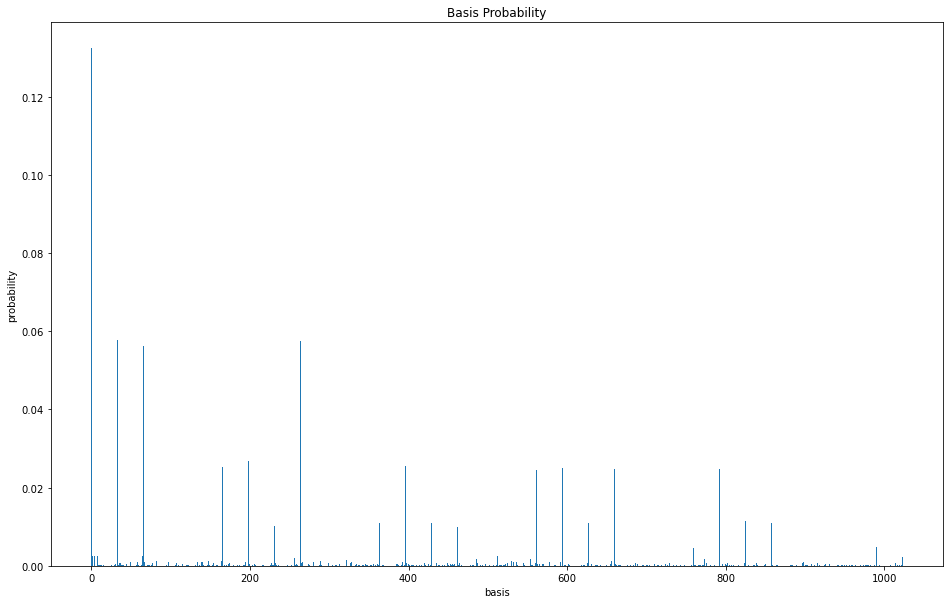

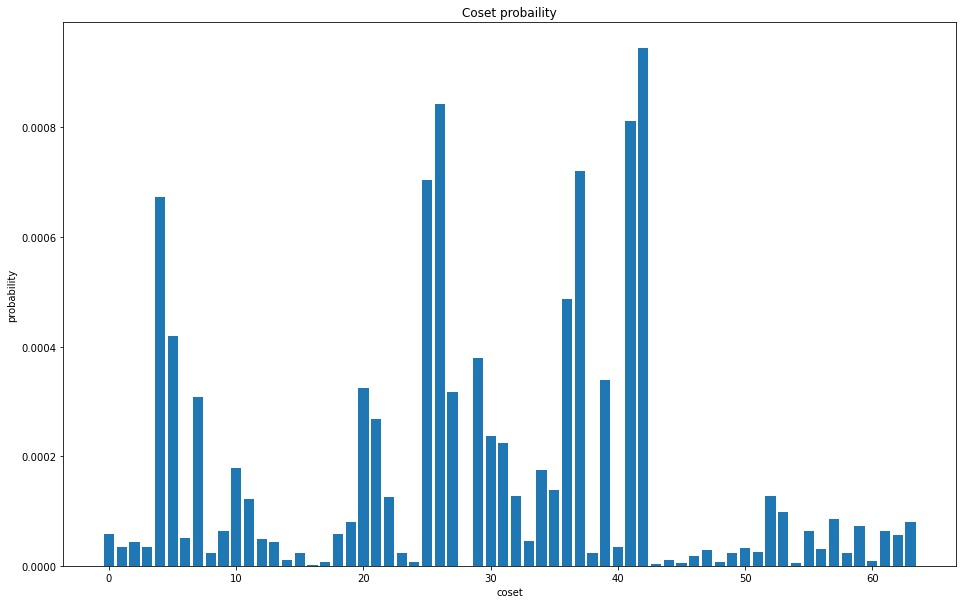

In [7]:
probability = []
gamma = []
beta = []
syndrome = []
cor_rate = []


num = int(M.shape[1]/2)

min_weight_term = min_weight(M.shape[1])
pen = 10000

good = 0
    

for d in trange(len(err)):
    coset_prob = []
    probability = []
    n = M.shape[1]
    print('error: ', err[d])
    syndr = row_binary(M.dot(err[d]))
    C = (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + pen * min_weight_term
    
    B = B_generator(M.shape[1])
    print('\nsyndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    res = QAOA_finegrid(C,B,n,0.1)
    
    f_p_max_gamma = res[0]
    f_p_max_beta = res[1]
#     print(res[2])
    
    
    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")

    r = np.ones(2**M.shape[1])/np.sqrt(2**M.shape[1])
    #Construct U_C
    
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    
    print('\ngamma:', f_p_max_gamma,'beta:',f_p_max_beta )
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))      

    probability.append(prob)
    max_index = prob_sort(prob,8)


    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print('\nestimate error :\n',(np.array(word)))


    err_8 = []
    for q in range(8):
          err_8.append(err[d])


    check  = matrix_binary(((np.array(word) - np.array(err_8)).dot(L)).dot(G.T))

    print('\ncheck\n' ,check)


    degen_index = []
    degen_x_index = []
    degen_z_index = []
    degen_y_index = []


    for b in range(2**(H_oringin.shape[0]-1)):
        degen_index.append(converter((degenerate_error(err[d], H_oringin)[b])))
        degen_x_index.append(converter((degenerate_error(logical_x_error[d], H_oringin)[b])))
        degen_z_index.append(converter((degenerate_error(logical_z_error[d], H_oringin)[b])))
        degen_y_index.append(converter((degenerate_error(logical_y_error[d], H_oringin)[b])))

    total_prob_I = 0
    total_prob_X = 0
    total_prob_Z = 0
    total_prob_Y = 0



    for c in range(len(degen_index)):
        total_prob_I += (probability[0][degen_index[c]])
        total_prob_X += (probability[0][degen_x_index[c]])
        total_prob_Z += (probability[0][degen_z_index[c]])
        total_prob_Y += (probability[0][degen_y_index[c]])


    print('\ntotal probability logical I: ', total_prob_I)
    print('\ntotal probability logical X: ', total_prob_X)
    print('\ntotal probability logical Z: ', total_prob_Z)
    print('\ntotal probability logical Y: ', total_prob_Y)
    print('\n coset without doing anything :', (H_oringin.shape[0]-1)/2**(M.shape[1]-1 ))
    print('\nmatching syndrome probability', total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y)
    print('\nrate:',  total_prob_I/( total_prob_I+ total_prob_X + total_prob_Z + total_prob_Y))

    if sum(check[0][c] for c in range(len(check[0]))) == 0:
        print("\ncorrect!")
        good +=1
    else:
        print('\ncannot correct')


    
    for q in range(len(coset)):
        for f in range(len(coset[q])):
            c_prob = 0
            c_prob += probability[0][converter(coset[q][f])]
        coset_prob.append(c_prob)
    
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.title('Basis Probability')
    plt.ylabel('probability')
    plt.xlabel('basis')
    plt.show()
    plt.bar(range(0, len(coset_prob)),coset_prob)
    plt.title('Coset probaility')
    plt.ylabel('probability')
    plt.xlabel('coset')
    plt.show()
    time.sleep(0.5)


## Apply full rank matirx

In [16]:
H_oringin = np.array([[1,0,0,1,0,0,1,1,0,0],[0,1,0,0,1,0,0,1,1,0],[0,0,1,1,0,0,1,1,1,1],[0,1,0,1,0,1,0,0,0,1]])
H_oringinT = H_oringin.T
print(H_oringin)
L = Lambda(5)

FullRank_P = np.array([[1,0,1,0],[1,0,1,1],[0,1,1,0],[0,0,1,1]])



print(matrix_rank(FullRank_P))


H = matrix_binary(FullRank_P.dot(H_oringin))
print(H)


M = H.dot(L)

x = np.array([1,0,0,0,1,1,1,0,1,1])
err = []
for i in range(10):
    l = np.zeros(10)
    l[i] = 1
    err.append(l)
for i in range(5):
    l = np.zeros(10)
    l[i] = 1
    l[i+5] = 1
    err.append(l)
err = np.array(err)

error_syndrome = []
for i in range(len(err)):
    sy = row_binary(M.dot((x + err[i]).T))
    print('\nerror: ',err[i])
    print('syndrome: ',sy)

[[1 0 0 1 0 0 1 1 0 0]
 [0 1 0 0 1 0 0 1 1 0]
 [0 0 1 1 0 0 1 1 1 1]
 [0 1 0 1 0 1 0 0 0 1]]
4
[[1 0 1 0 0 0 0 0 1 1]
 [1 1 1 1 0 1 0 0 1 0]
 [0 1 1 1 1 0 1 0 0 1]
 [0 1 1 0 0 1 1 1 1 0]]
[[0 0 0 1 1 1 0 1 0 0]
 [1 0 0 1 0 1 1 1 1 0]
 [0 1 0 0 1 0 1 1 1 1]
 [1 1 1 1 0 0 1 1 0 0]]

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 1. 0. 1.]

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 1. 1.]

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 0. 1.]

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
syndrome:  [1. 1. 0. 1.]

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
syndrome:  [1. 0. 1. 0.]

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
syndrome:  [1. 1. 0. 0.]

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
syndrome:  [0. 1. 1. 1.]

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
syndrome:  [1. 1. 1. 1.]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
syndrome:  [0. 1. 1. 0.]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
syndrome:  [0. 0. 1. 0.]

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
syndrome:  [1. 0. 

In [ ]:

gamma = []
beta = []
syndrome = []

num = int(M.shape[1]/2)

min_weight_term = np.kron(min_weight(num),tensorI(num)) + np.kron(tensorI(num),min_weight(num))



for t in range(2**(M.shape[1])):    
    p = 2
    n = M.shape[1]
    syndr = basis(4)[t]
    C = p * (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + min_weight_term
    B = B_generator(M.shape[1])
    s = init_s(n)
    s_d = (s).T
    print('syndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.1
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)

    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p
            
            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
#     print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
#     print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
#     print("\n Optimal gamma : ",f_p_max_gamma)
#     print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")
    r = np.ones(2**M.shape[1])/(np.sqrt(2**M.shape[1]))
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = np.sqrt((state[i].real)**2 + (state[i].imag)**2)
        np.array(prob.append(float(p)))      
    e = np.max(prob)
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.show()
    max_number = heapq.nlargest(8, prob) 
    max_index = []
    for t in max_number:
        index = prob.index(t)
        max_index.append(index)
        prob[index] = 0

    # print(max_number)
    # print(max_index)
    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print(np.array(word))
    print('$$$$$$$$$$$$$$$$$$$$$')